In [19]:
# import packages
import os
import six
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import colors as clrs
import matplotlib.transforms as transforms
import numpy as np
import scanpy as sc
import glob
import anndata as an
import seaborn as sns
from tqdm.notebook import tqdm
from random import sample
from anndata import AnnData
from dask.base import get_name_from_key
from IPython.display import IFrame

In [2]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
# print package versions
import session_info
session_info.show()

# Variables, Info, and Data Paths

In [4]:
# number of degrees to turn each of the regions in order to orient them in the same way, used later 
transform_degrees = {
    '1_0': 35,
    '2_0': 35 + 270,
    '2_1': 35 + 270,
    '4_0': 35 + 180,
    '4_1': 35 + 180,
    '6_0': 35 + 180,
    '6_1': 35 + 180
}
# regions refer to each individual tissue section
regions_list = ['1_0','2_0','2_1','4_0','4_1','6_0','6_1']

# gene lists 
neuron_gene_list = 'Ascl1,Nkx2-2,Foxn4,Nrxn3,Megf11,Ret,Nrxn1,Lhx2,Lhx4,Neurog3,Uncx,Hmx2,Hmx3,Bhlhe23,Lhx1,Cbln1,Lhx3,Barhl2,Tlx3,Otp,Pax8,Lbx1,Pax2,Bhlhe22,Slc10a4,Slc18a3,Evx1,Vsx2,Sox14,Vsx1,Onecut2,Pou2f2,Tubb3,Elavl3'.split(',')
mesoderm_gene_list = 'Foxc1,Foxc2,Meox1,Meox2,Myog'.split (',')
neural_crest_gene_list = 'Dlx2,Sox10'.split (',')
neural_progenitor_gene_list = 'Wnt1,Olig3,Irx3,Pax6,Dbx2,Dbx1,Sp8,Nkx6-2,Nkx6-1,Foxa2,Shh,Sox2,Pax7,Gsx1,Olig2,Pax3'.split(',')
blood_gene_list = 'Car2,Hemgn,Klf1,Sox17,Fermt3'.split(',')
DRG_gene_list = 'Krt8,Tlx2'.split(',')
NC_progenitor_gene_list = 'Mafb,Zic3'.split(',')

markers = {
    'Neuron': neuron_gene_list,
    'Neural progenitor': neural_progenitor_gene_list,
    'Mesoderm': mesoderm_gene_list,
    'DRG': DRG_gene_list,
    'Blood': blood_gene_list,
    'Neural crest': neural_crest_gene_list,
    'Pre-EMT NC progenitor': NC_progenitor_gene_list
}

# These are the markers used for ScTyping
full_marker_list = 'Klf1,Hemgn,Car2,Sox17,Fermt3,Tlx2,Krt8,Foxc1,Foxc2,Meox1,Meox2,Myog,Dlx2,Sox10,Wnt1,Olig3,Irx3,Pax6,Dbx2,Dbx1,Sp8,Nkx6-2,Nkx6-1,Foxa2,Shh,Sox2,Pax7,Gsx1,Olig2,Pax3,Ascl1,Nkx2-2,Foxn4,Nrxn3,Megf11,Ret,Nrxn1,Lhx2,Lhx4,Neurog3,Uncx,Hmx2,Hmx3,Bhlhe23,Lhx1,Cbln1,Lhx3,Barhl2,Tlx3,Otp,Pax8,Lbx1,Pax2,Bhlhe22,Slc10a4,Slc18a3,Evx1,Vsx2,Sox14,Vsx1,Onecut2,Pou2f2,Tubb3,Elavl3,Zic3,Mafb'.split(',') 

# This is the 36 genes worked with in the DNM cohort
MM_DNM_gene_list = ['Add2', 'Atg10', 'Bicra', 'Celsr1', 'Chordc1', 'Cnpy1','Ehd4','Evl','Fam83g','Gon4l','Med13l','Mink1','Mta3','Mul1','Opalin','Osbpl5','Plg', 'Pop1','Ppp1r14c','Ppp5c','Pttg1ip','Rc3h2','Rnd2','Scaper','Sec31a','Serpinb12','Slain2','Smurf2','Spen','Spx','Stab1','Tcf12','Unc80','Whamm','Xirp2','Zswim6']

# used to mark gene expression values as positive
def positive(value):
    return max(value, 0)


In [5]:
# read clustered analysis
adata = sc.read('DNM_MERFISH_M085_filtered_normalized_UMAP.h5ad')

# Clustering and ScTyping

In [8]:
# clustering found using leiden algorithm
M085_clusters = pd.read_csv('./M085_clusters.tsv',sep='\t',index_col='obs_names')

# load and merge the ScType results
sctype_df = pd.read_csv('./ScTypeRerunFeb2024/outputs/20240215_sctype_ct_pred_top2perCluster.SBR.txt',sep='\t',index_col='Unnamed: 0')

sctype_df['num_cells']=sctype_df['cluster'].map(dict(M085_clusters['clusters'].value_counts()))

# low confidence calls are those which have score<numcells/10
sctype_df['high_conf_score']=sctype_df['scores']>sctype_df['num_cells']/10.0


# remove anything with score< 0 or score less than confidence
sctype_df['type'][sctype_df['high_conf_score']==False]='Indeterminate'

# map scores and typing to dataframe
sctype_top = sctype_df.sort_values('scores',ascending=False).drop_duplicates(subset=['cluster'])
sctype_top.index=sctype_top['cluster']
M085_clusters['sctype_pred']=M085_clusters['clusters'].map(dict(sctype_top['type']))
M085_clusters['sctype_pred_score']=M085_clusters['clusters'].map(dict(sctype_top['scores']))
M085_clusters_map = M085_clusters[['clusters','sctype_pred','sctype_pred_score']].drop_duplicates(subset=['clusters'])
M085_clusters_map=M085_clusters_map.sort_values('clusters')
M085_clusters_map.index=M085_clusters_map['clusters']


M085_clusters

clusters sc_type          sctype_pred  sctype_pred_score
obs_names                                                                    
2187481800038100013         9     DRG  Dorsal Root Ganglia       13022.762877
2187481800038100016         9     DRG  Dorsal Root Ganglia       13022.762877
2187481800038100017         6     DRG  Dorsal Root Ganglia        5075.922890
2187481800038100021         6     DRG  Dorsal Root Ganglia        5075.922890
2187481800038100043        56     DRG  Dorsal Root Ganglia         156.917156
...                       ...     ...                  ...                ...
2187480900139200022        25      NP    Neural Progenitor        7592.894167
2187480900139200031         3      NP    Neural Progenitor        4411.069853
2187480900139200037        40       B                Blood        5433.217645
2187480900139200039        23      NP    Neural Progenitor        7540.749646
2187480900139200043        23      NP    Neural Progenitor        7540.749646

[274035 rows x 4 columns]

In [9]:
# genes for cell type identification
marker_df = pd.read_csv('./MarkerGeneAssignment_final.txt',sep='\t',names=['gene','celltype'],index_col='gene')
marker_df.index.astype(str)
marker_df = marker_df.reset_index()
marker_df = marker_df[marker_df['gene'].isin(full_marker_list)]
marker_df = marker_df.groupby('gene').agg(lambda x: ', '.join(x.astype(str)))
marker_df = marker_df.reset_index()
marker_df = marker_df.T
marker_df = marker_df.reset_index()
marker_df = marker_df.set_axis(marker_df.iloc[0], axis=1).drop(0).reset_index(drop=True)
marker_df

0      gene   Ascl1  Barhl2 Bhlhe22 Bhlhe23   Car2   Cbln1               Dbx1  \
0  celltype  Neuron  Neuron  Neuron  Neuron  Blood  Neuron  Neural progenitor   

0               Dbx2          Dlx2  ...               Sox2                Sp8  \
0  Neural progenitor  Neural crest  ...  Neural progenitor  Neural progenitor   

0 Tlx2    Tlx3   Tubb3    Uncx    Vsx1    Vsx2               Wnt1 Zic3  
0  DRG  Neuron  Neuron  Neuron  Neuron  Neuron  Neural progenitor  NCP  

[1 rows x 67 columns]

In [10]:
M085_clusters['sctype_pred'].value_counts()/(M085_clusters['sctype_pred'].value_counts().sum())

Neural Progenitor      0.192472
Mesoderm               0.180674
Neuron                 0.157301
Dorsal Root Ganglia    0.141894
Indeterminate          0.138497
Pre-EMT-NCP            0.093634
Blood                  0.048001
Neural Crest           0.047527
Name: sctype_pred, dtype: float64

# Marker Gene Analysis and Dataframes

In [13]:
# get marker gene data and replace negative expression values to 0
marker_cells = adata.to_df()
marker_cells = marker_cells.filter(full_marker_list, axis=1)
convert = marker_cells.columns[1:]
marker_cells[convert] = marker_cells[convert].astype(float)

marker_cells = marker_cells.applymap(positive)
marker_cells.index = marker_cells.index.astype(int)
marker_cells = pd.merge(M085_clusters, marker_cells, left_index=True, right_index=True)
marker_cells = marker_cells.drop(['clusters','sctype_pred_score', 'sc_type'], axis = 1)
marker_cells = marker_cells.set_index('sctype_pred')
marker_cells = marker_cells.reset_index()
convert = marker_cells.columns[1:]
marker_cells[convert] = marker_cells[convert].astype(float)
marker_clusters = marker_cells.groupby('sctype_pred').mean()
percent_avg_exp_marker = (marker_clusters.div(marker_clusters.sum(axis=0), axis=1) * 100)
percent_avg_exp_marker = percent_avg_exp_marker.reset_index()
#percent_avg_exp_marker.to_csv('Marker_percent_avg.tsv',sep='\t',index=False)

percent_avg_exp_marker

sctype_pred       Klf1      Hemgn       Car2      Sox17     Fermt3  \
0                Blood  85.430477  94.434210  87.016747  46.872664  70.849143   
1  Dorsal Root Ganglia   1.688205   0.513004   1.618142   5.760394   4.016260   
2        Indeterminate   2.855065   1.581815   2.344489   5.774557   3.744933   
3             Mesoderm   1.659024   0.435365   1.491387   5.252797   3.674005   
4         Neural Crest   1.910308   0.295795   1.149736   6.533619   4.324631   
5    Neural Progenitor   1.913226   0.487996   1.613159   6.510508   3.631825   
6               Neuron   2.676261   0.771240   1.445481   8.624255   3.790169   
7          Pre-EMT-NCP   1.867434   1.480574   3.320860  14.671206   5.969033   

        Tlx2       Krt8      Foxc1      Foxc2  ...       Evx1       Vsx2  \
0   1.226626   5.927960   8.302483   9.287615  ...   9.013313   1.883905   
1  64.060727  68.297592   2.973960   3.377694  ...   4.642568   2.715242   
2   3.121539   4.502557   8.053670   7.948465  ...  16.860627   2.312175   
3   3.263150   2.179177  50.030386  47.259221  ...   2.281474   3.046827   
4  13.128925   1.483871   8.681581   9.304261  ...   2.327151   3.201303   
5   4.363478   8.279952   3.680633   3.018080  ...   4.489328   7.416304   
6   6.448540   1.889479   2.984415   2.788149  ...  56.788352  76.220707   
7   4.387016   7.439411  15.292872  17.016515  ...   3.597187   3.203536   

       Sox14       Vsx1    Onecut2     Pou2f2      Tubb3     Elavl3  \
0   3.787424   3.355414   3.929283   3.478080   2.240464   1.850238   
1  14.179361   2.954297   2.236719   2.797000   3.488135   3.144898   
2   3.199796   2.939459   4.675631   3.717670   3.282088   3.705078   
3   2.996320   2.698269   2.441254   2.499142   1.334151   0.955001   
4   2.913525   3.569959   2.733990   4.408585  11.480023   7.264812   
5   6.098194   2.786143   7.109402   8.240401   9.334194  17.787413   
6  63.947140  78.413108  73.407493  71.918900  67.137723  63.957566   
7   2.878241   3.283352   3.466227   2.940222   1.703222   1.334994   

        Zic3       Mafb  
0   4.167413   6.724055  
1   4.298220   8.380639  
2   5.166830   6.870221  
3   4.974638  11.100774  
4   7.220770   7.735413  
5   5.498444   8.475022  
6   7.180276  13.089072  
7  61.493409  37.624804  

[8 rows x 67 columns]

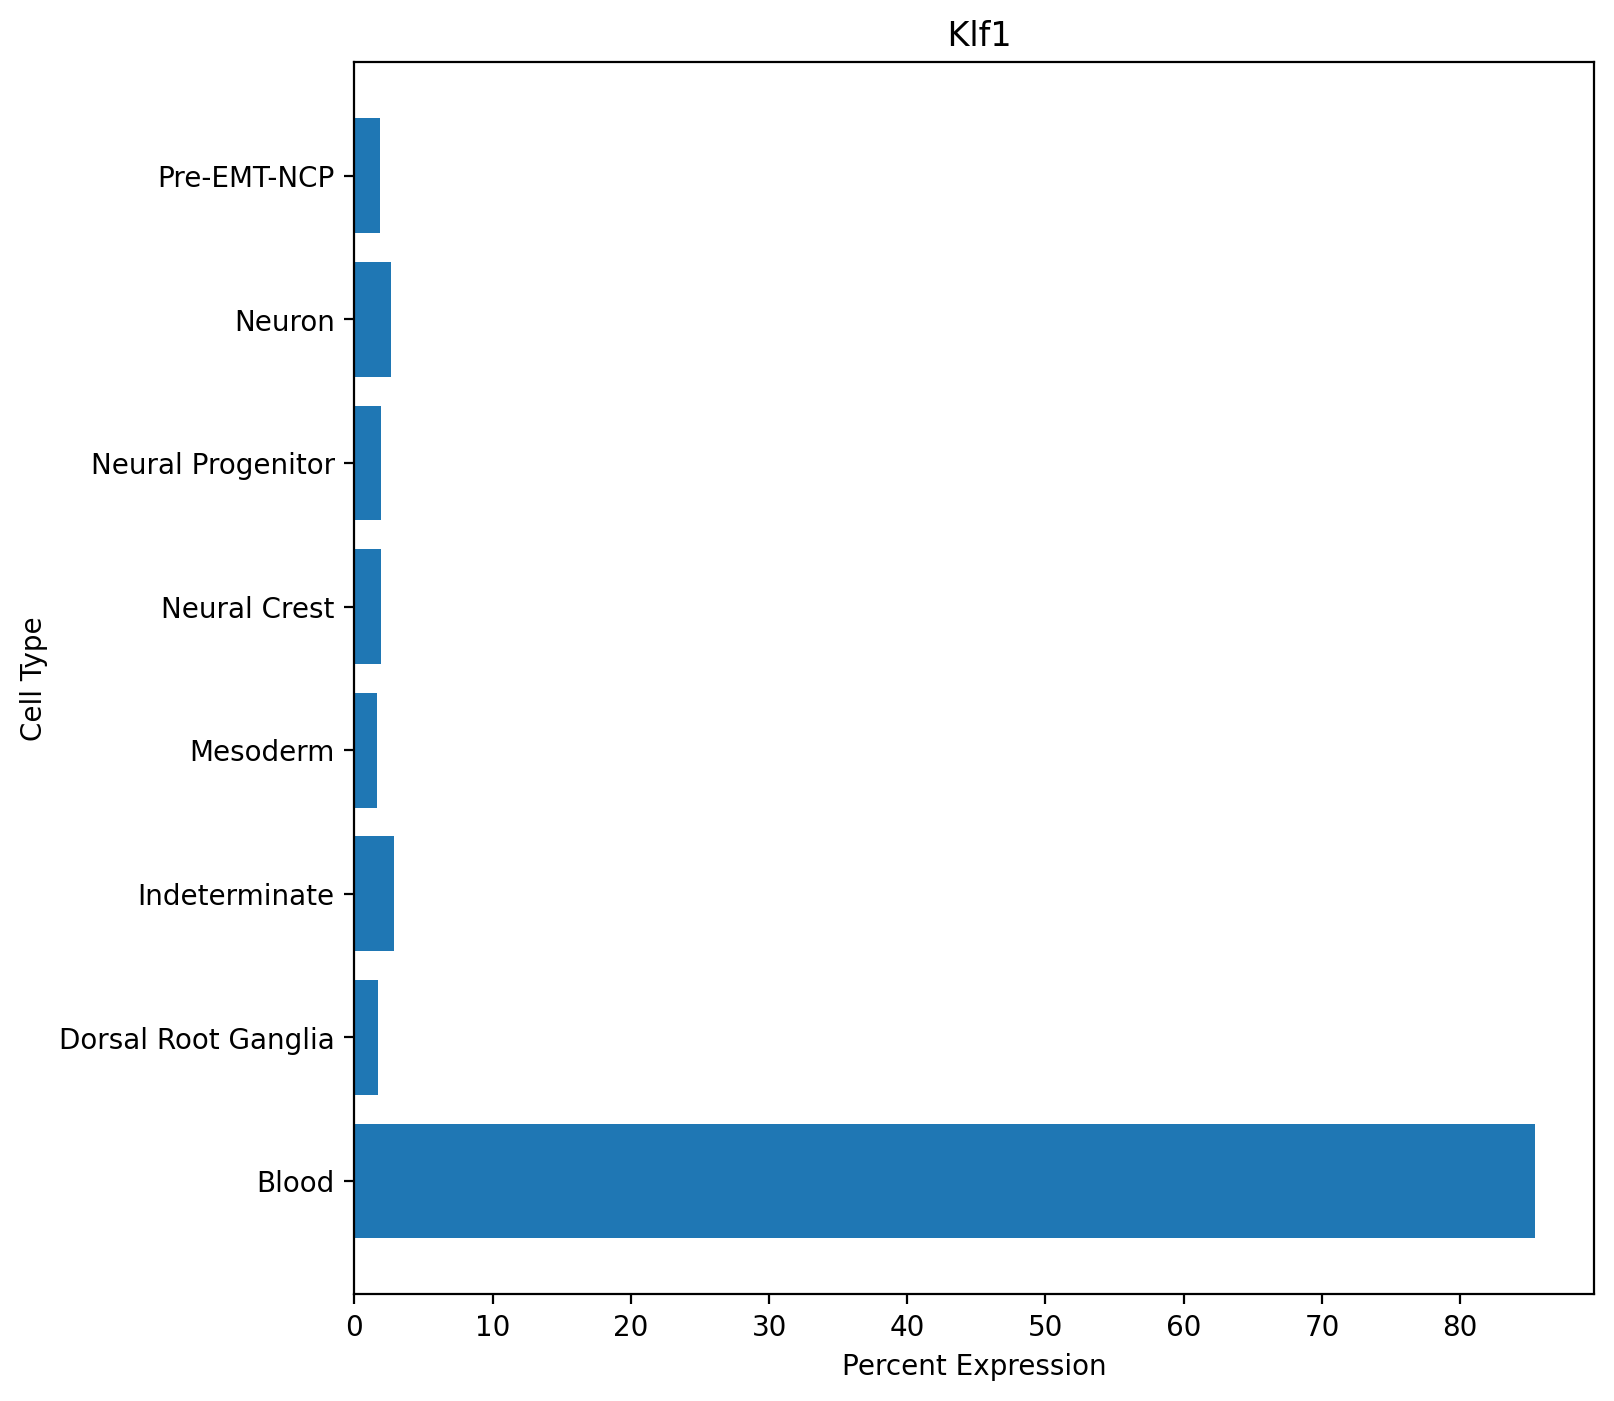

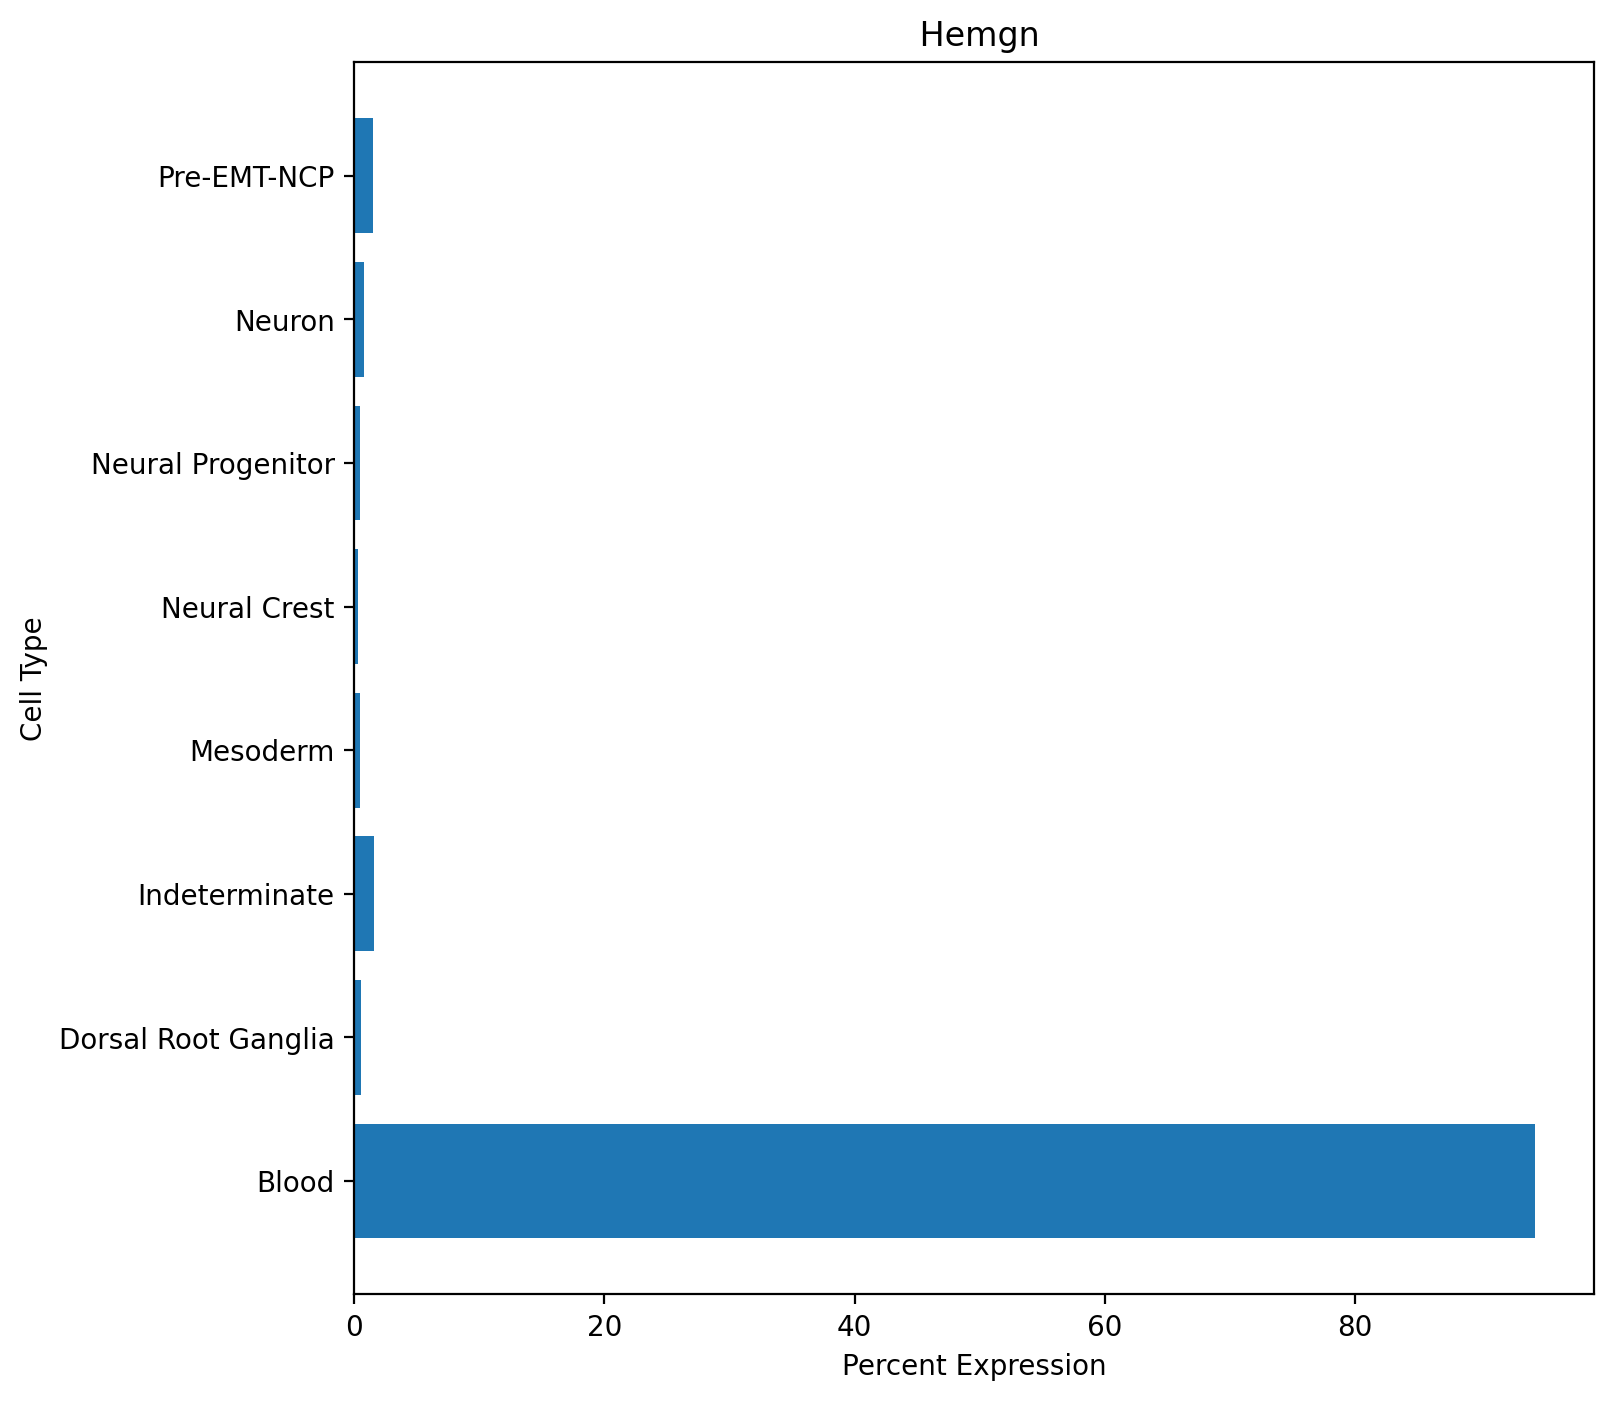

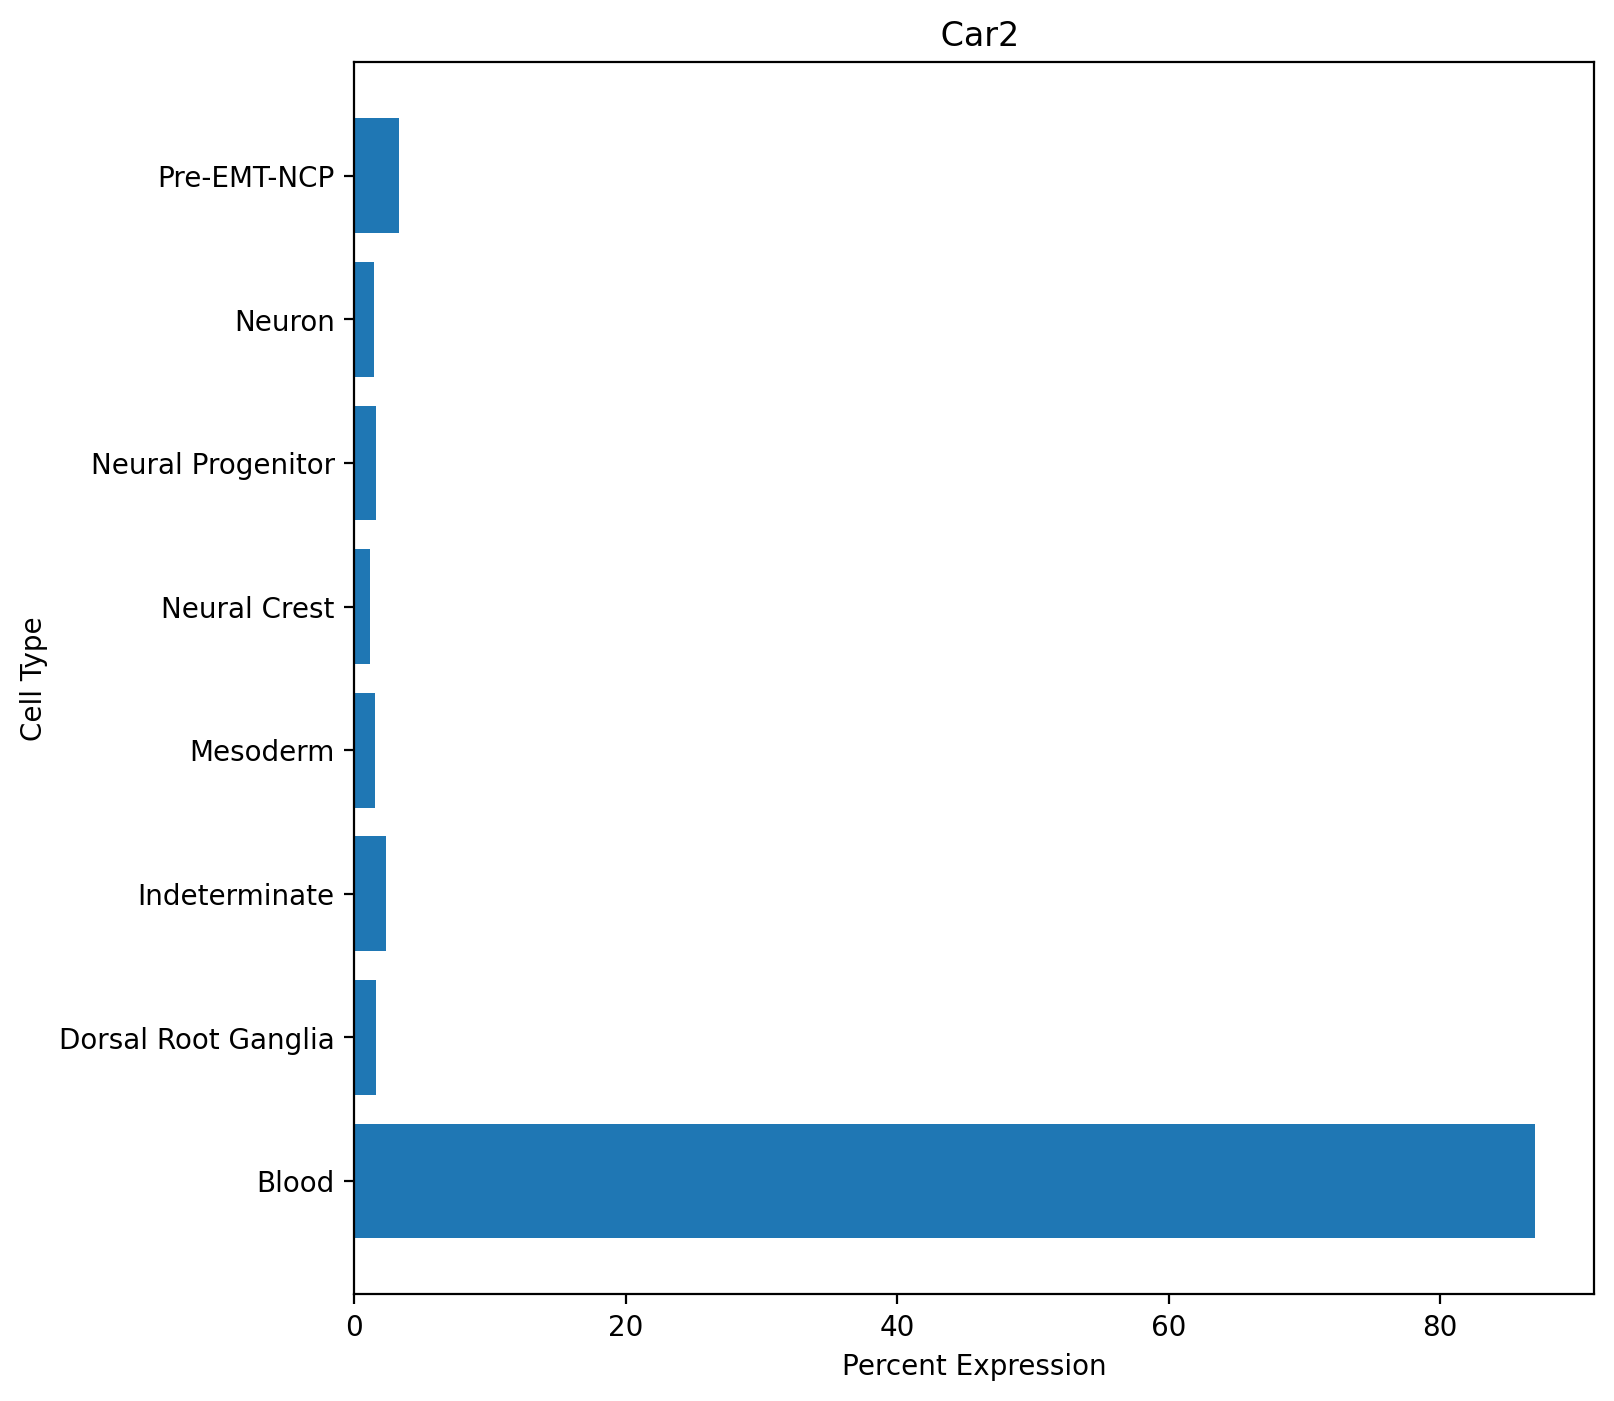

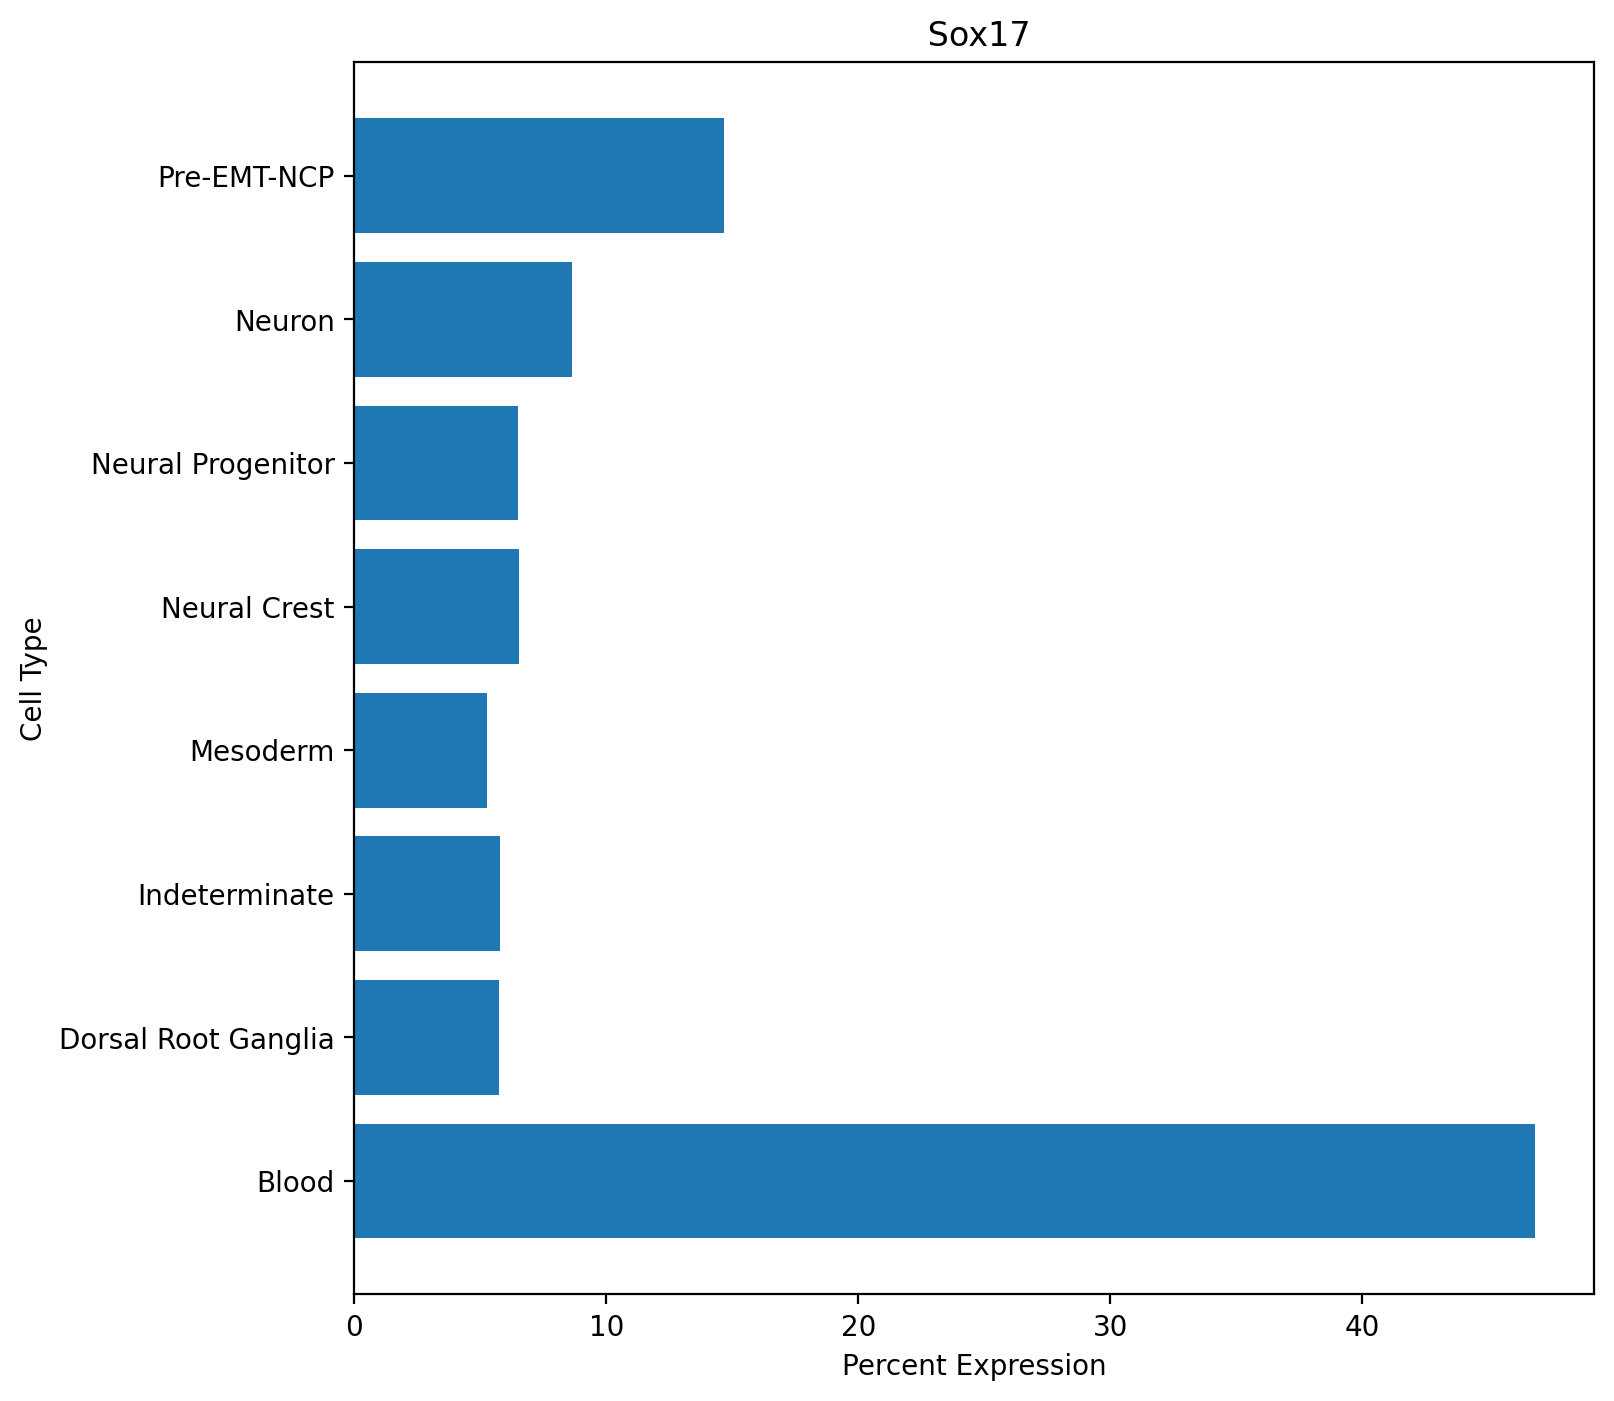

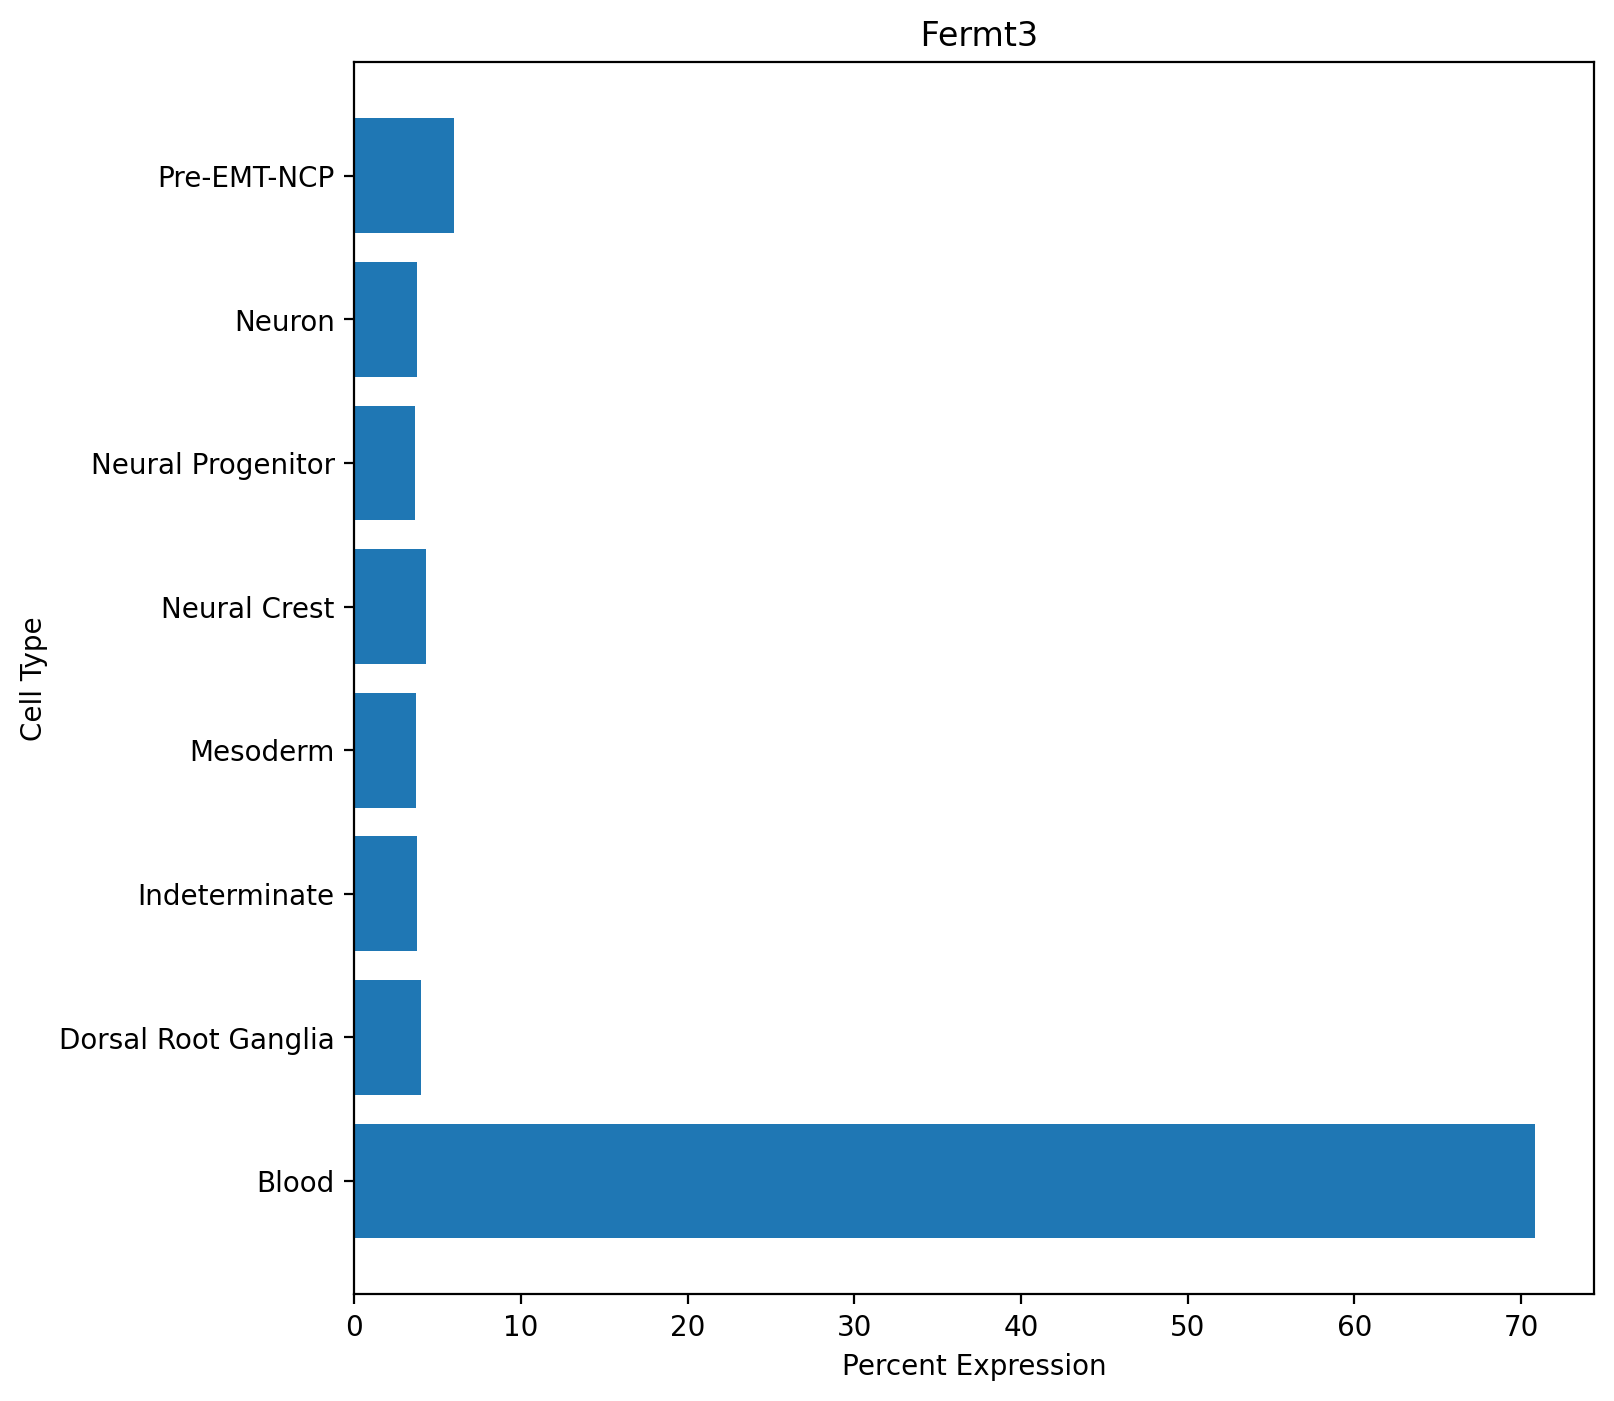

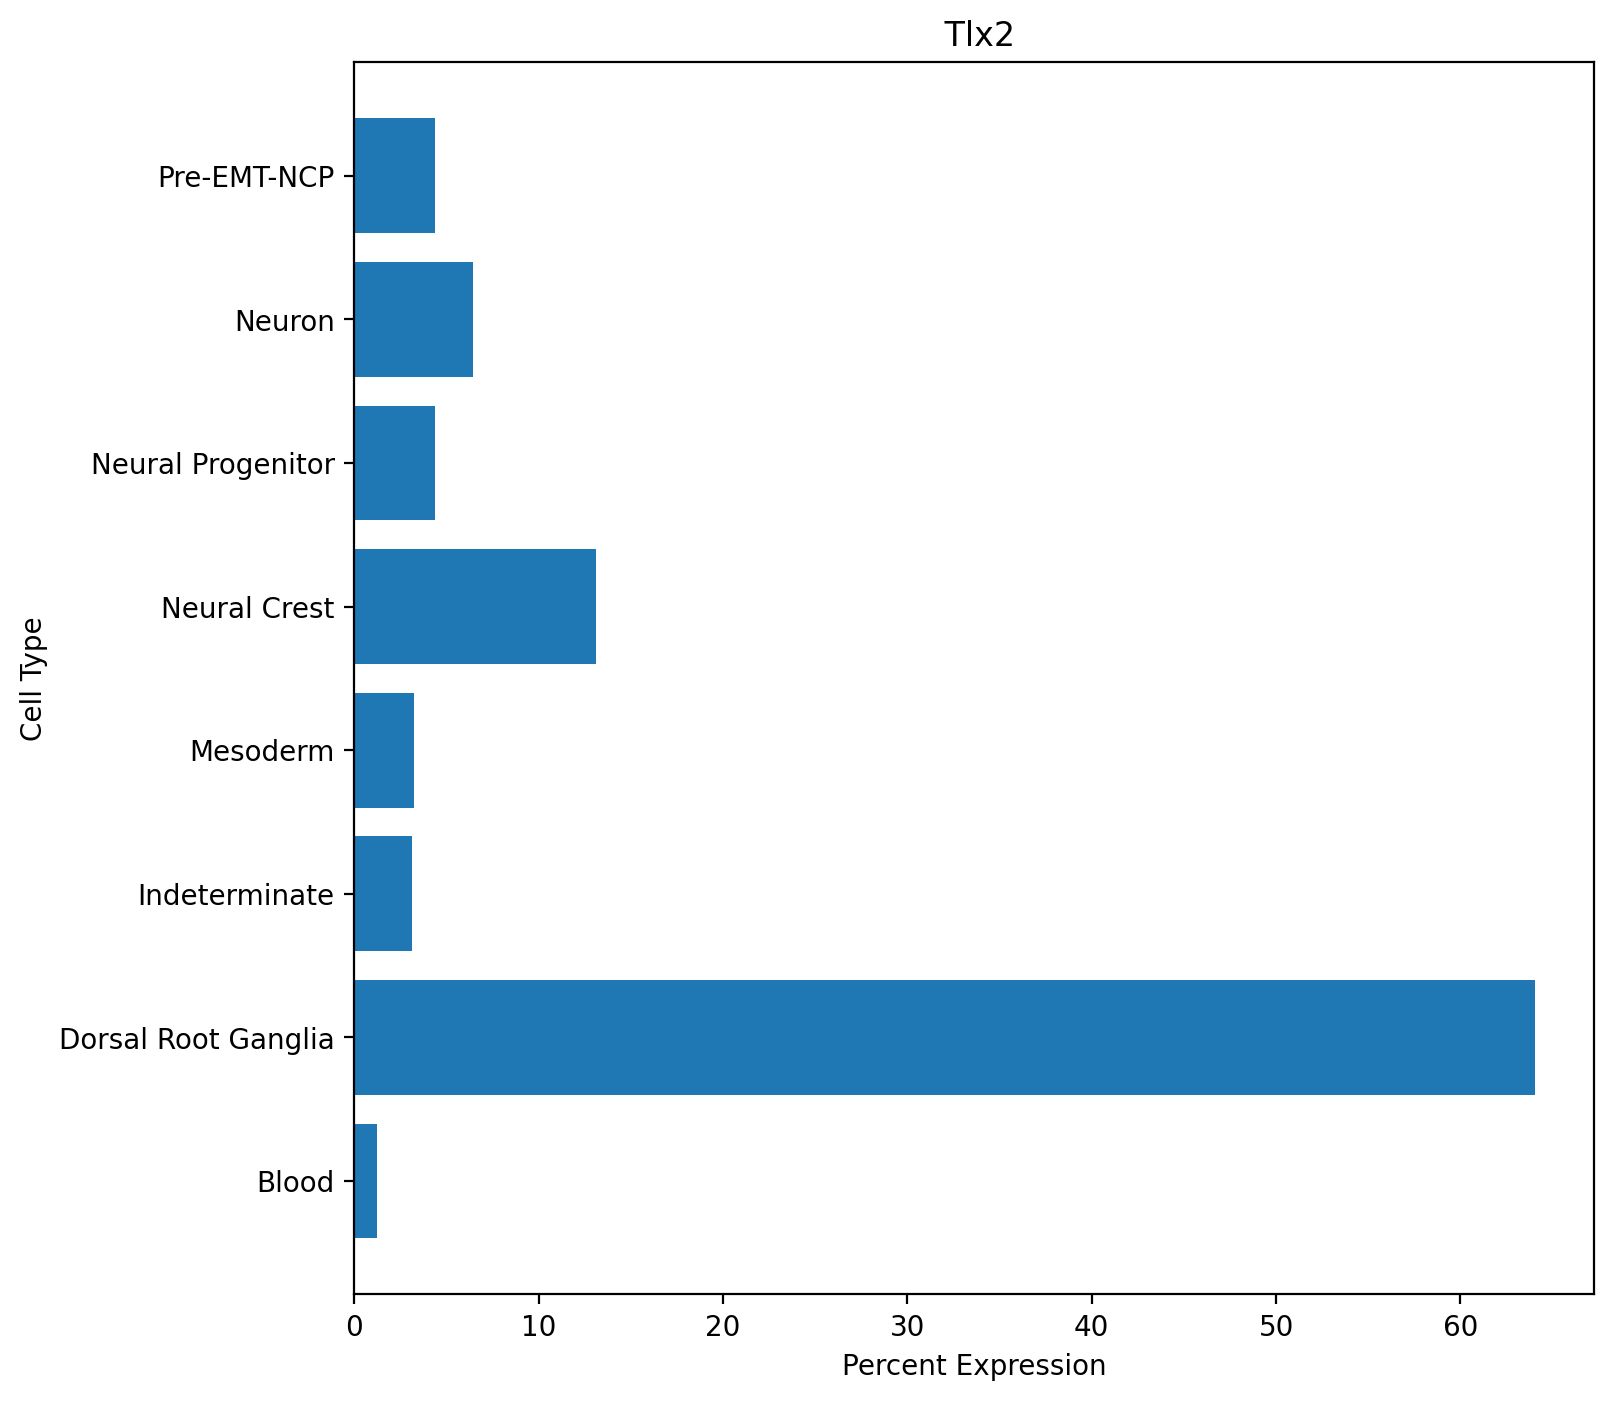

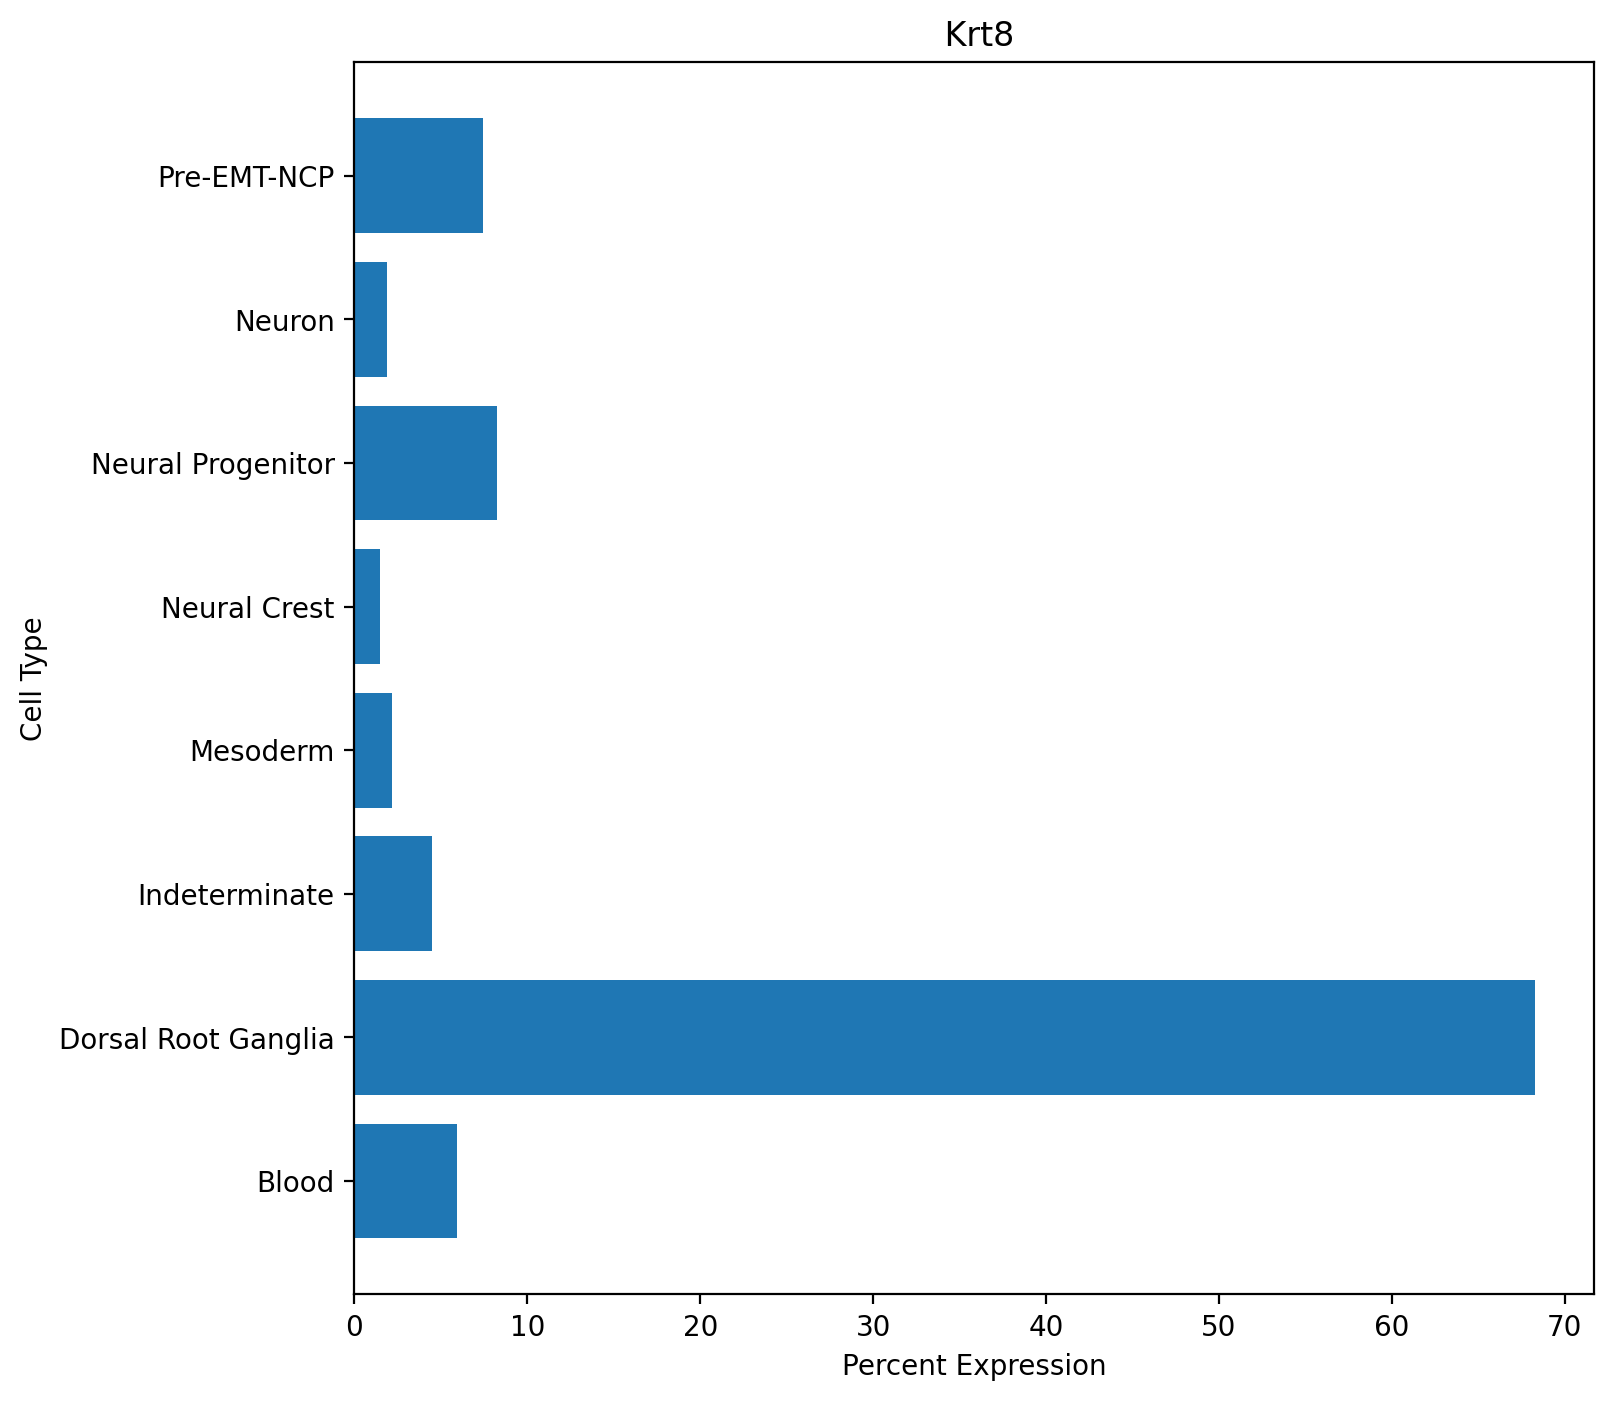

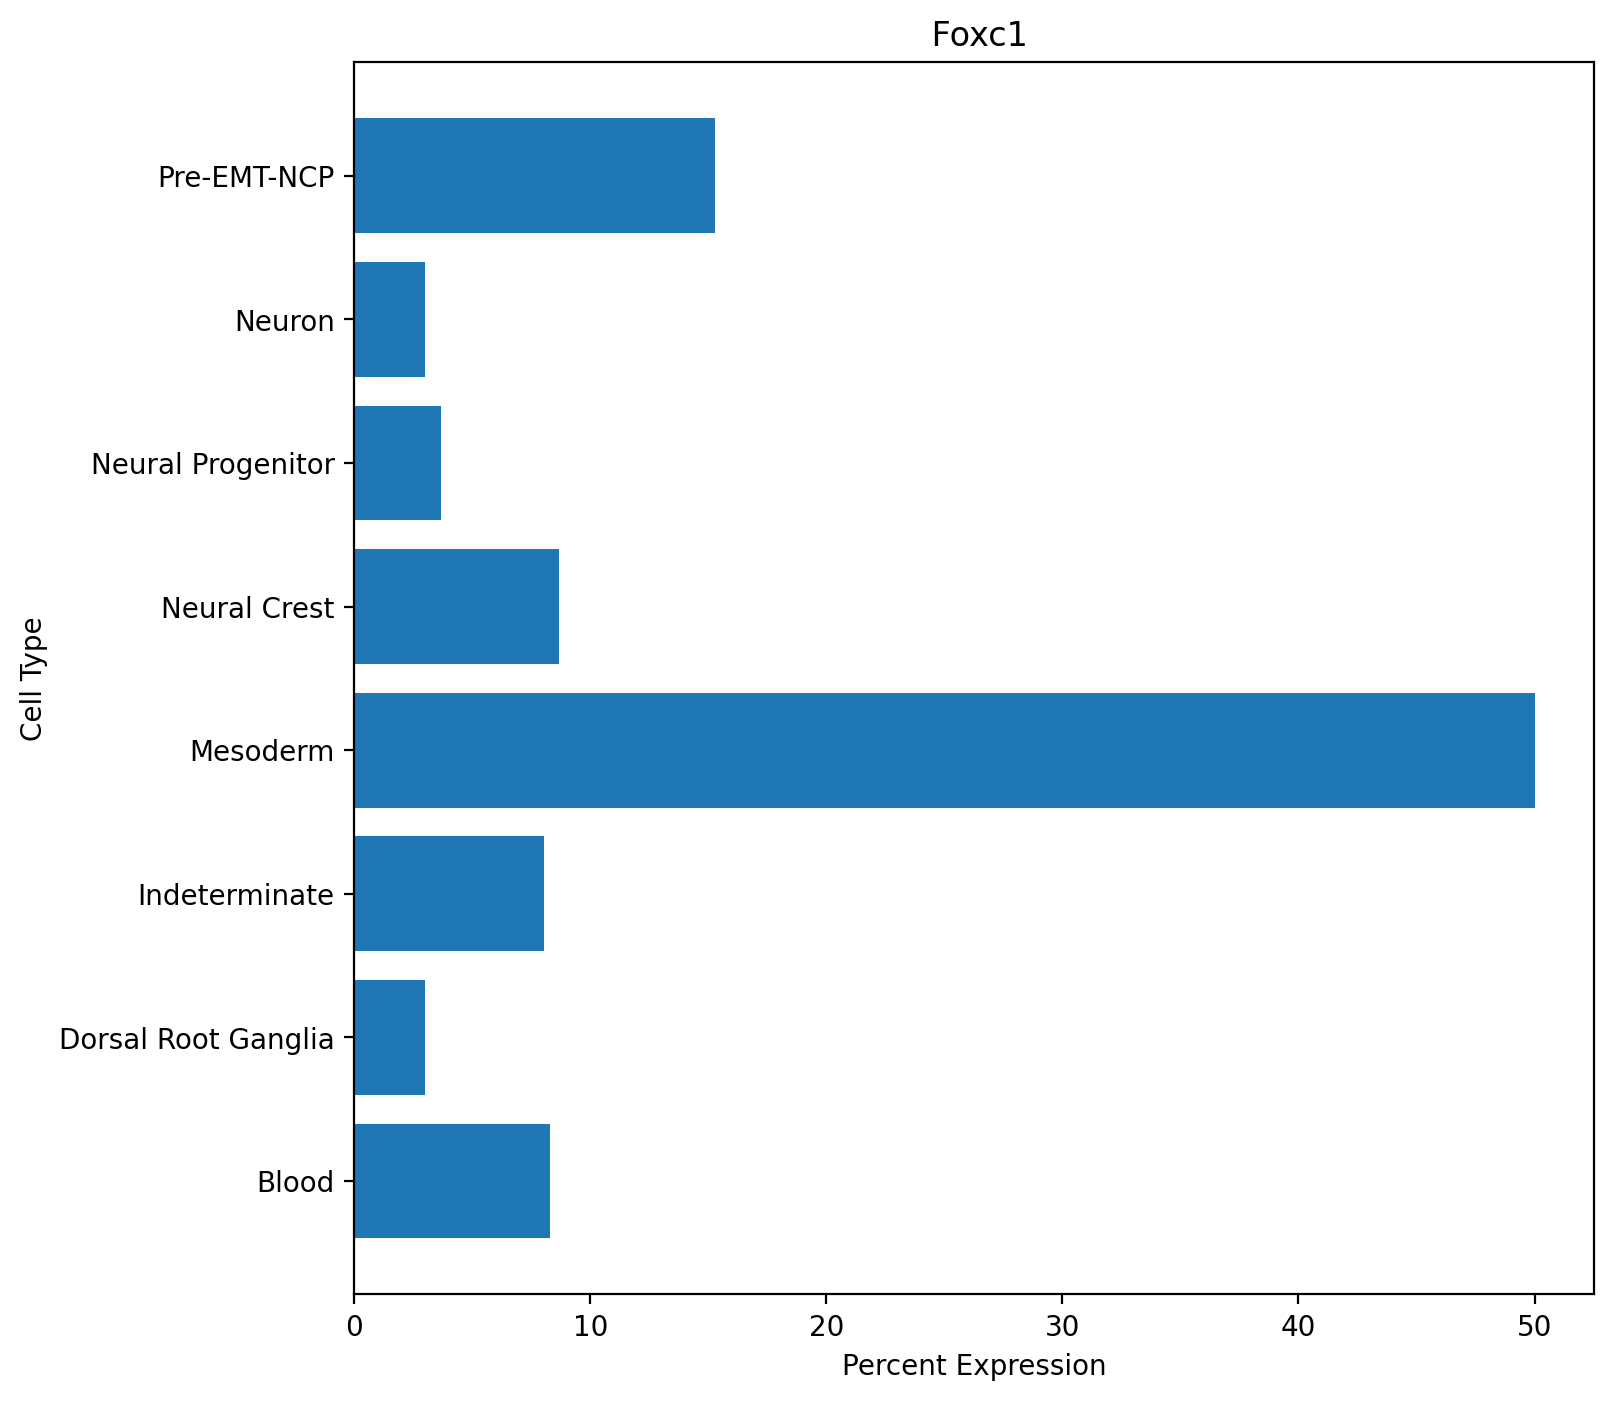

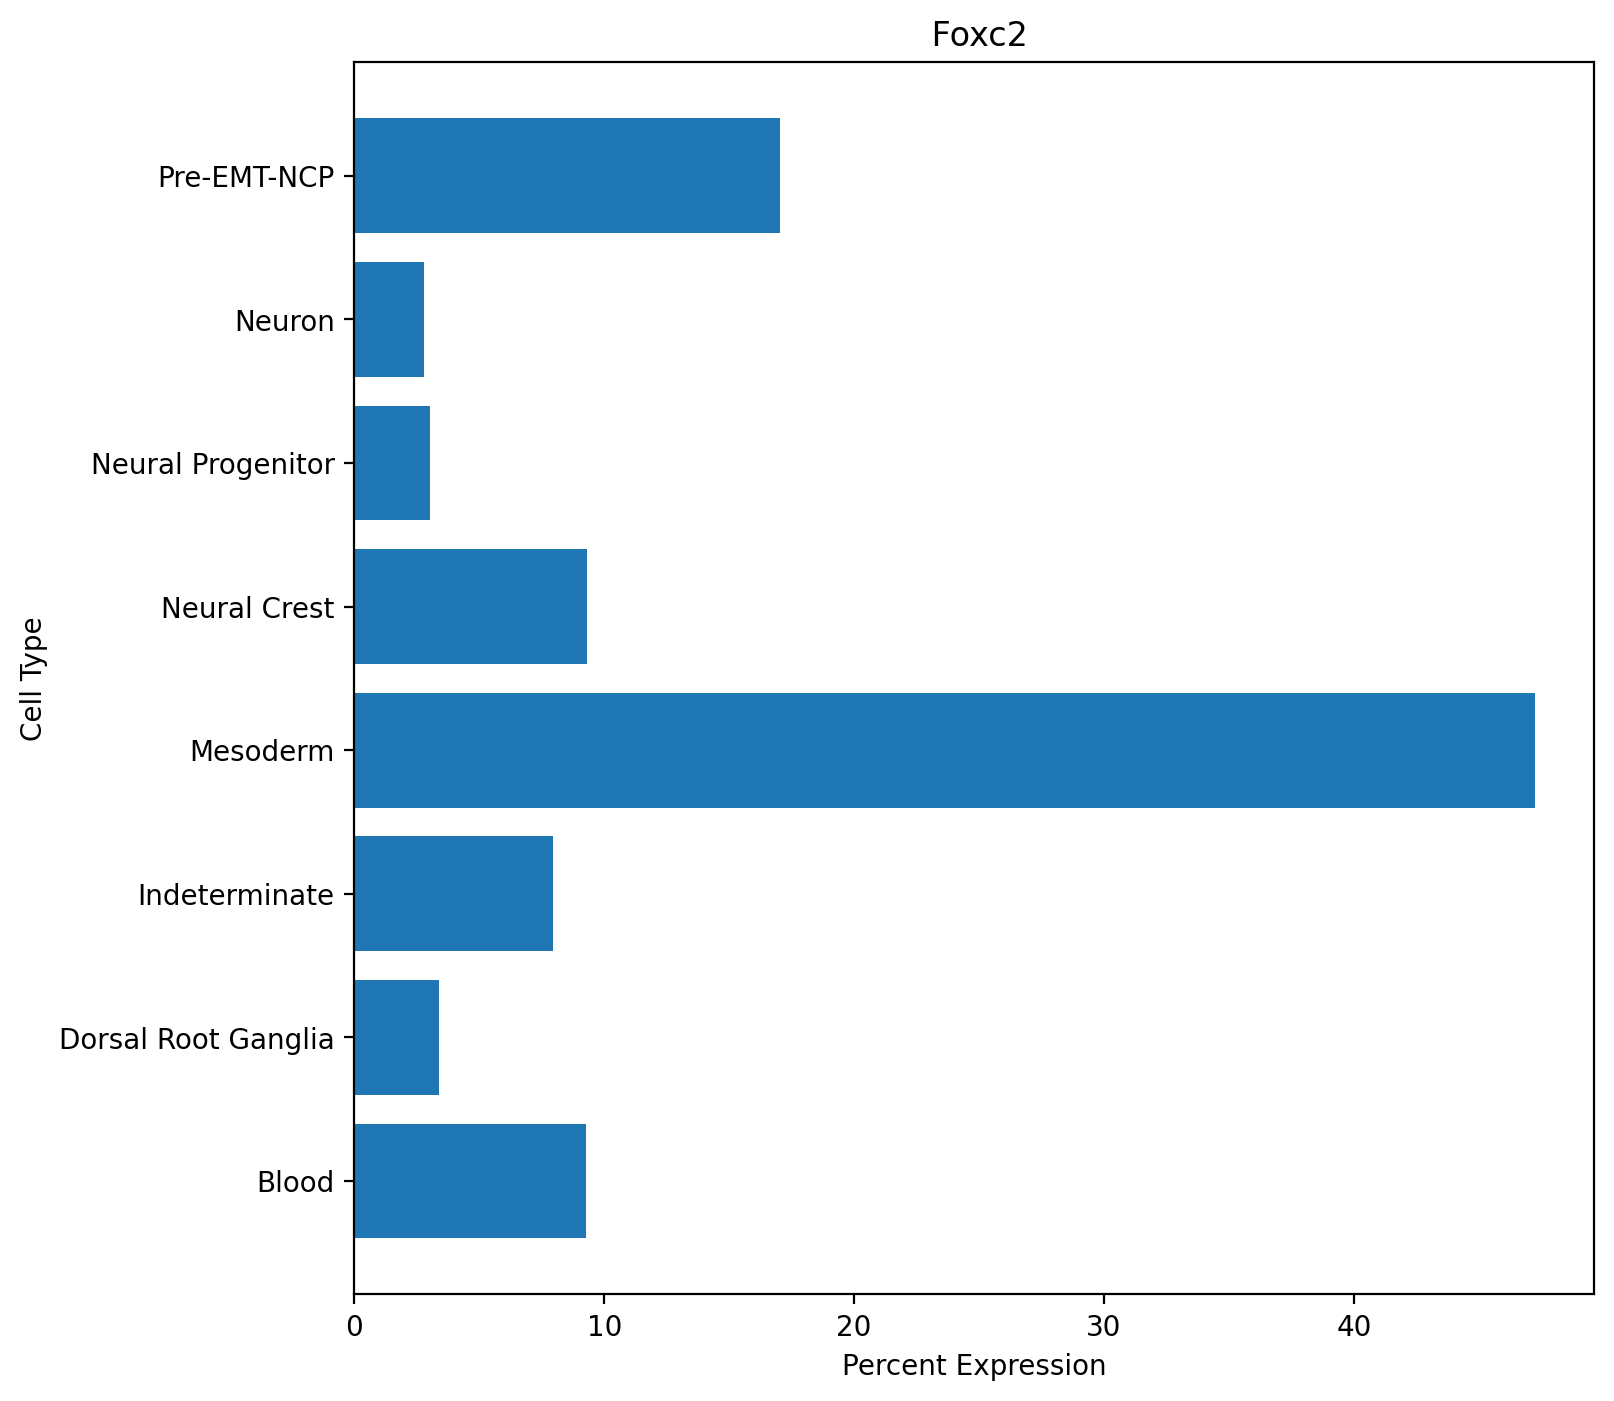

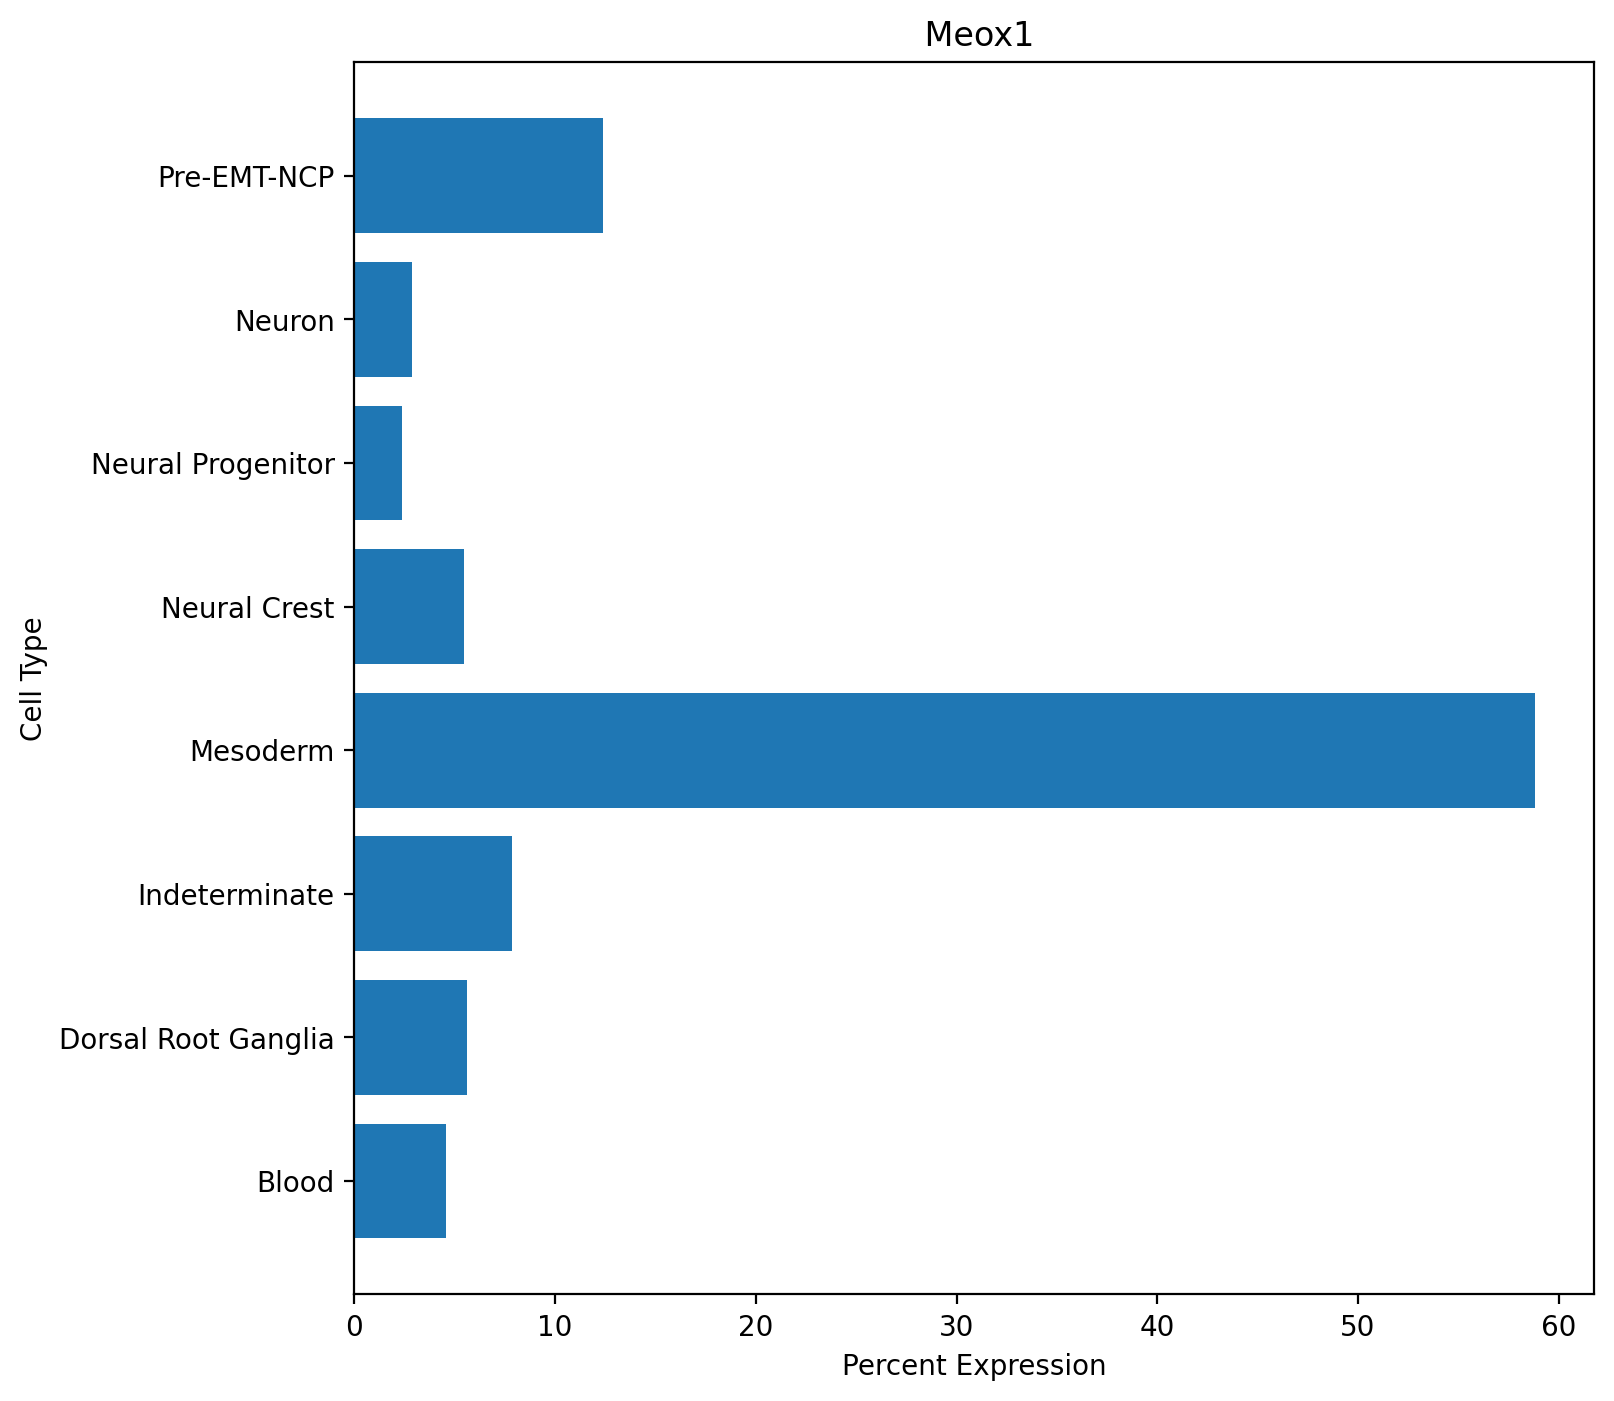

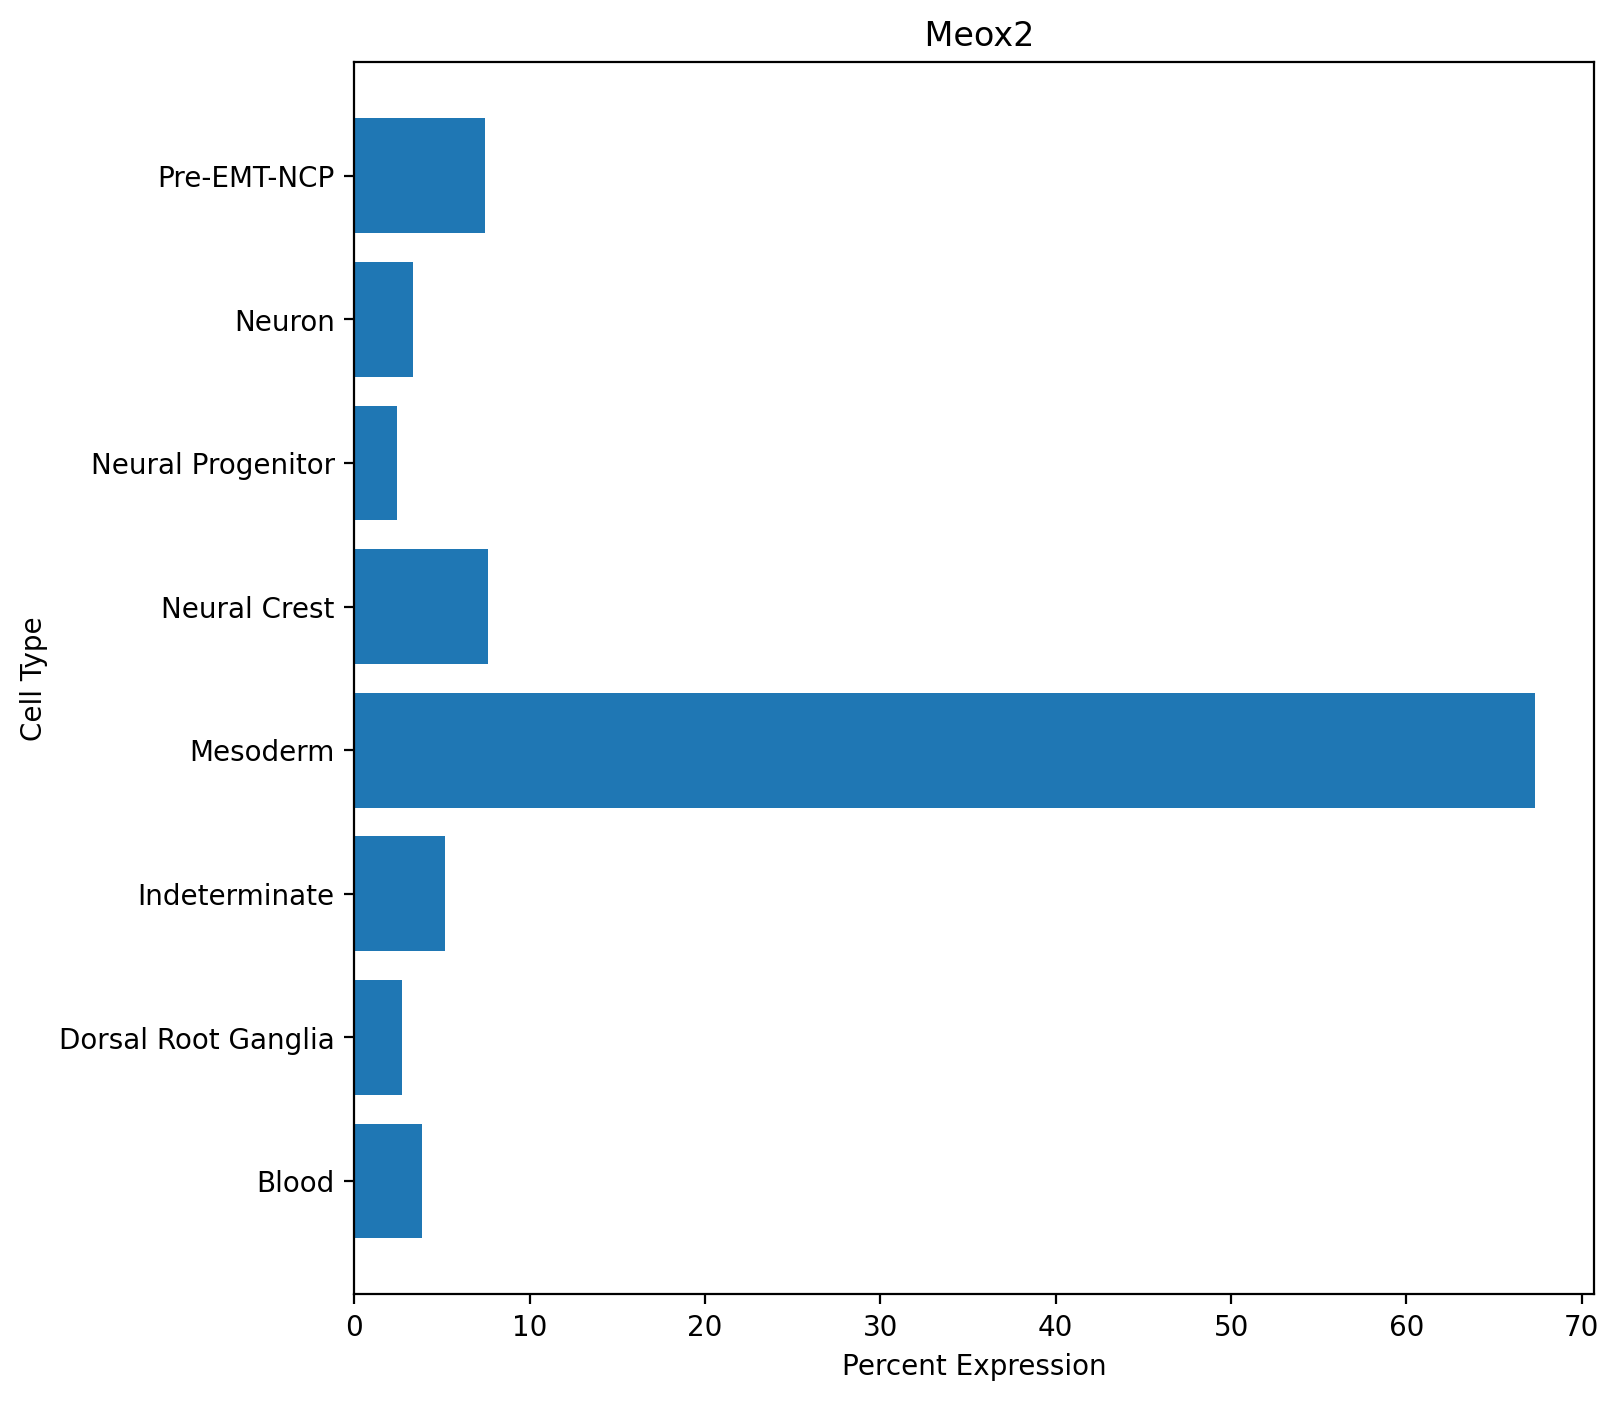

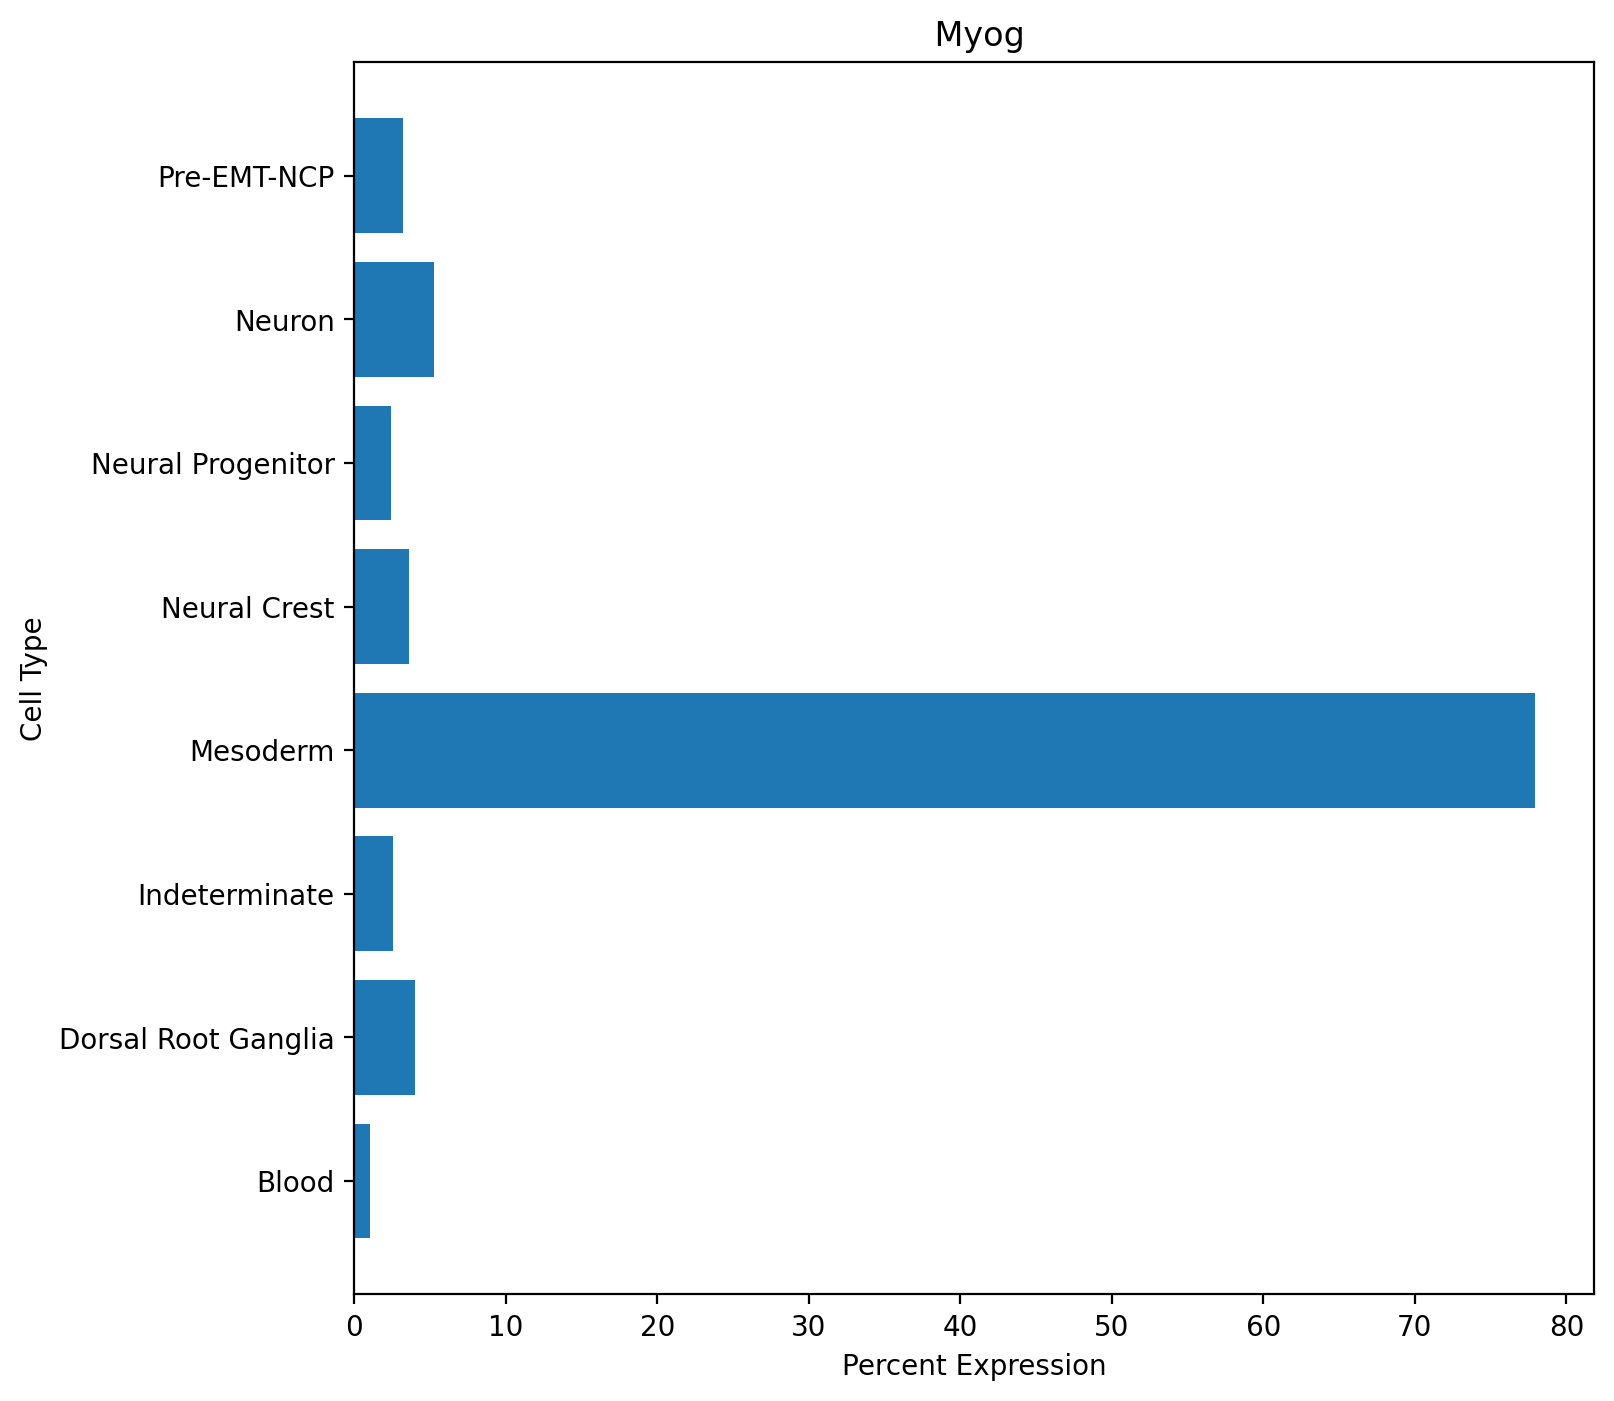

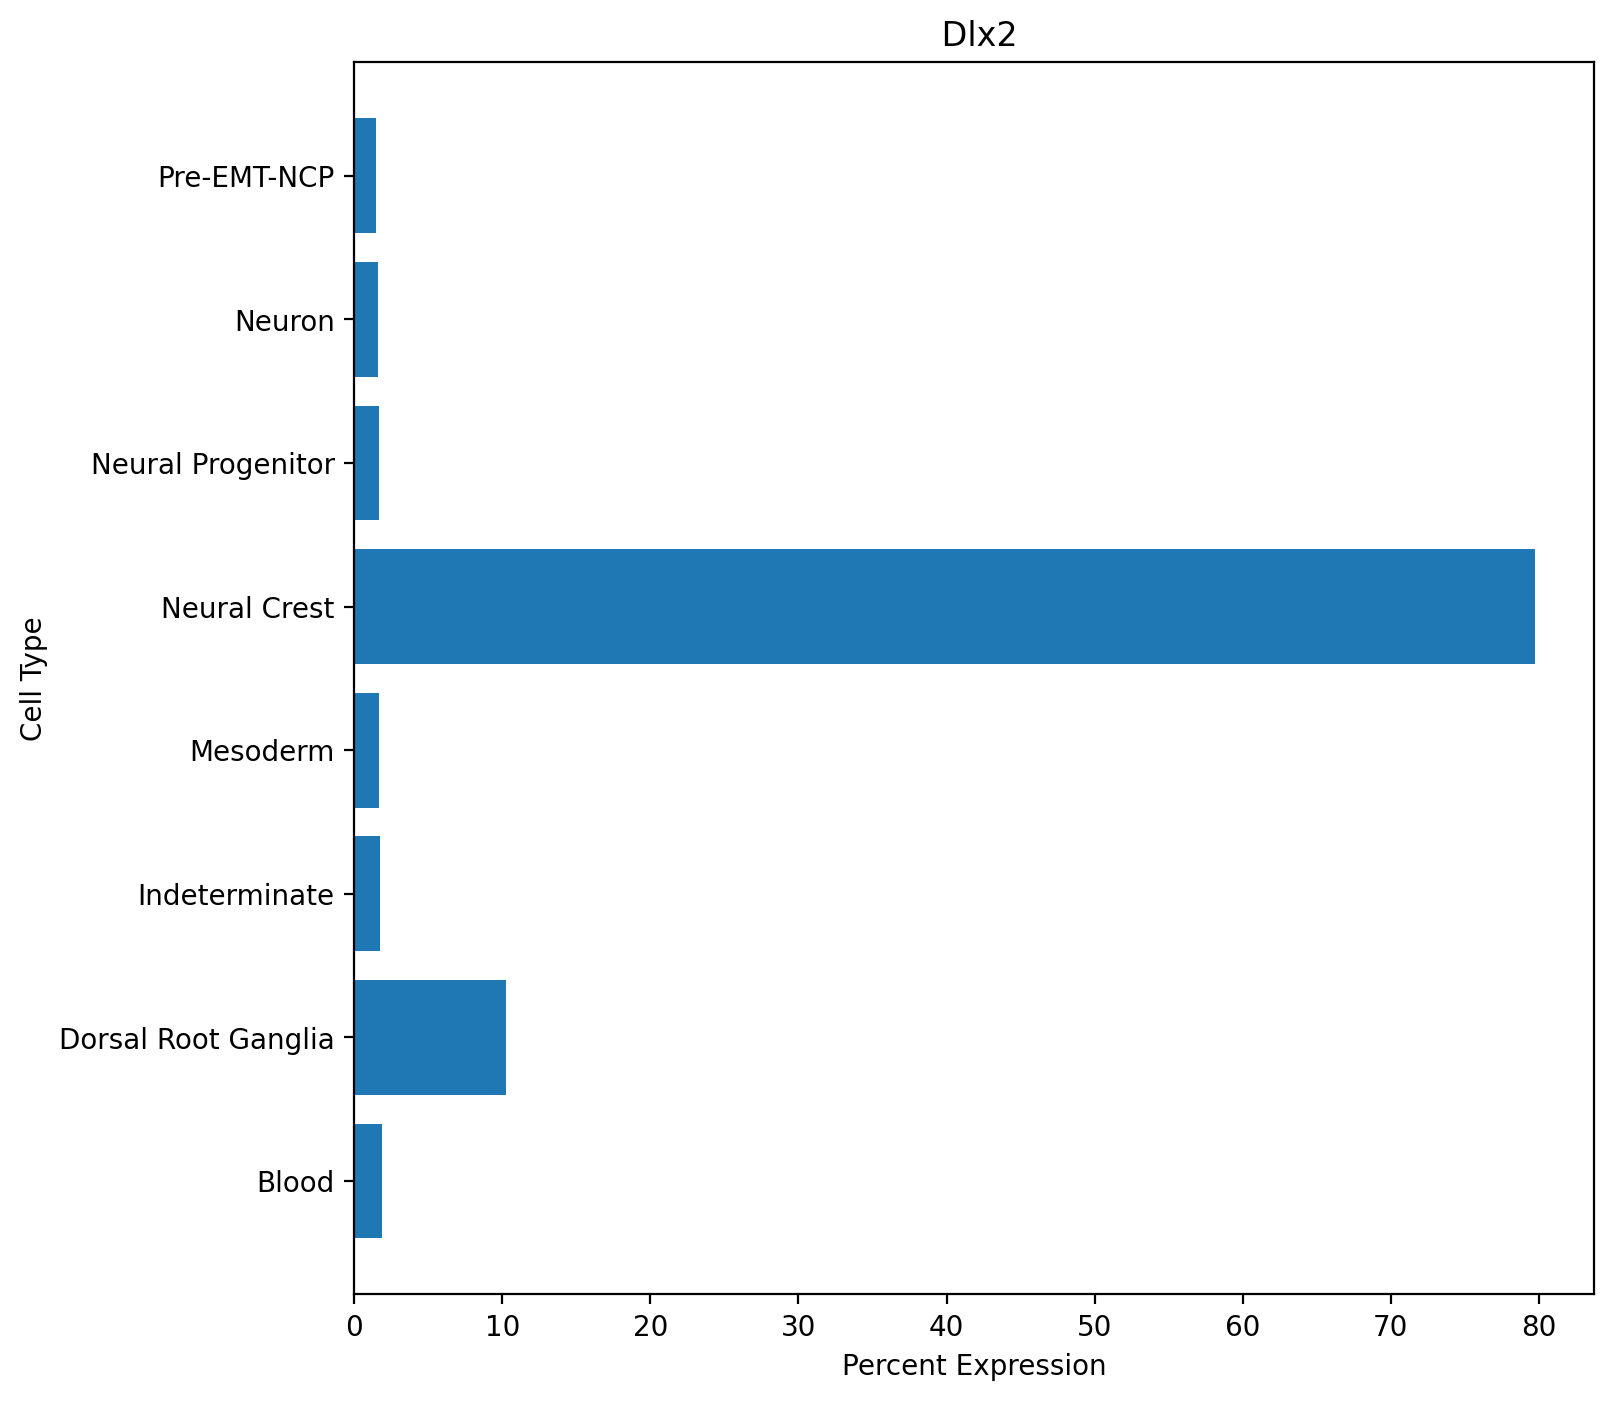

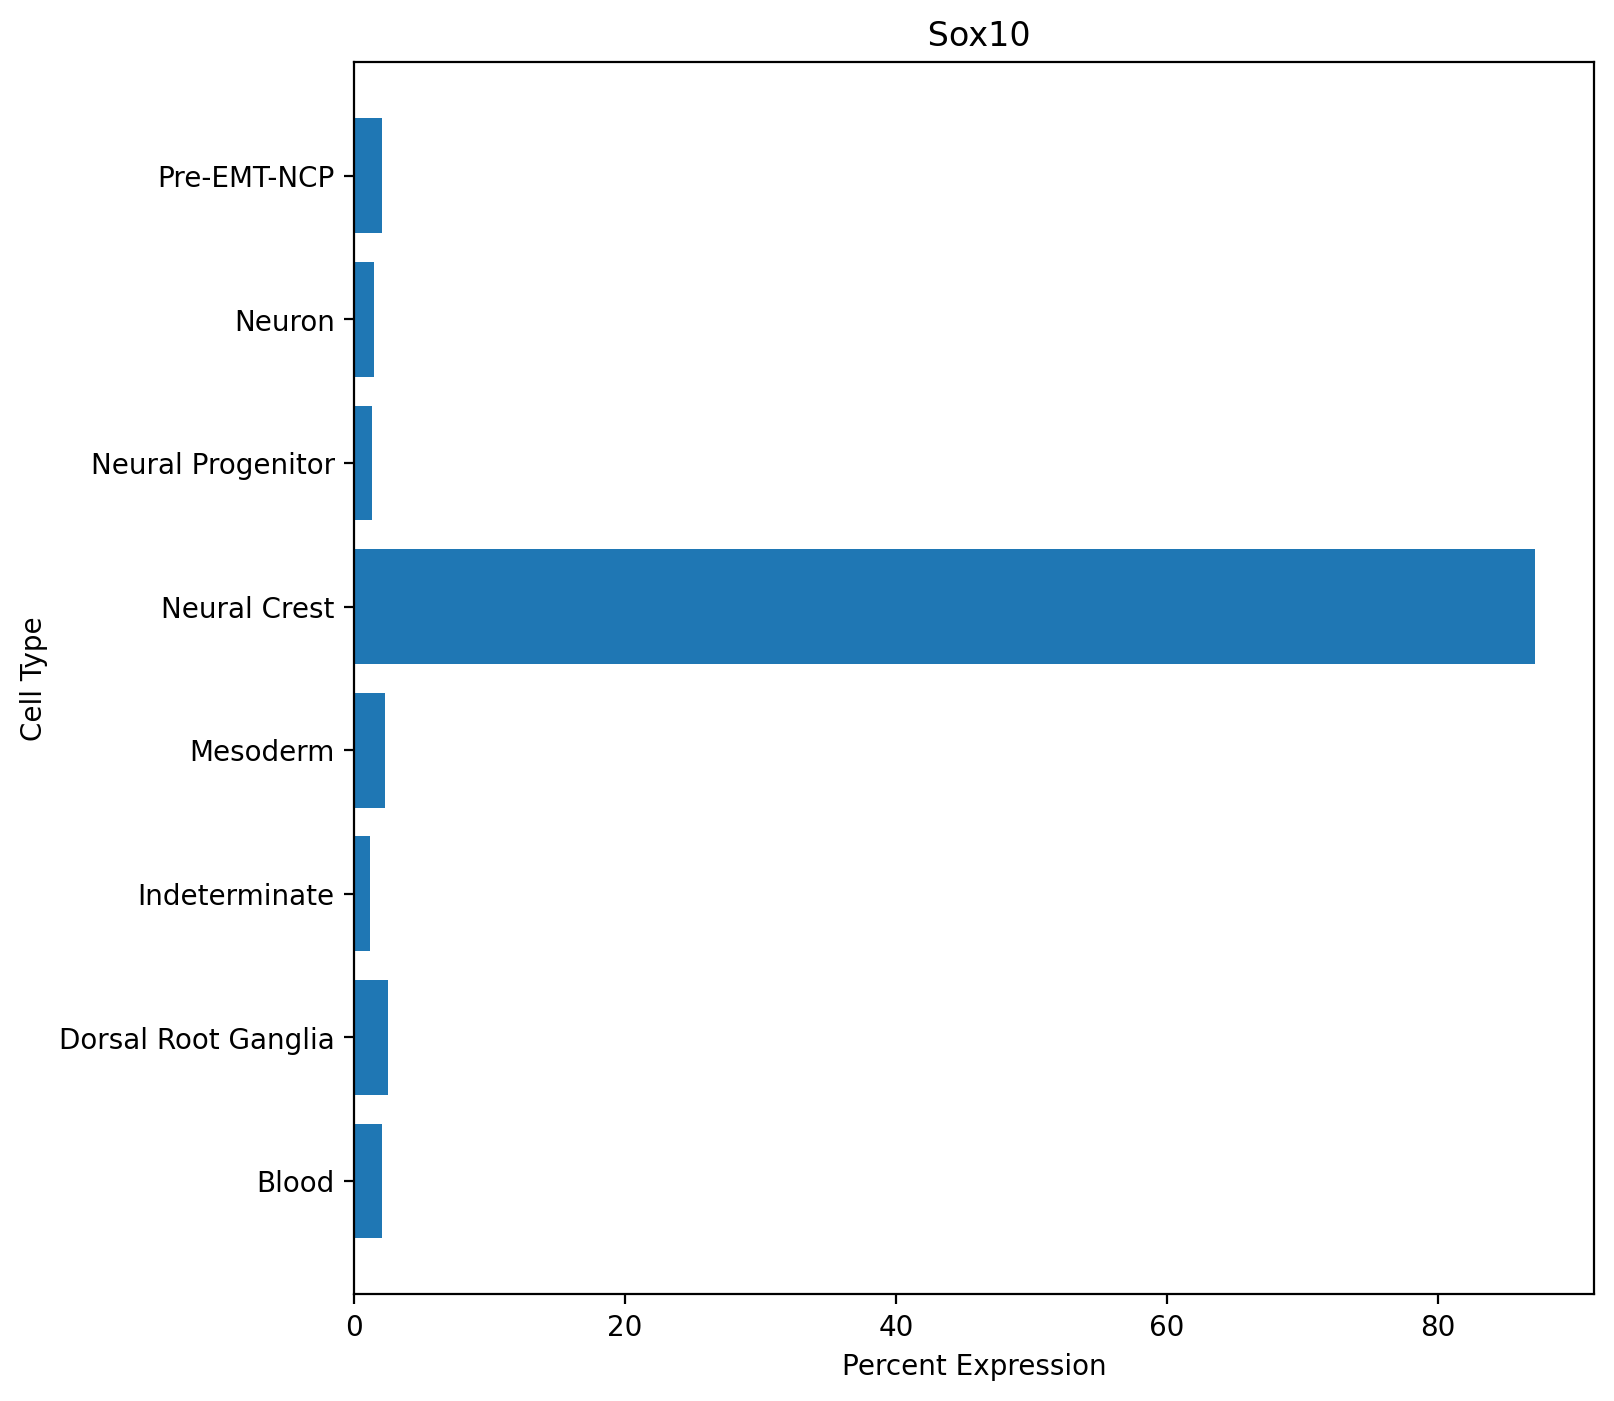

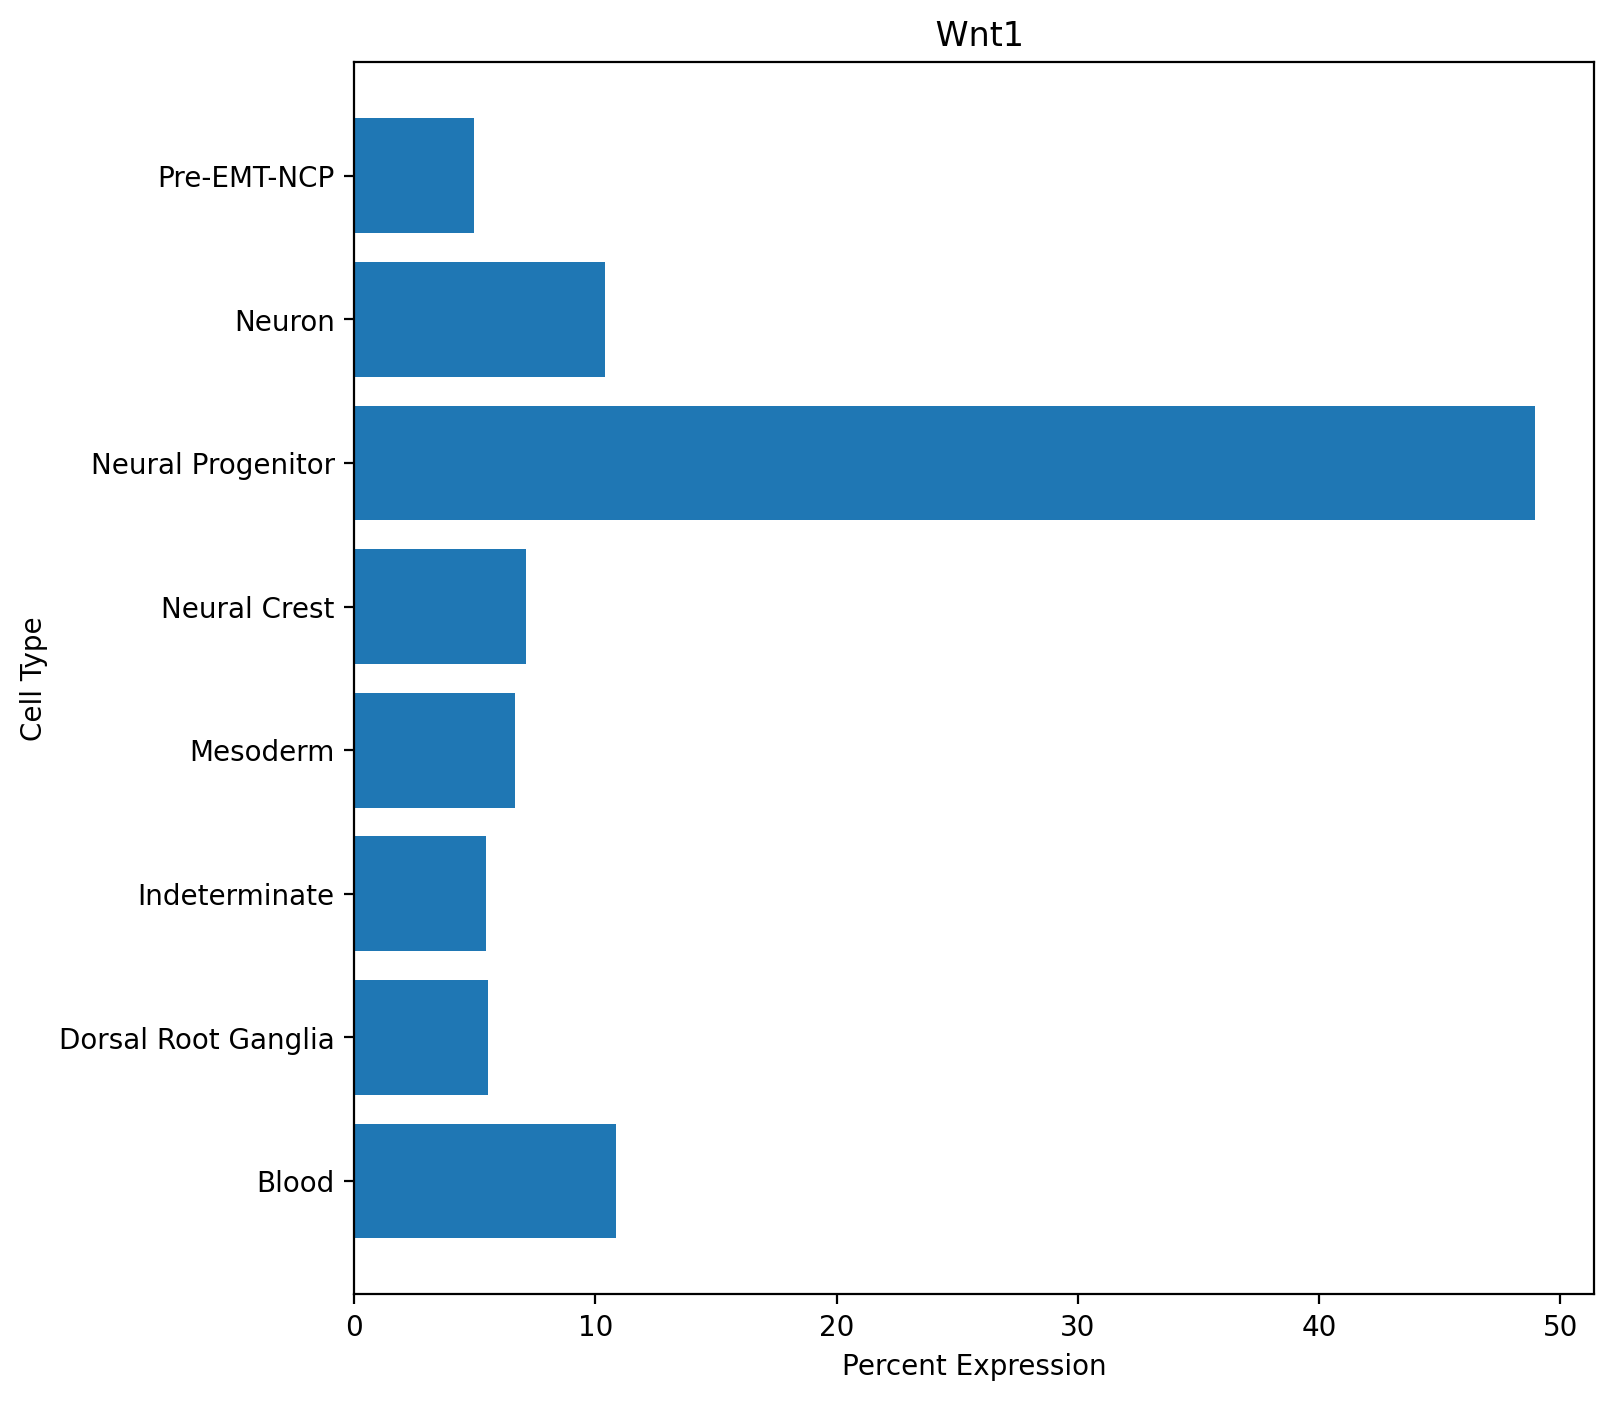

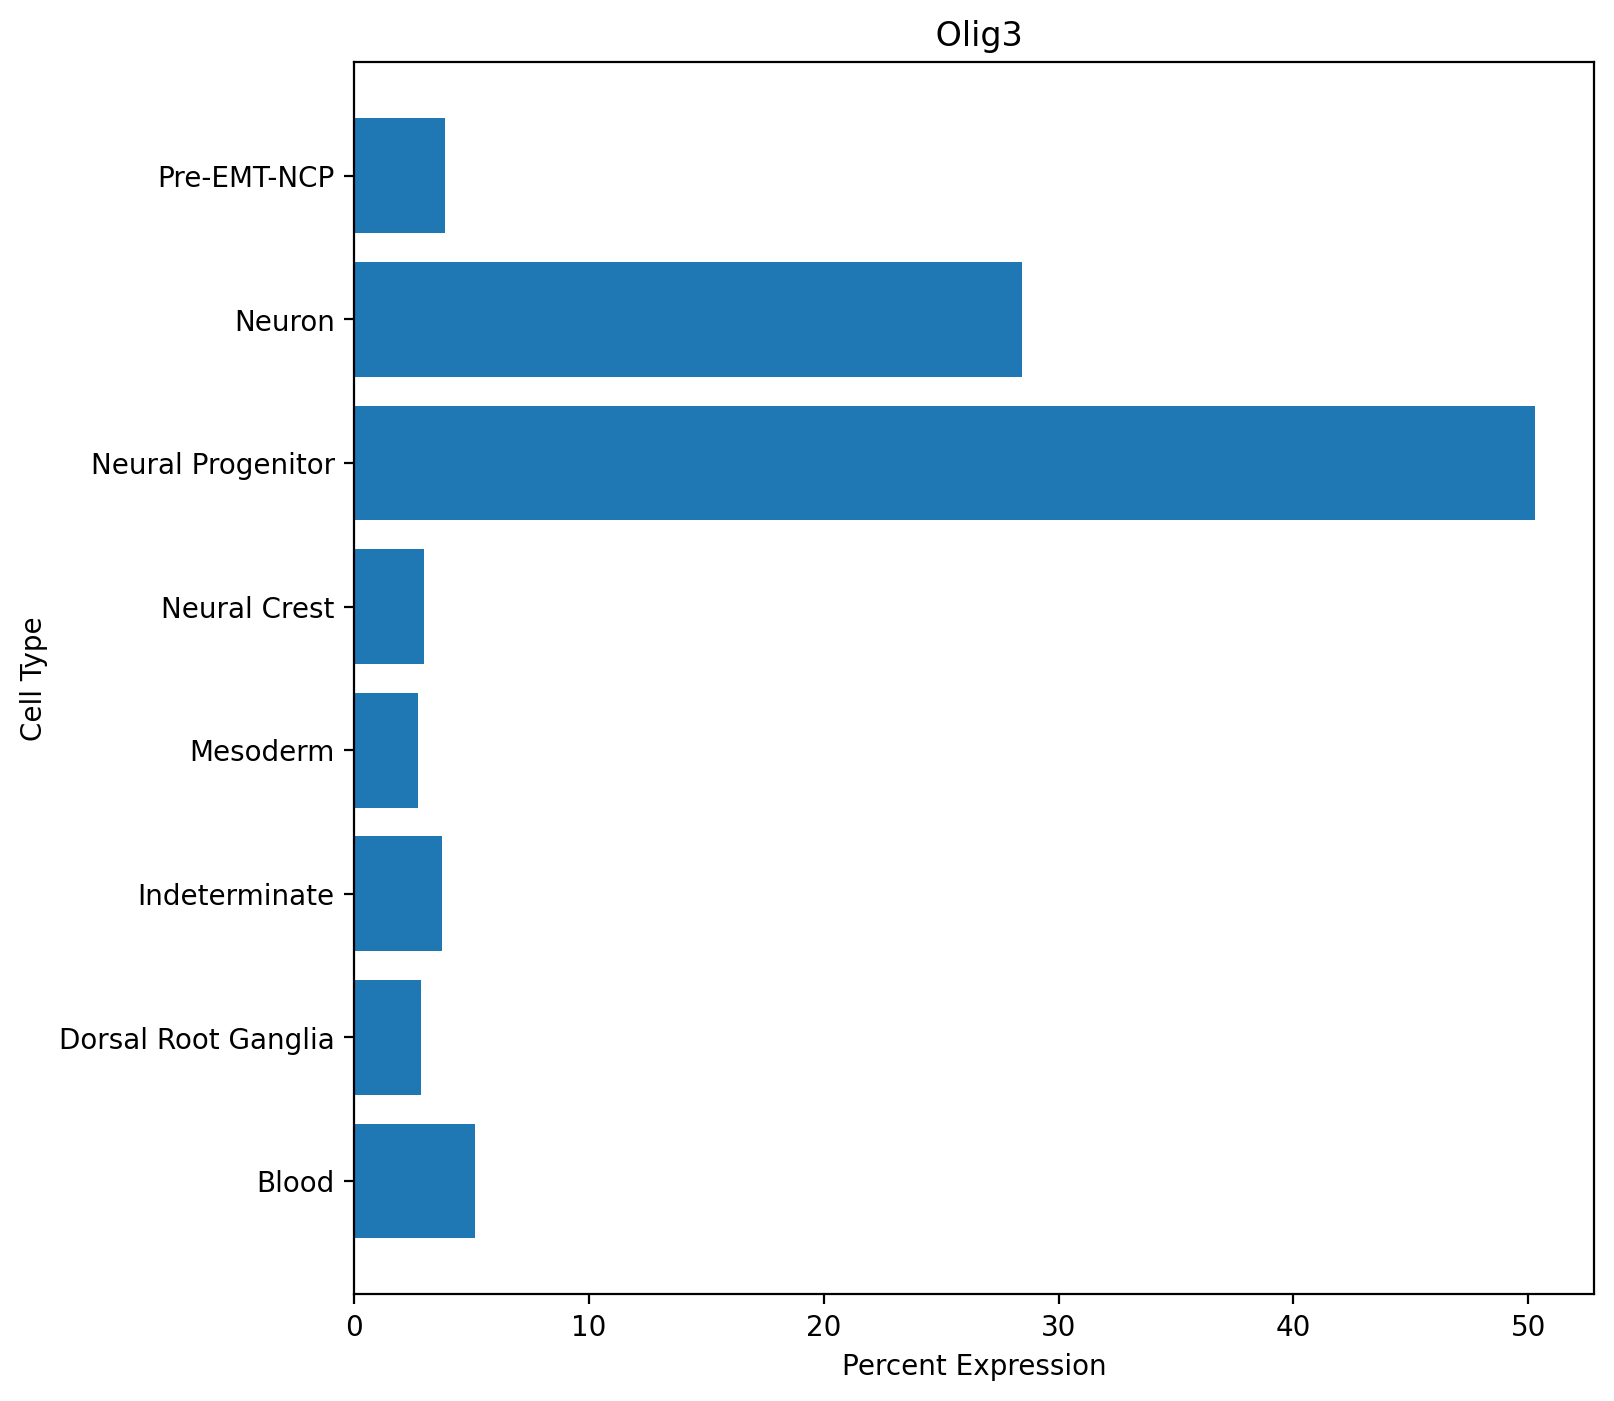

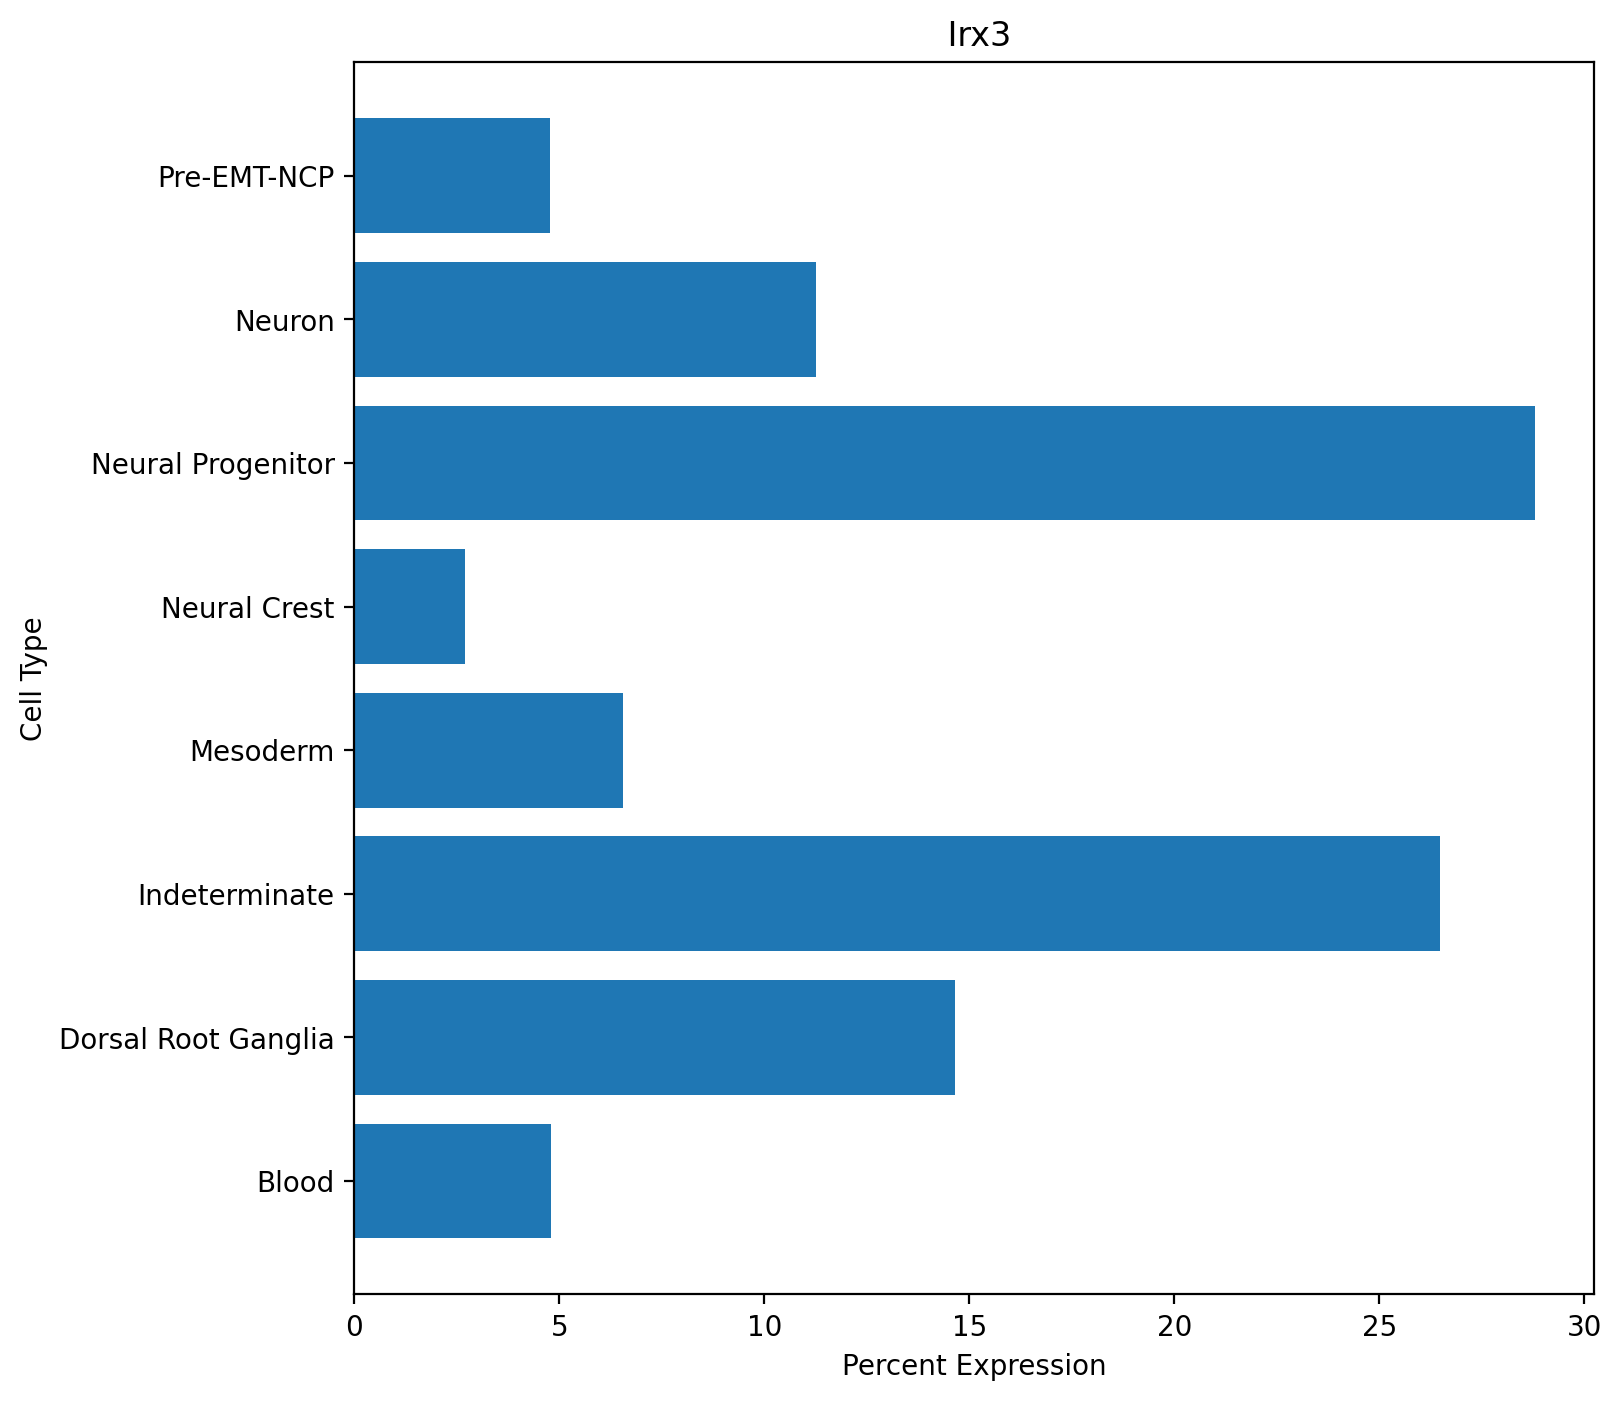

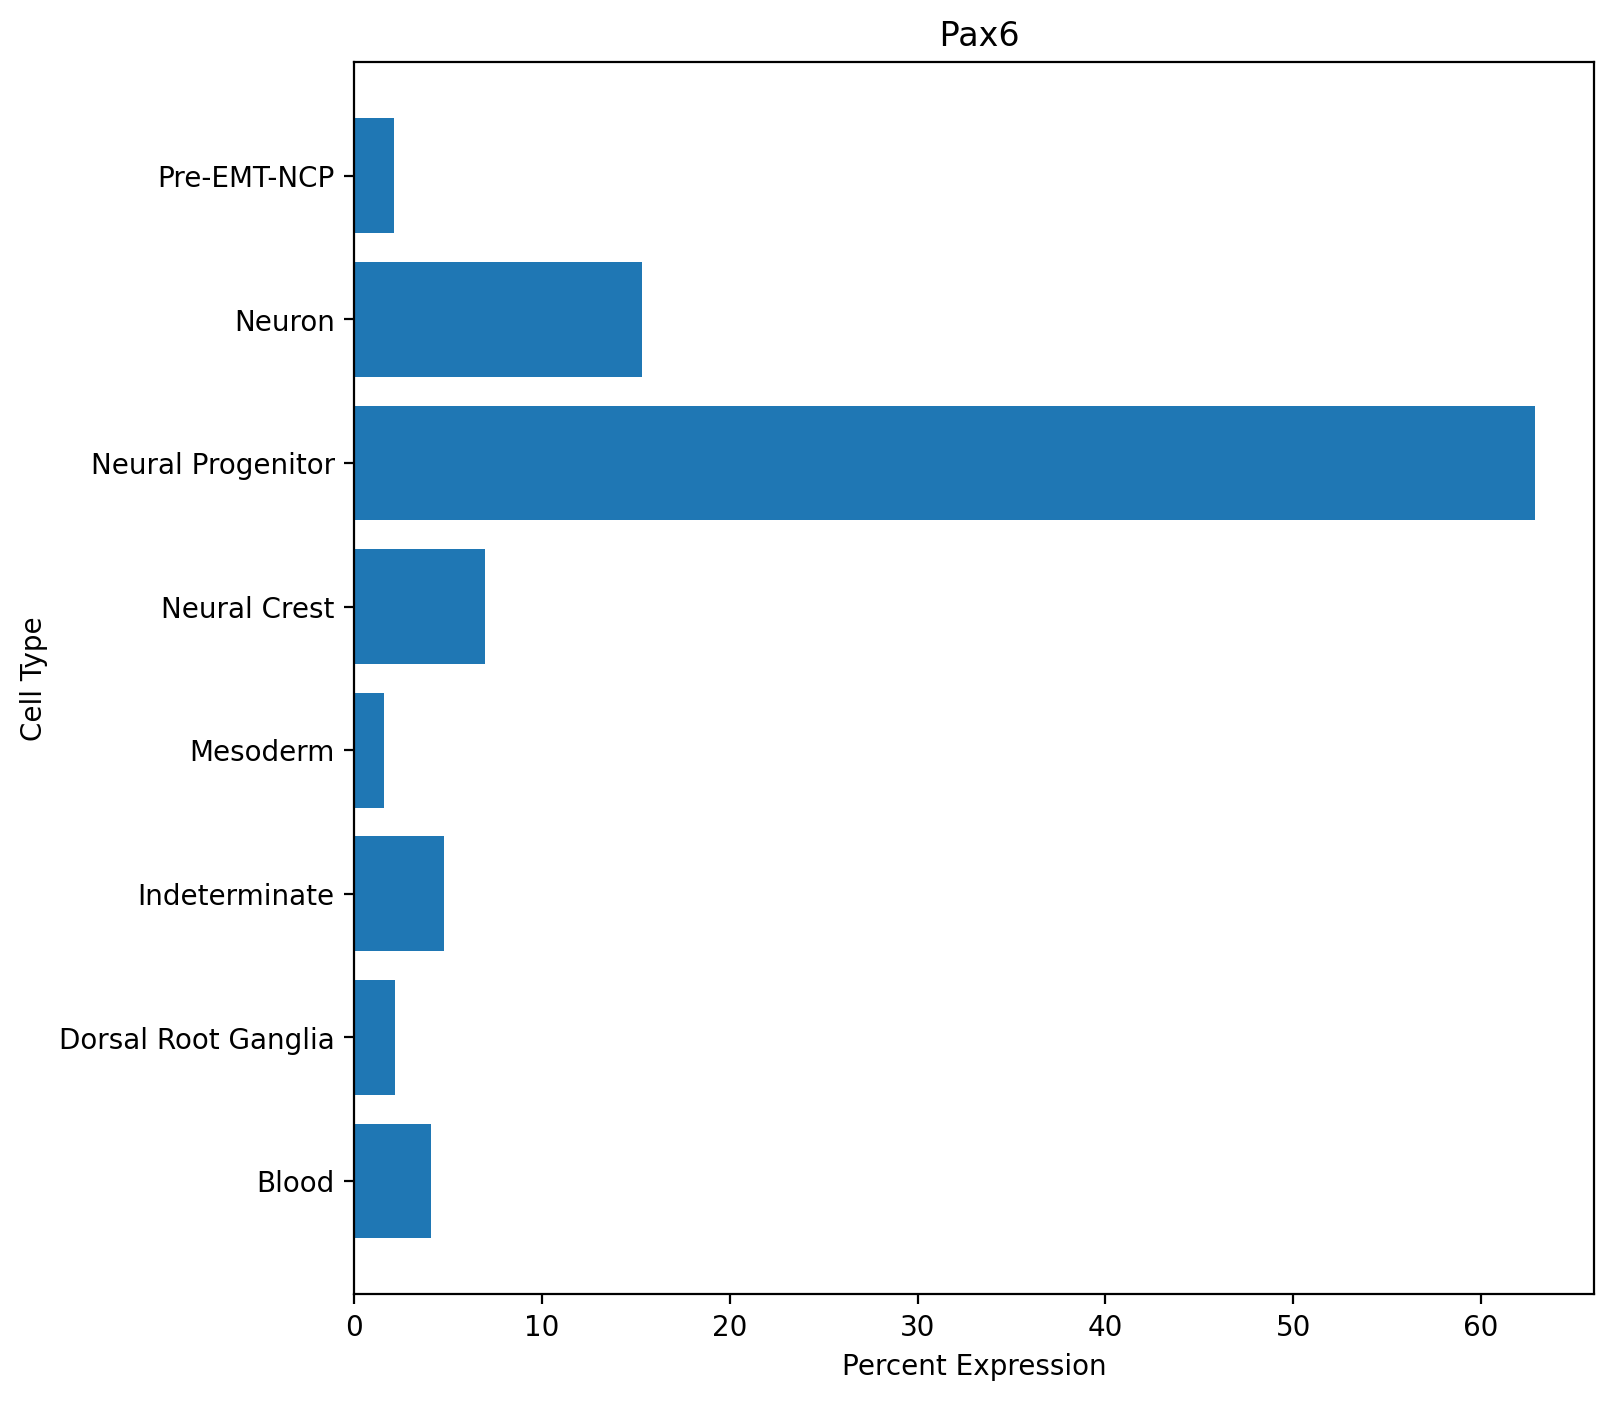

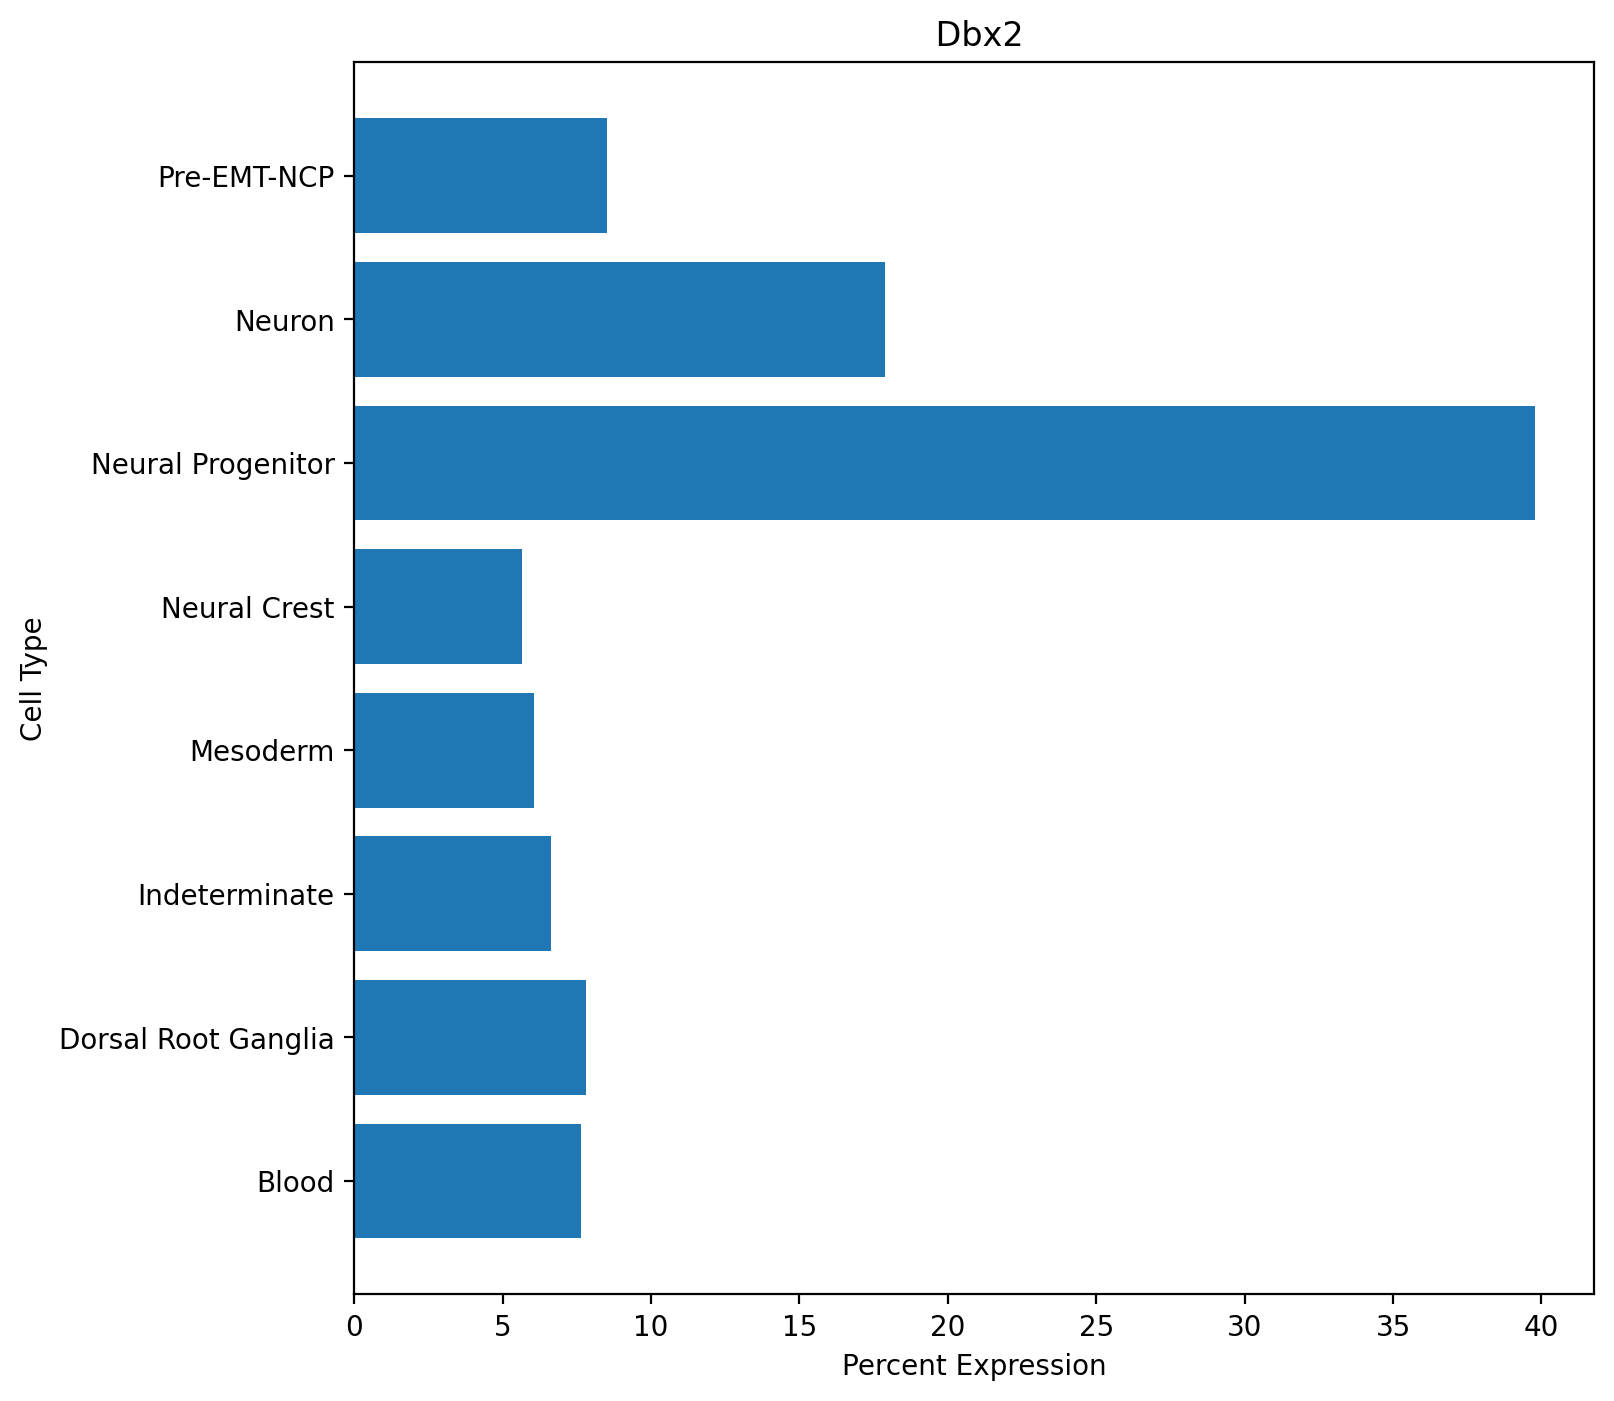

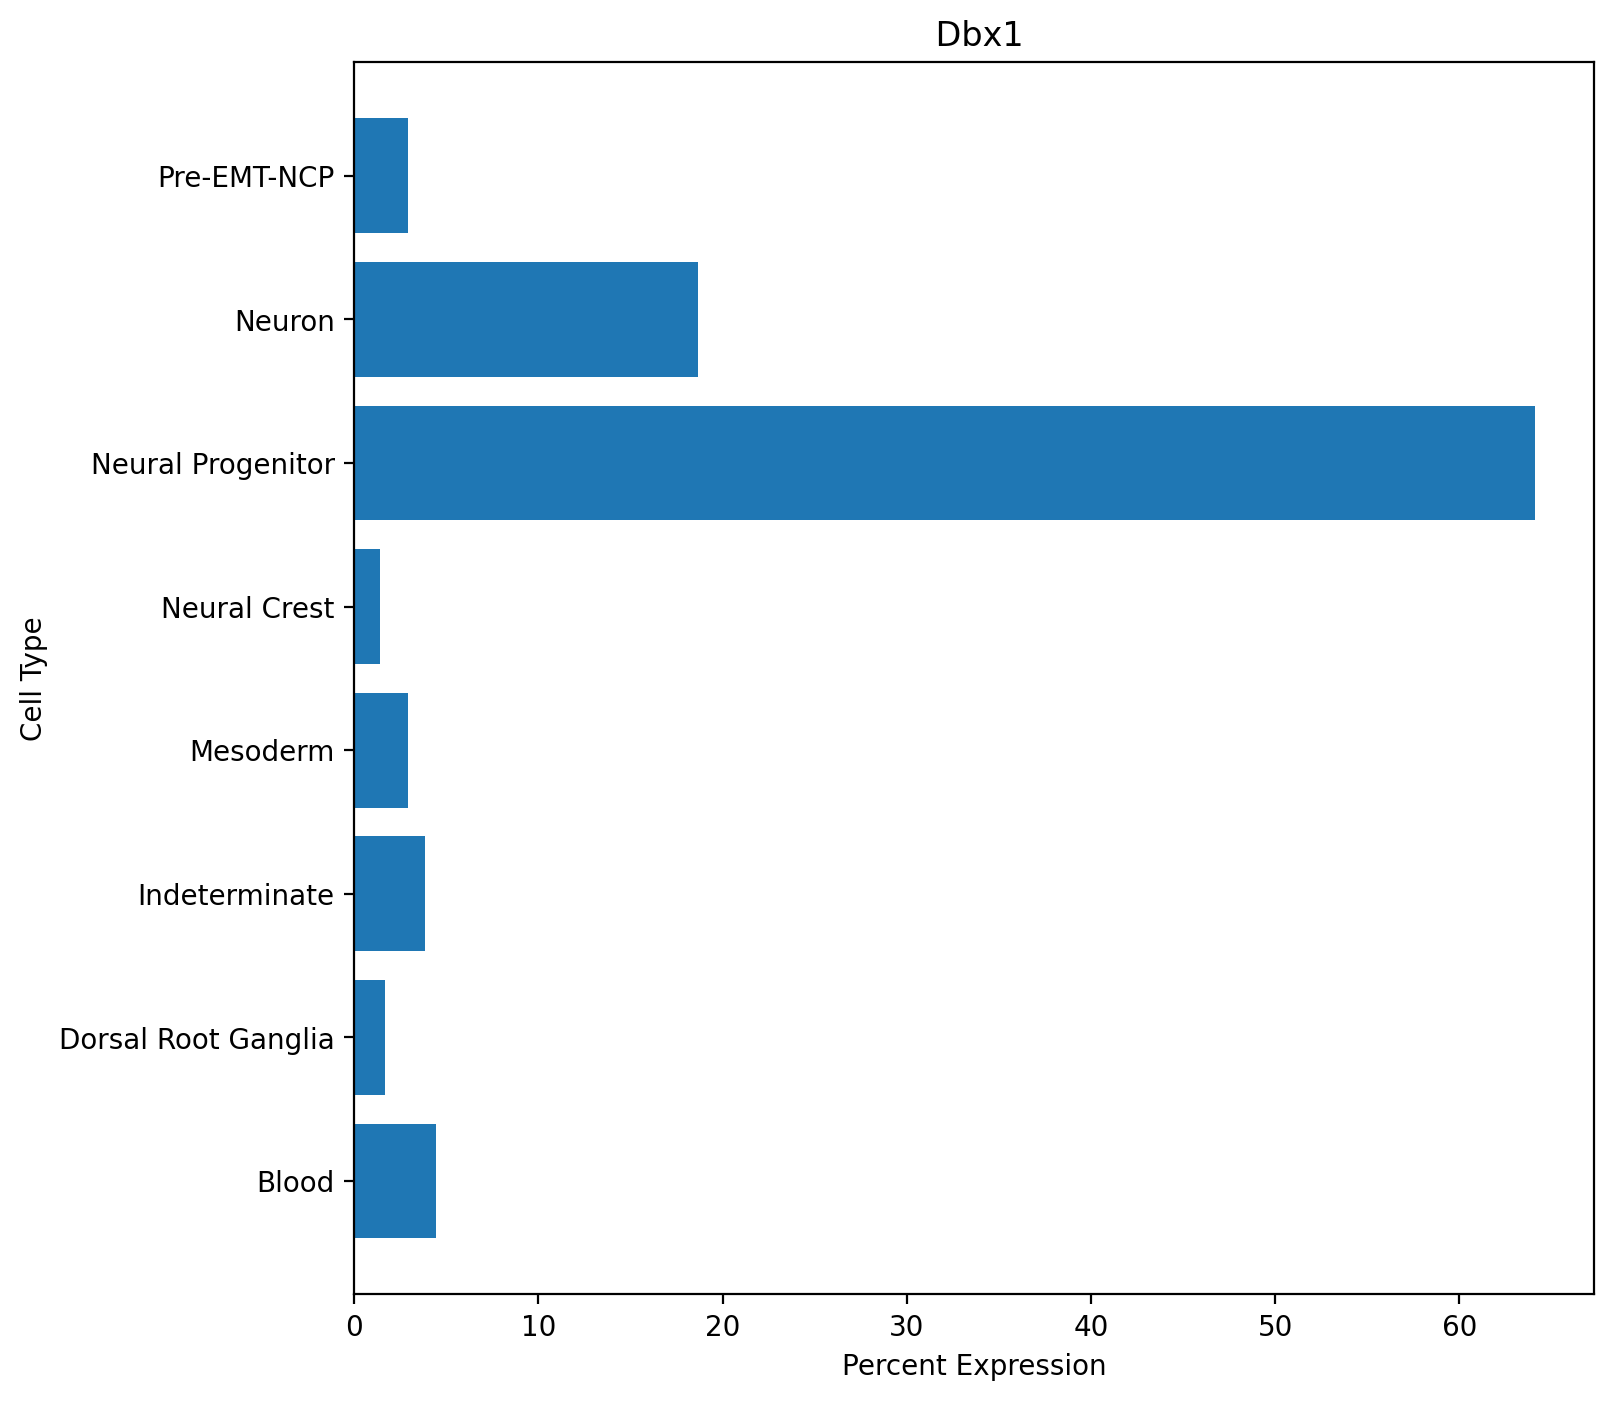

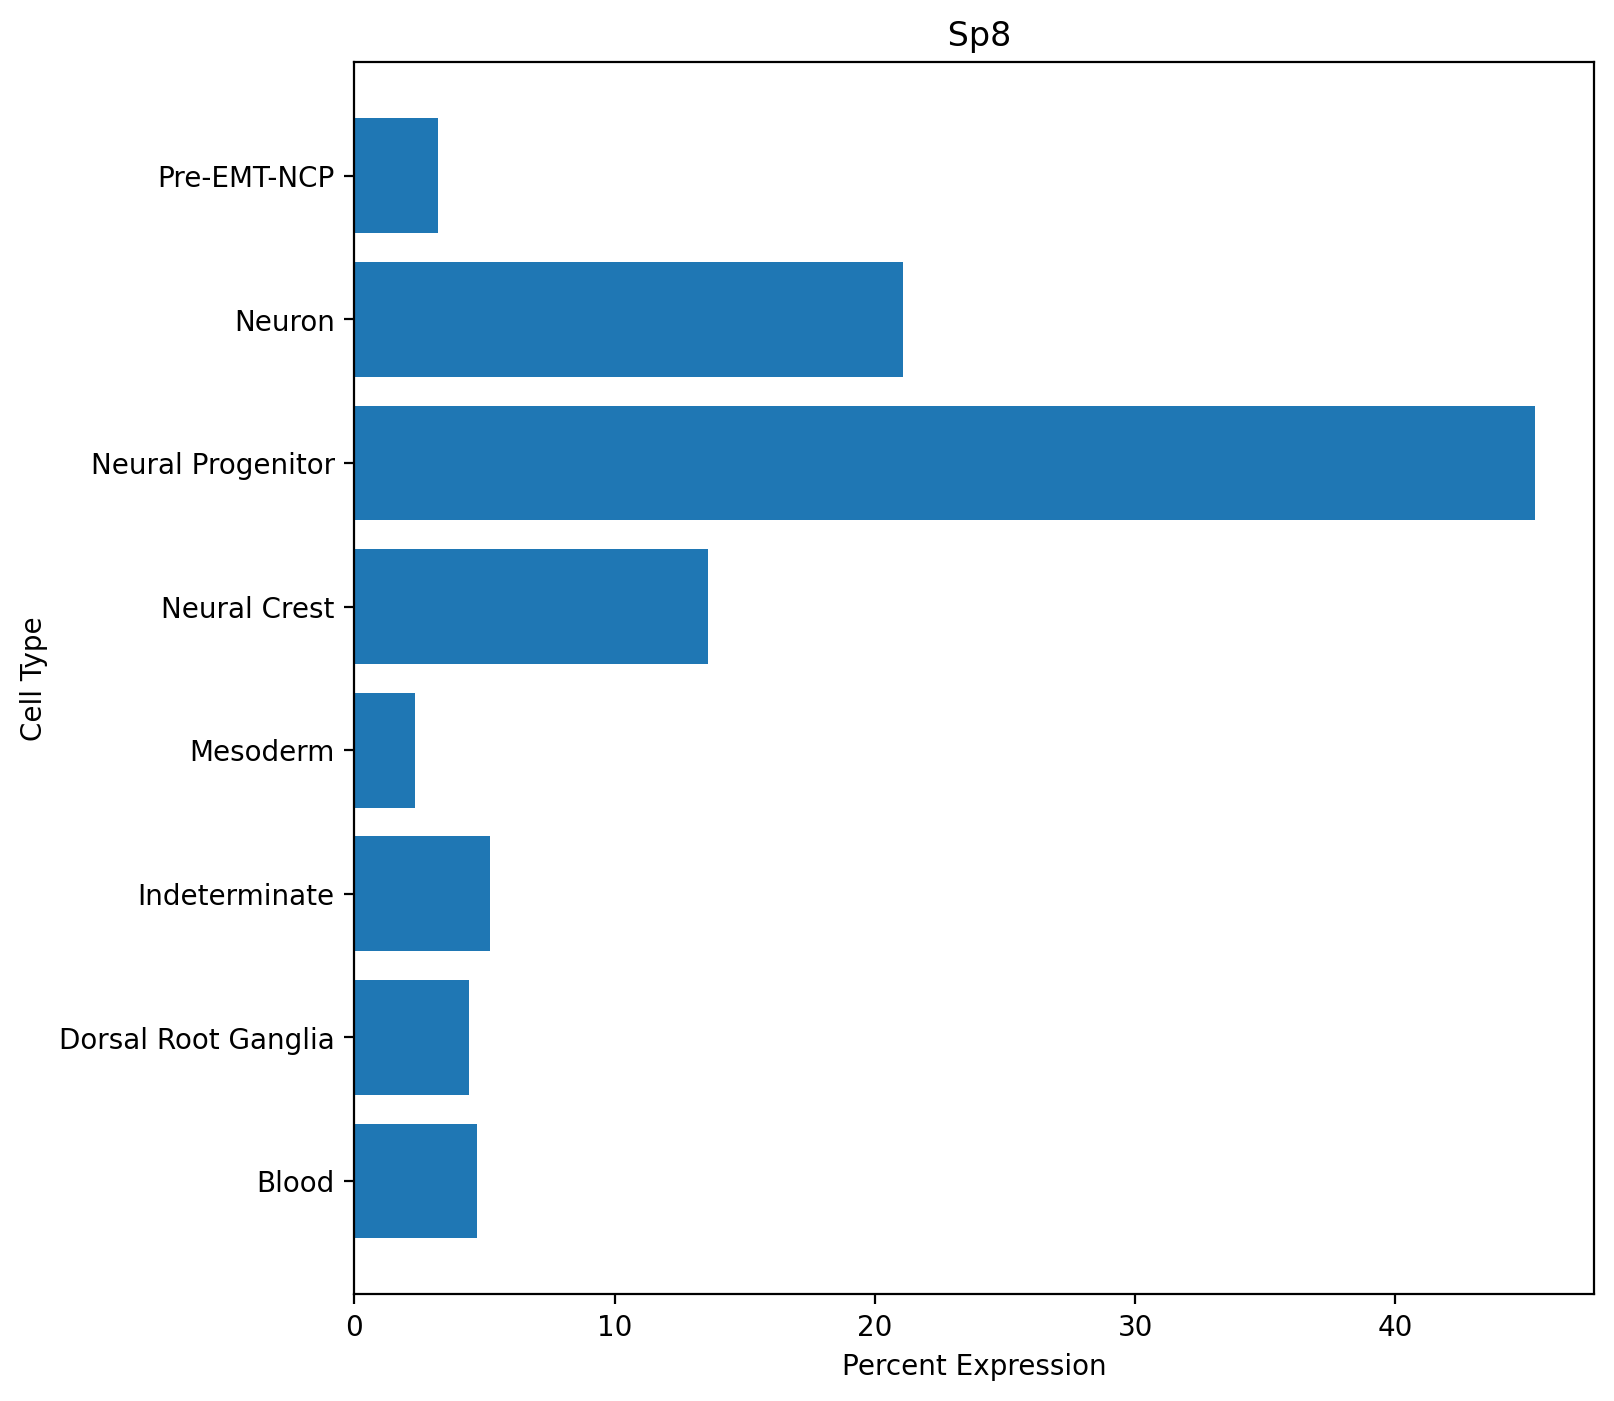

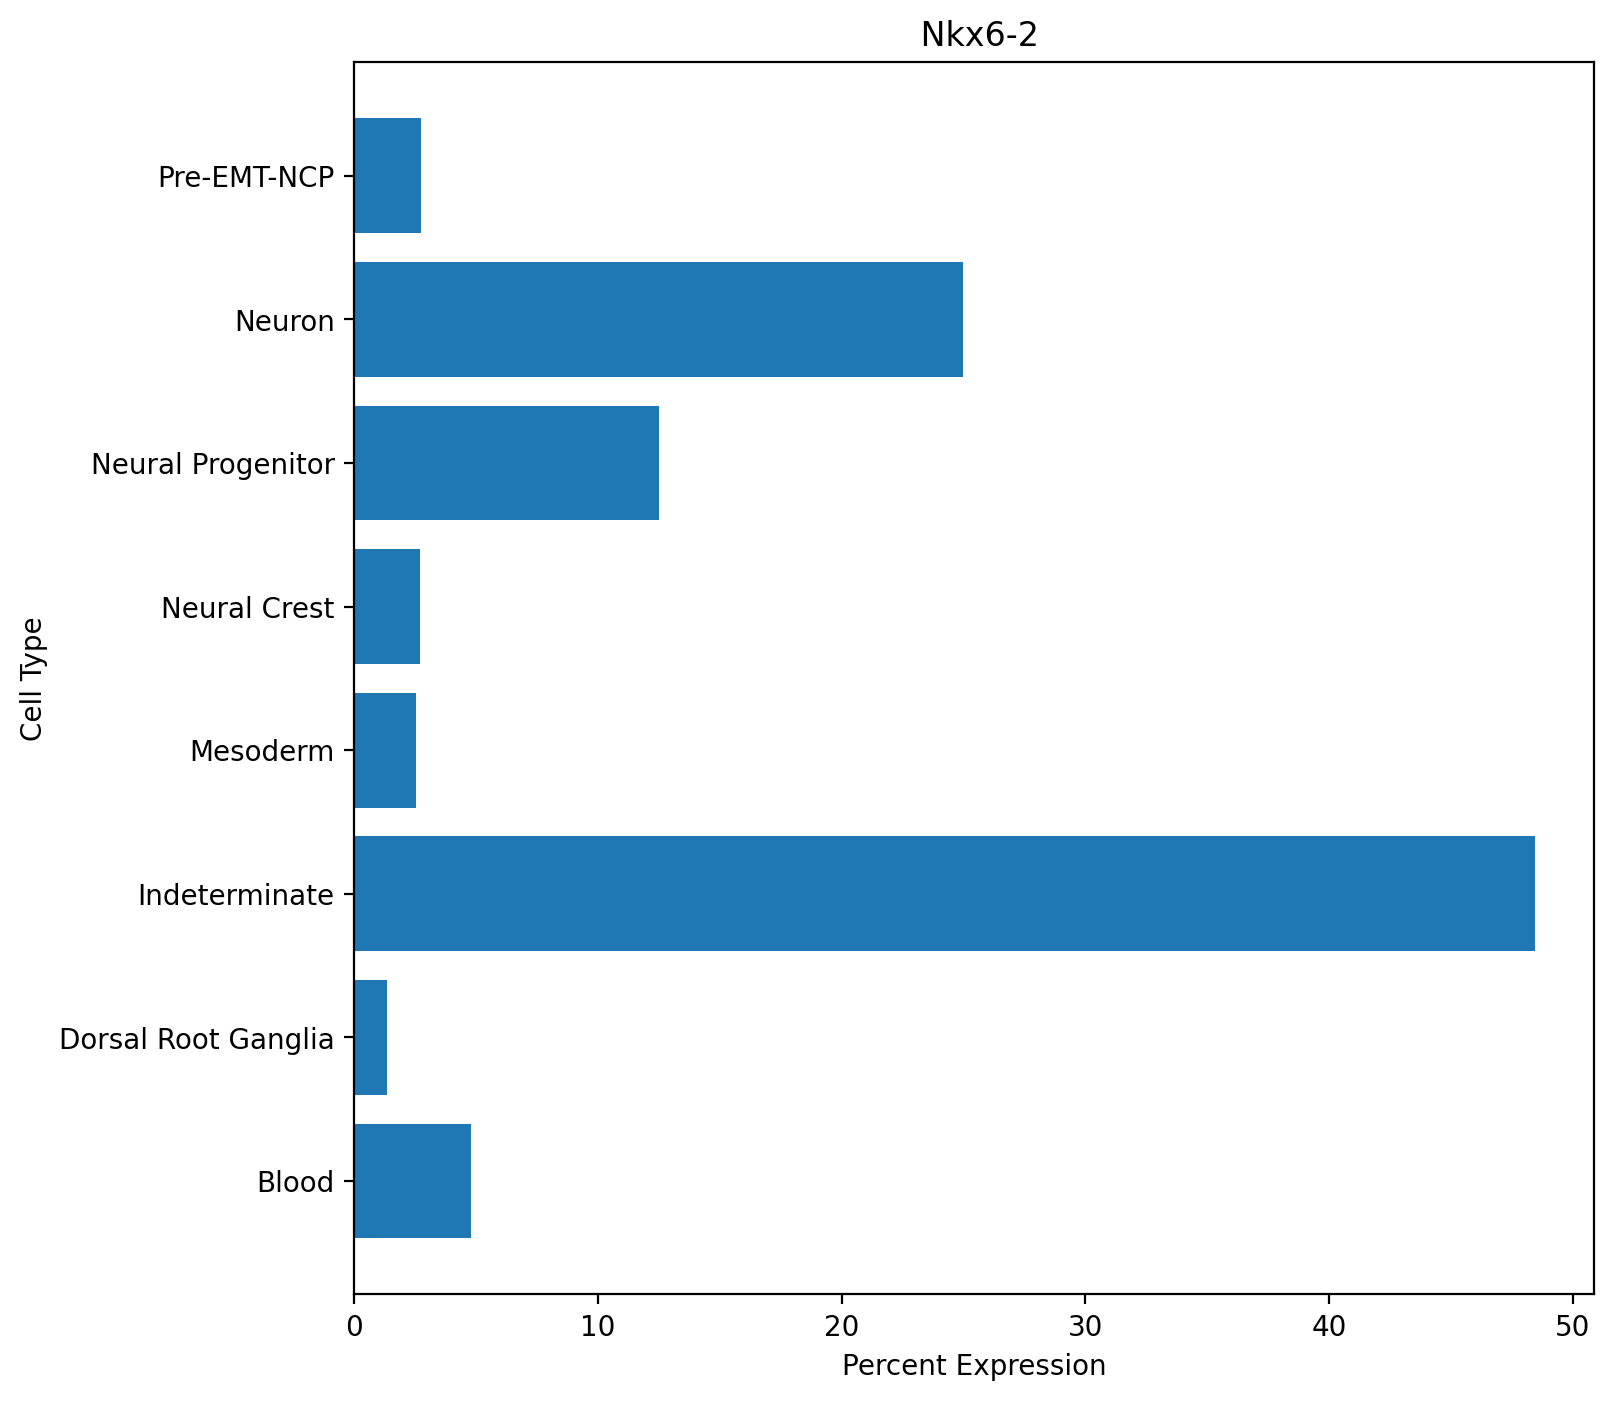

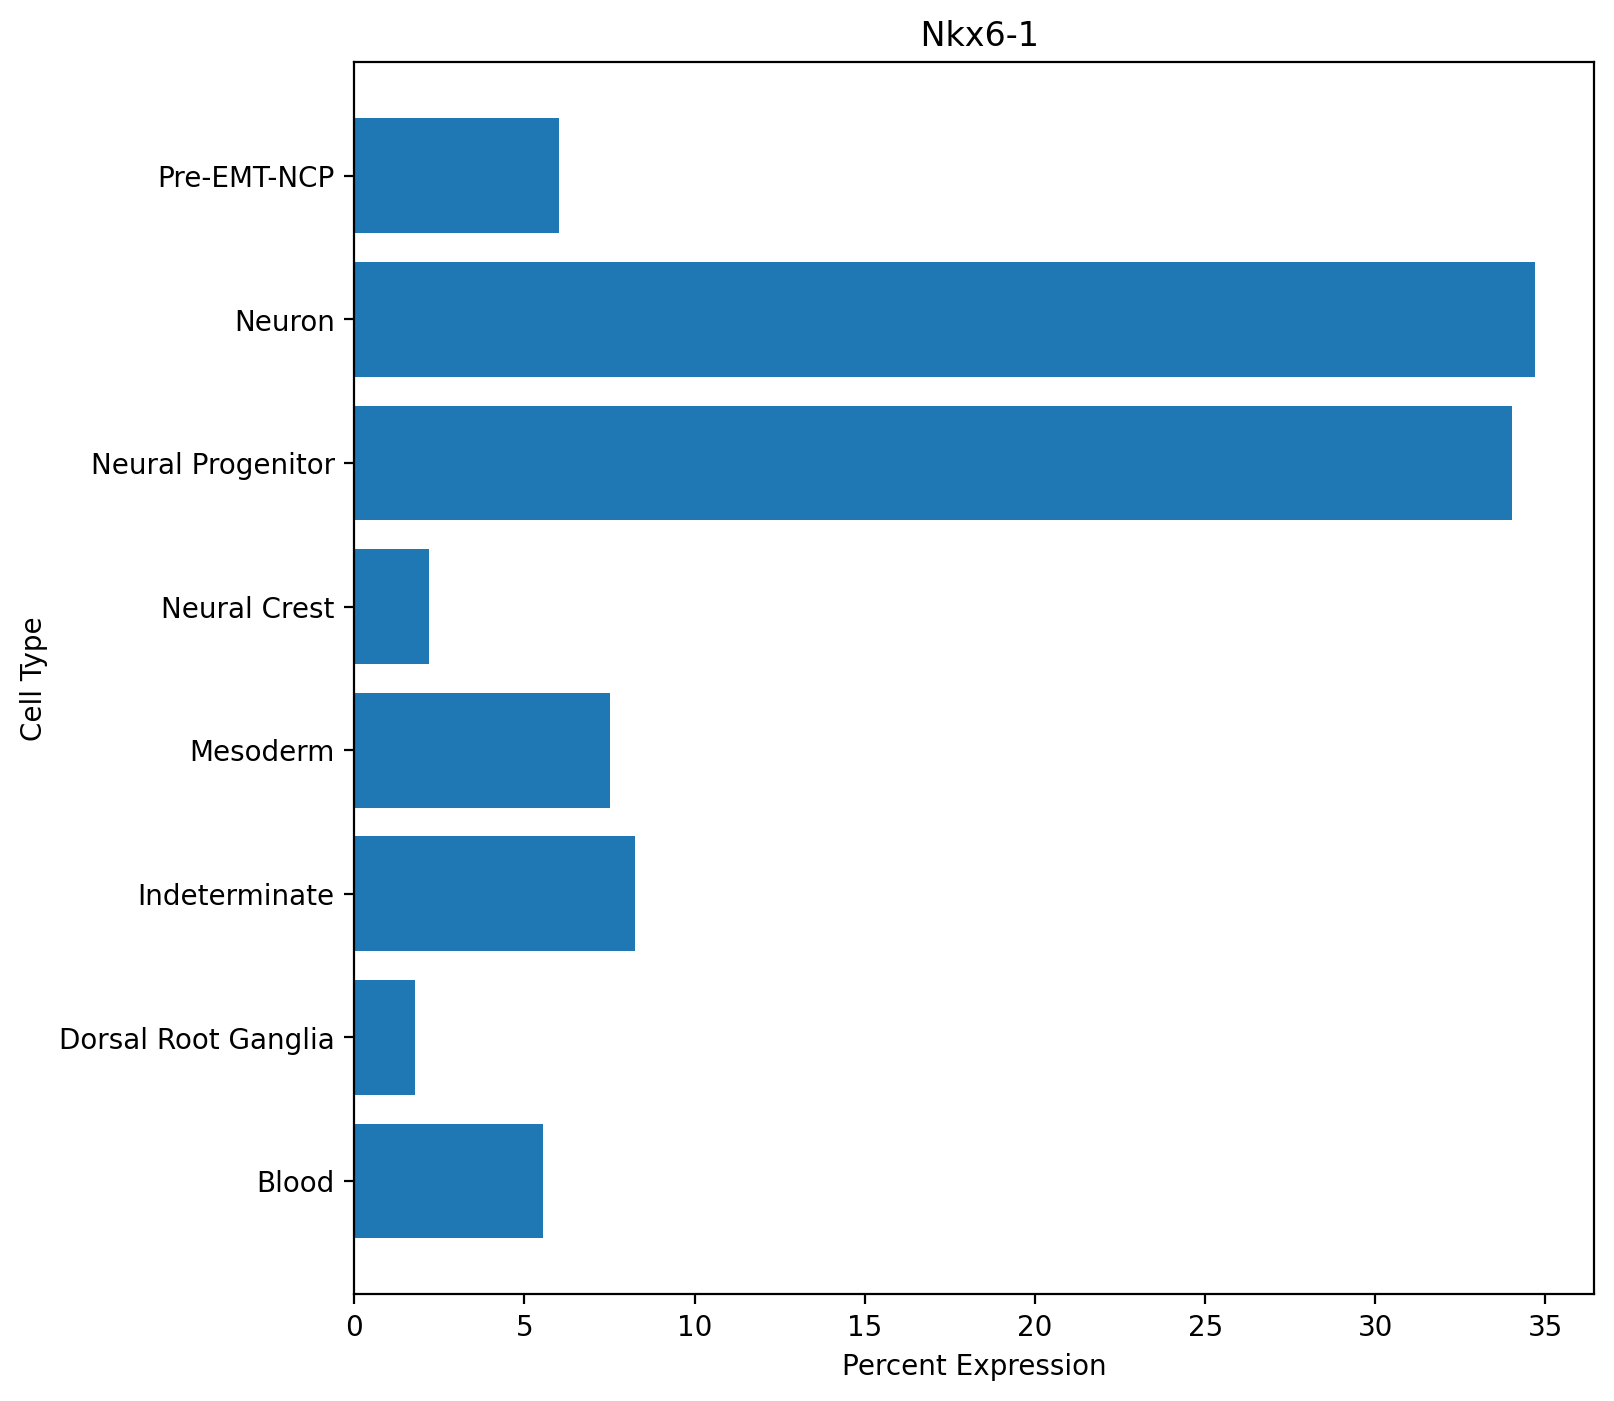

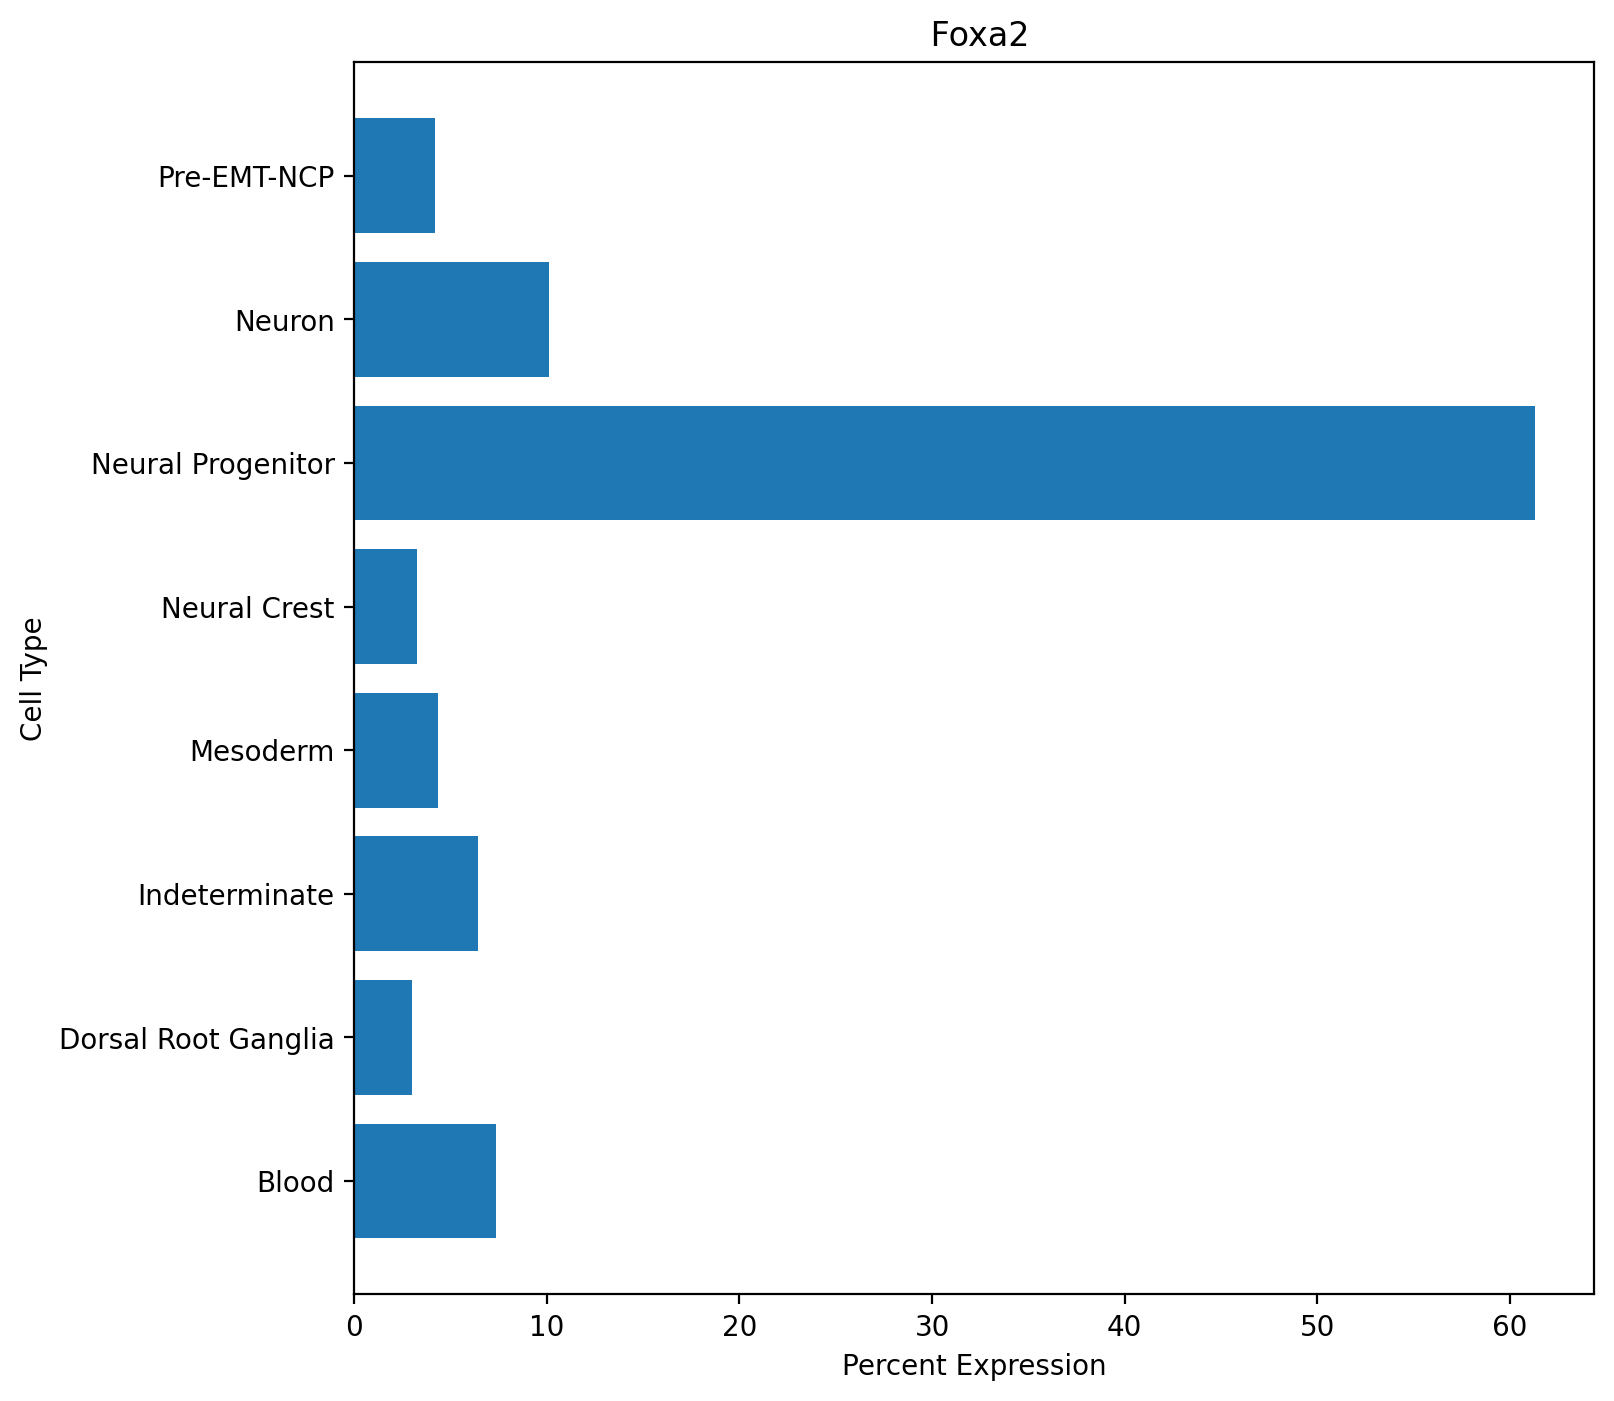

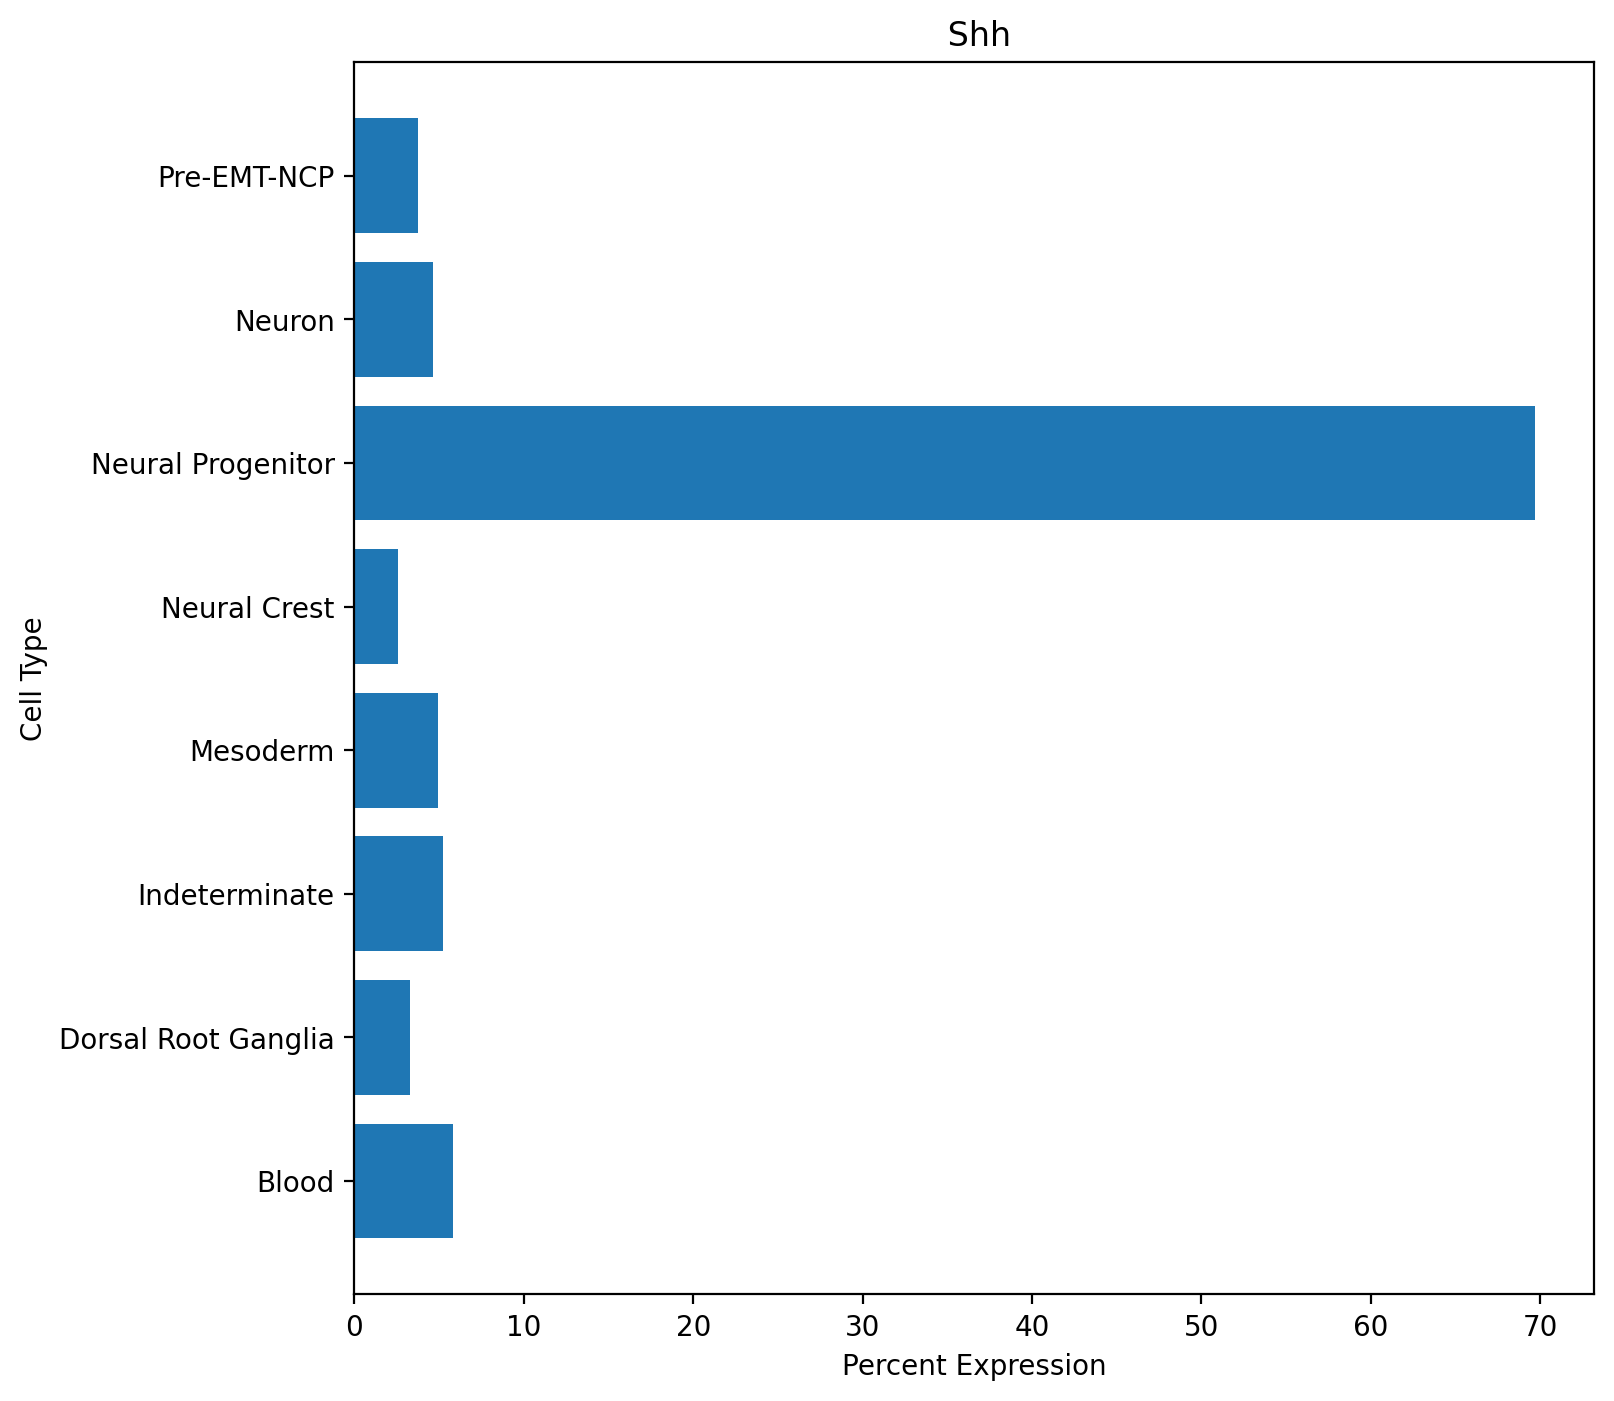

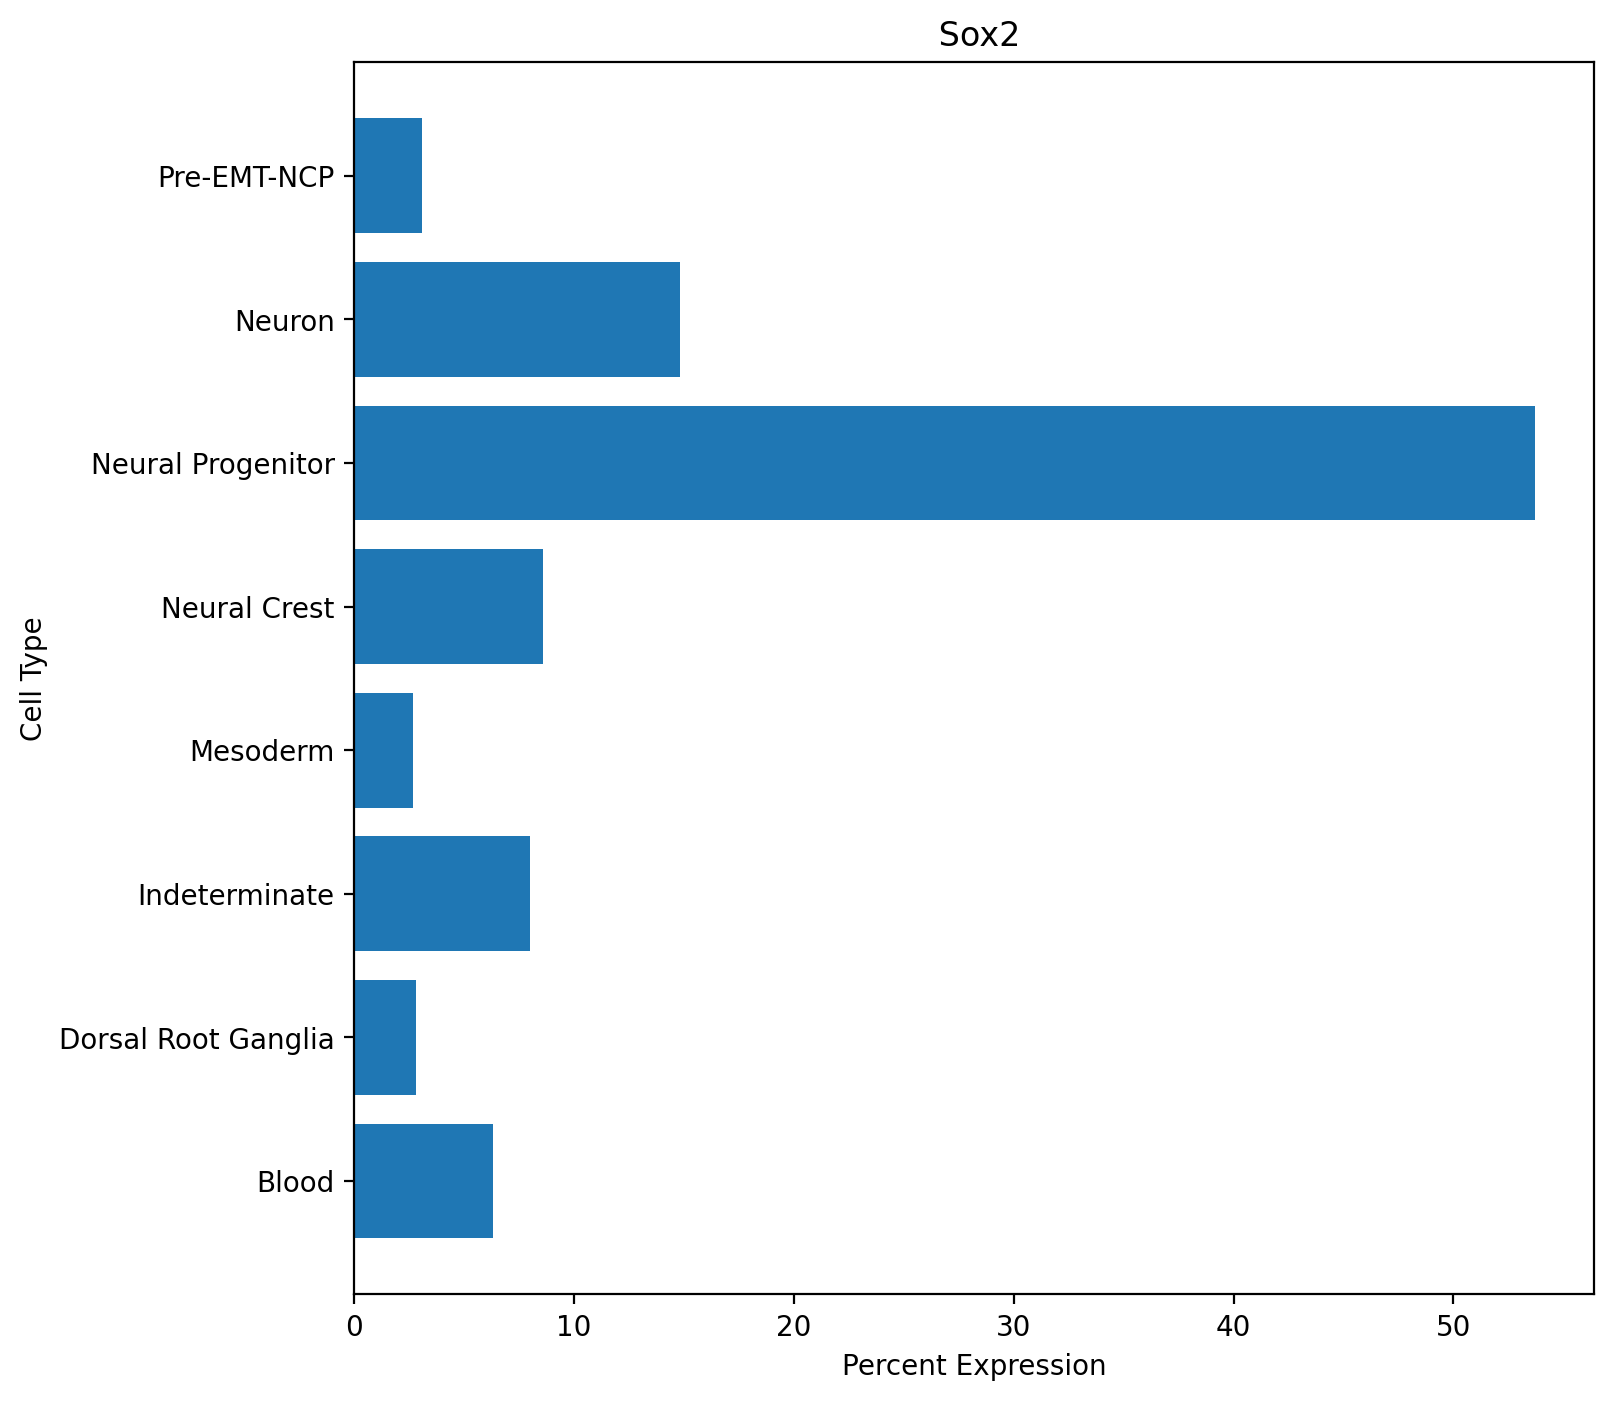

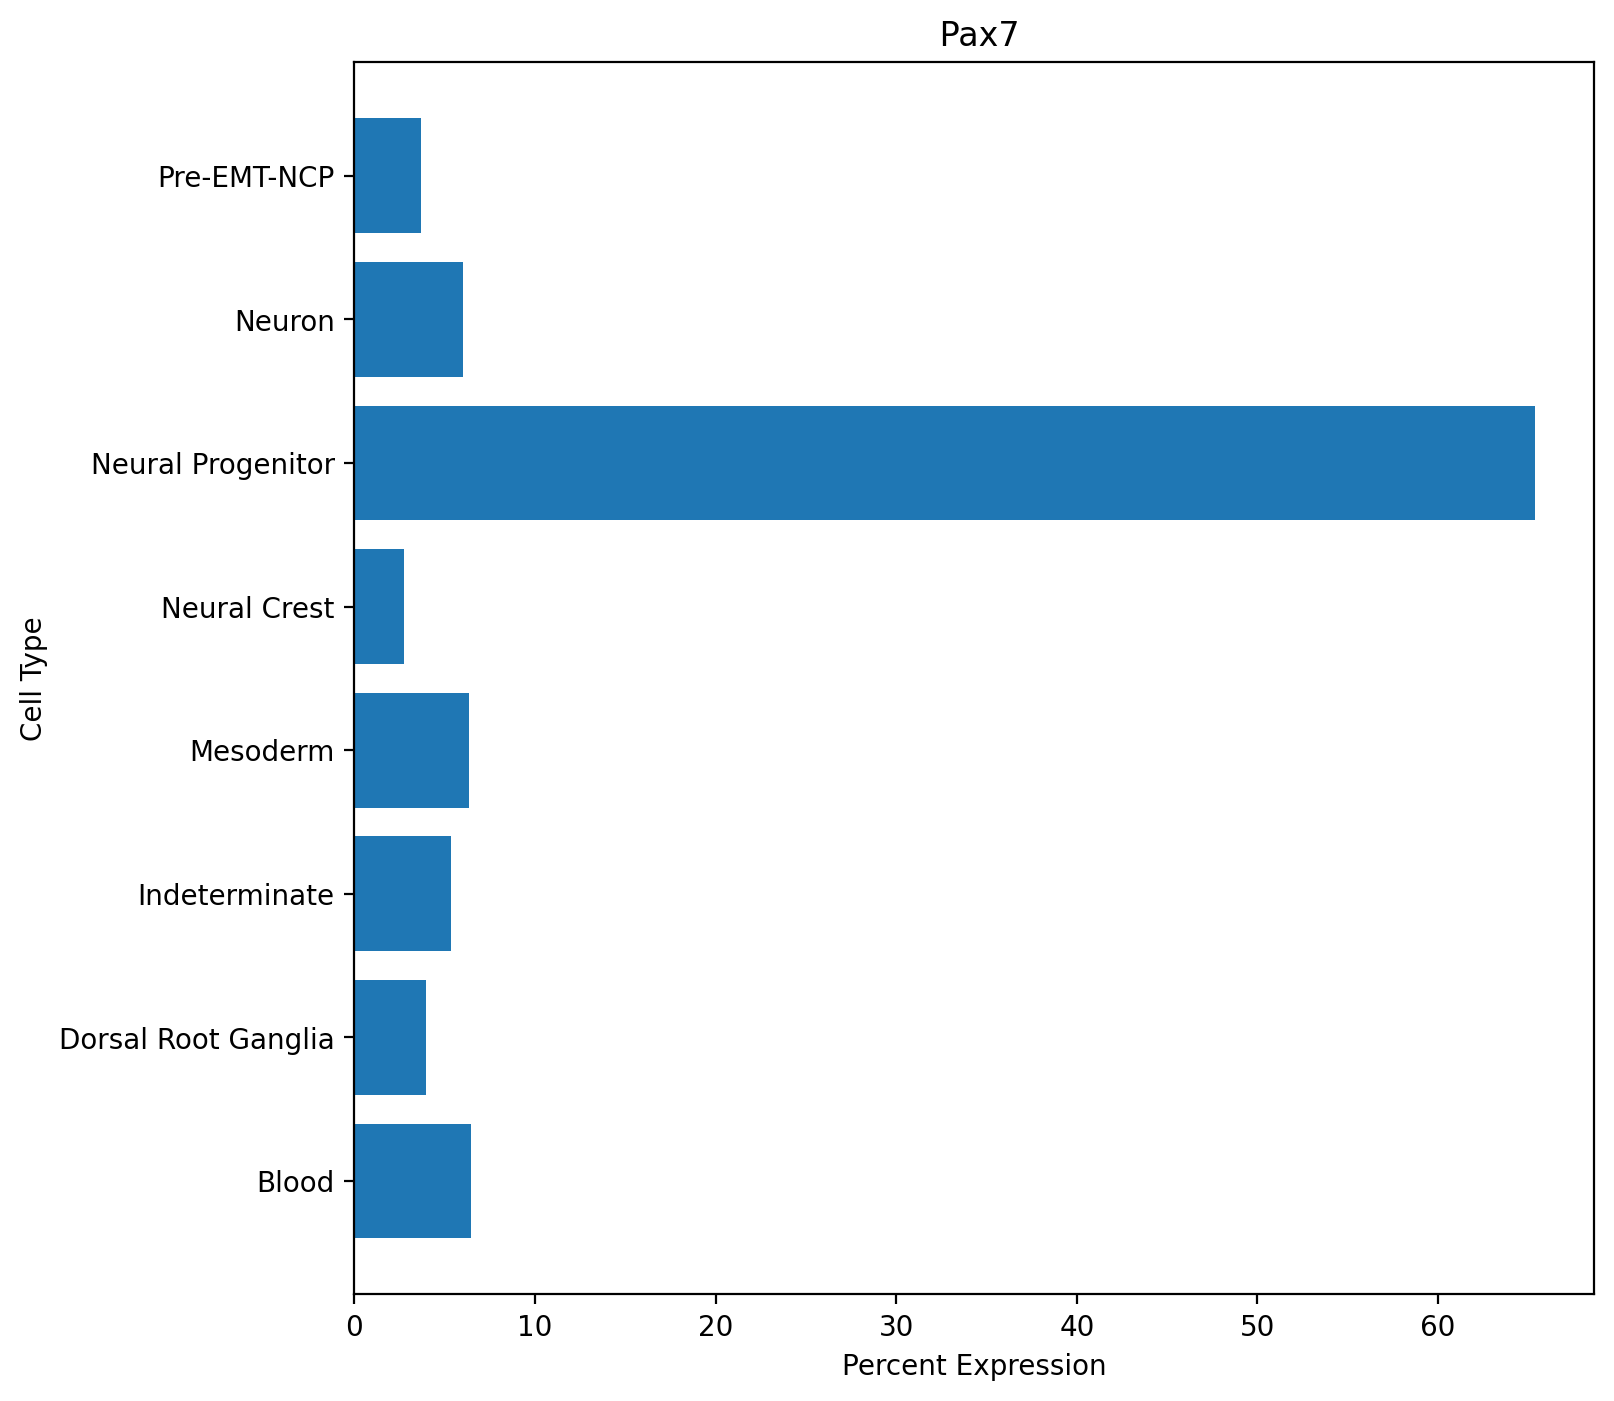

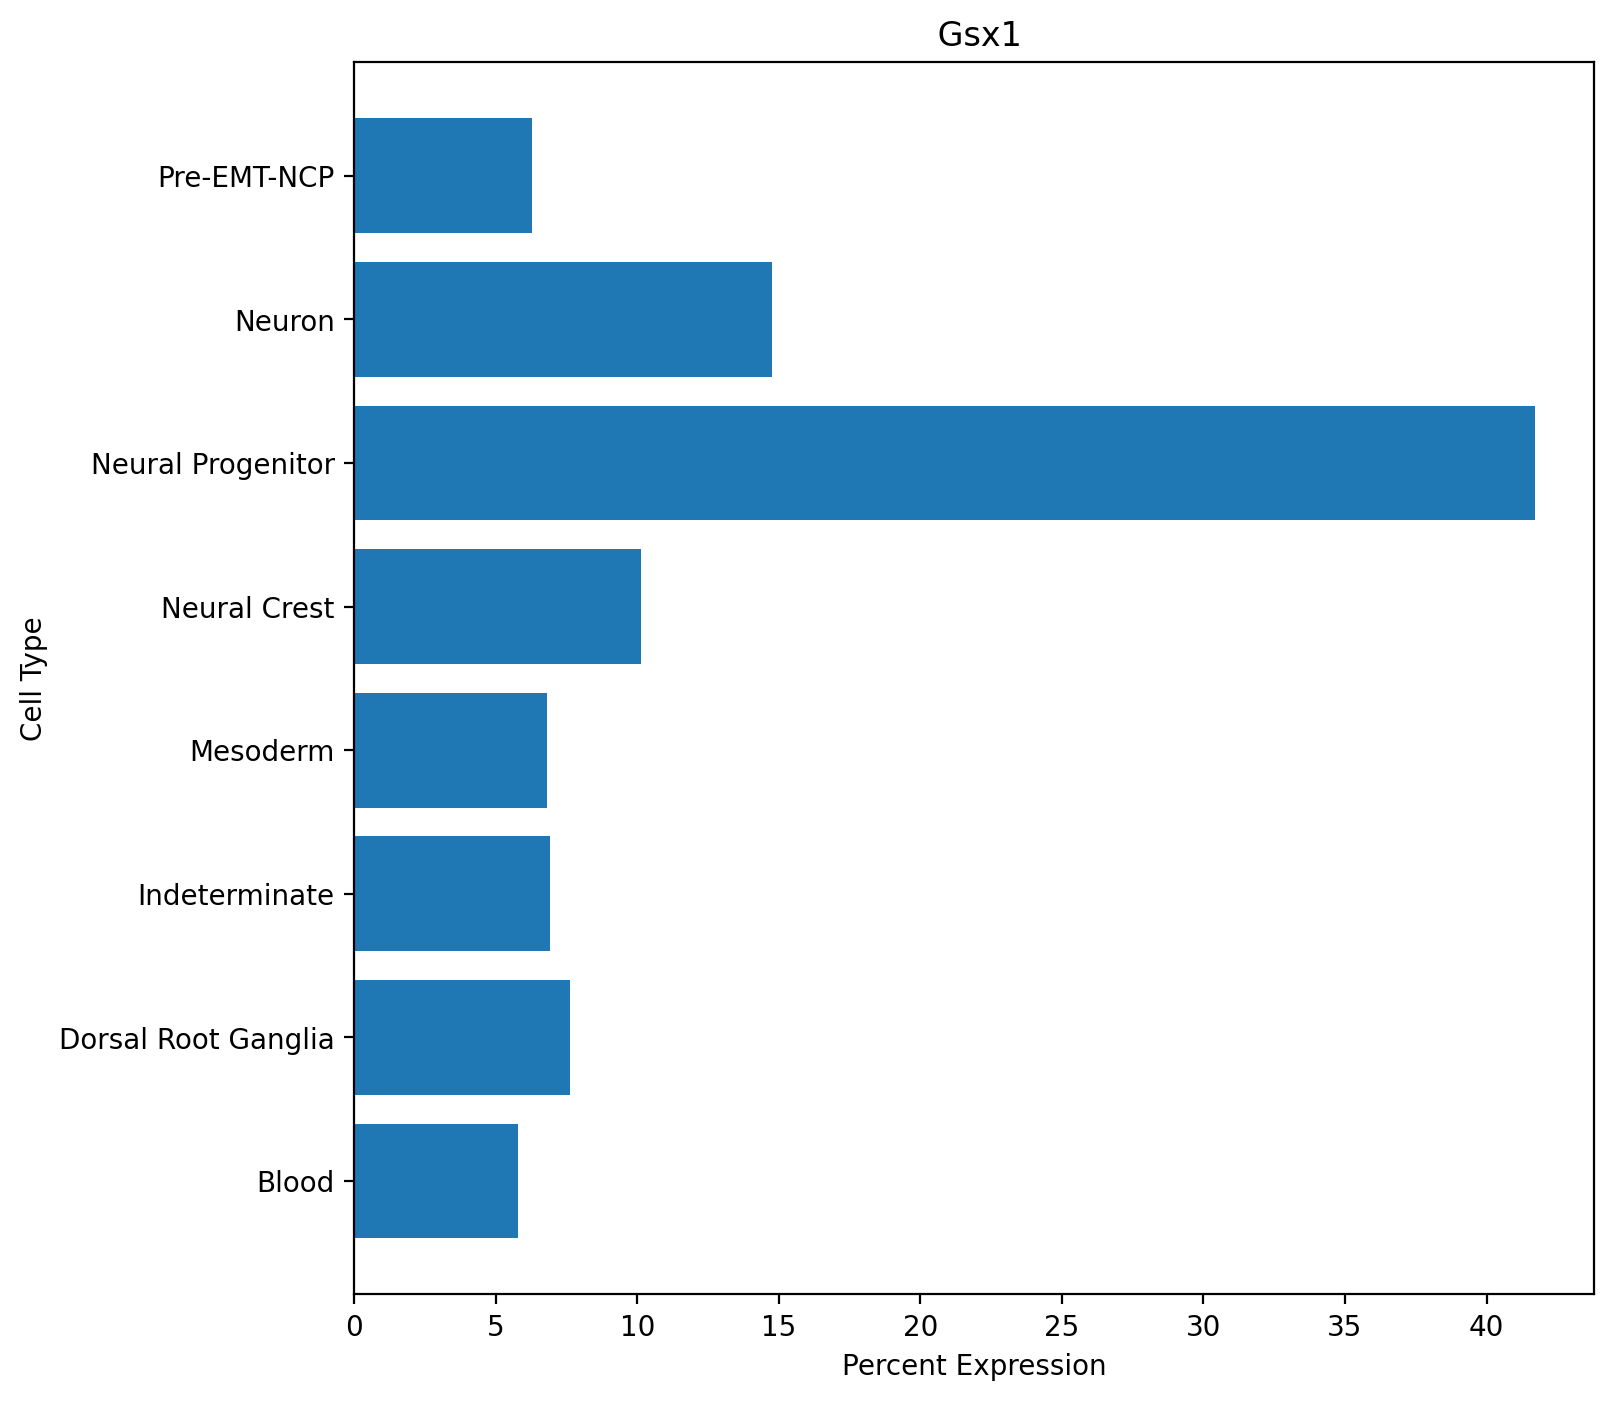

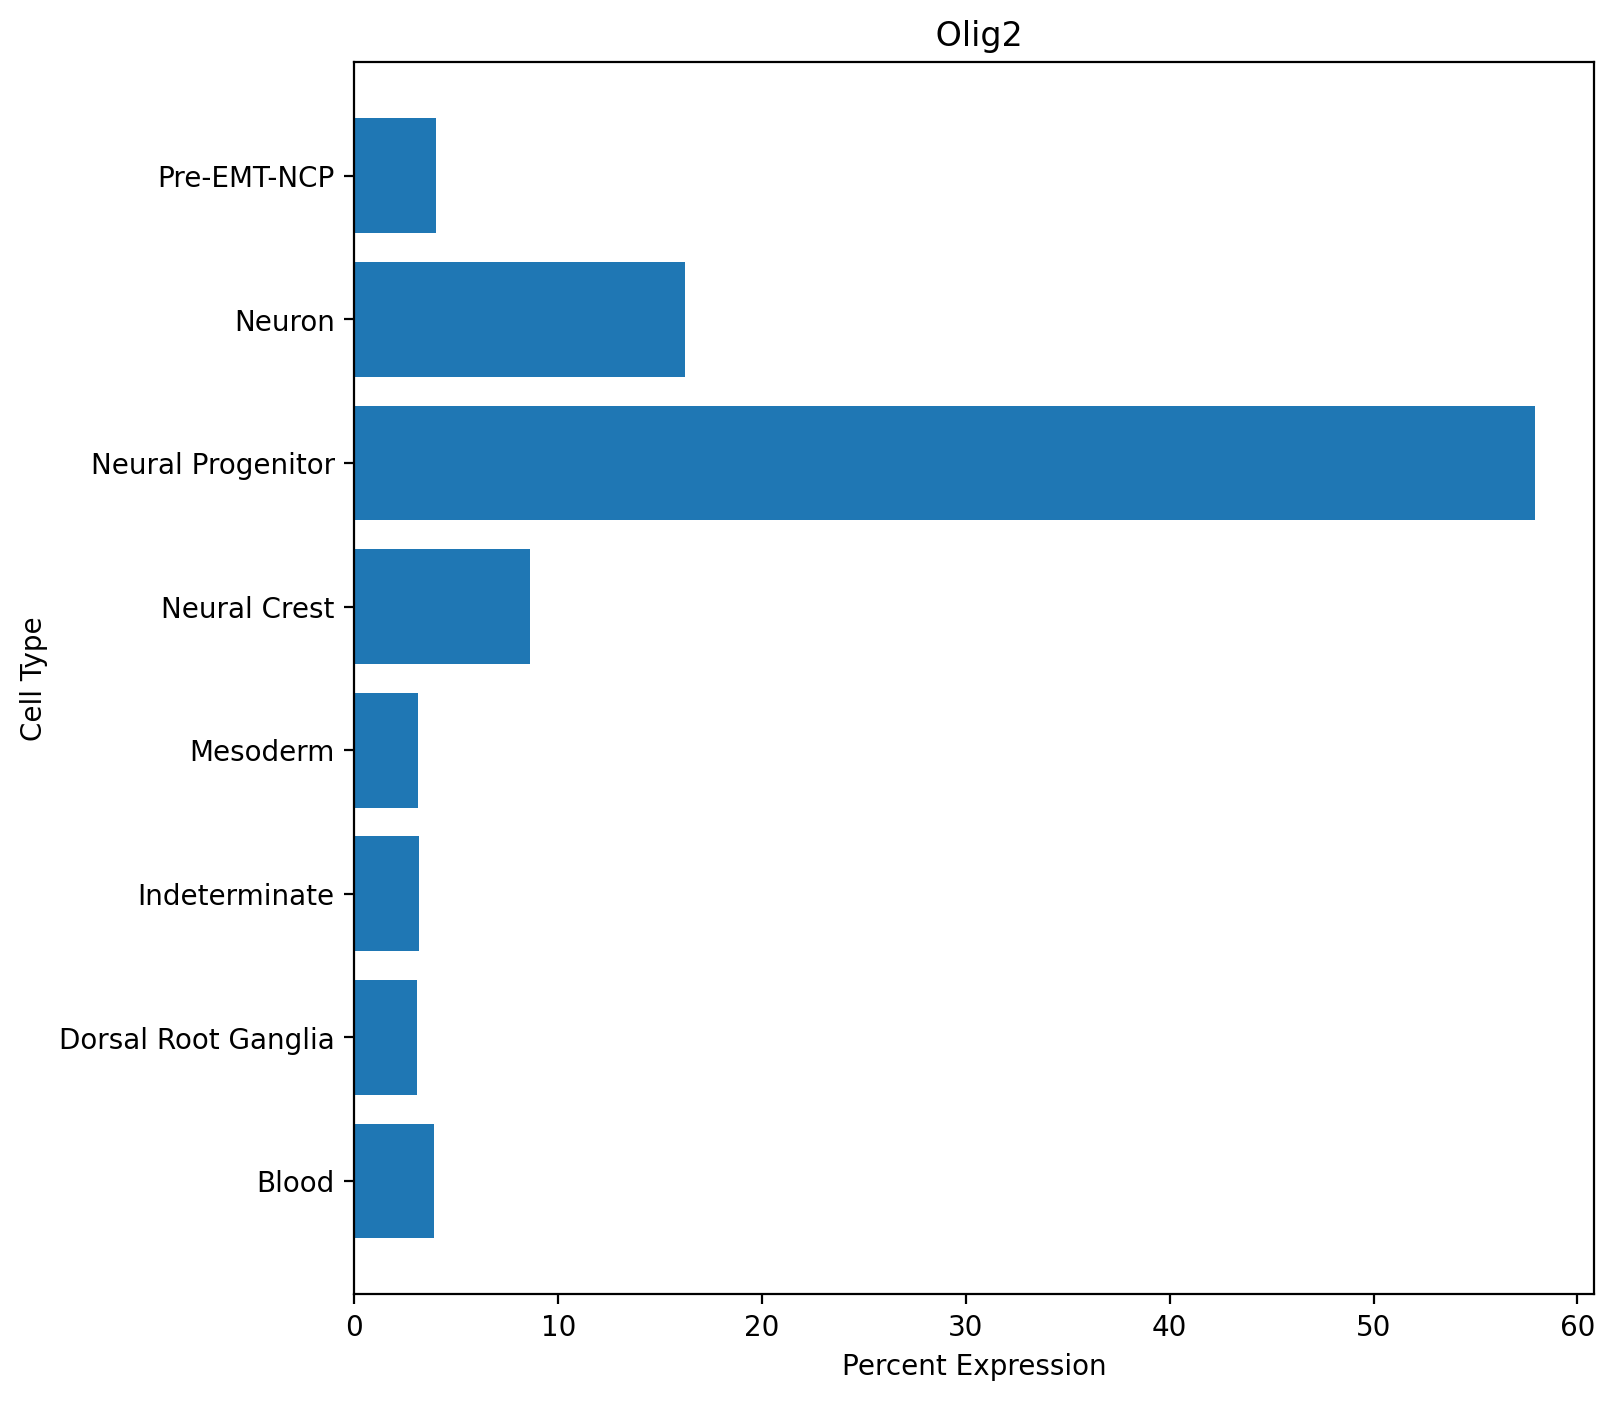

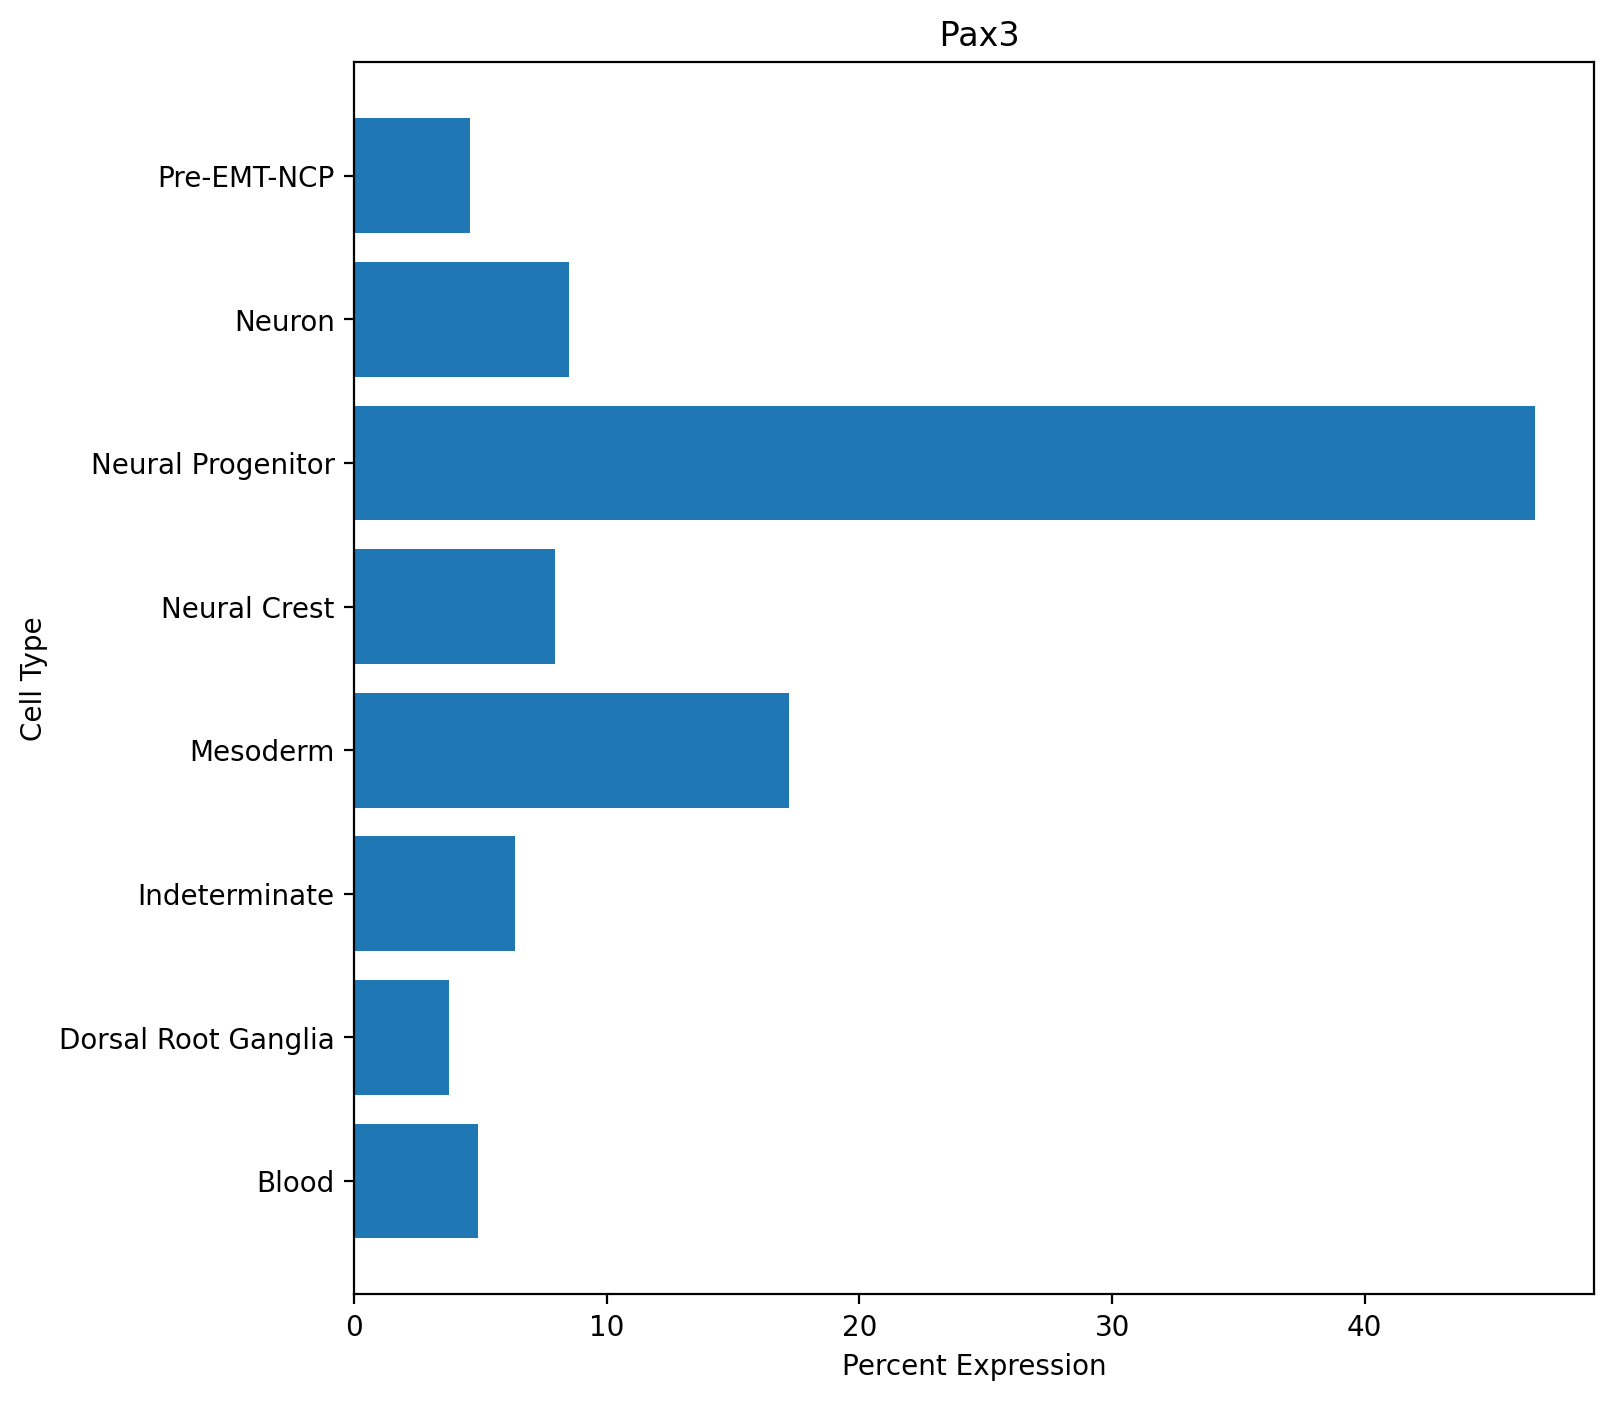

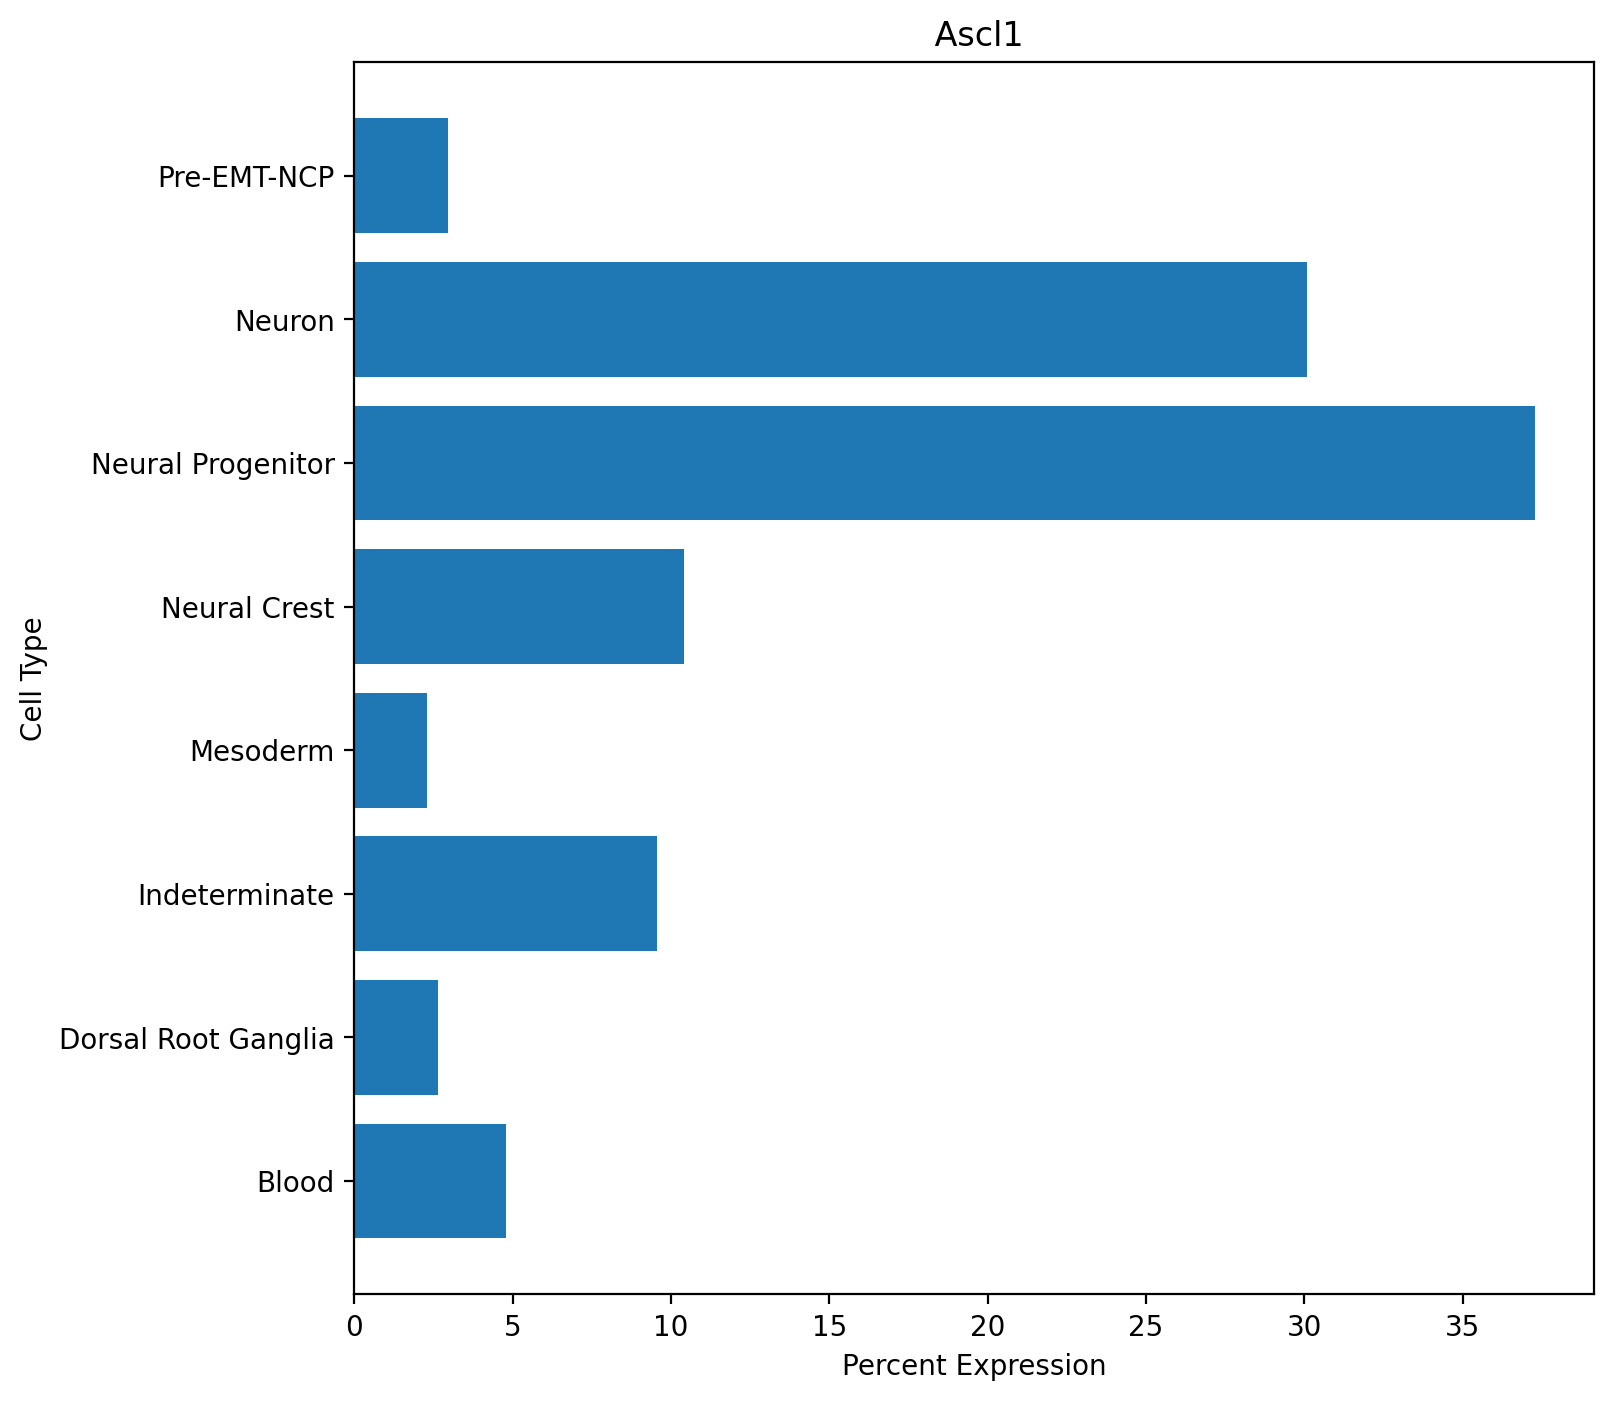

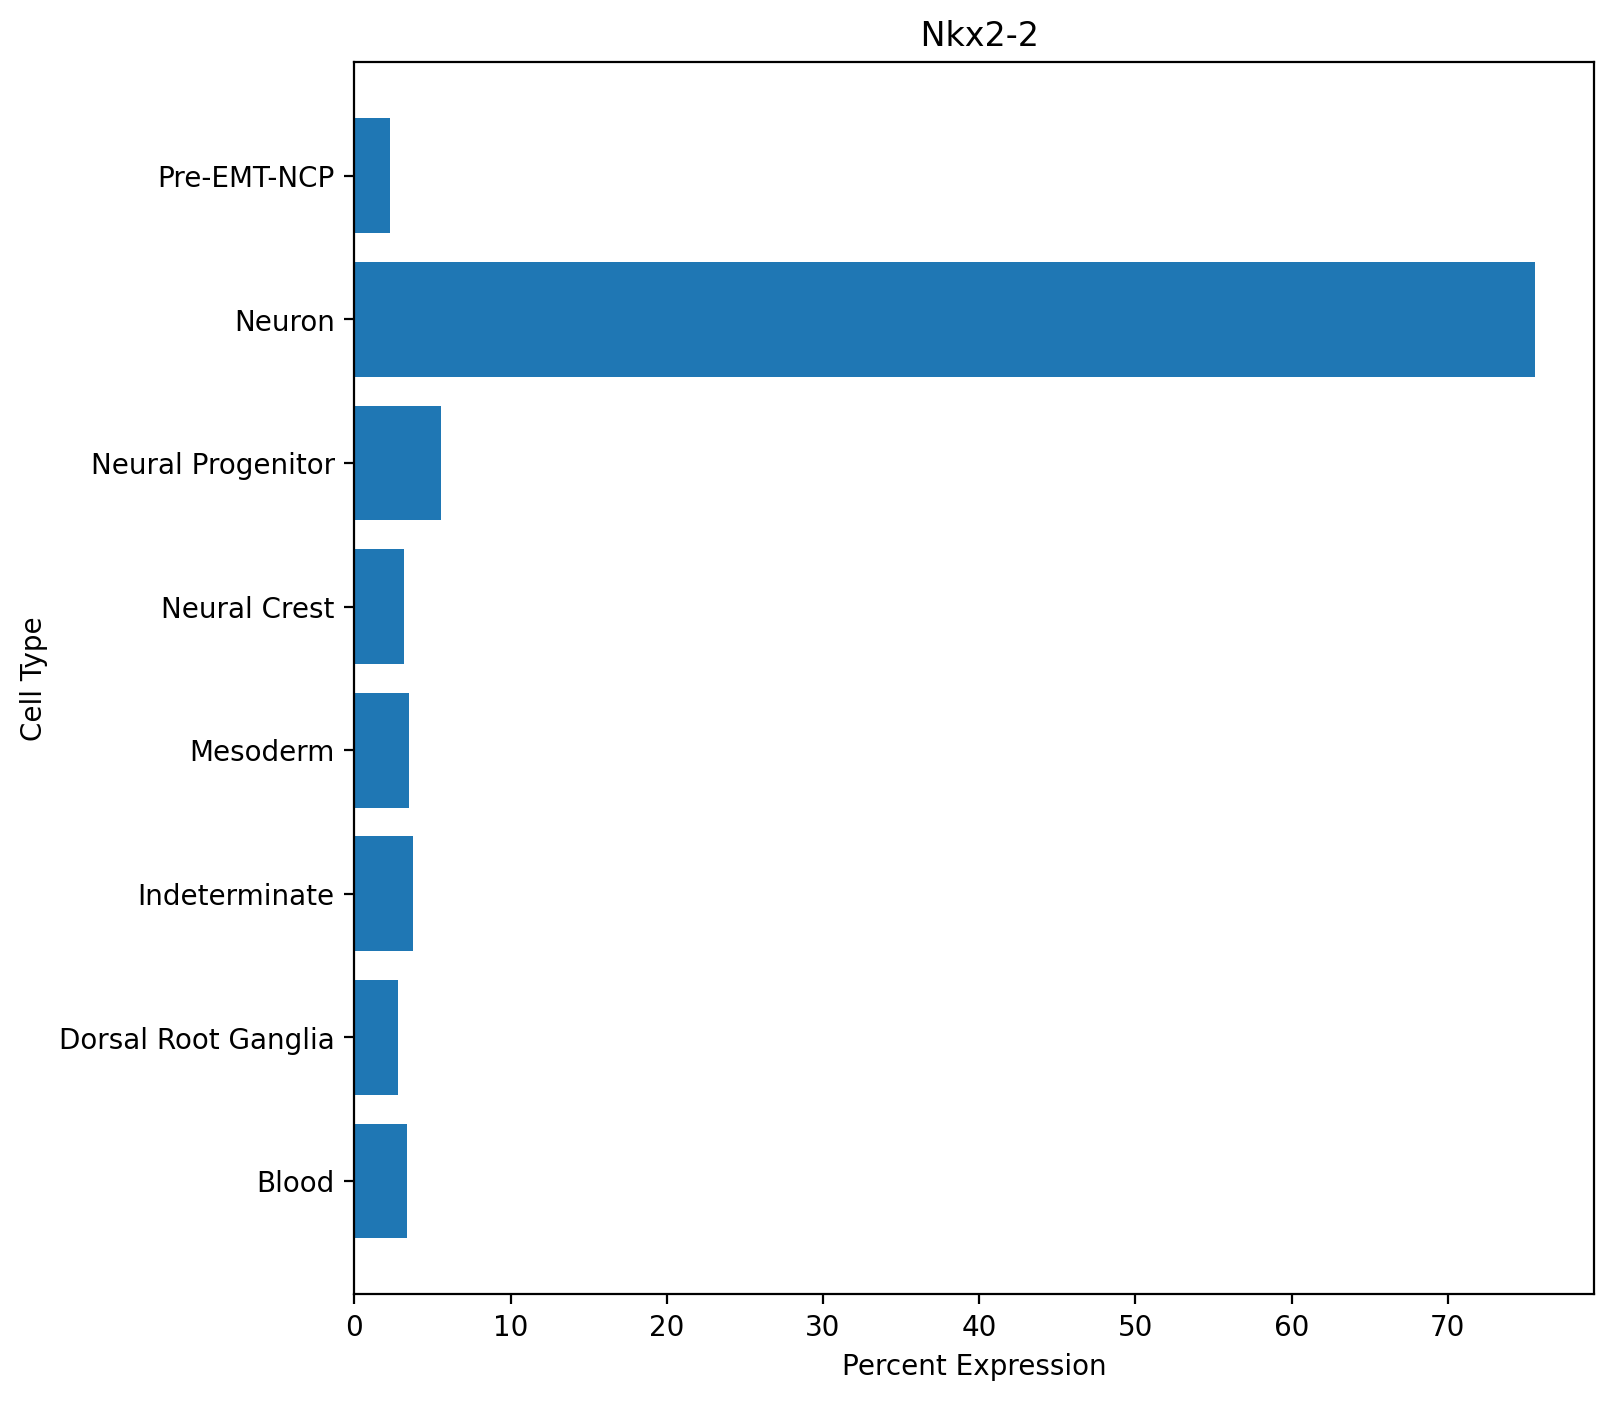

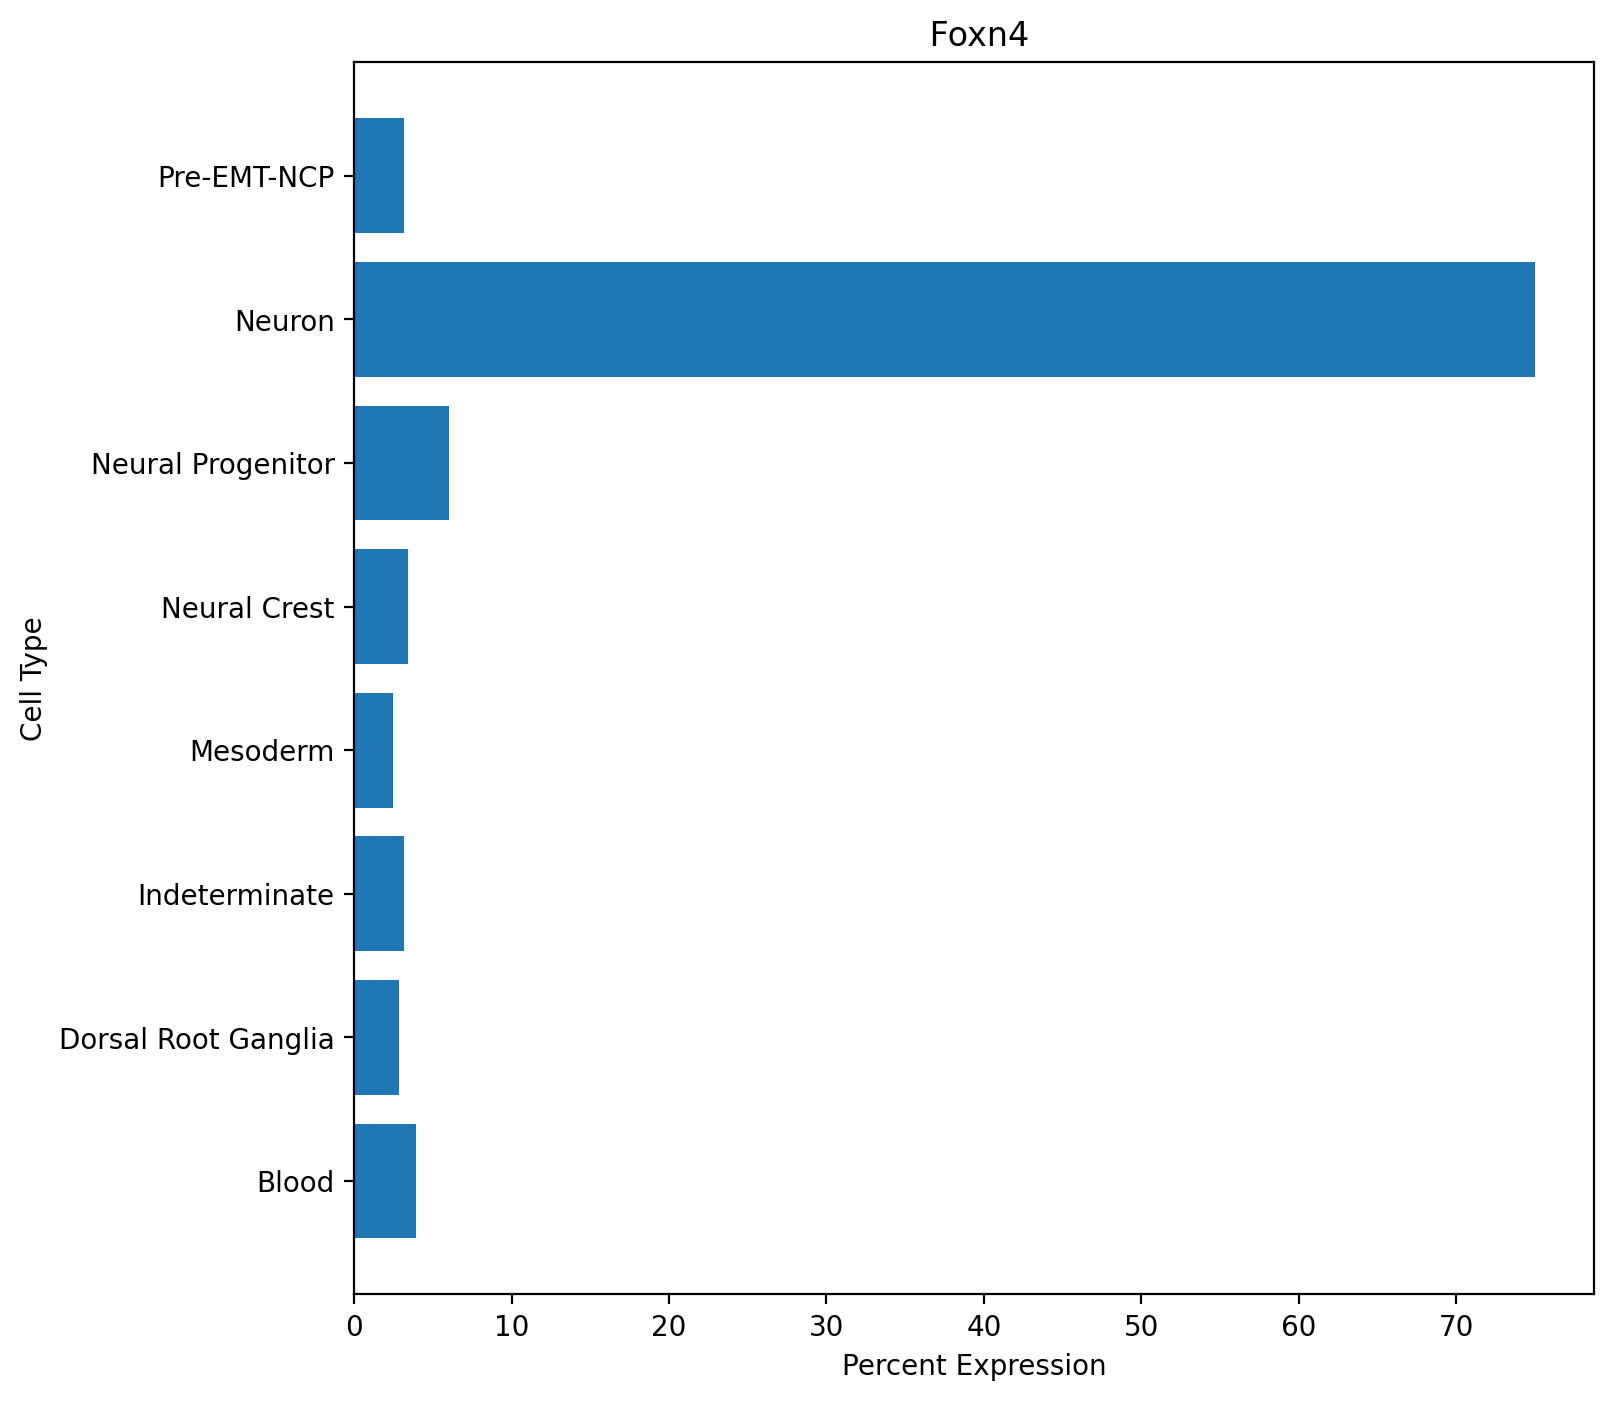

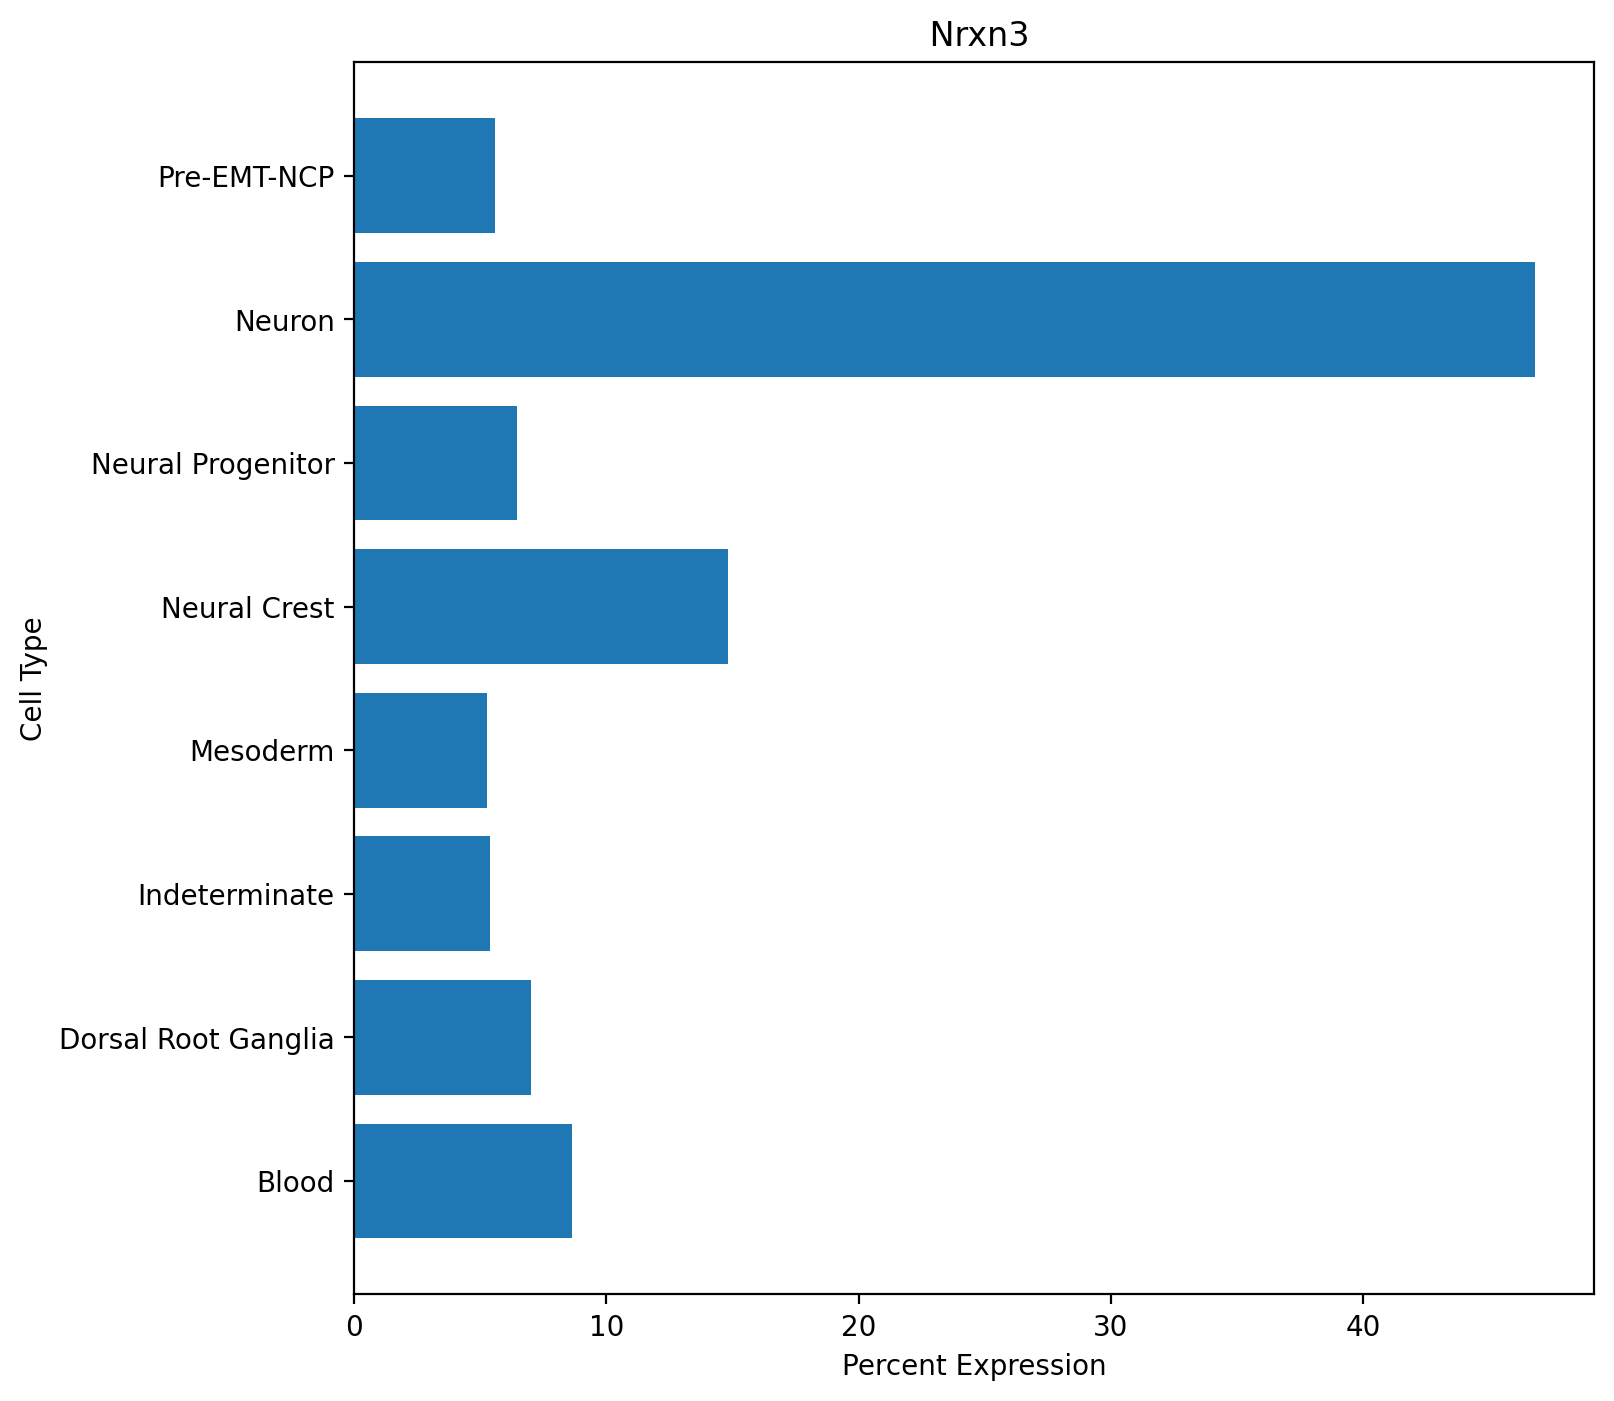

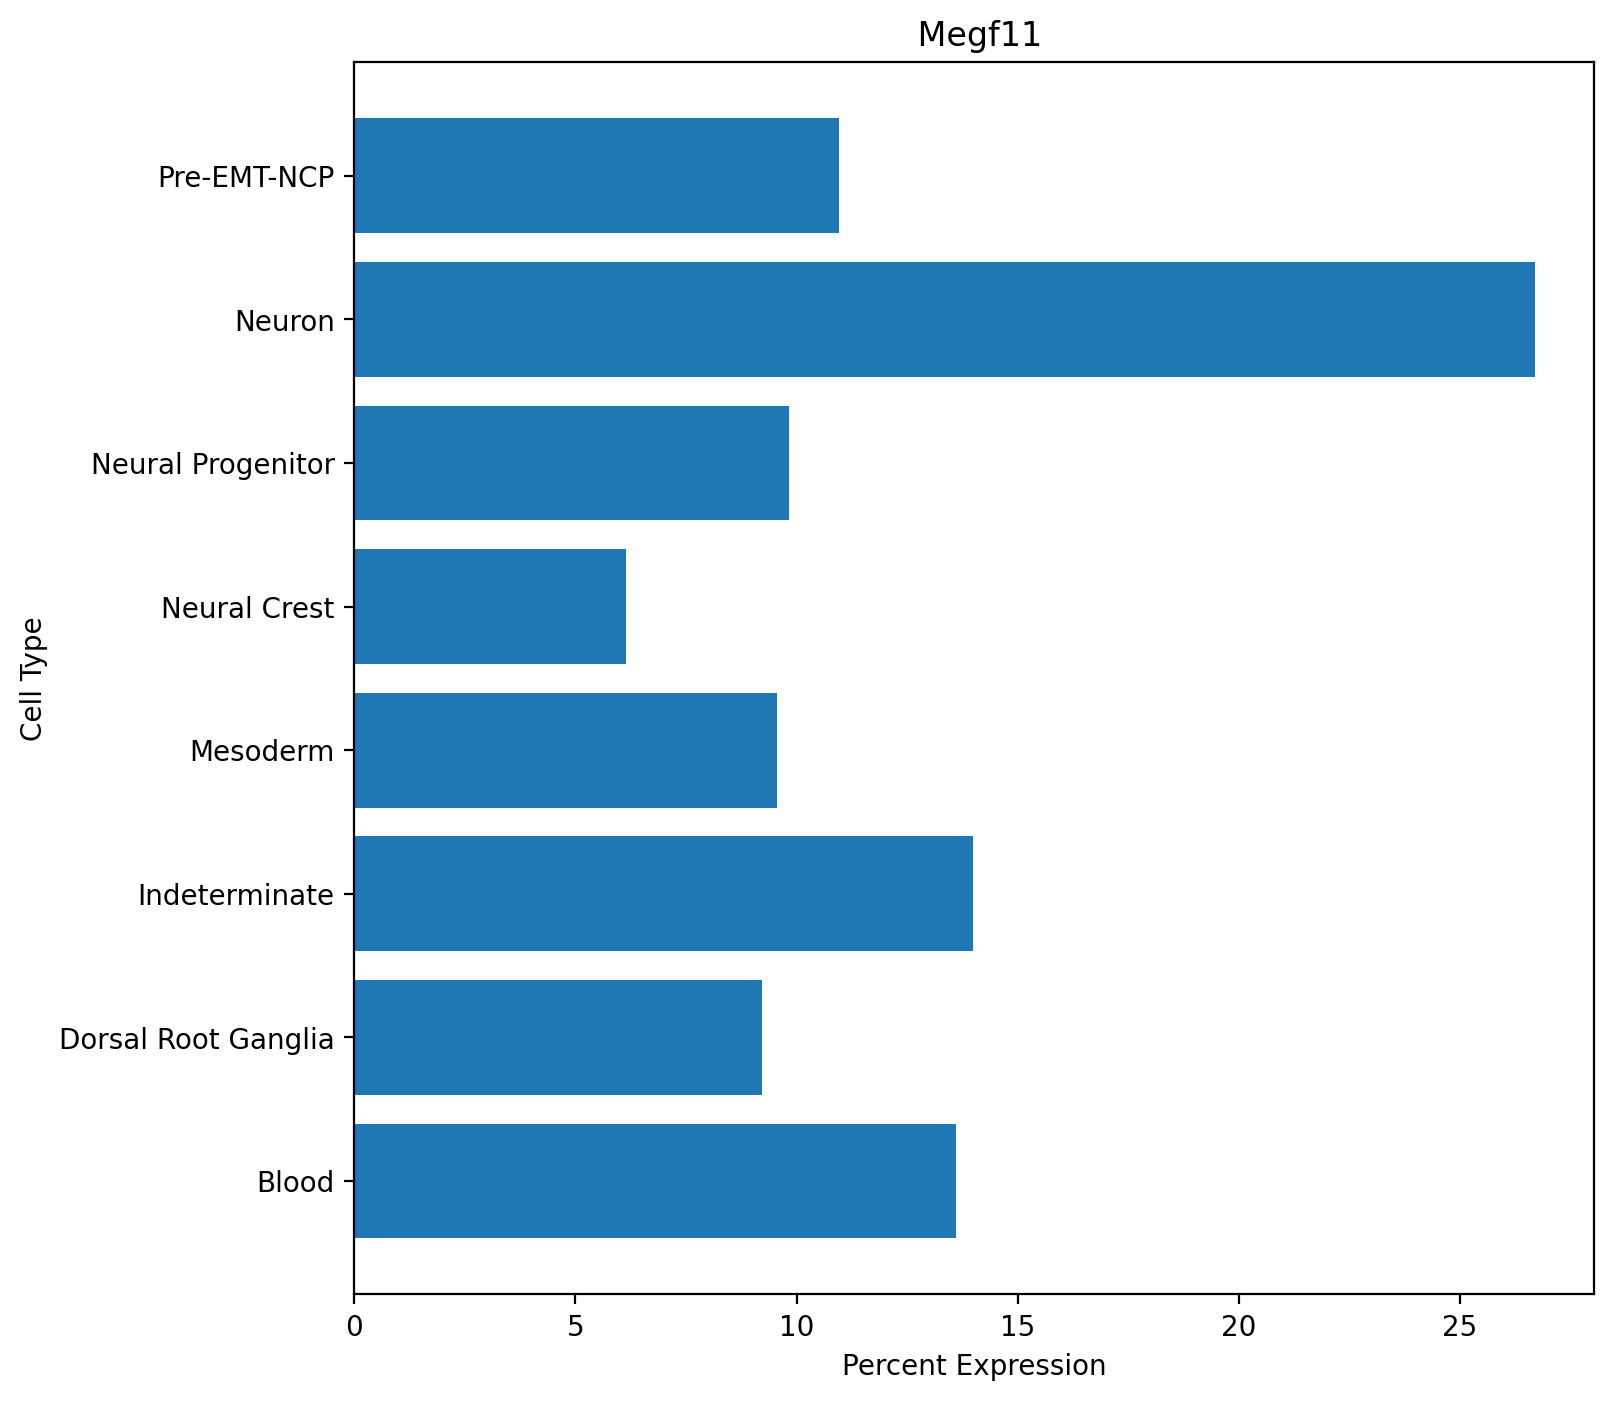

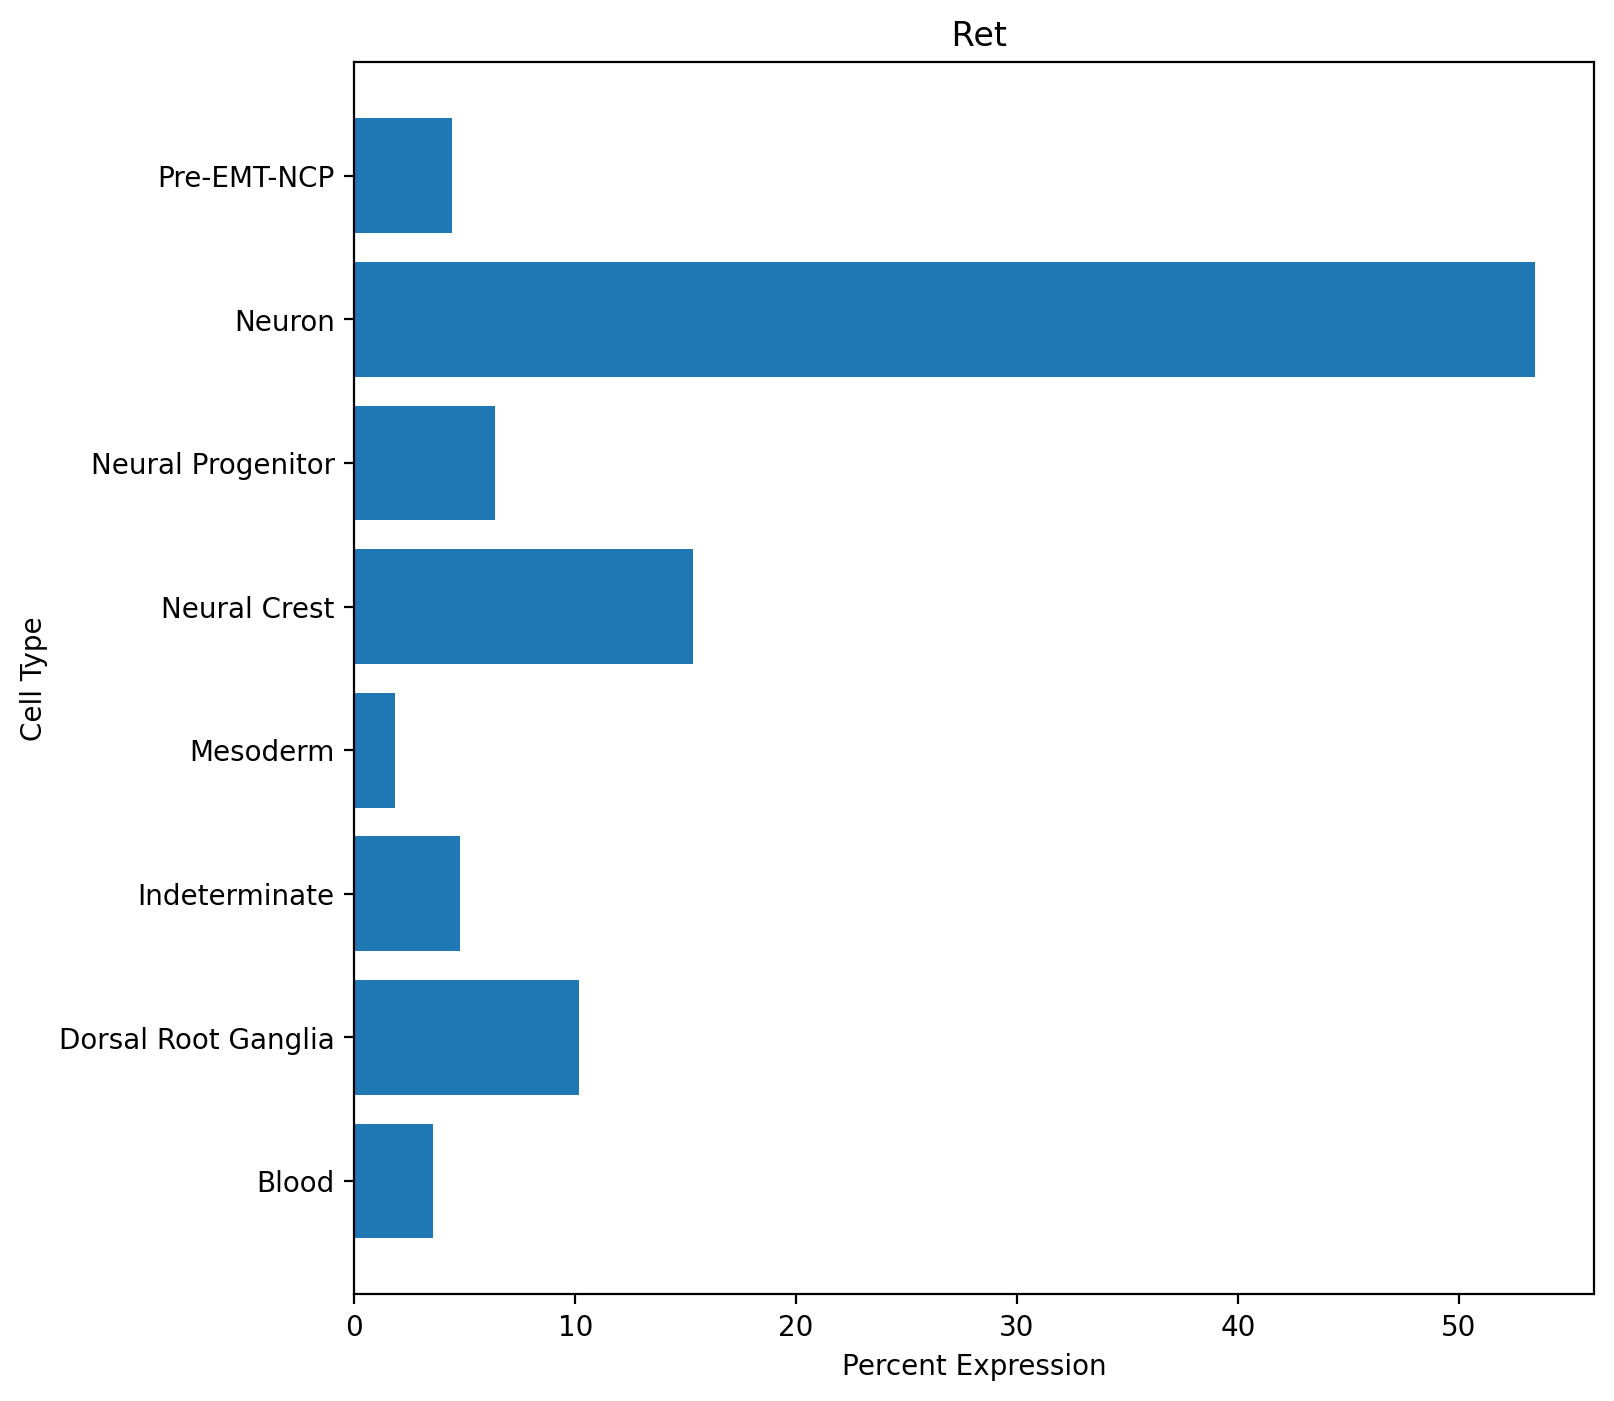

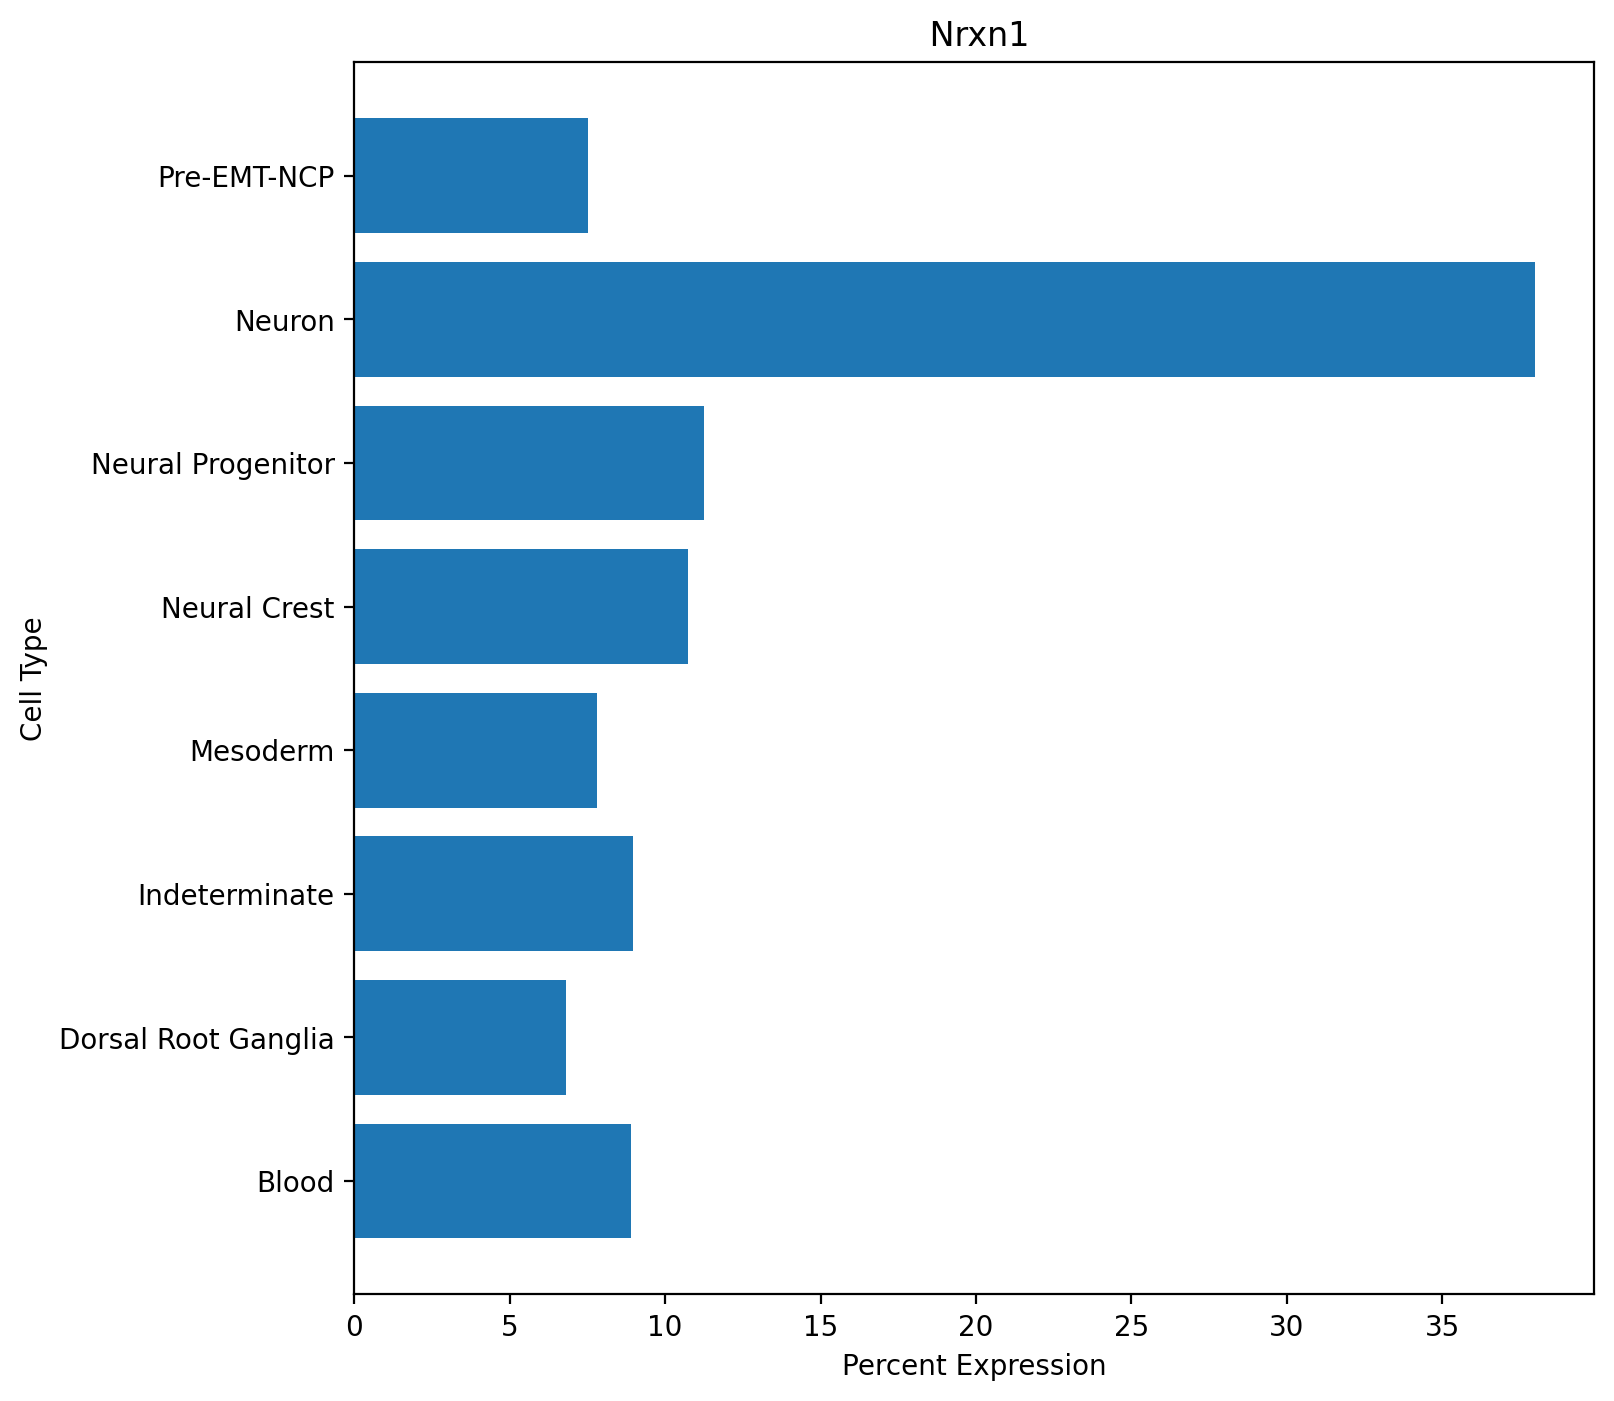

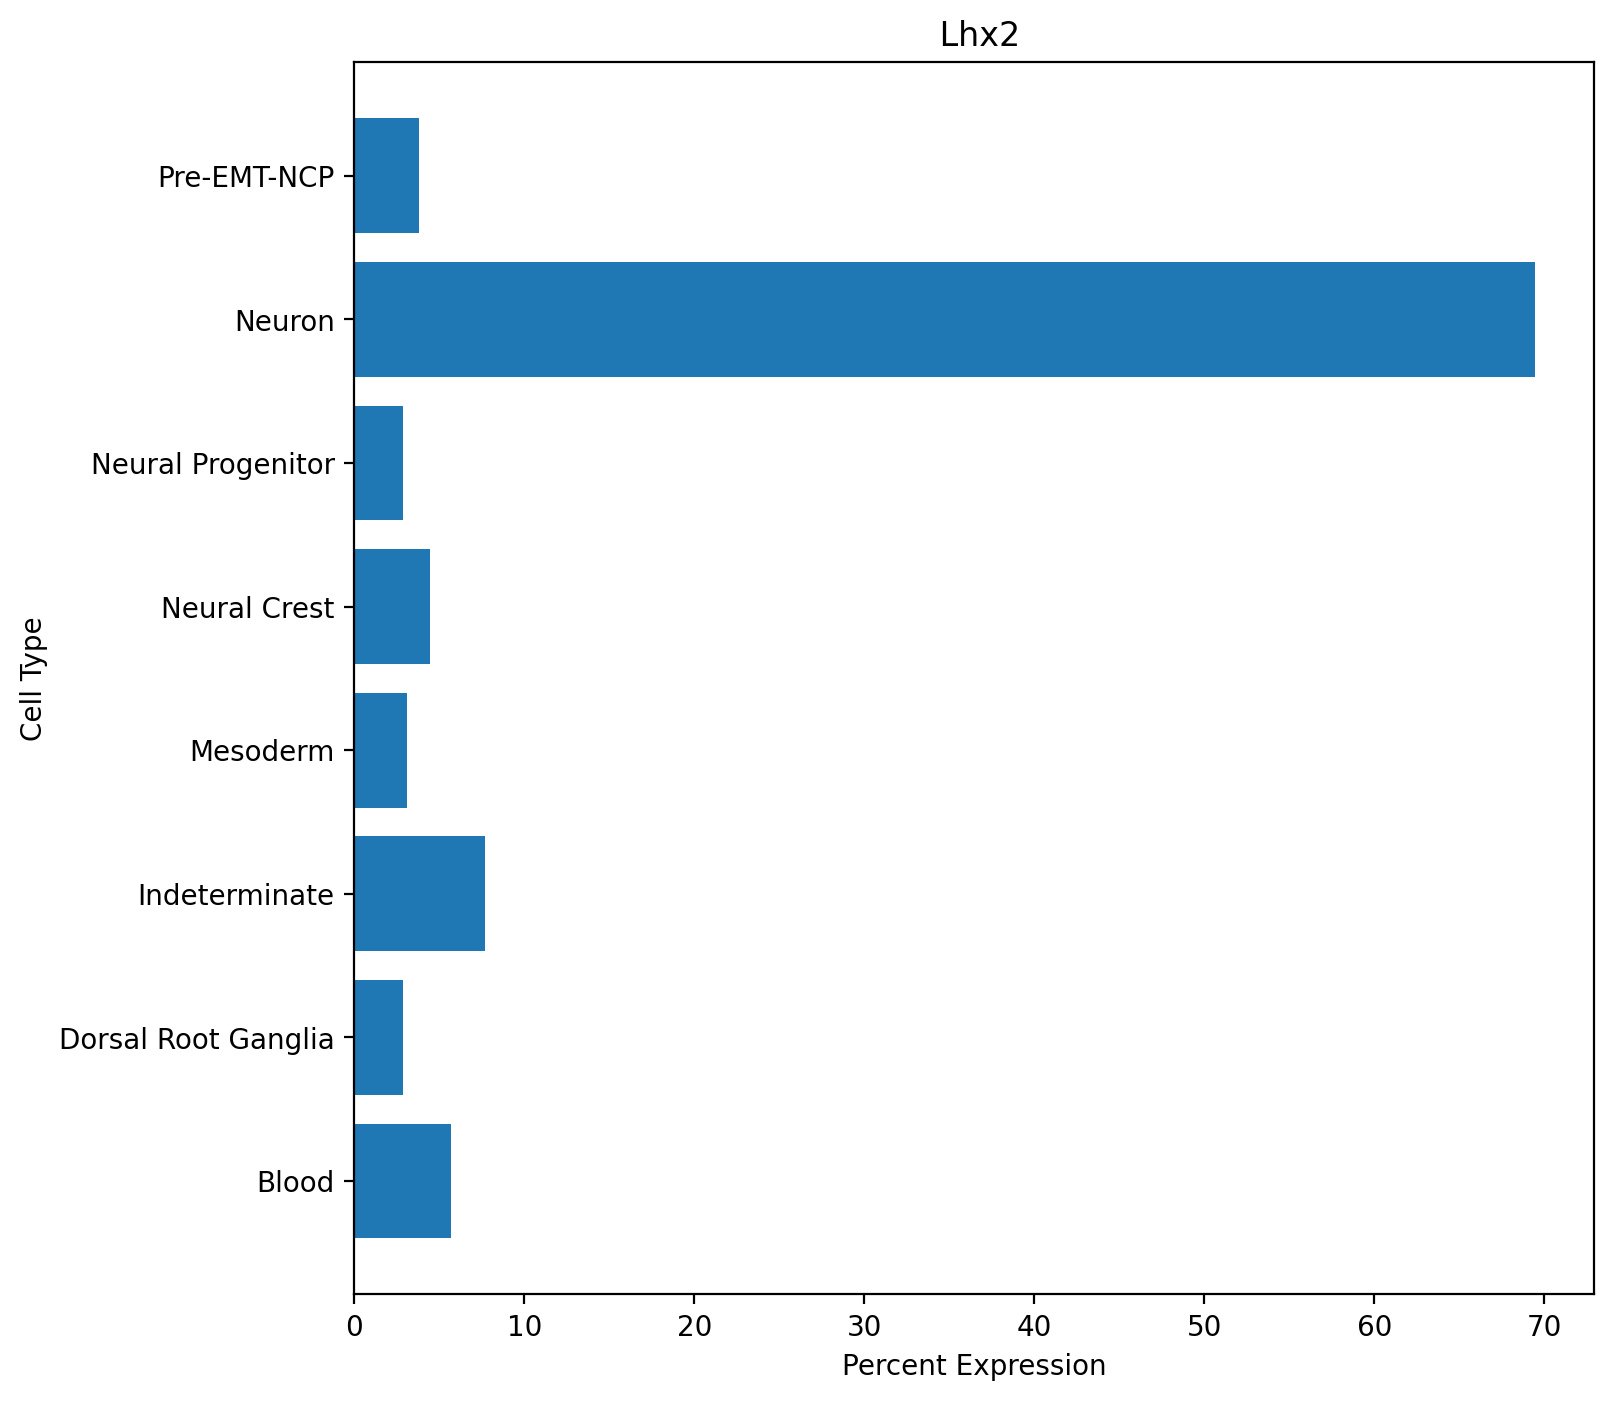

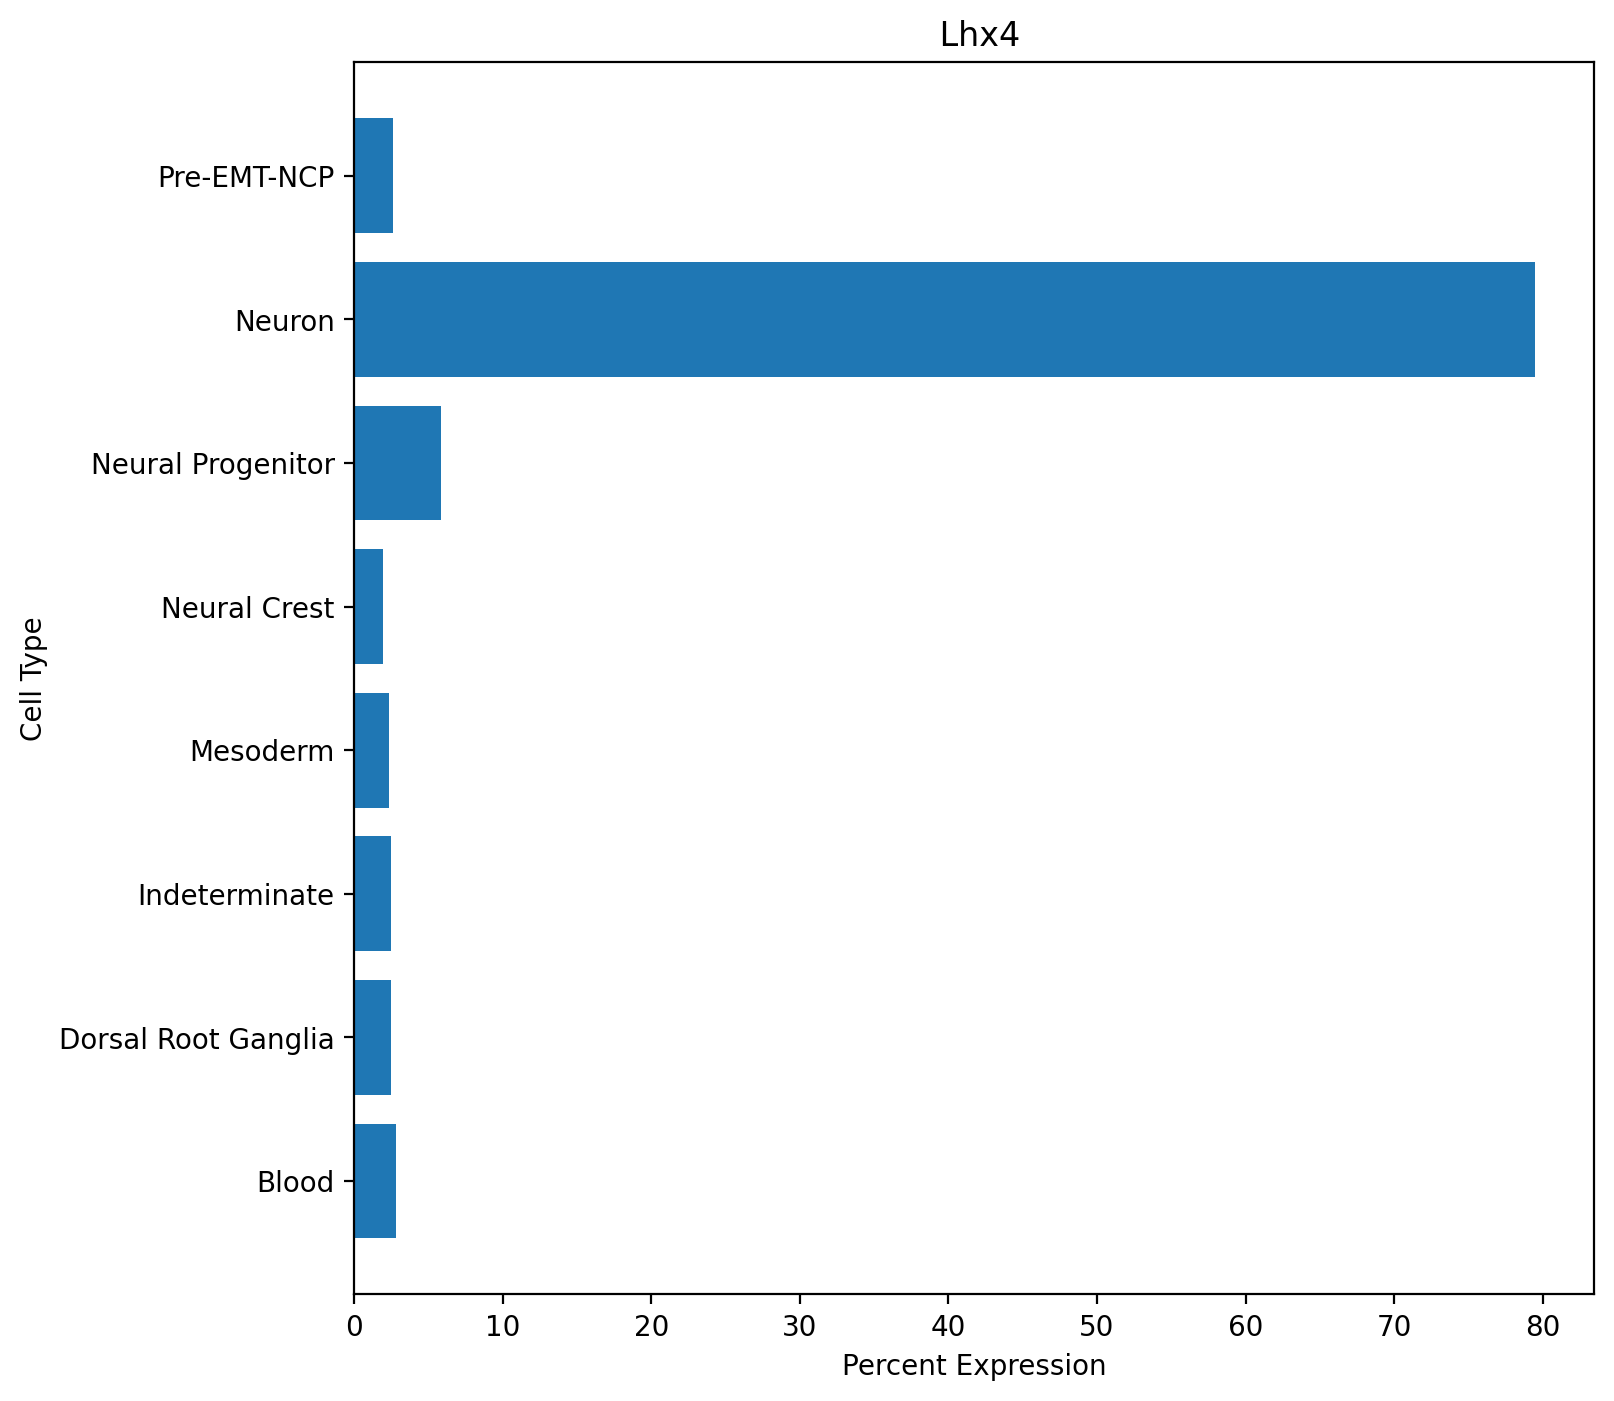

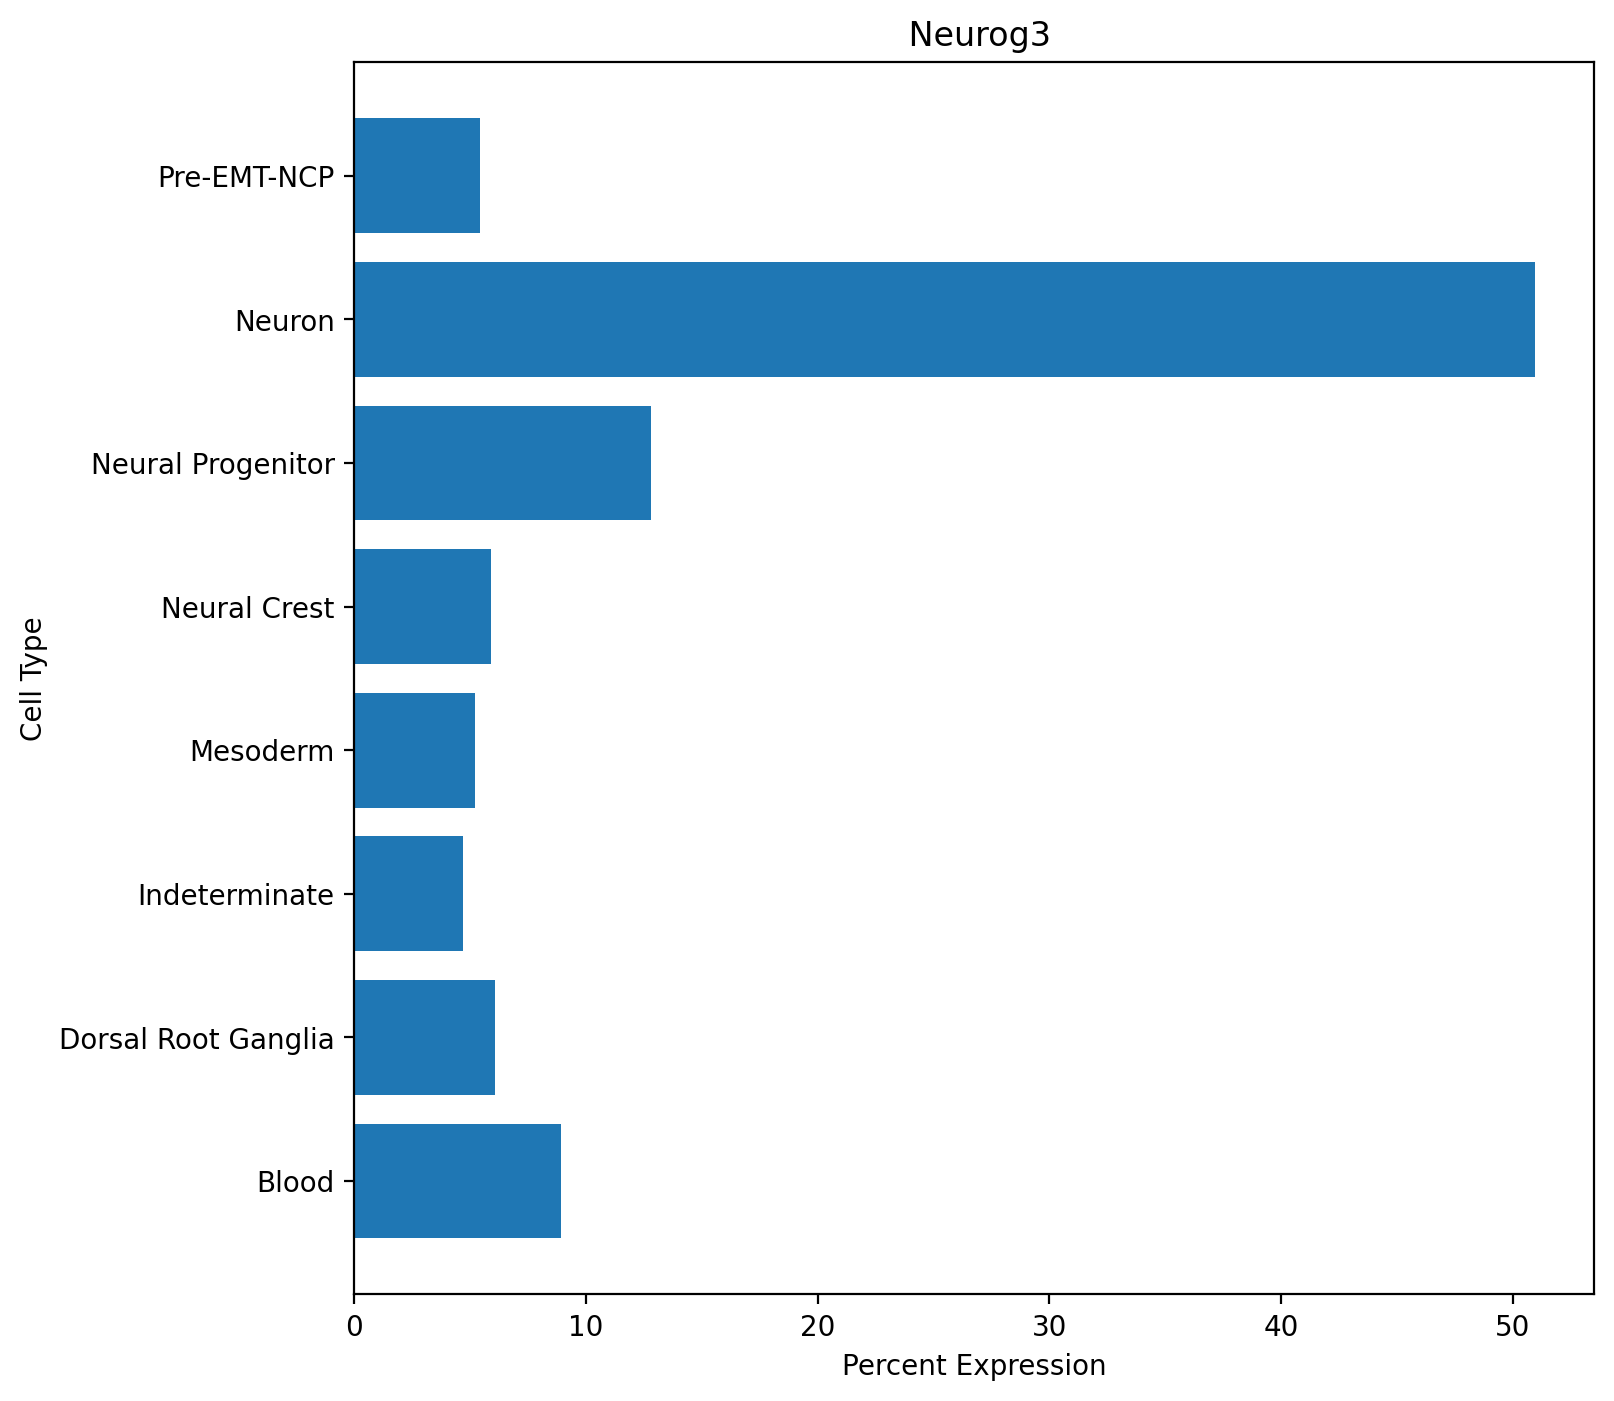

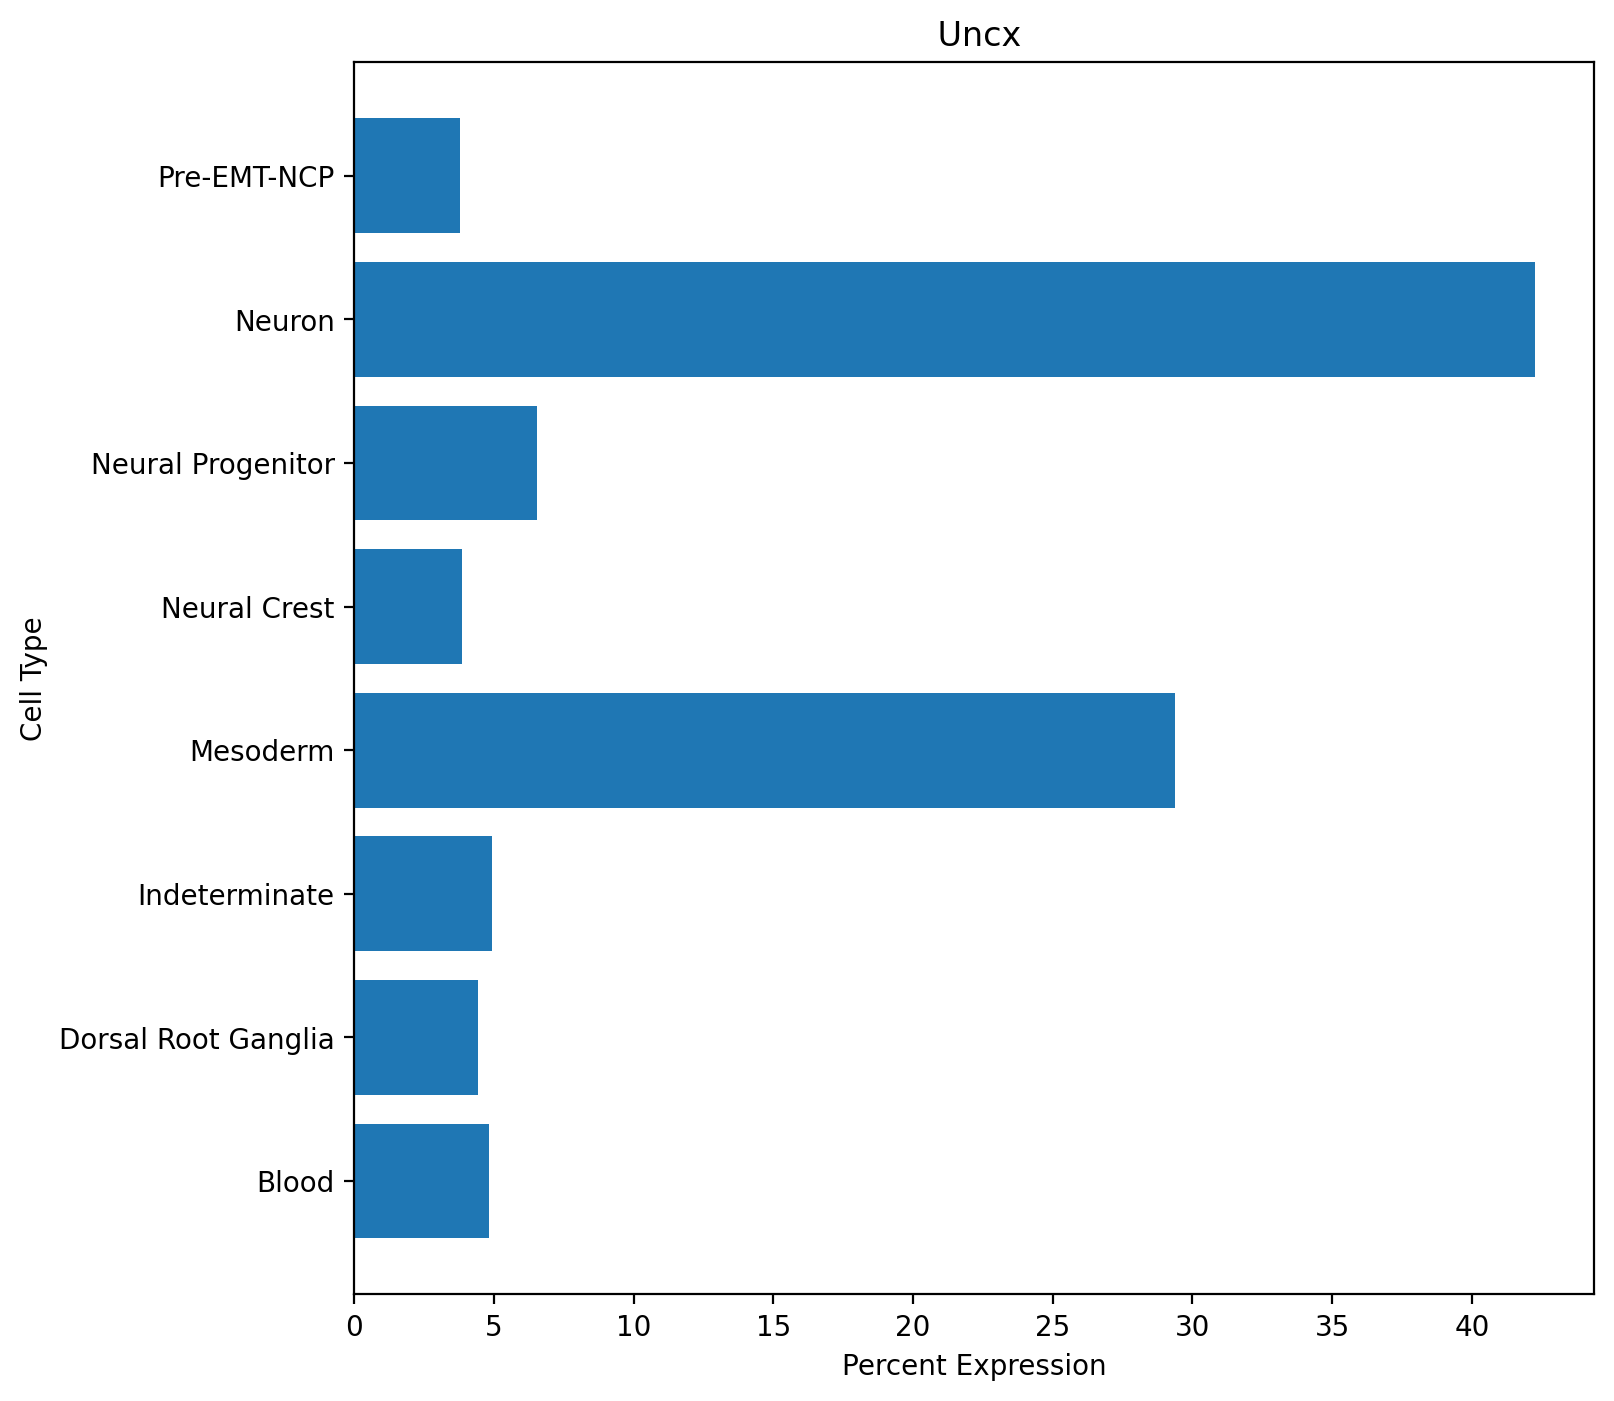

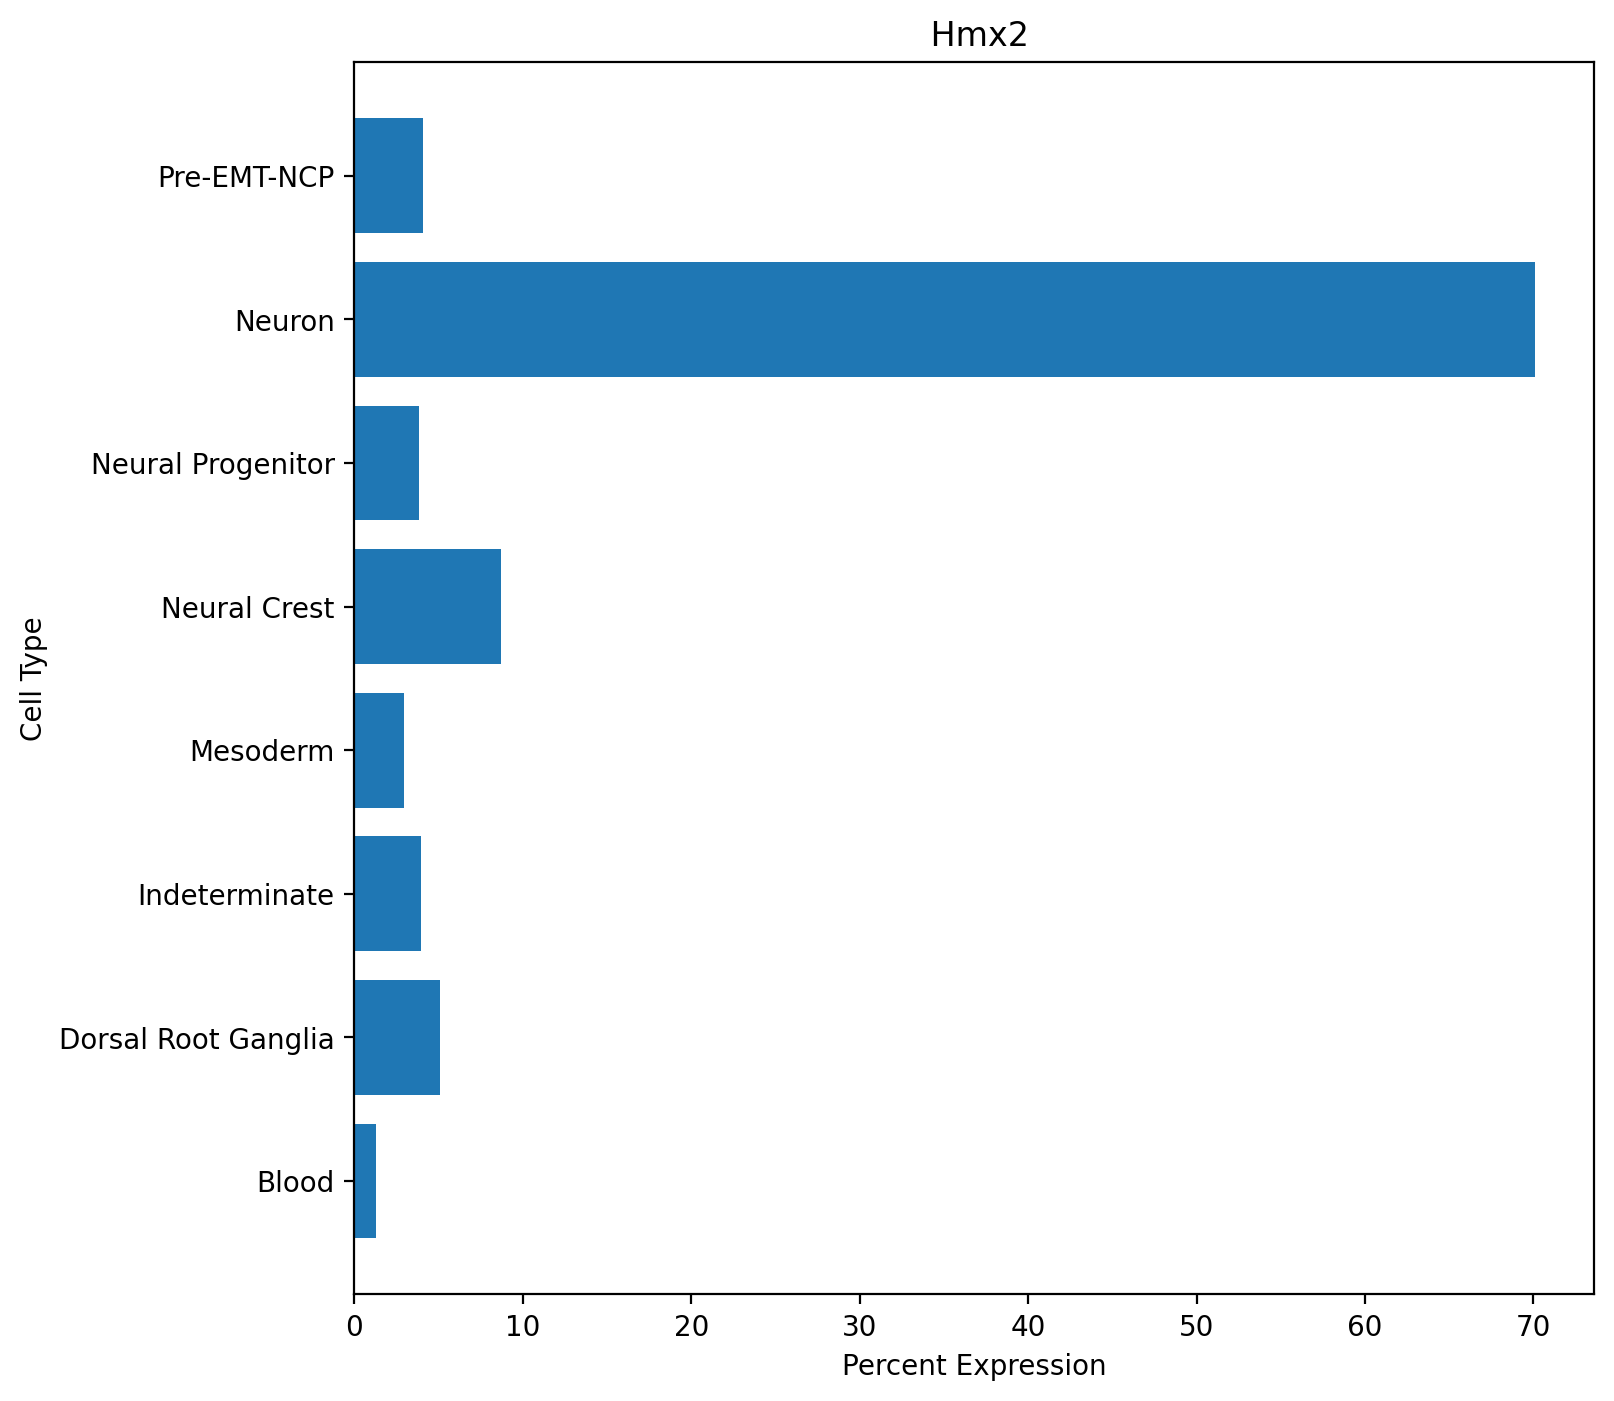

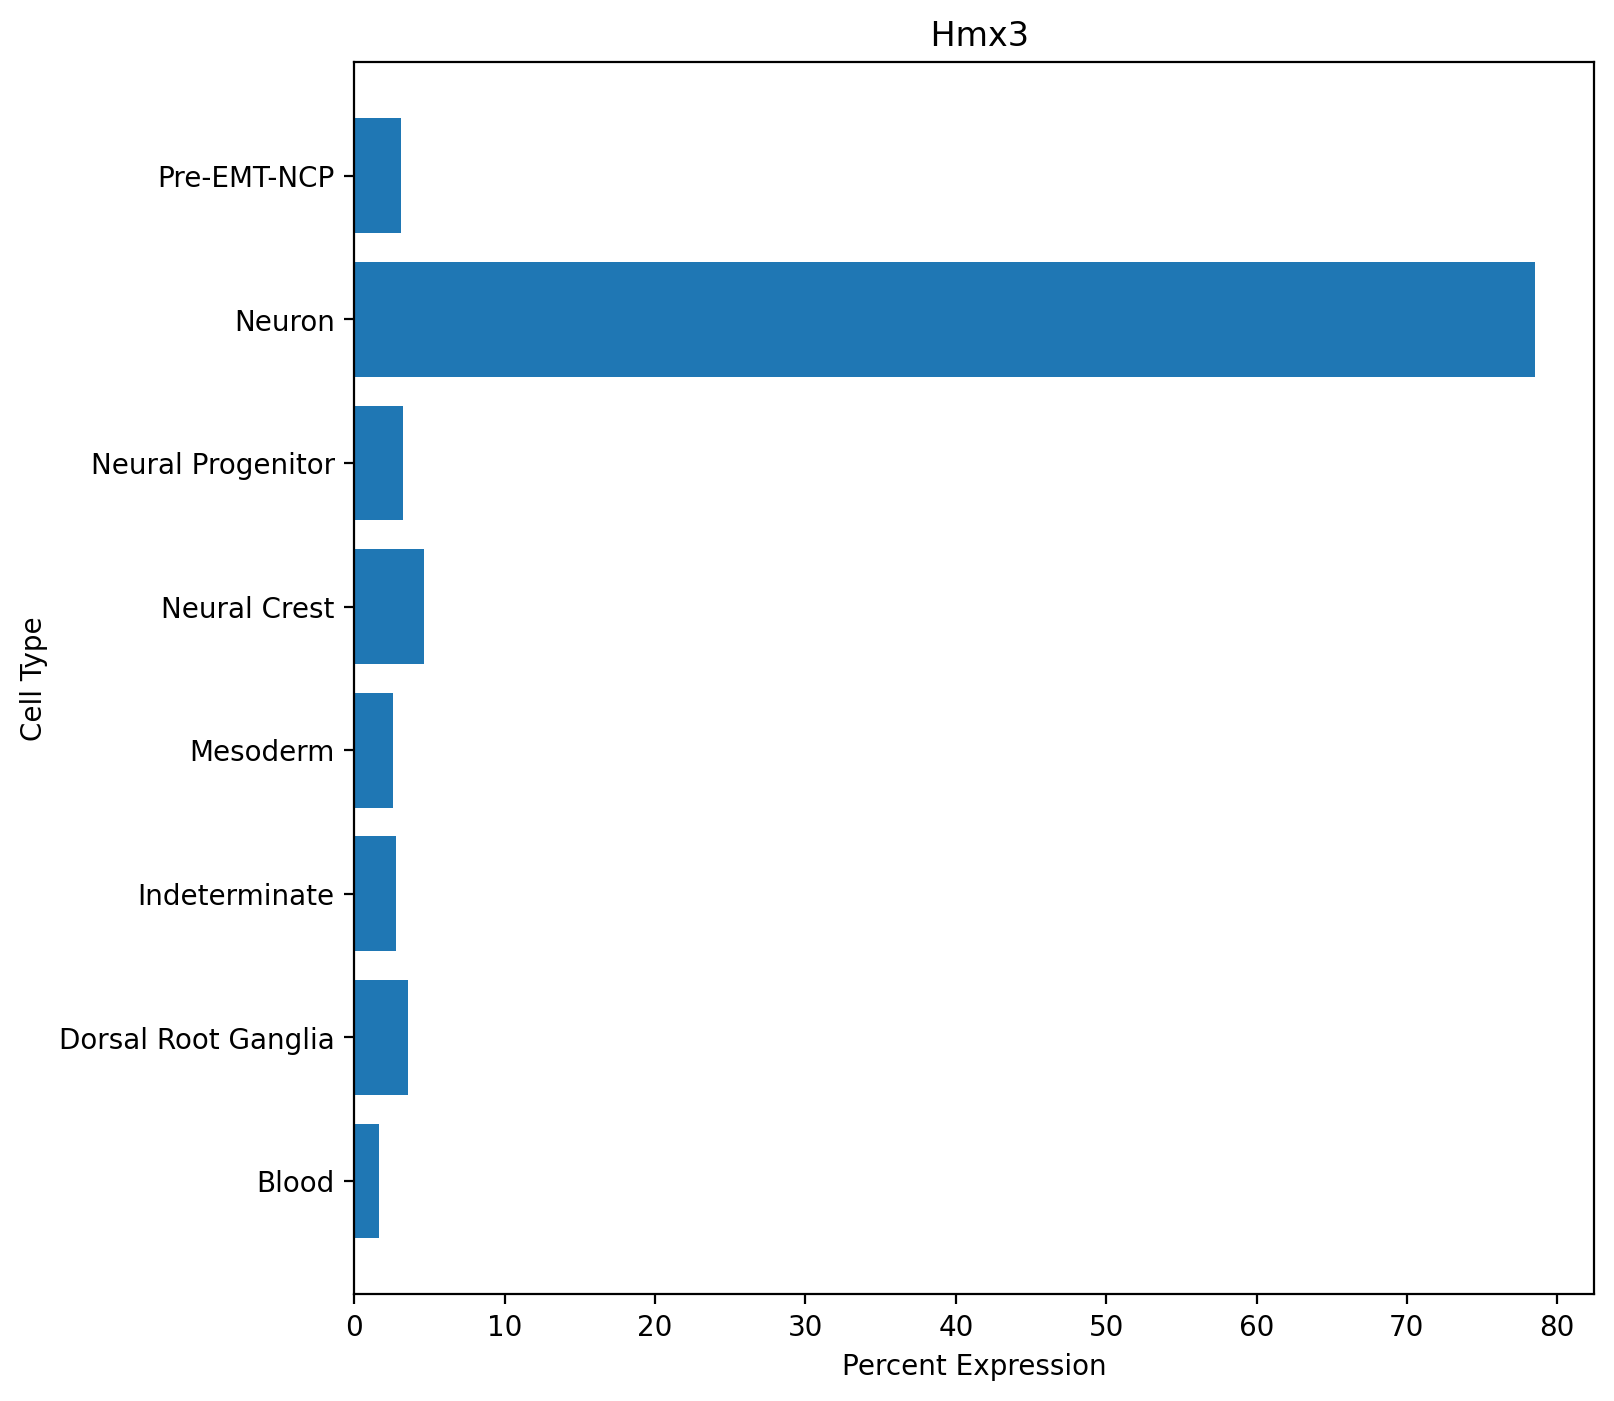

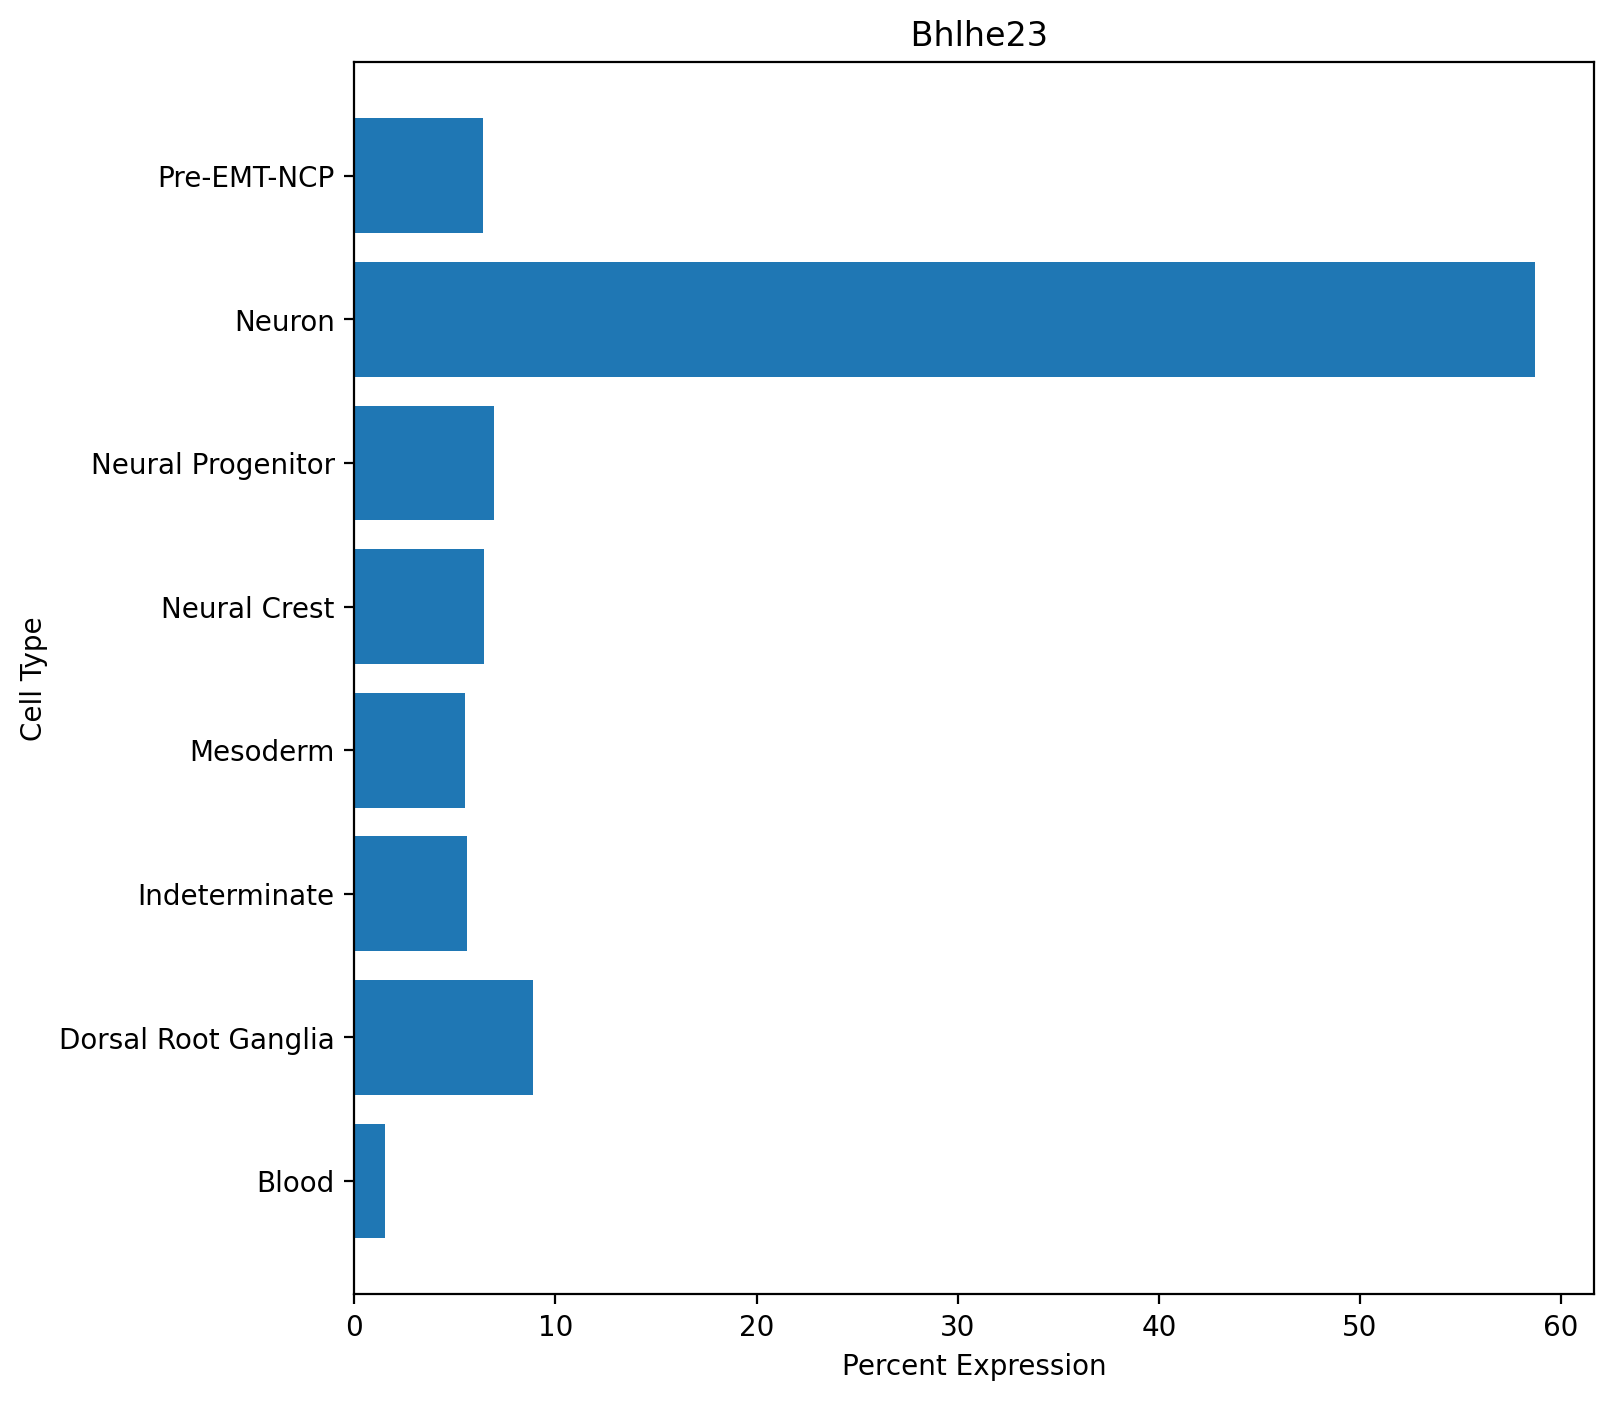

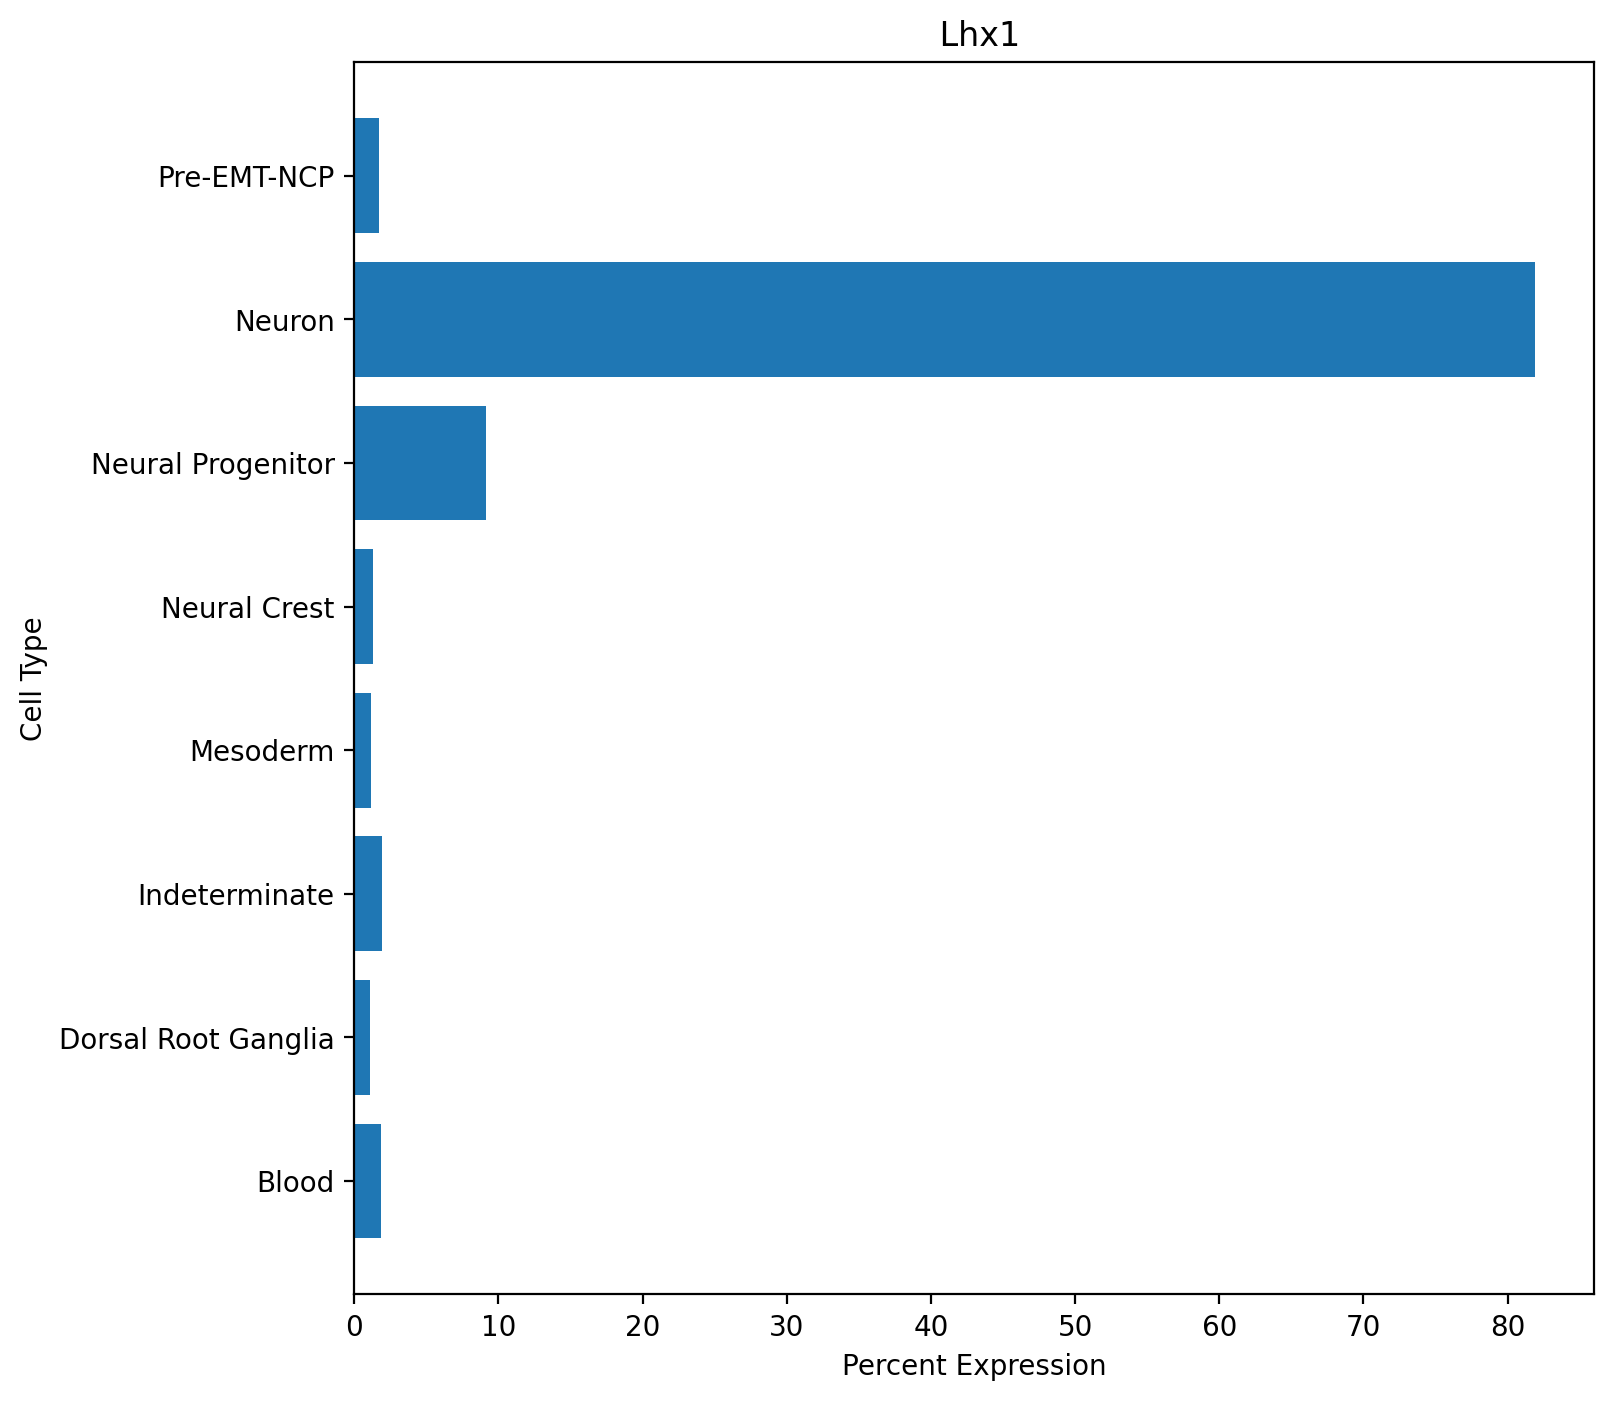

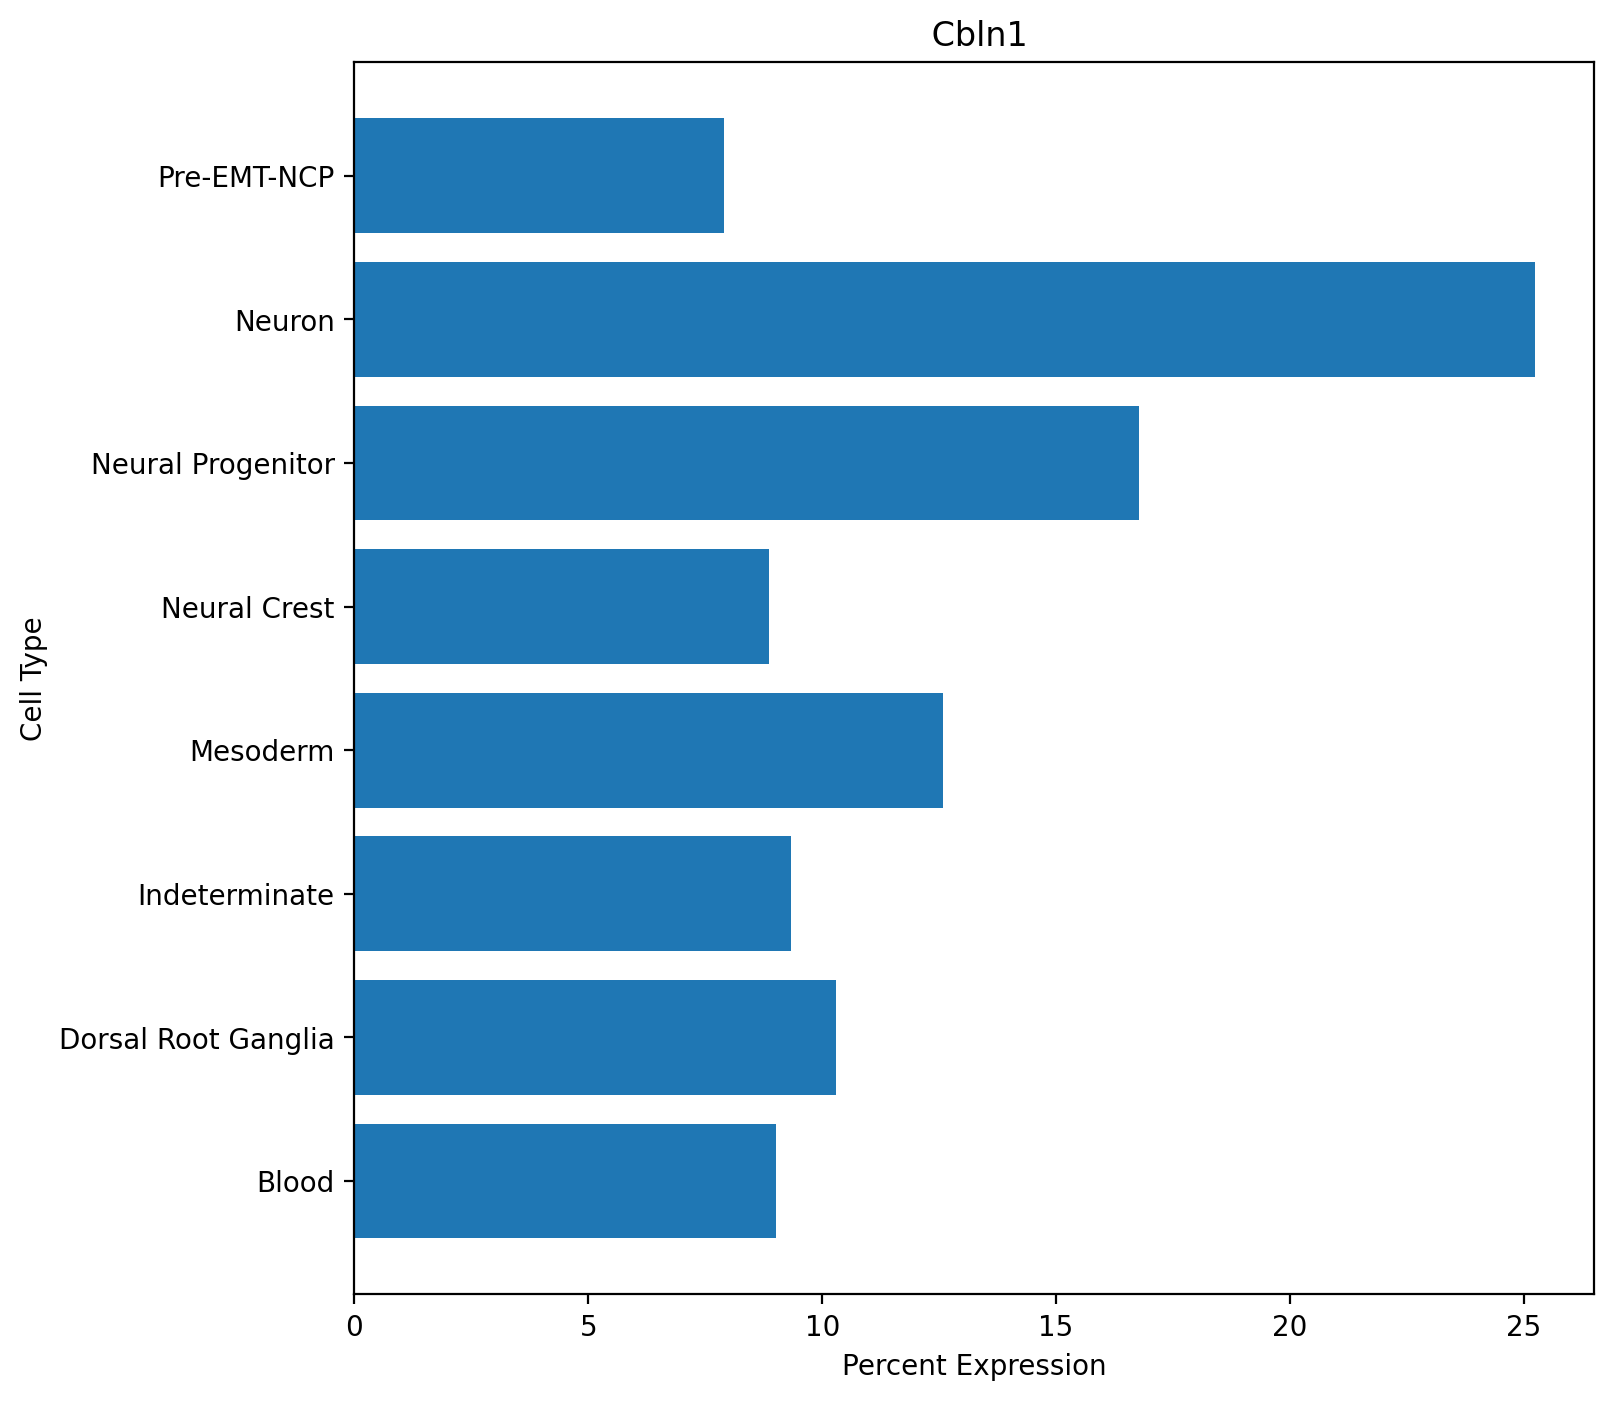

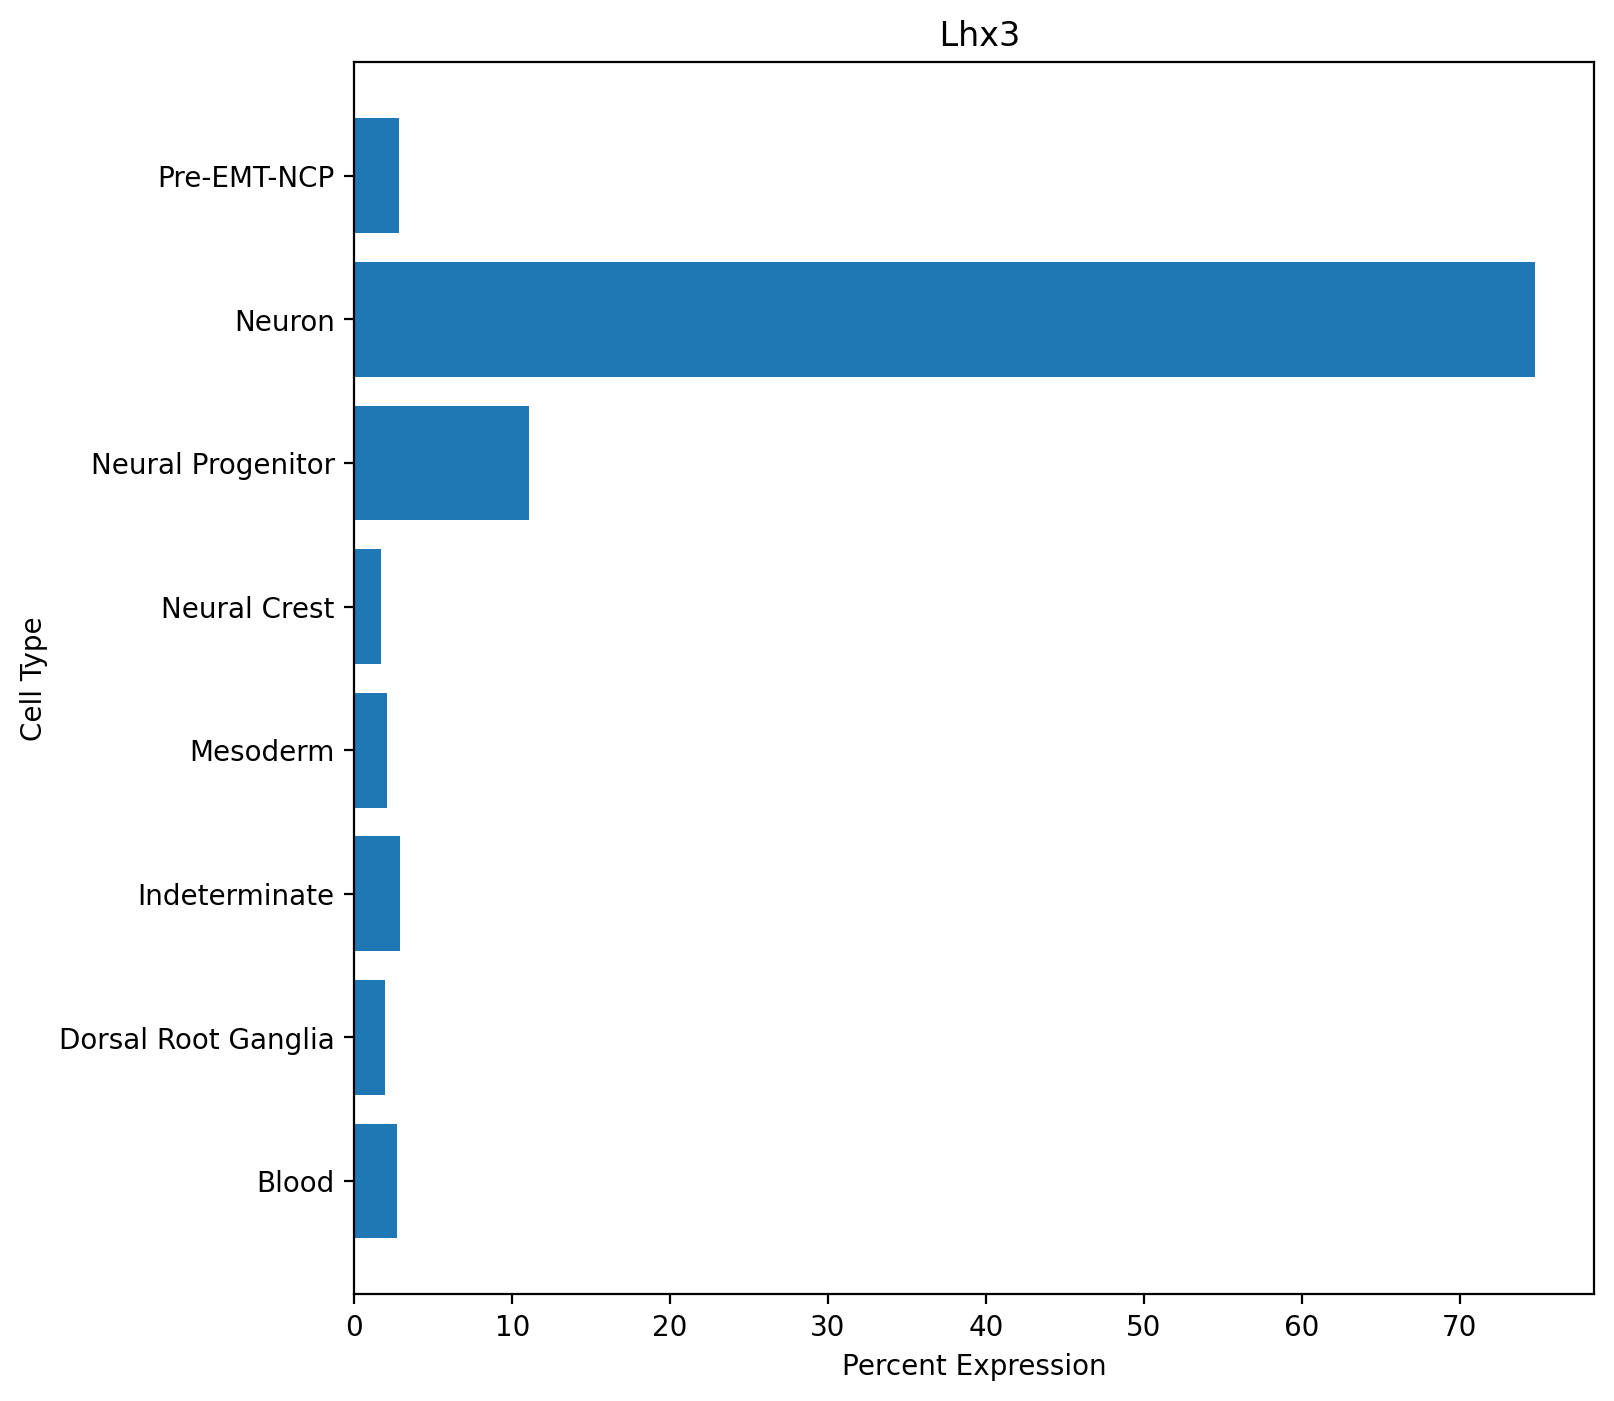

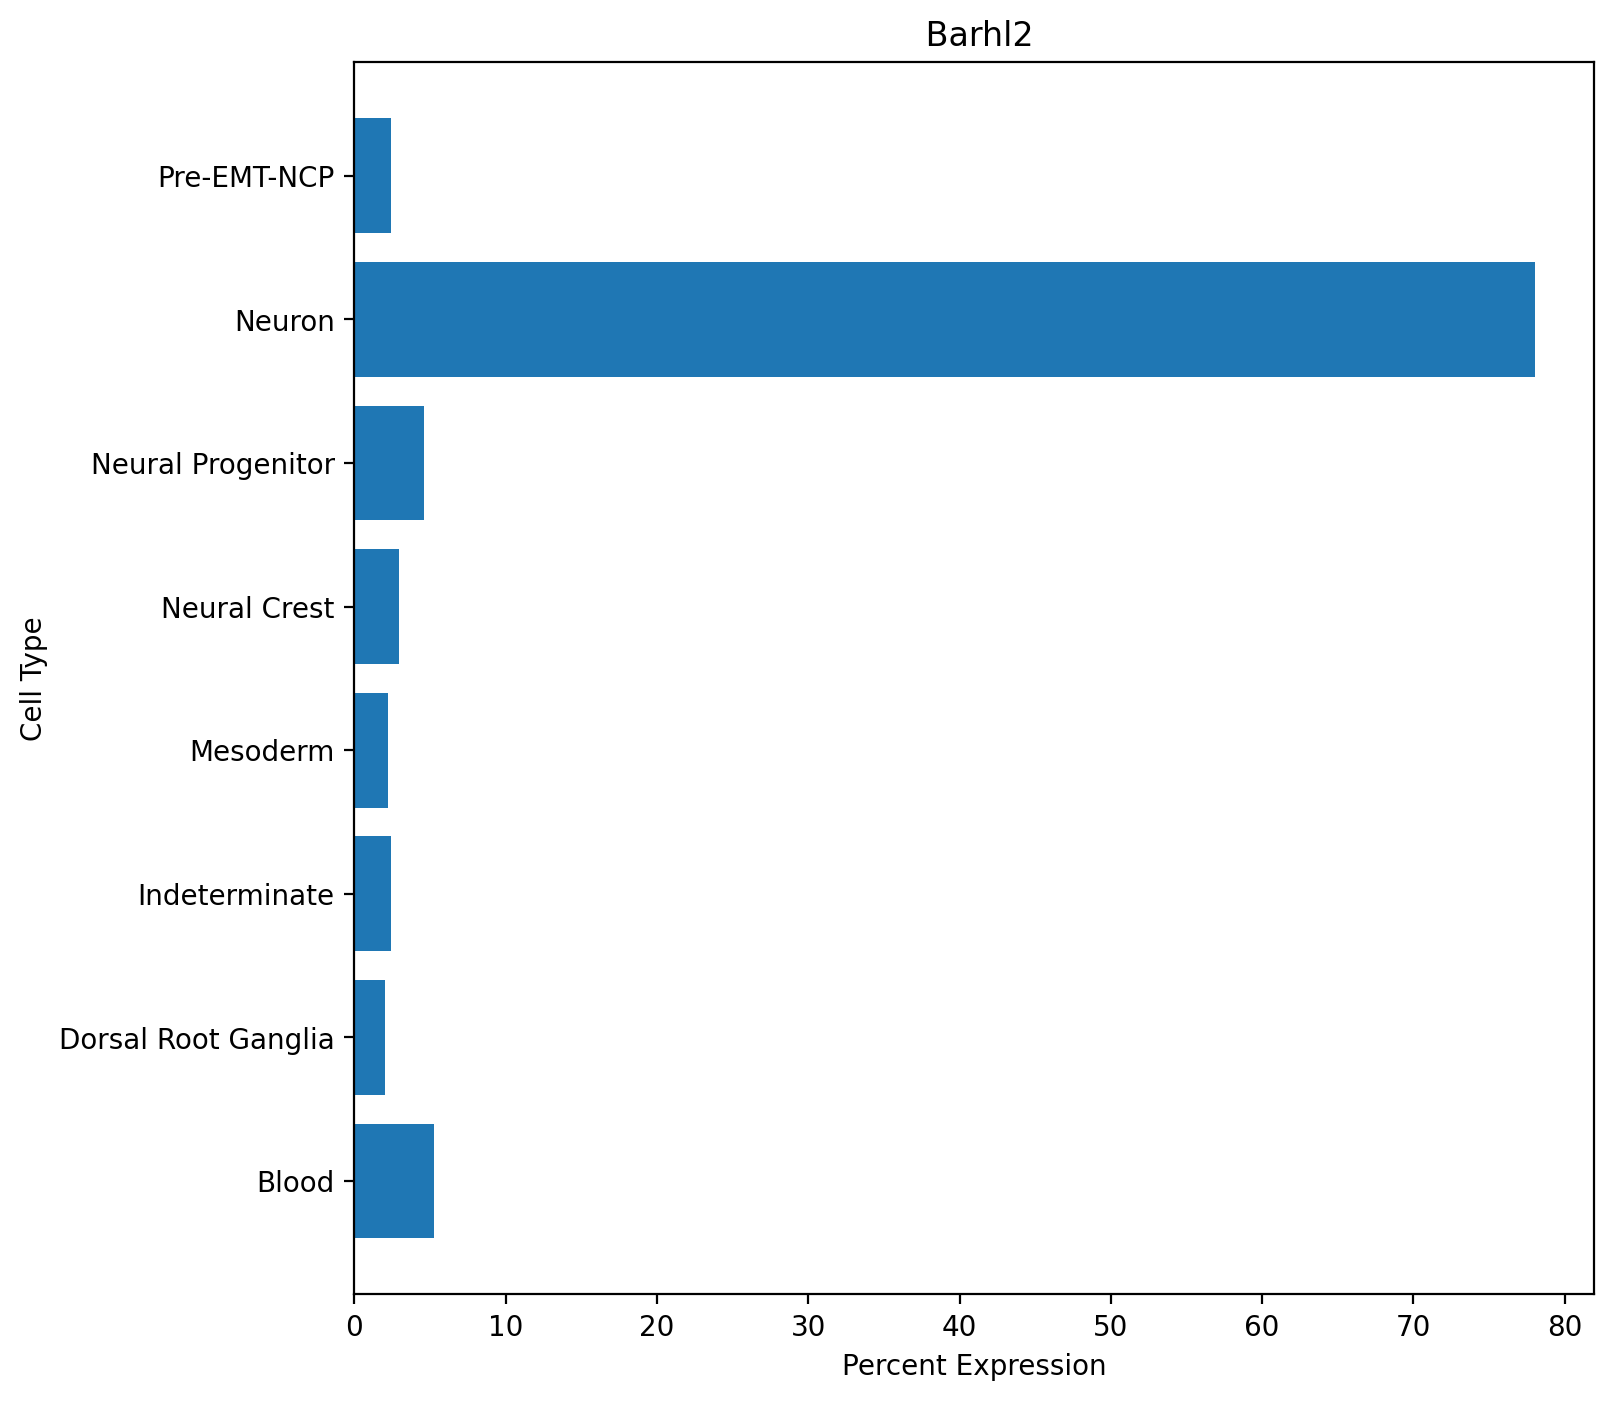

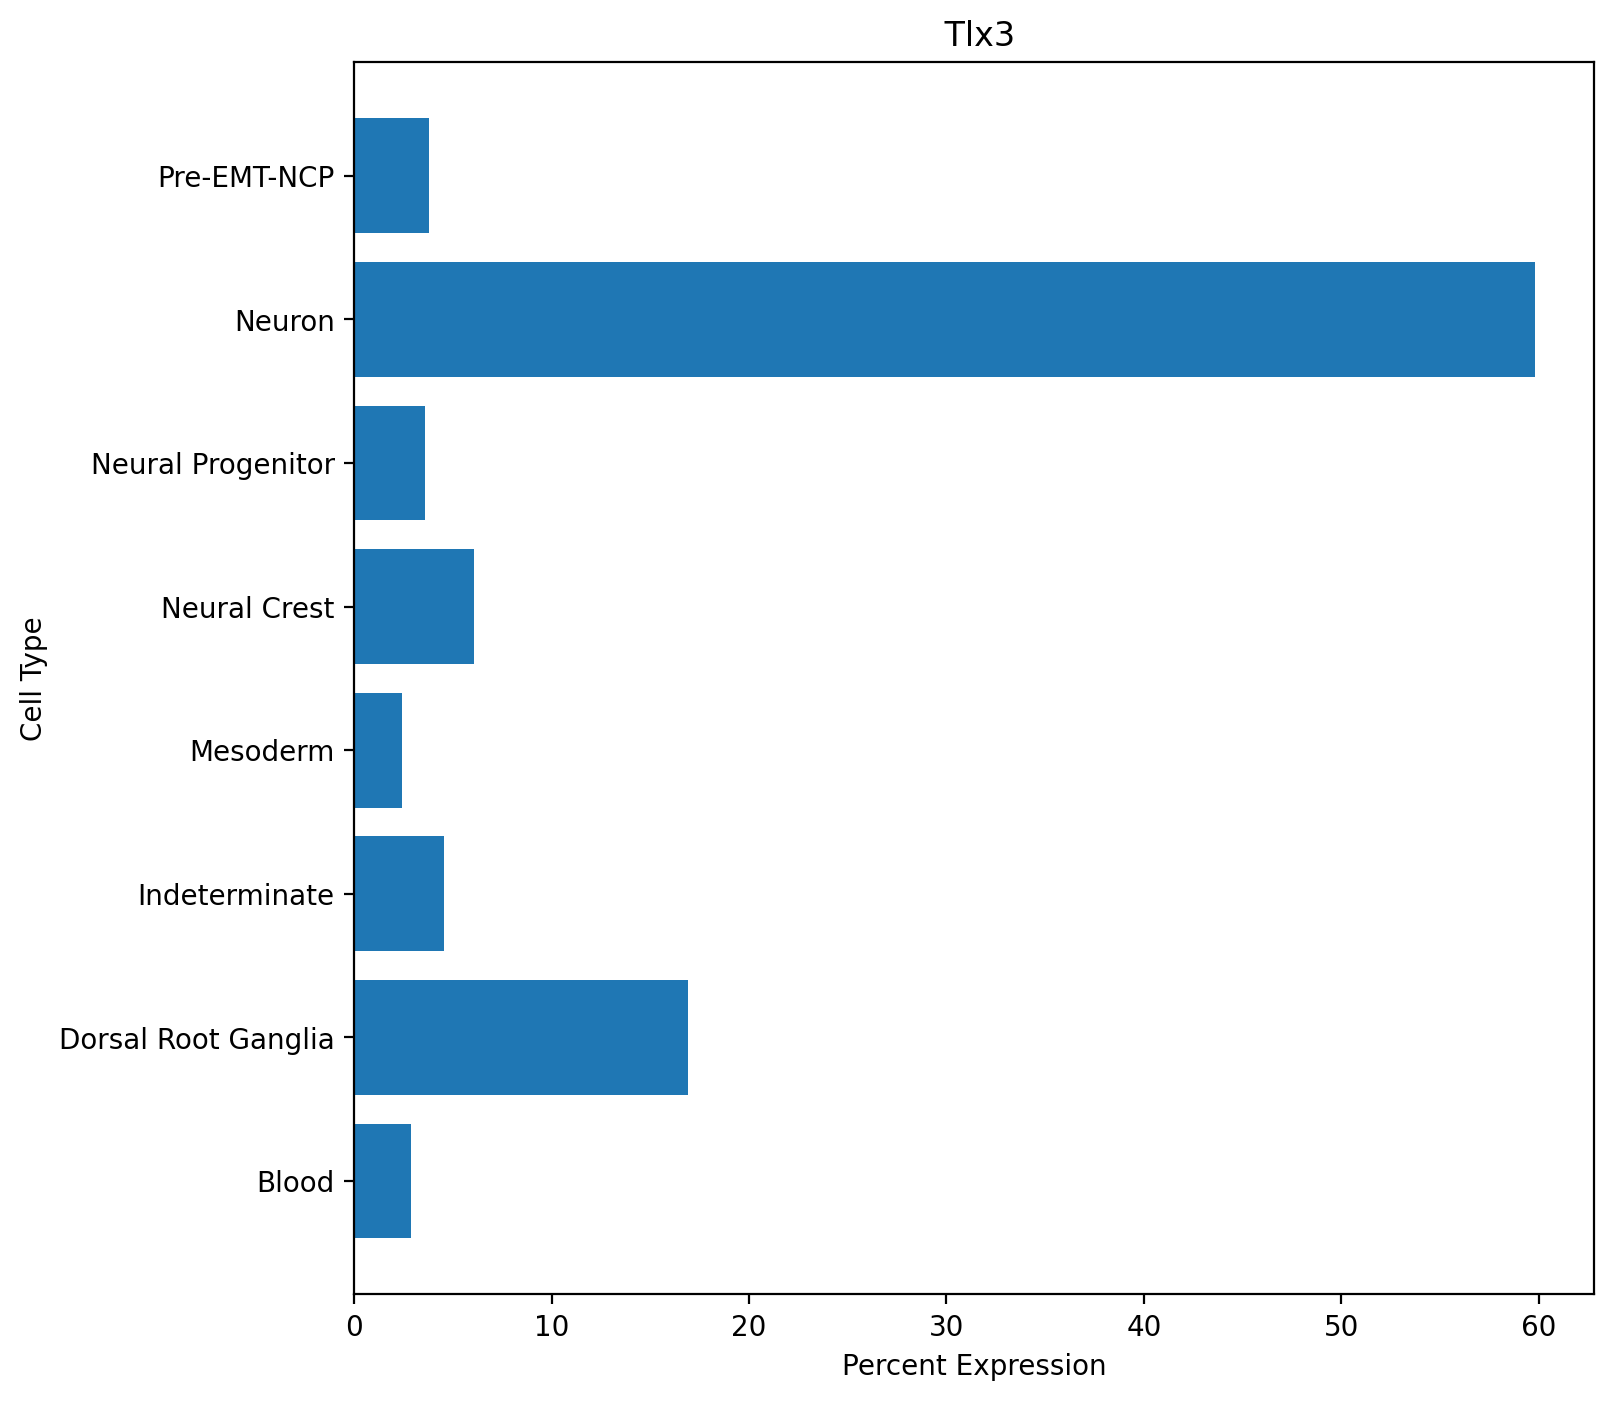

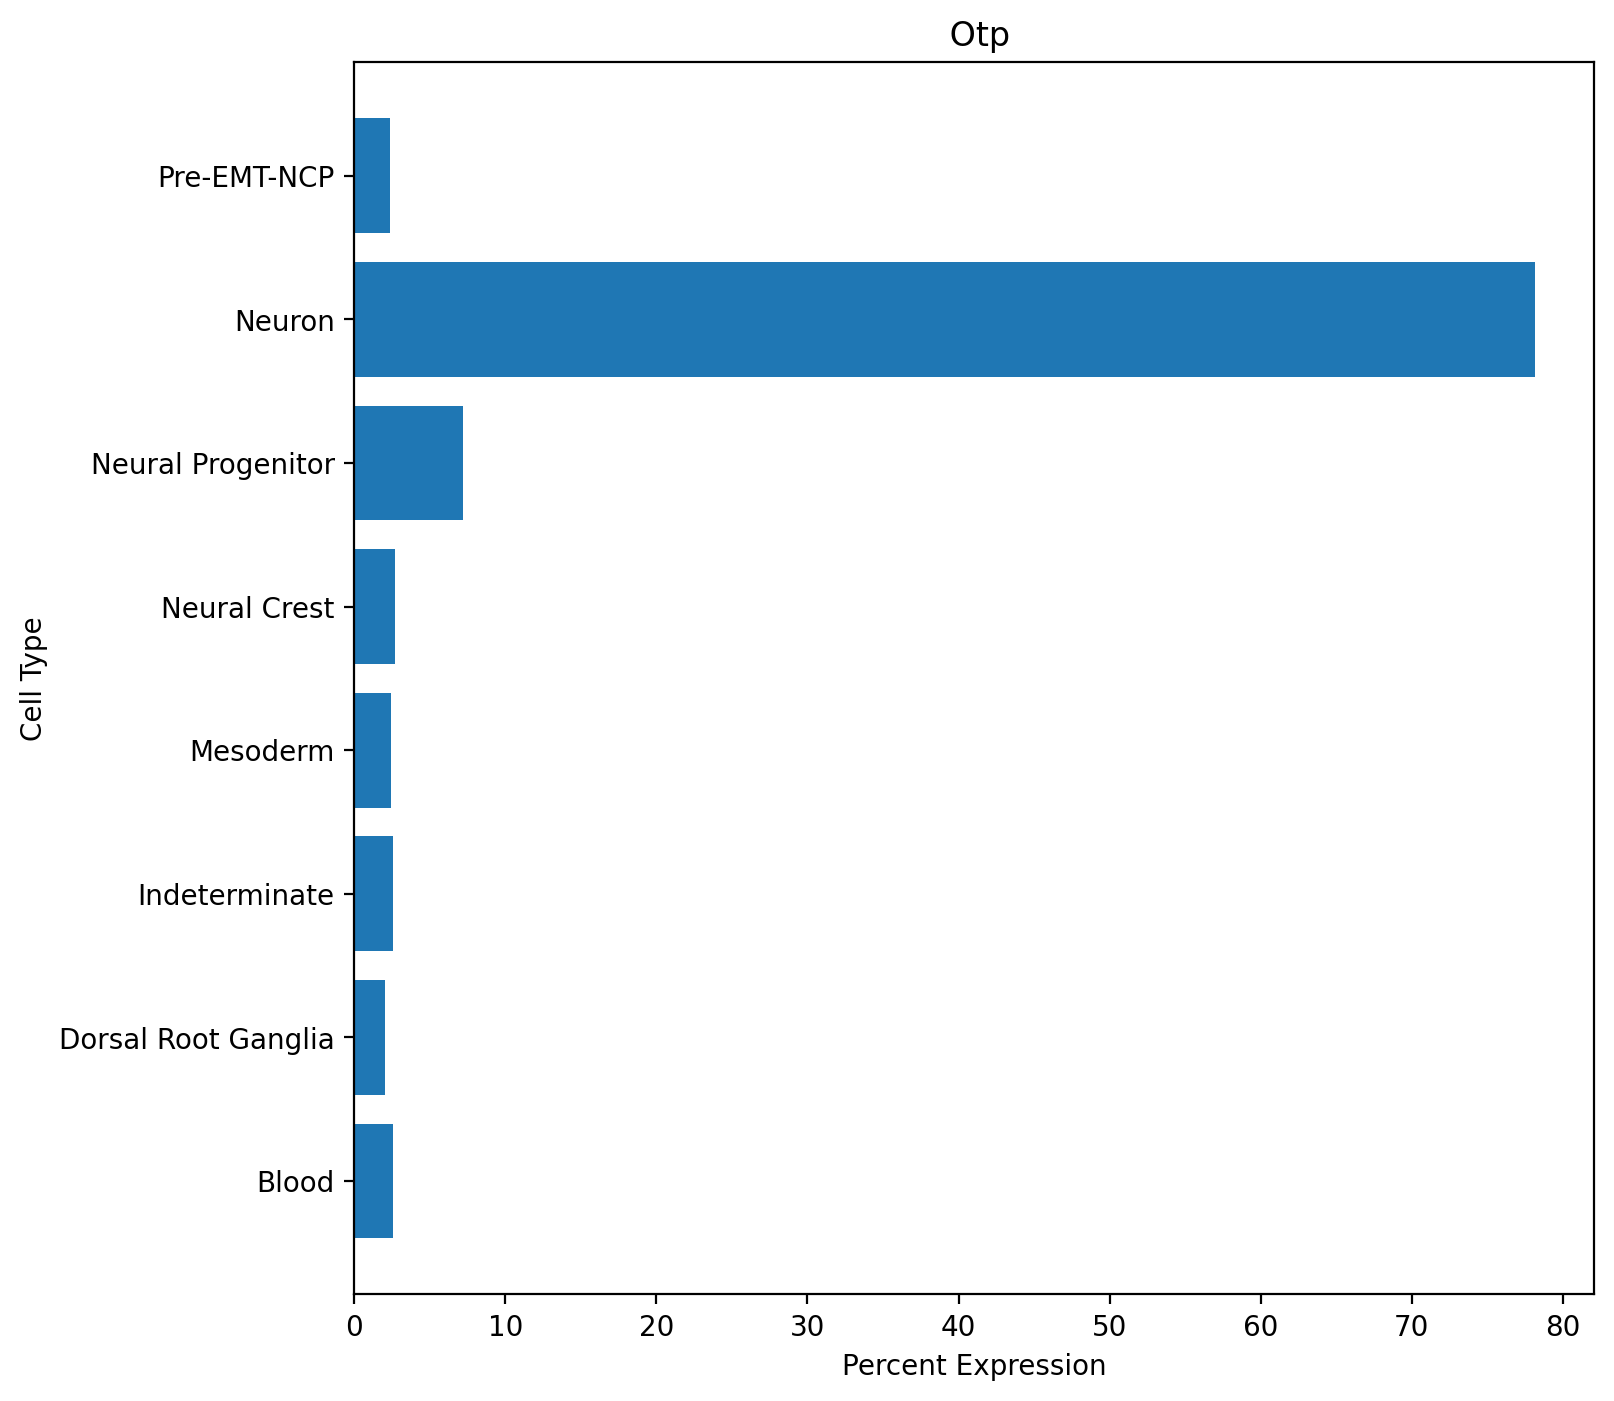

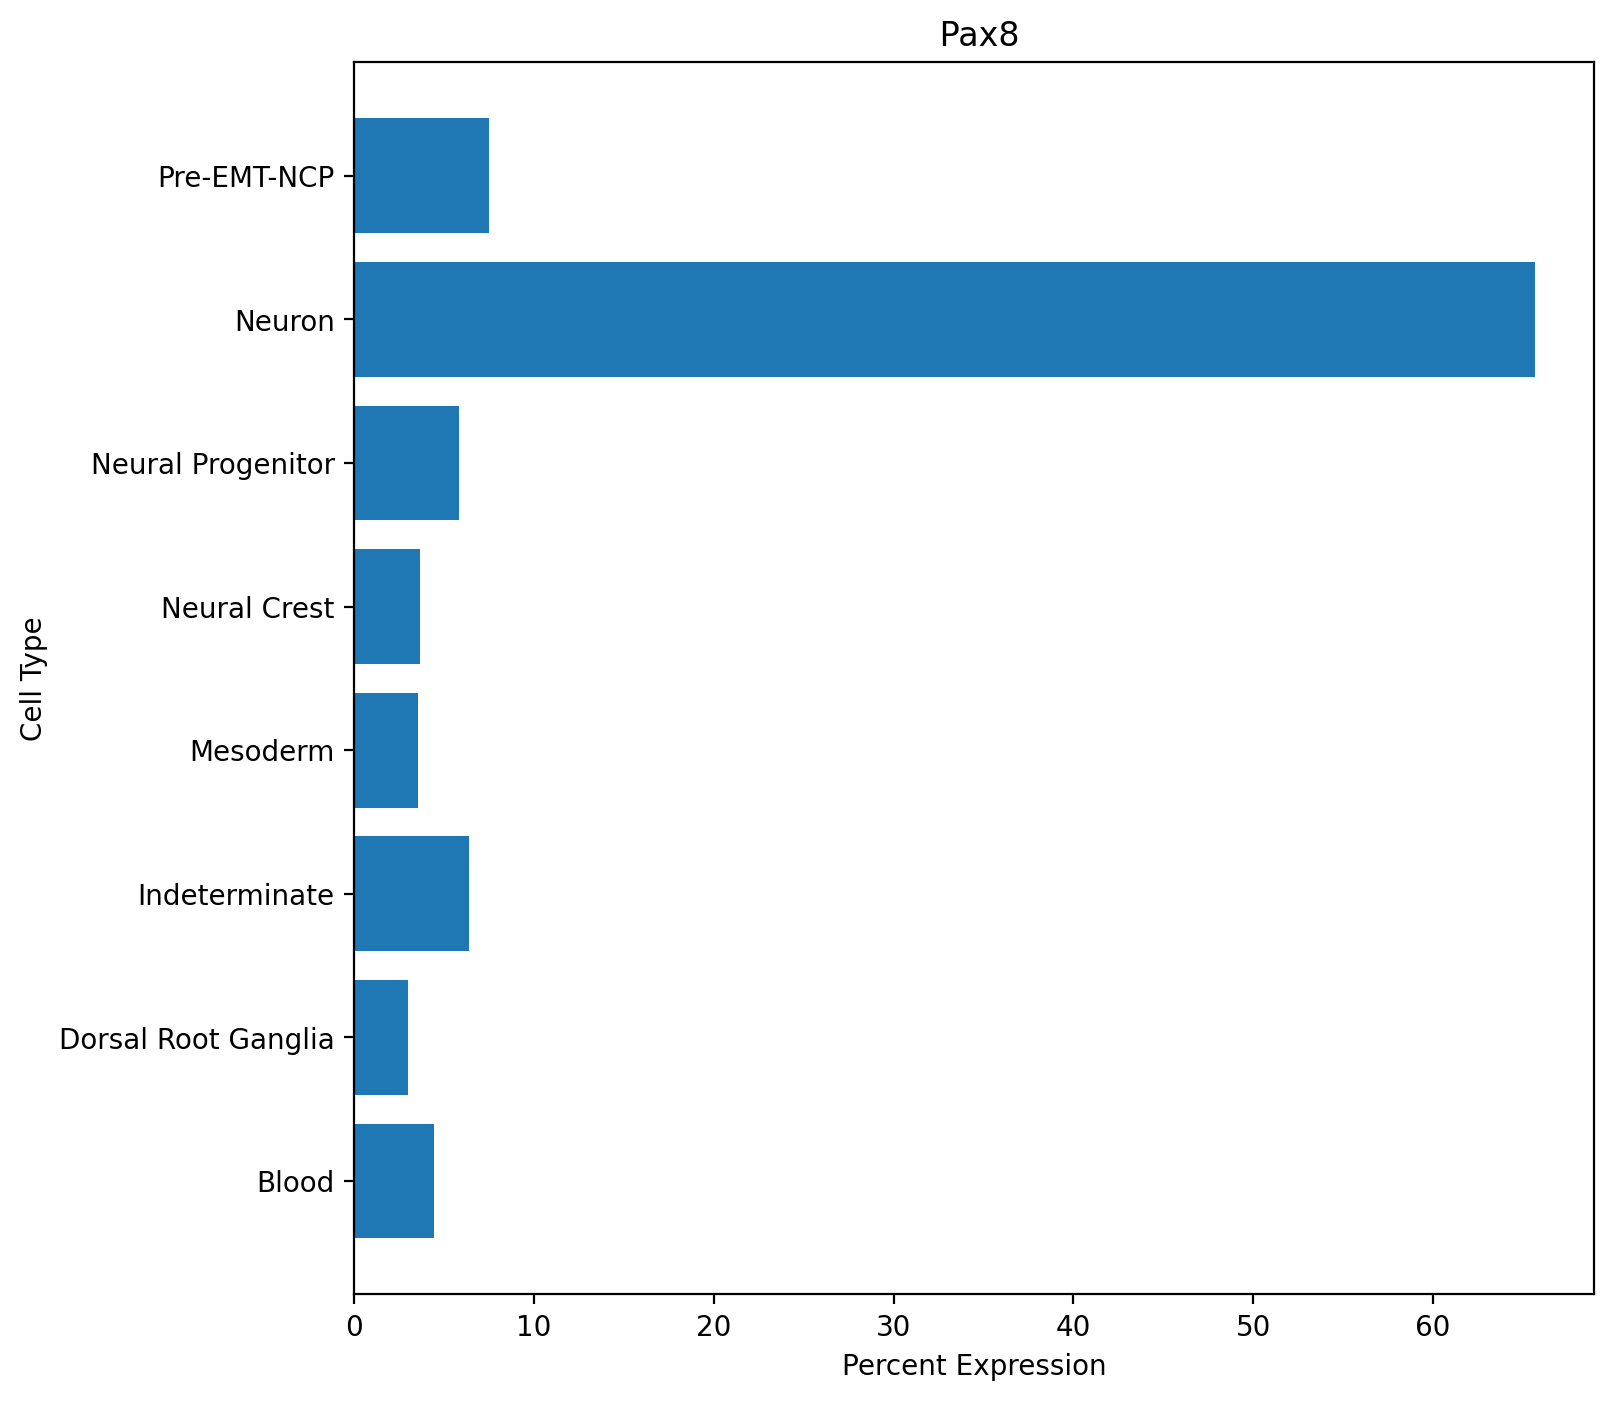

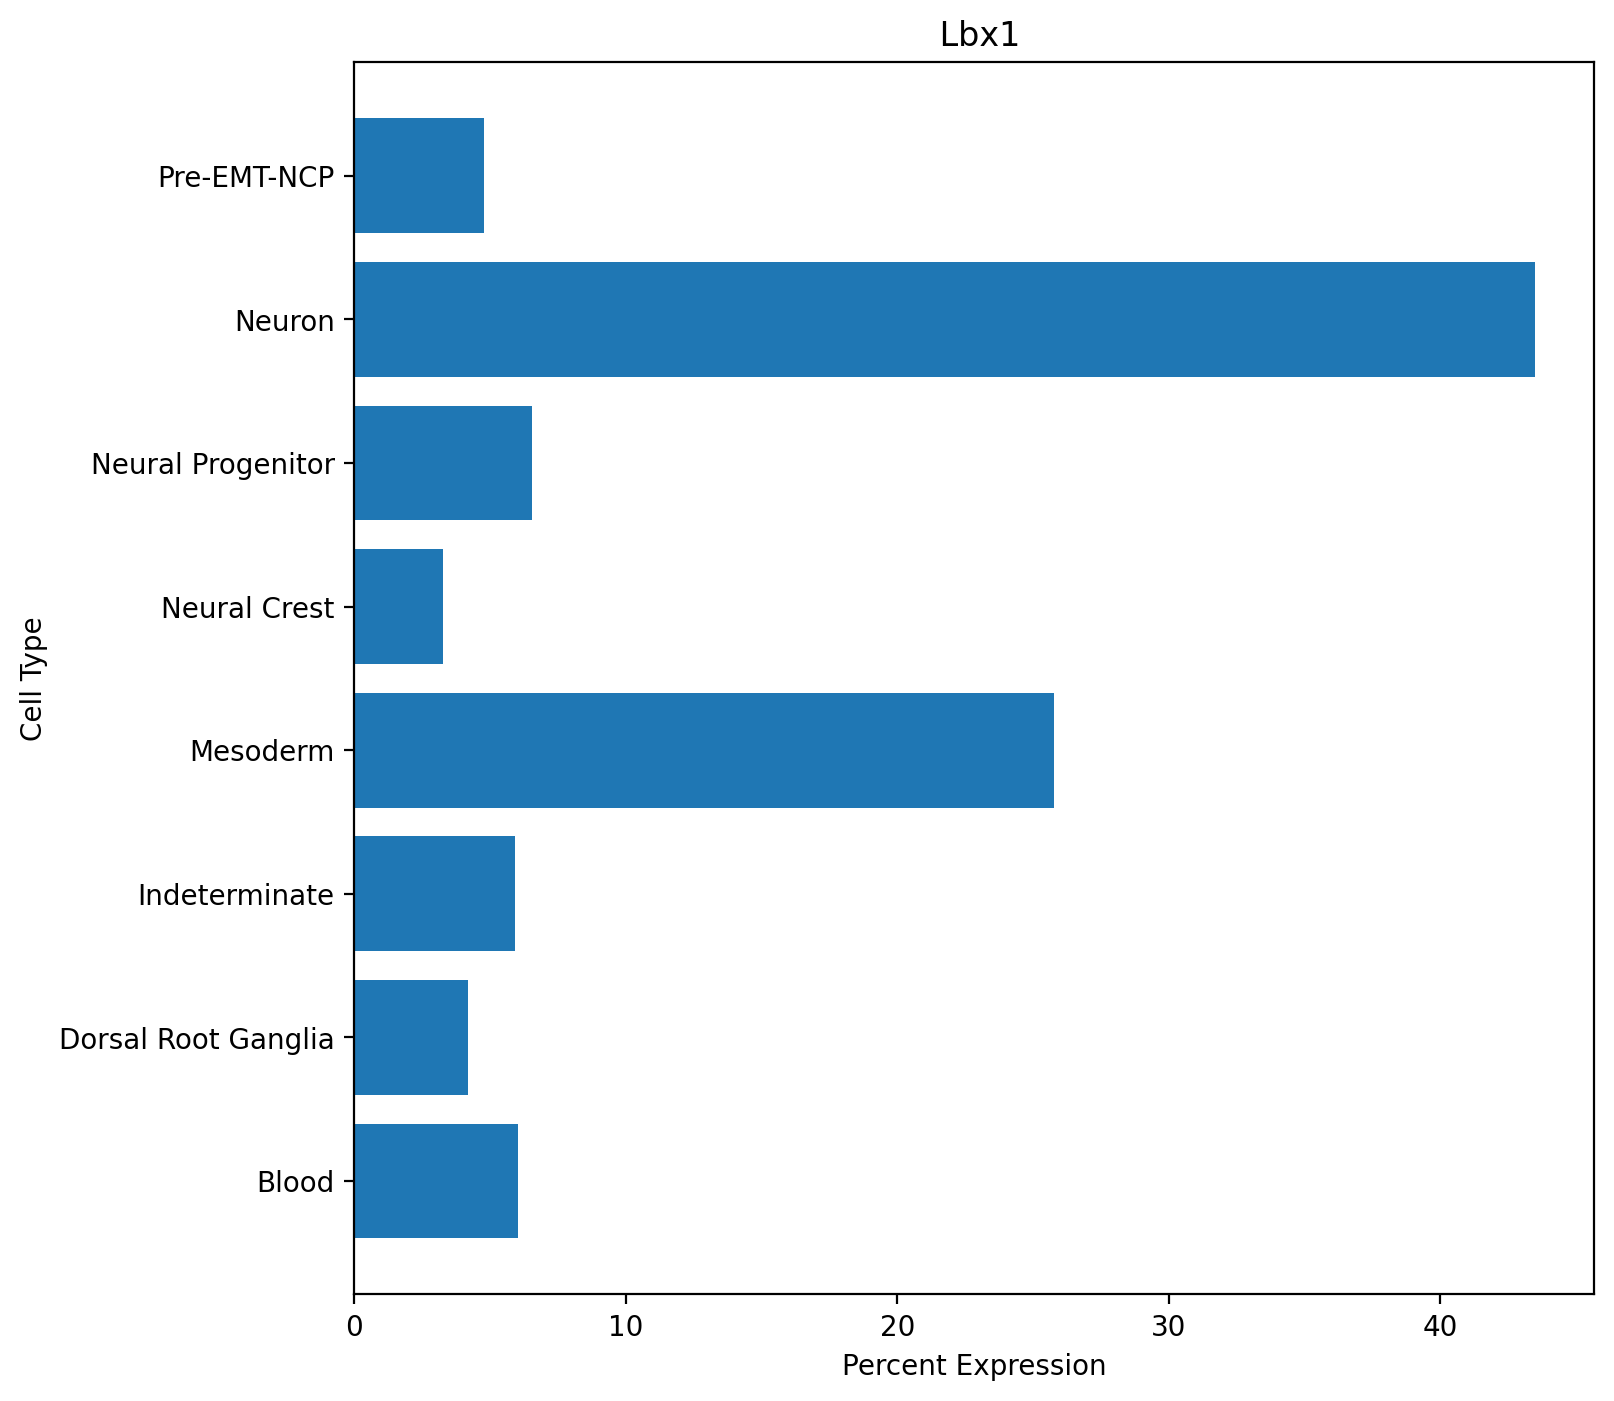

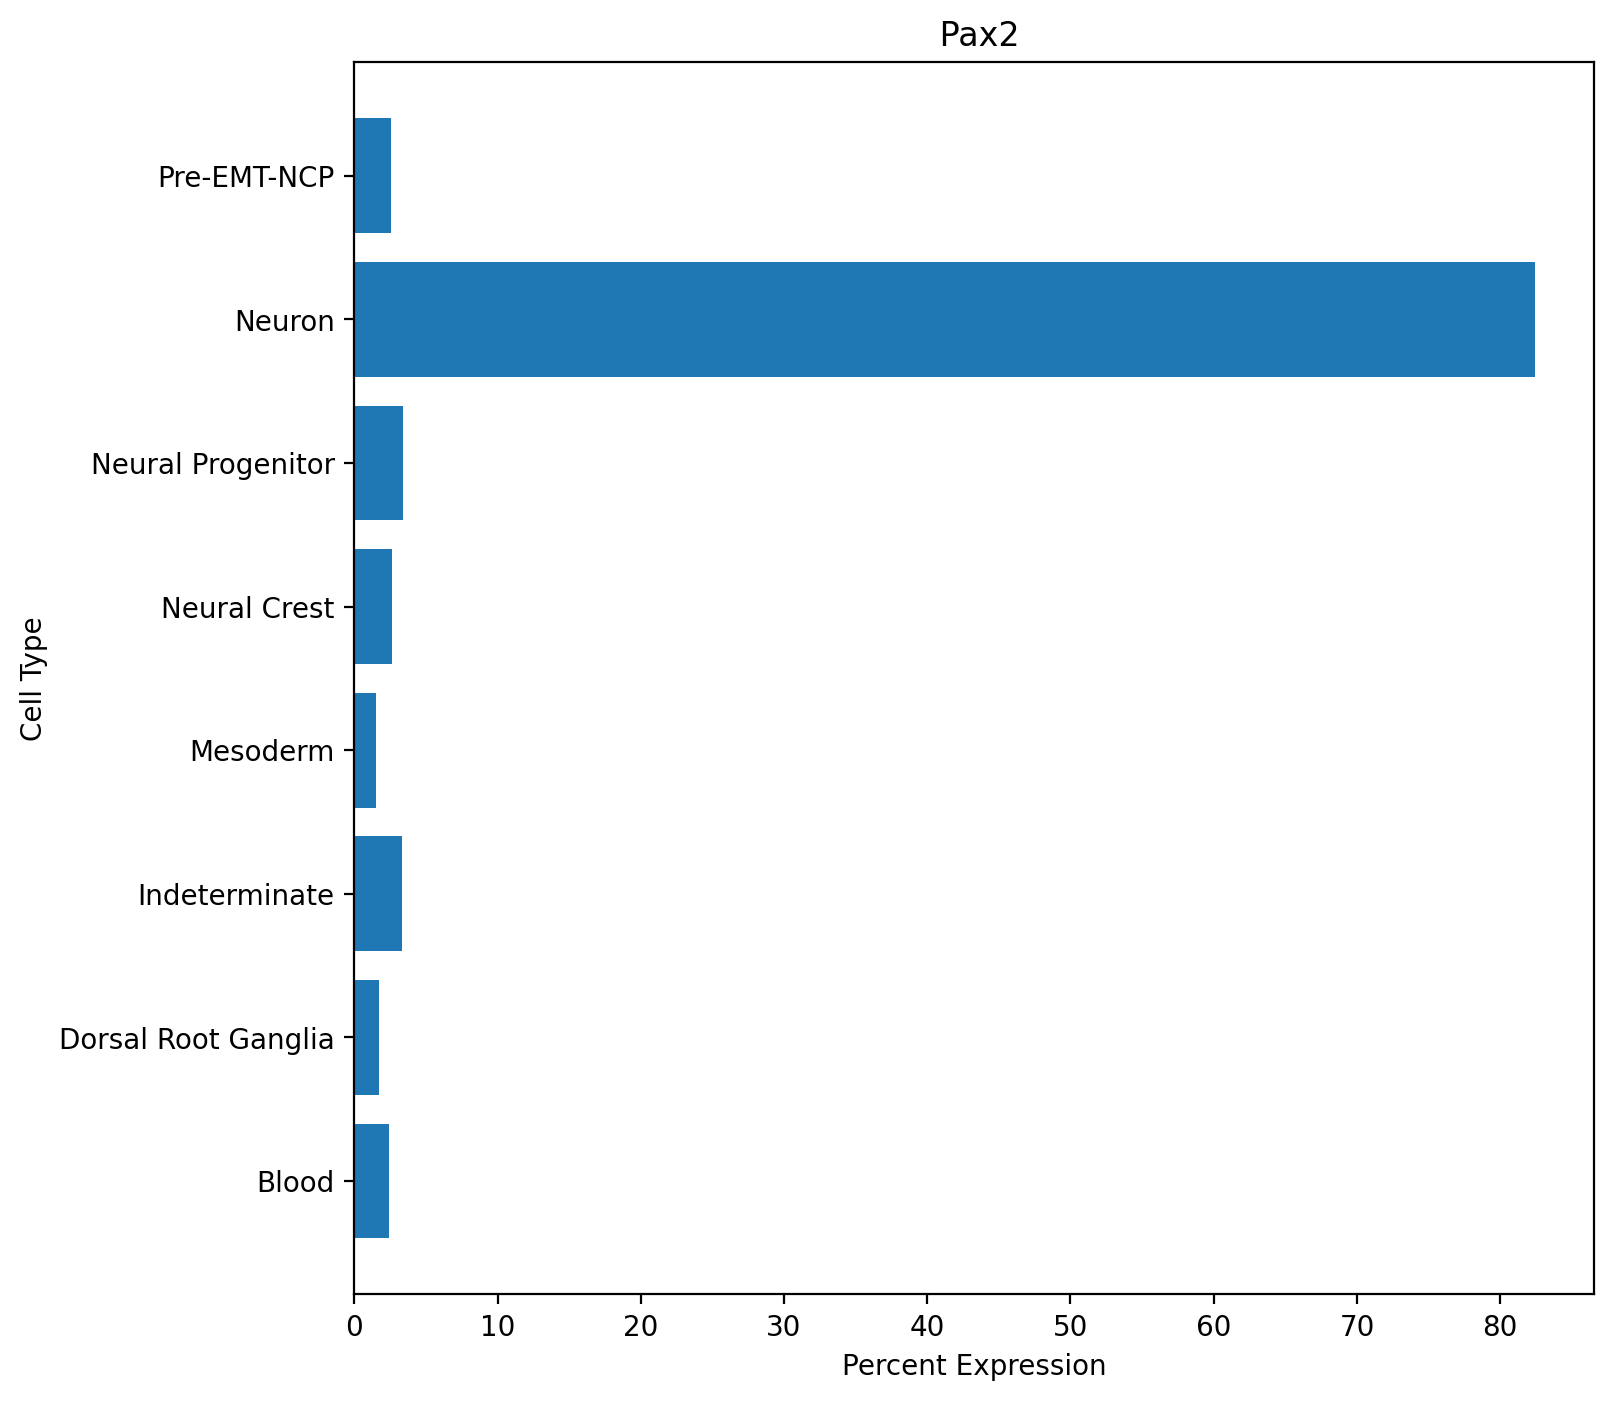

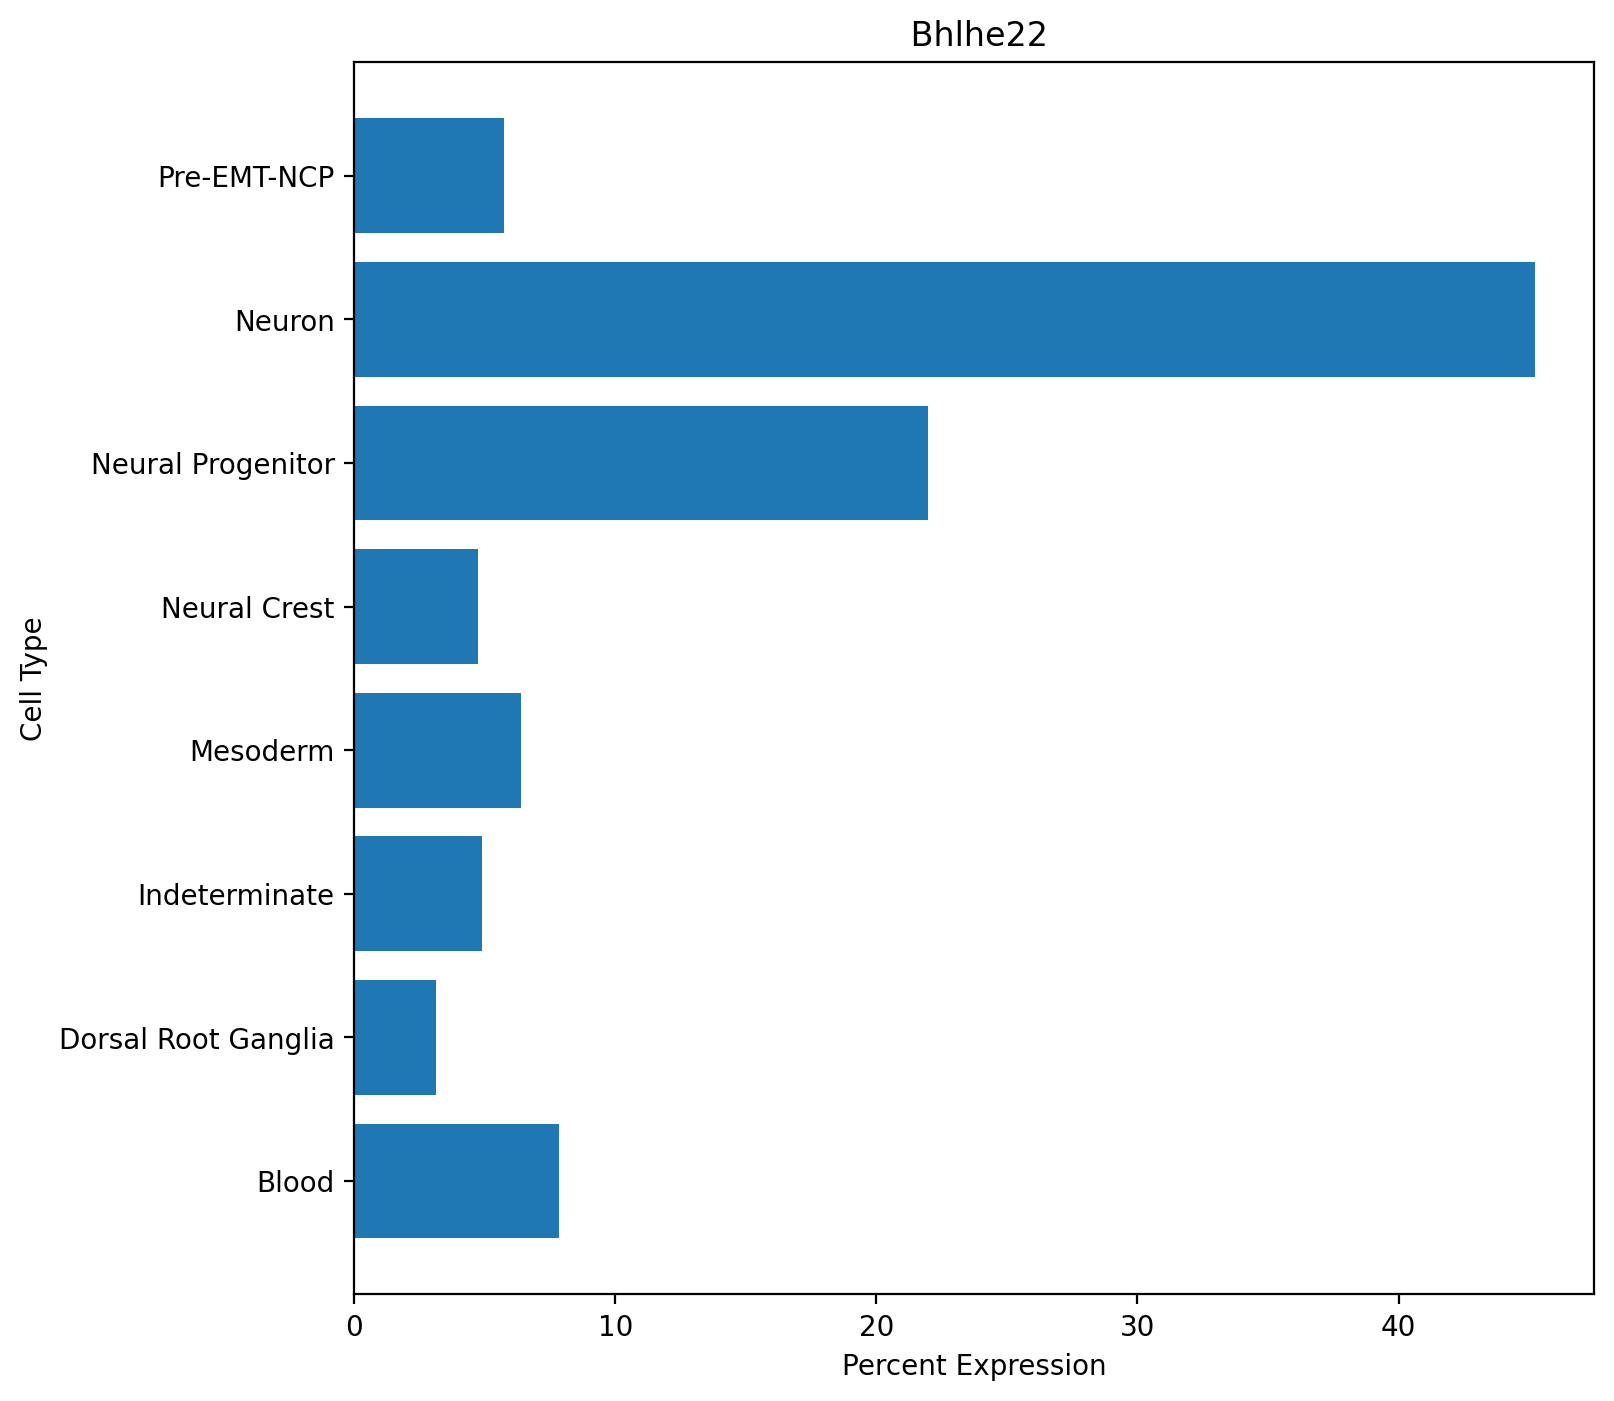

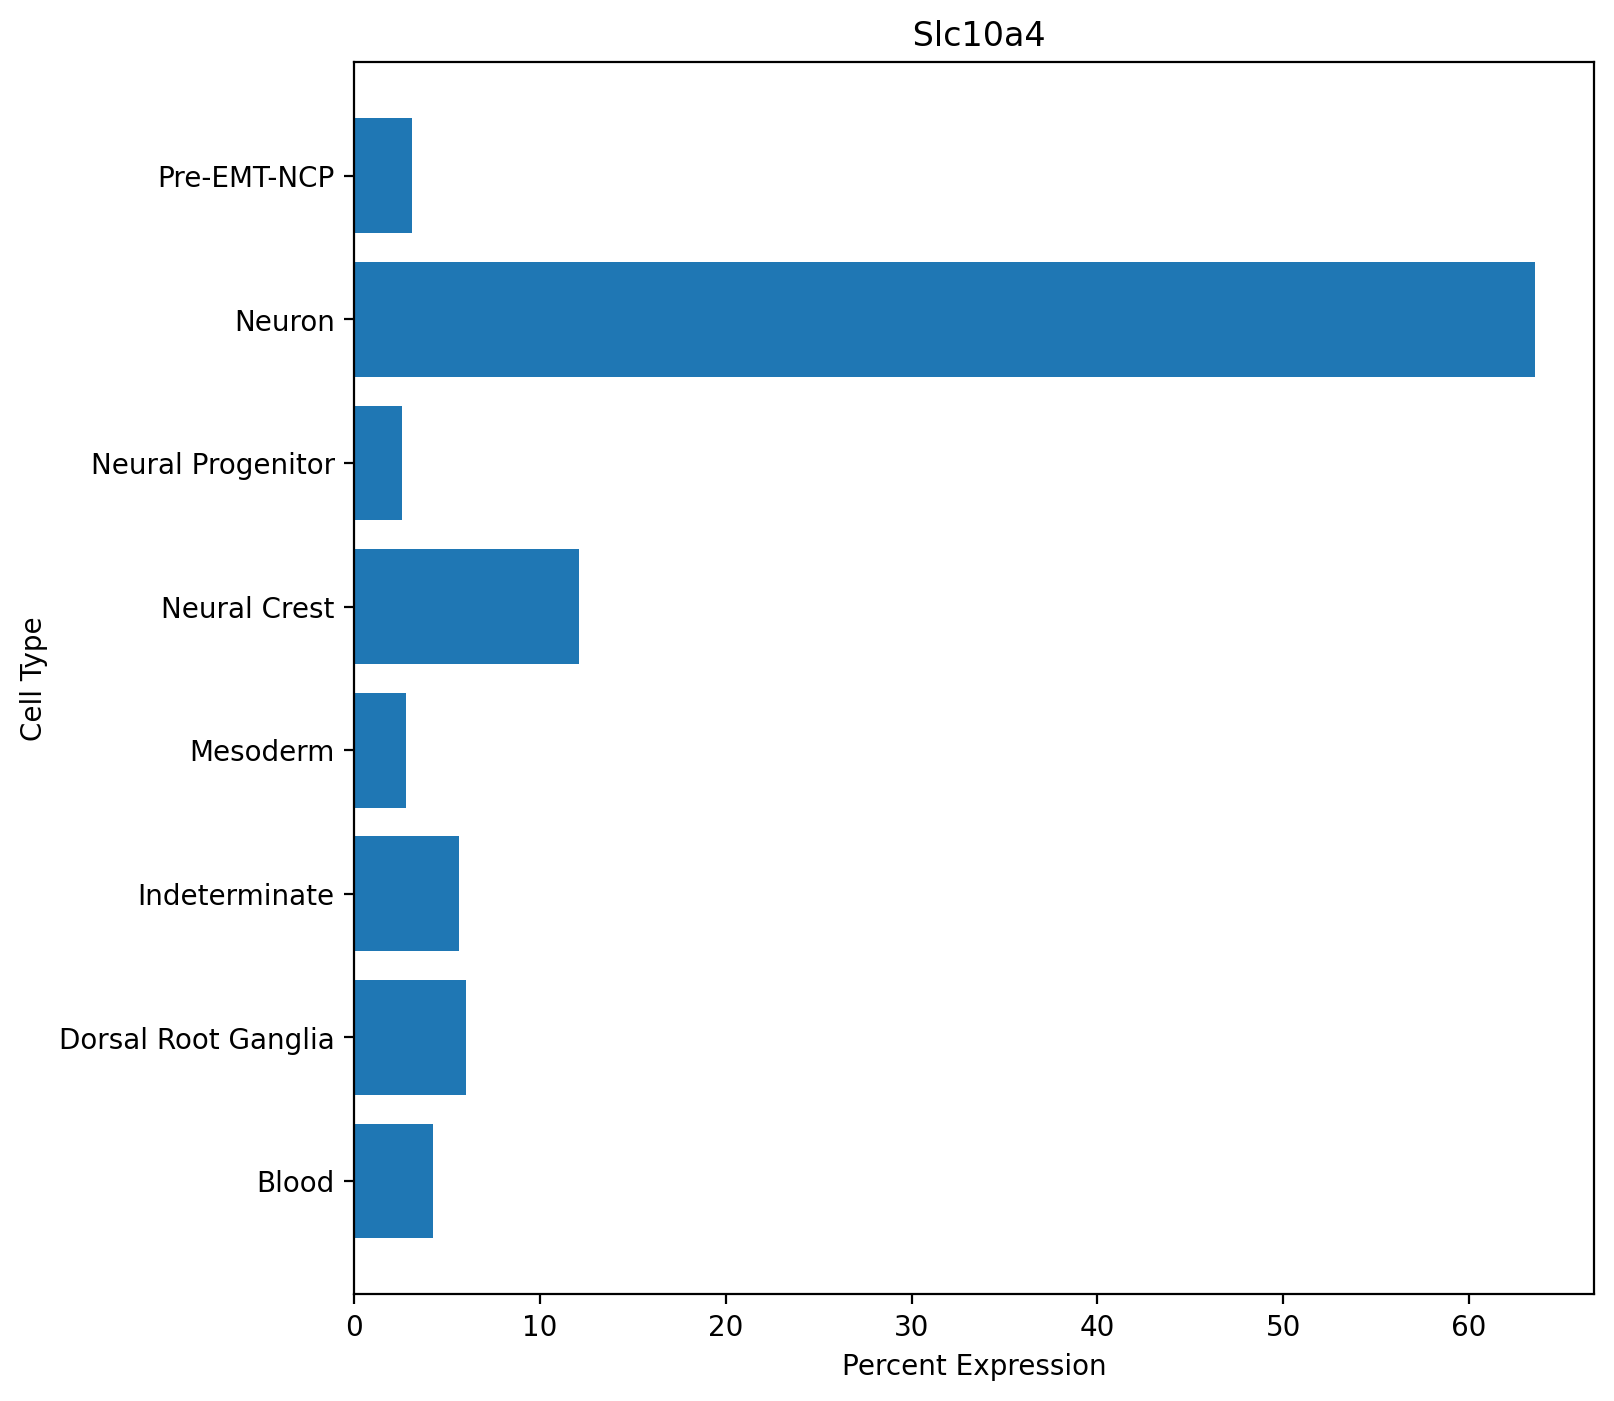

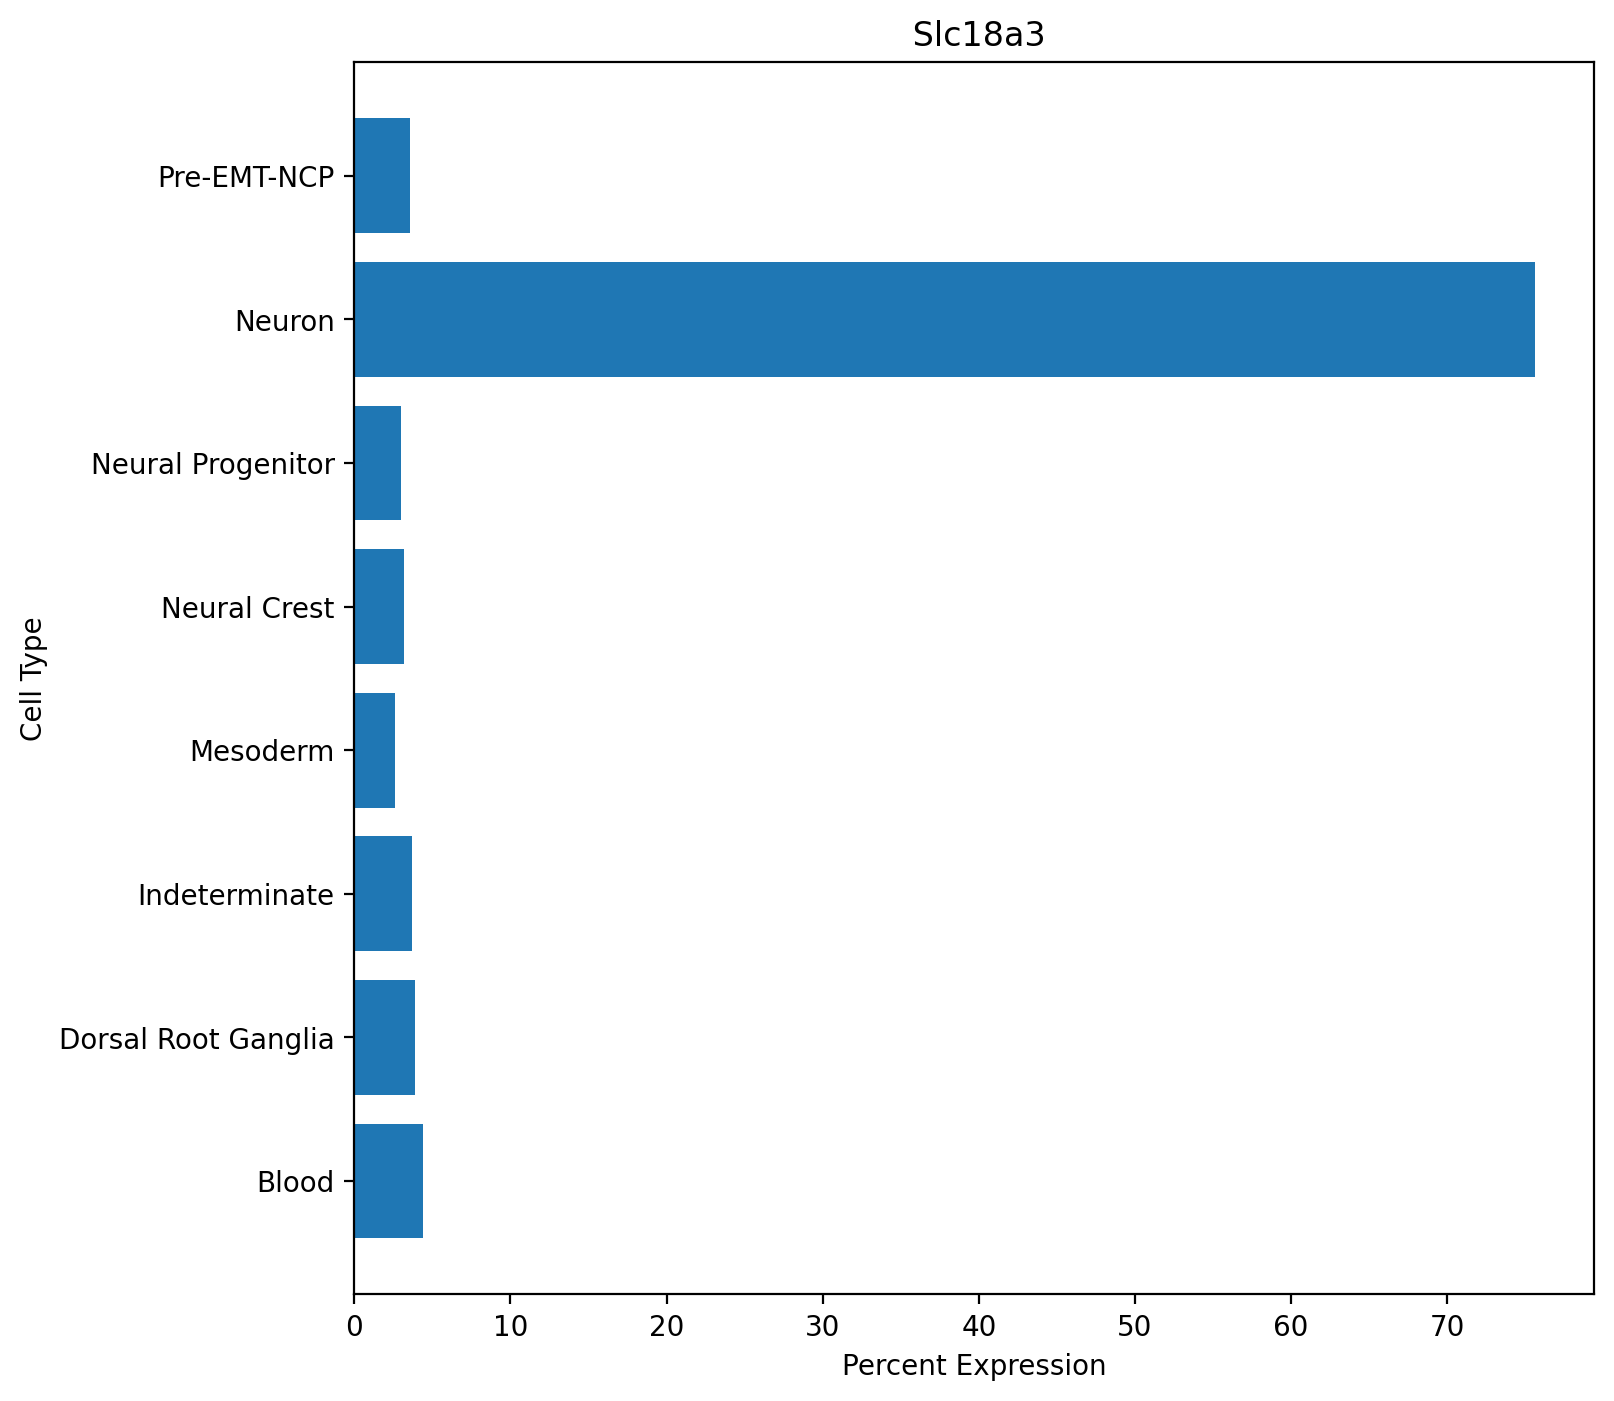

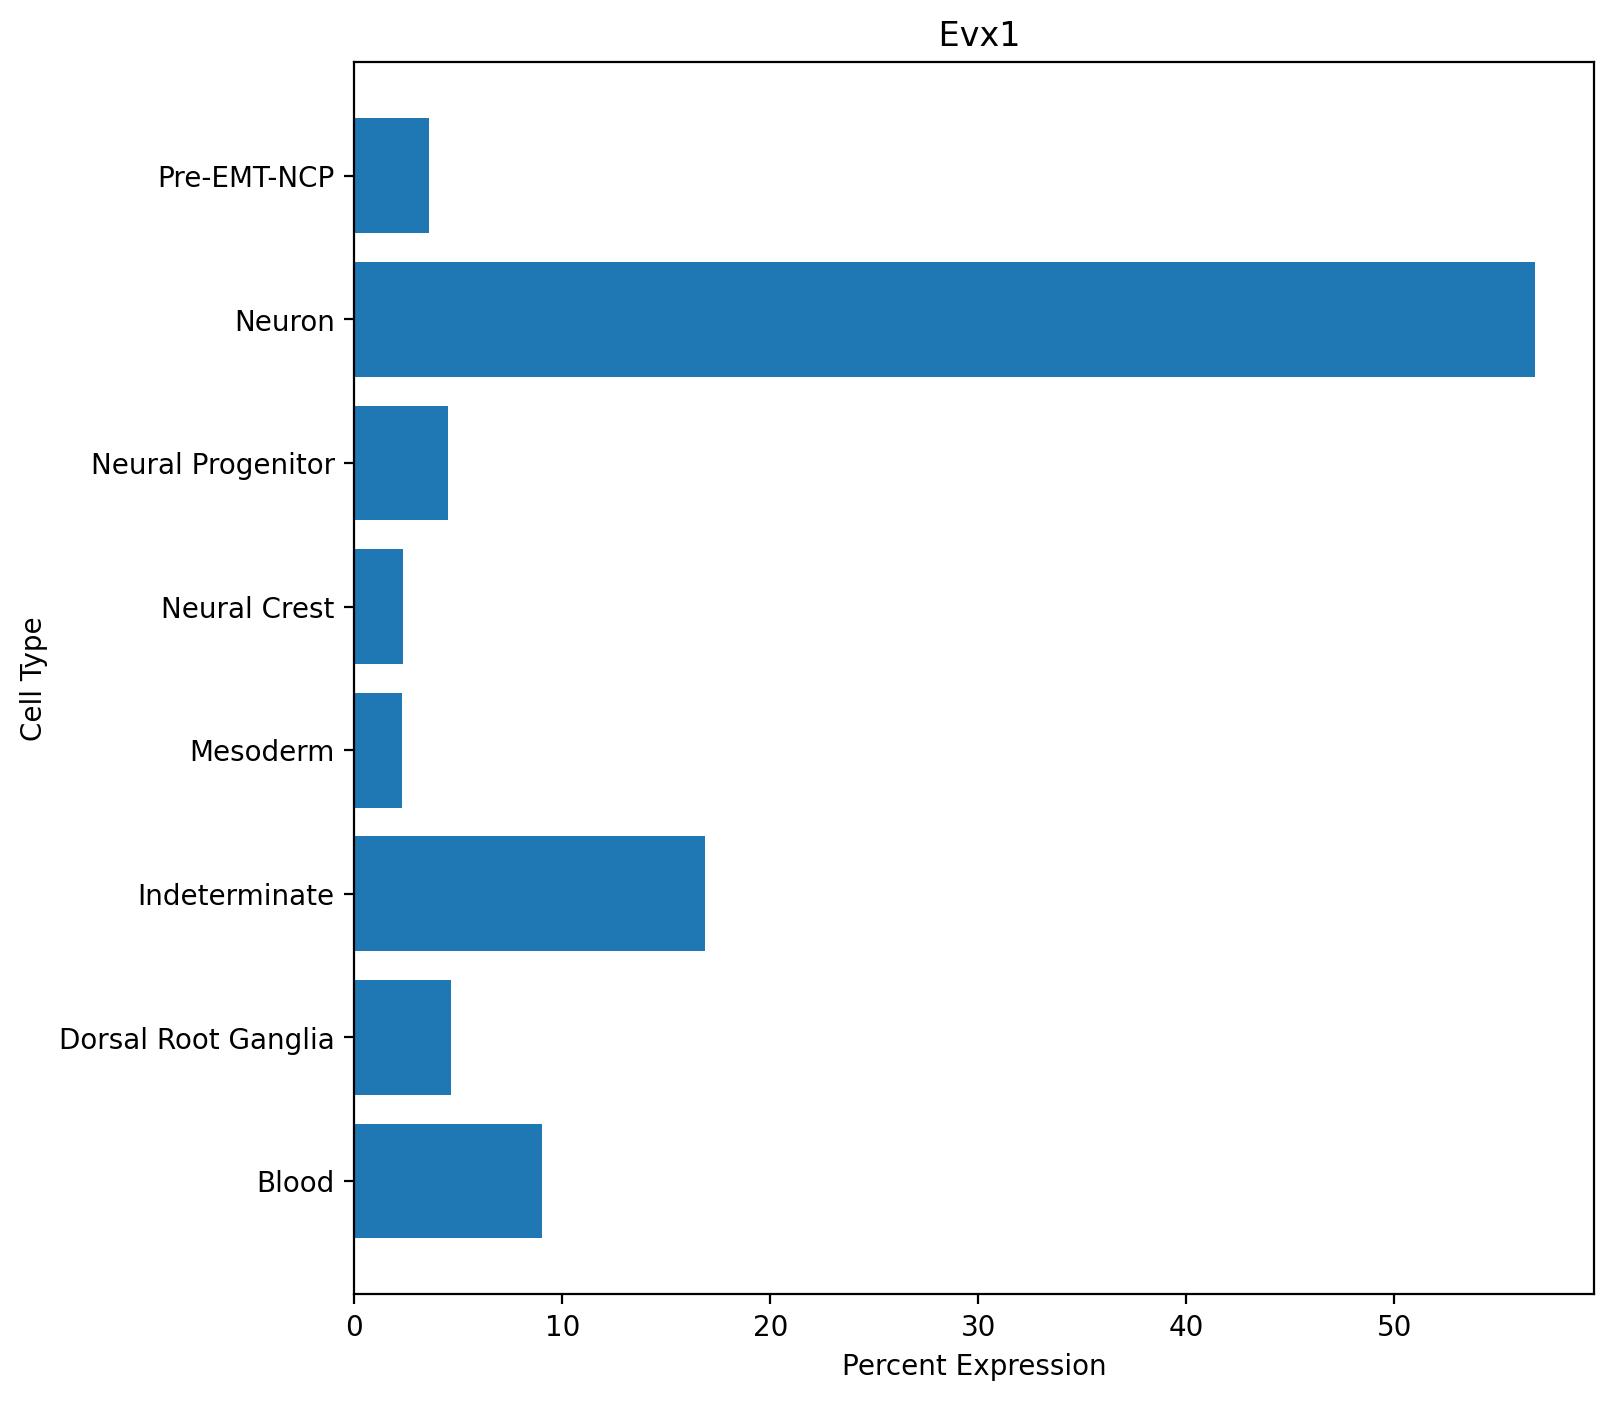

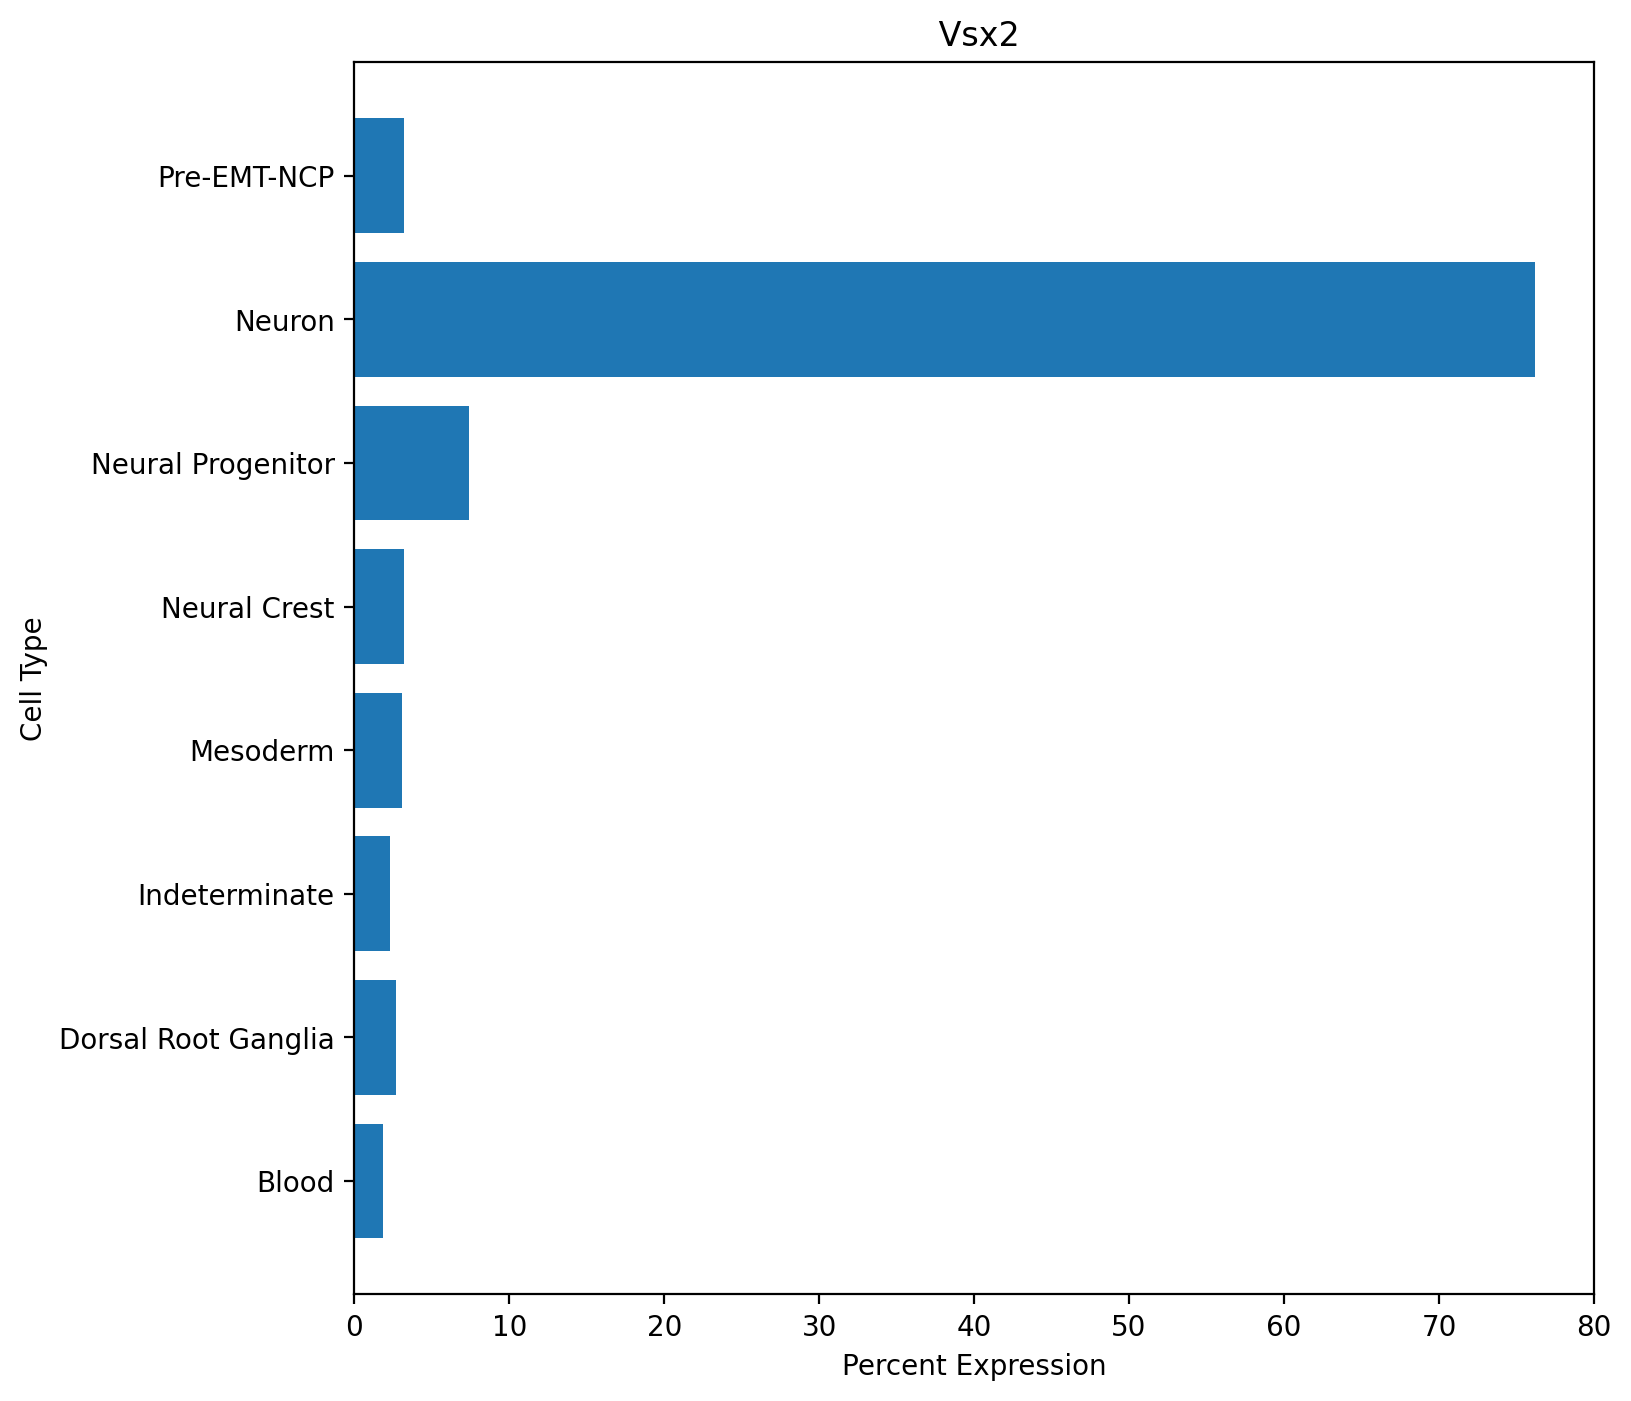

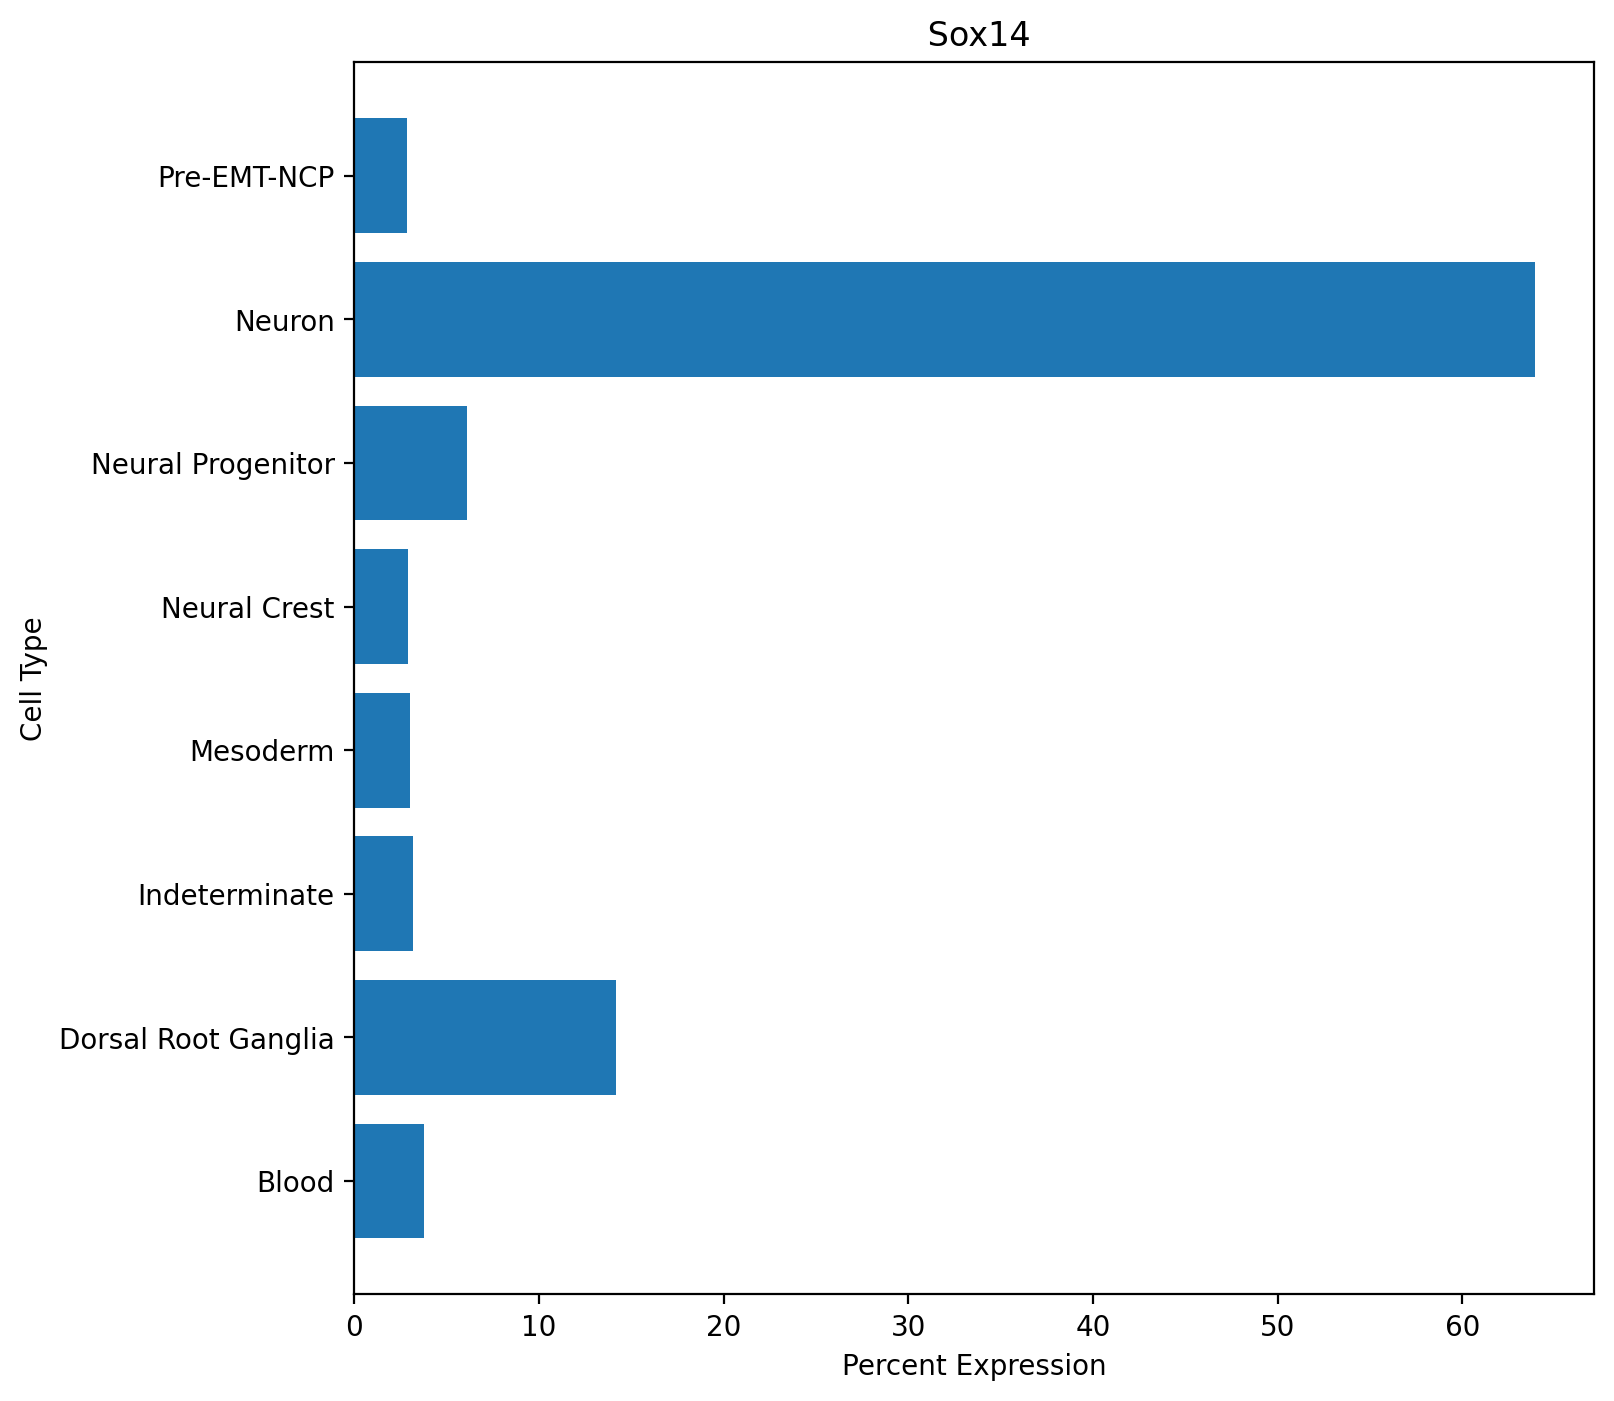

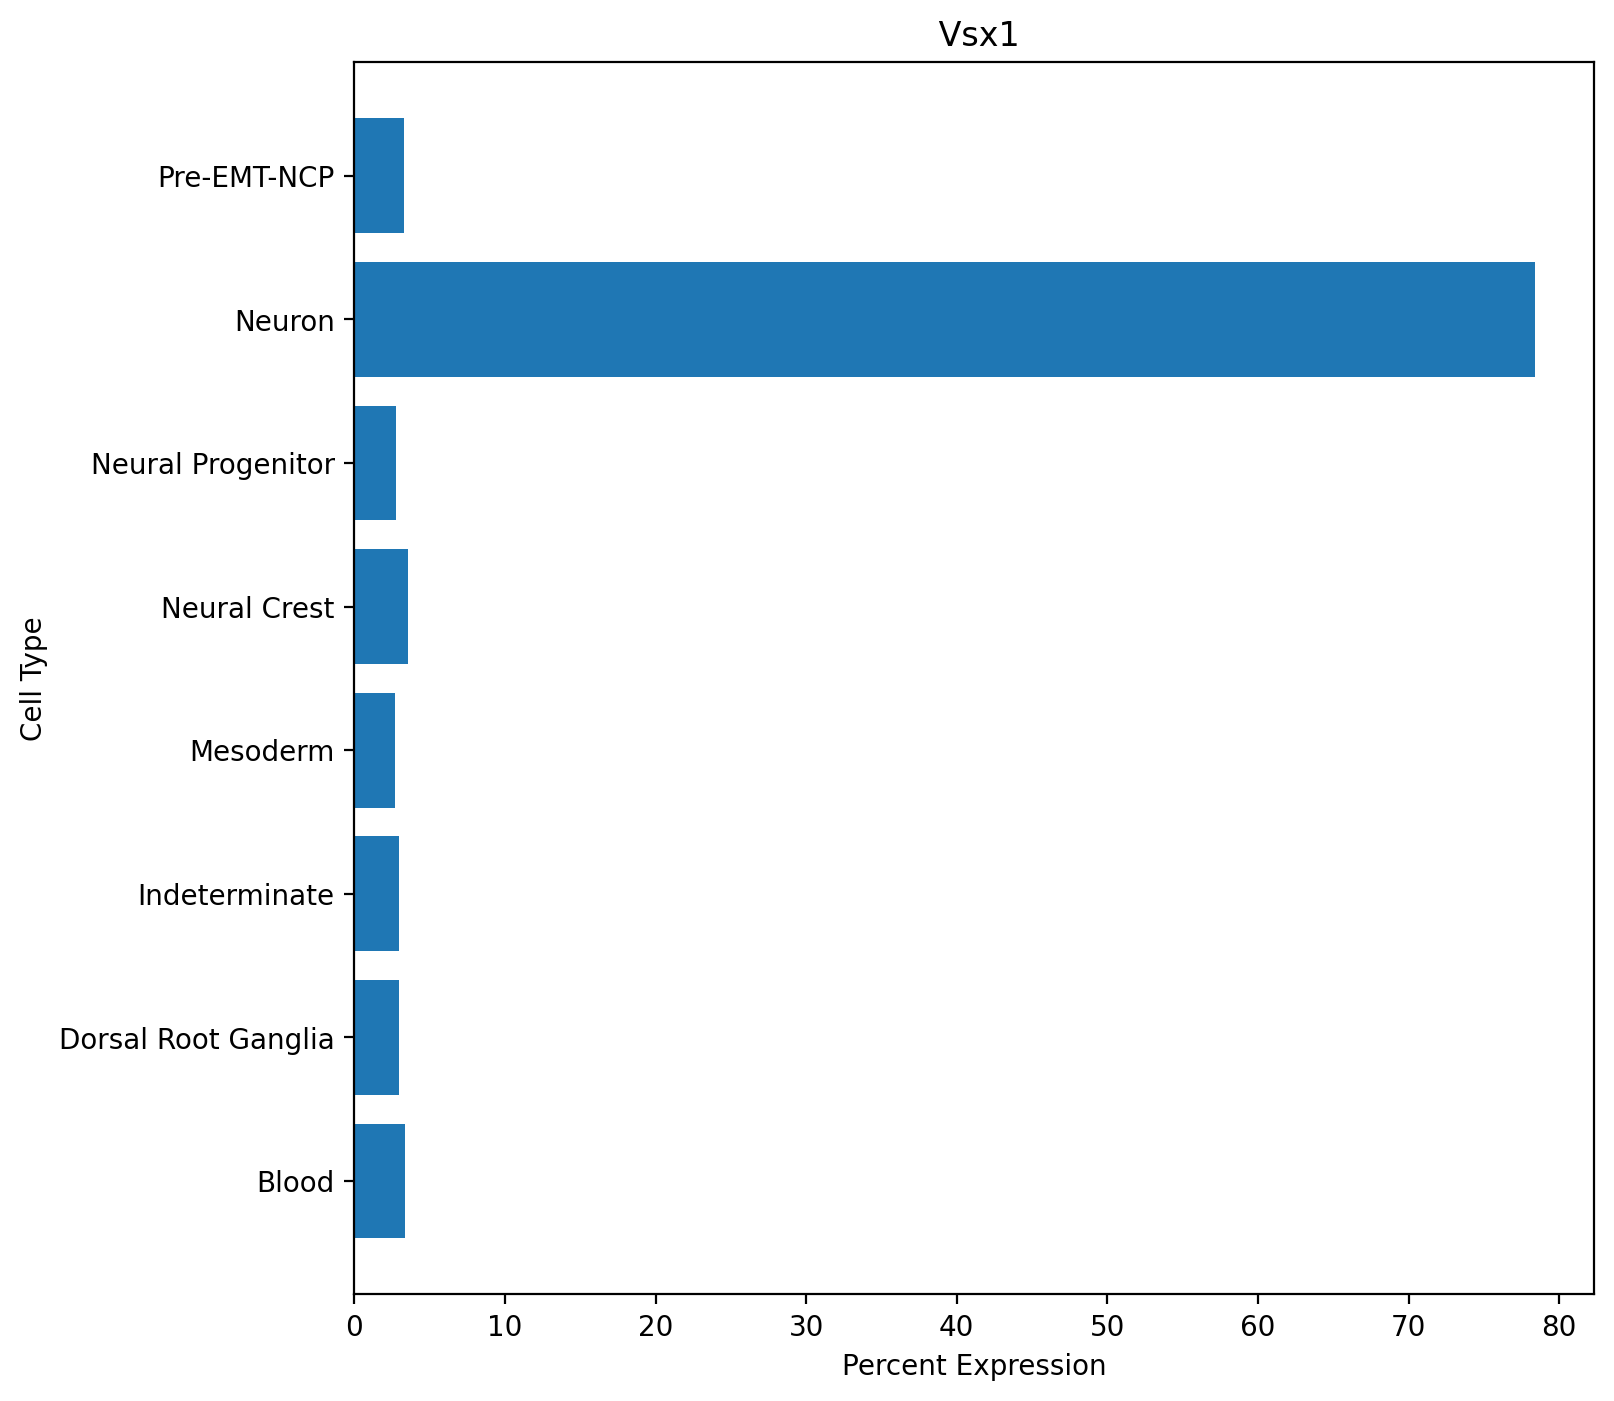

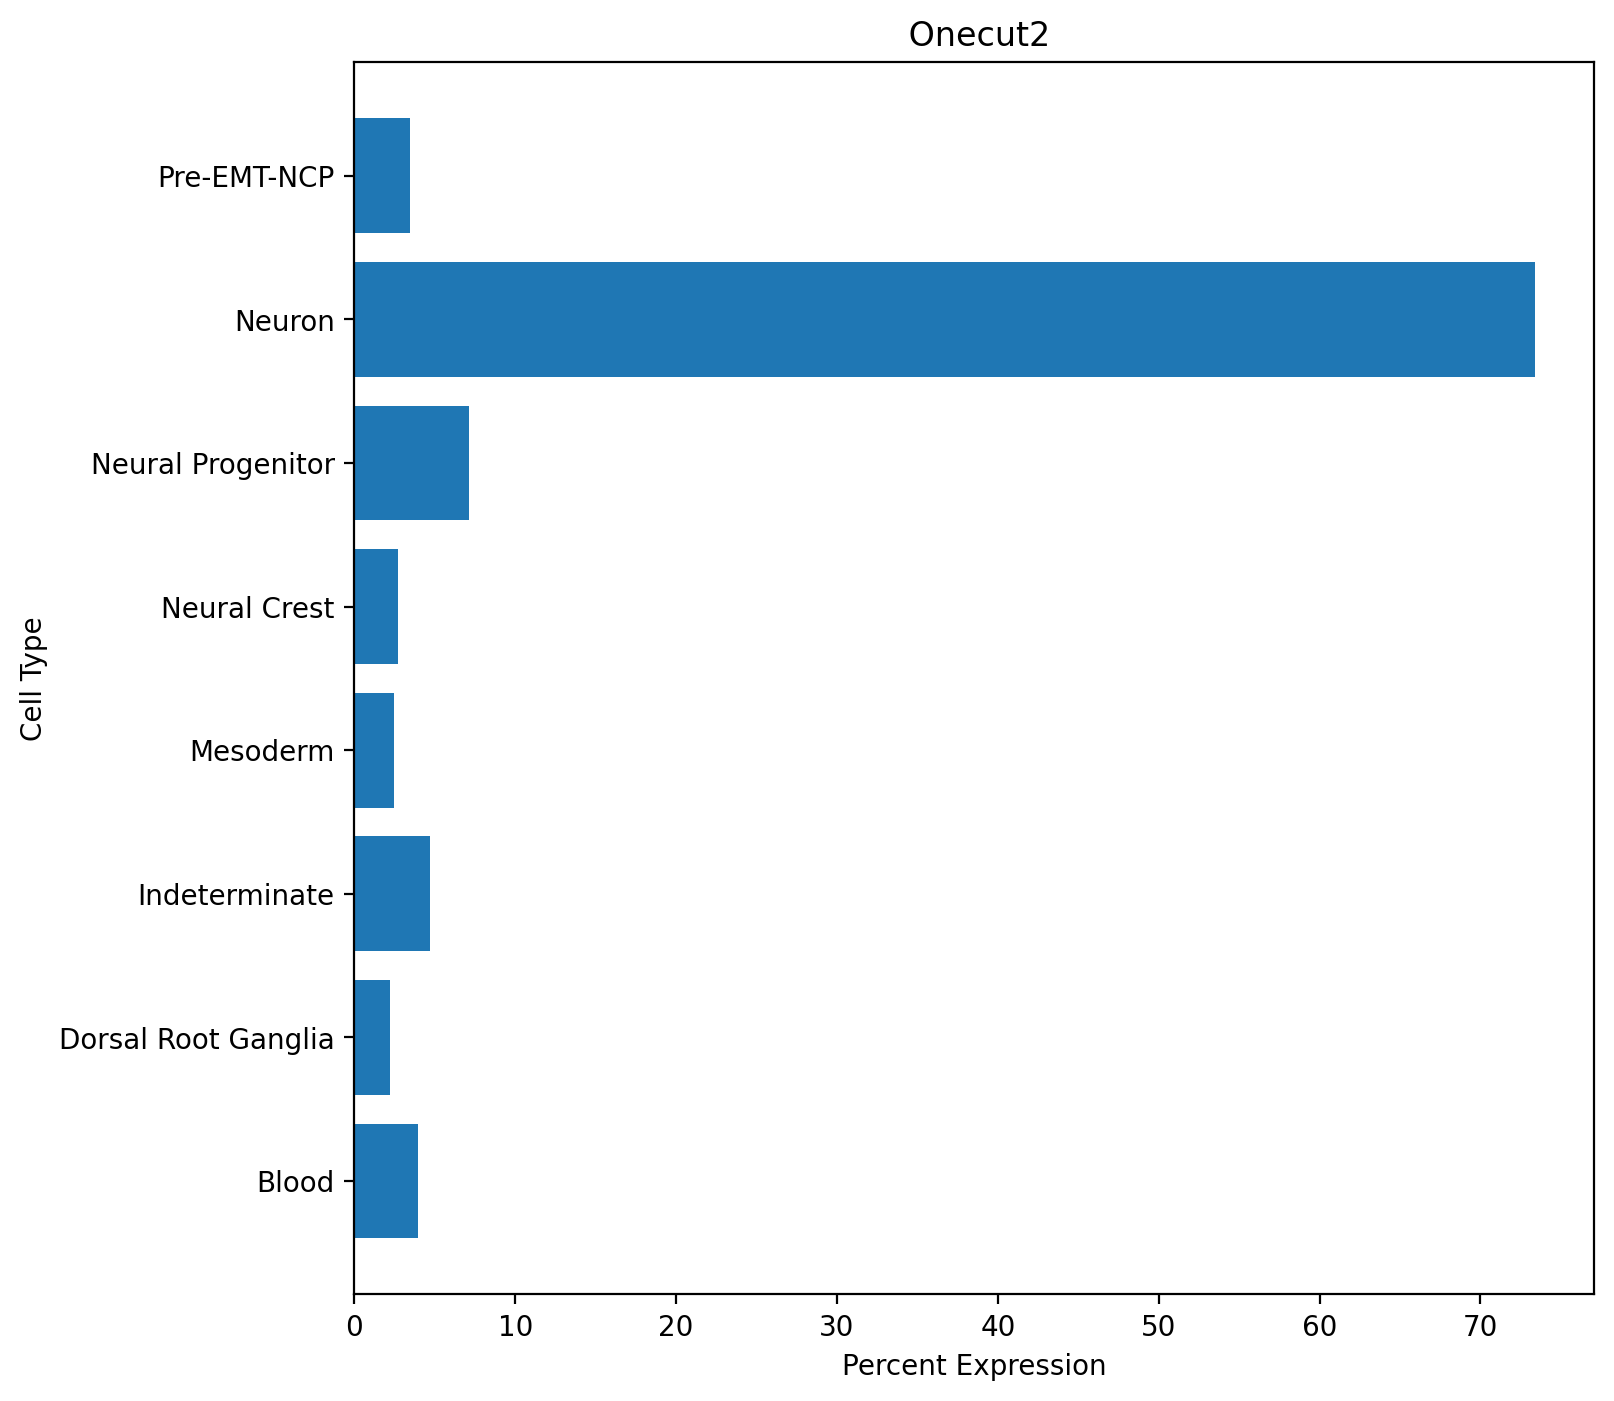

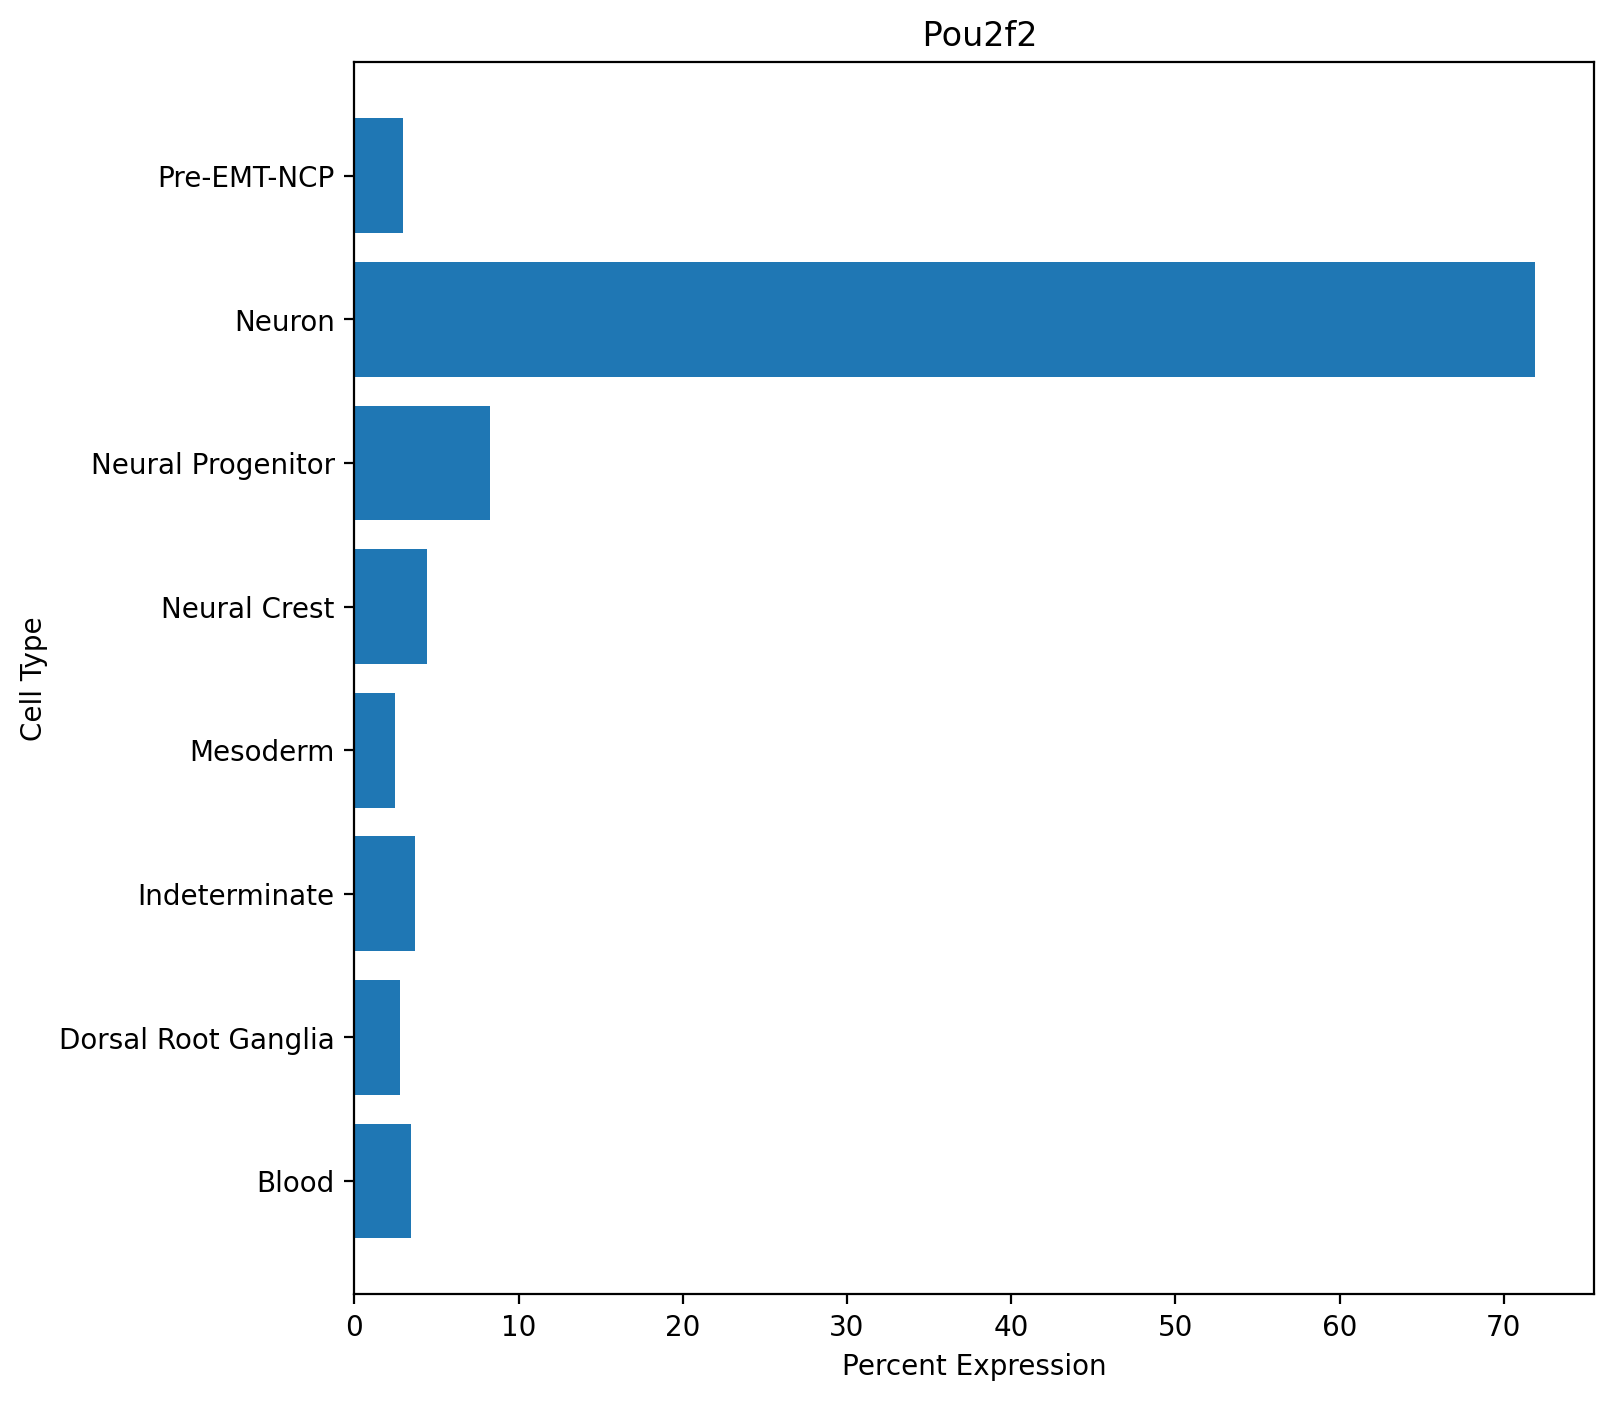

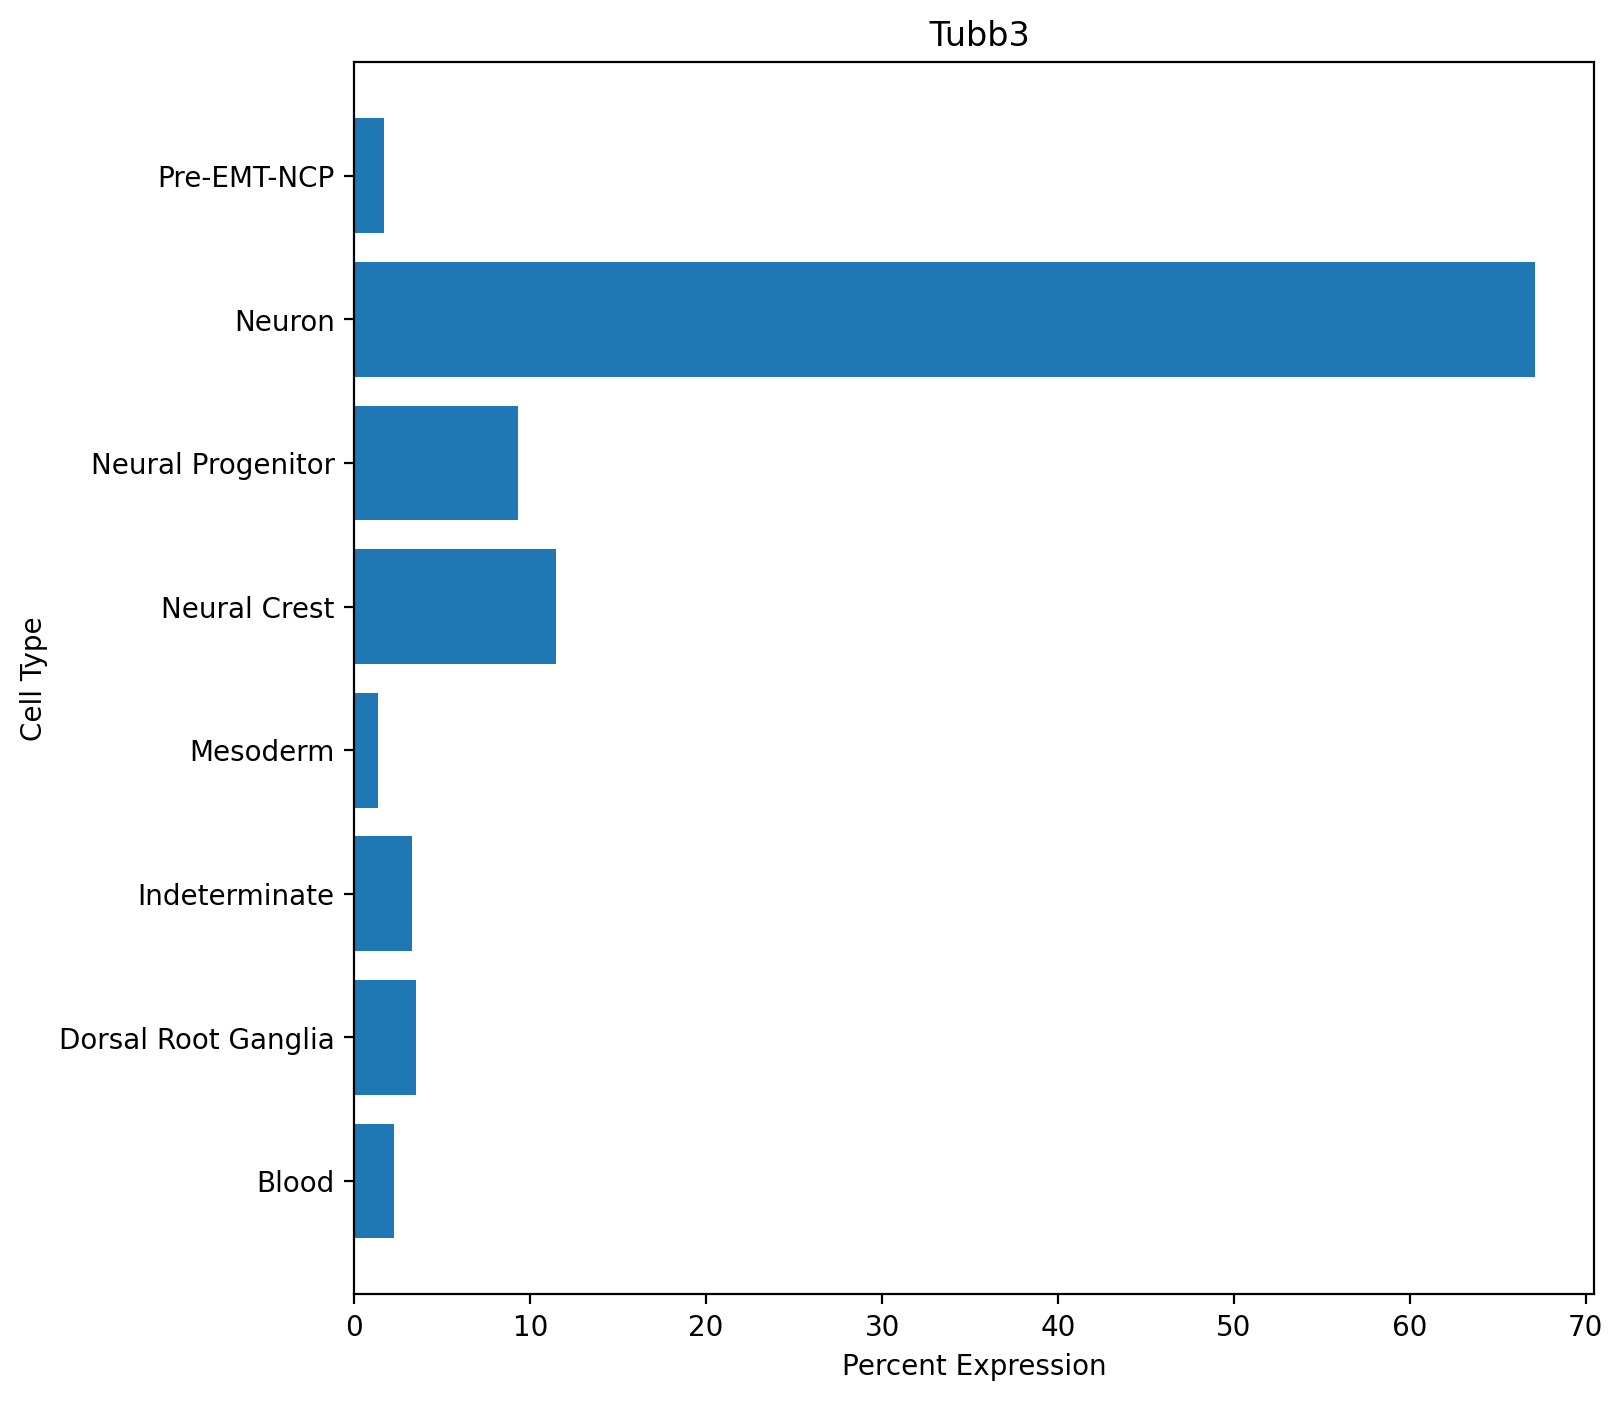

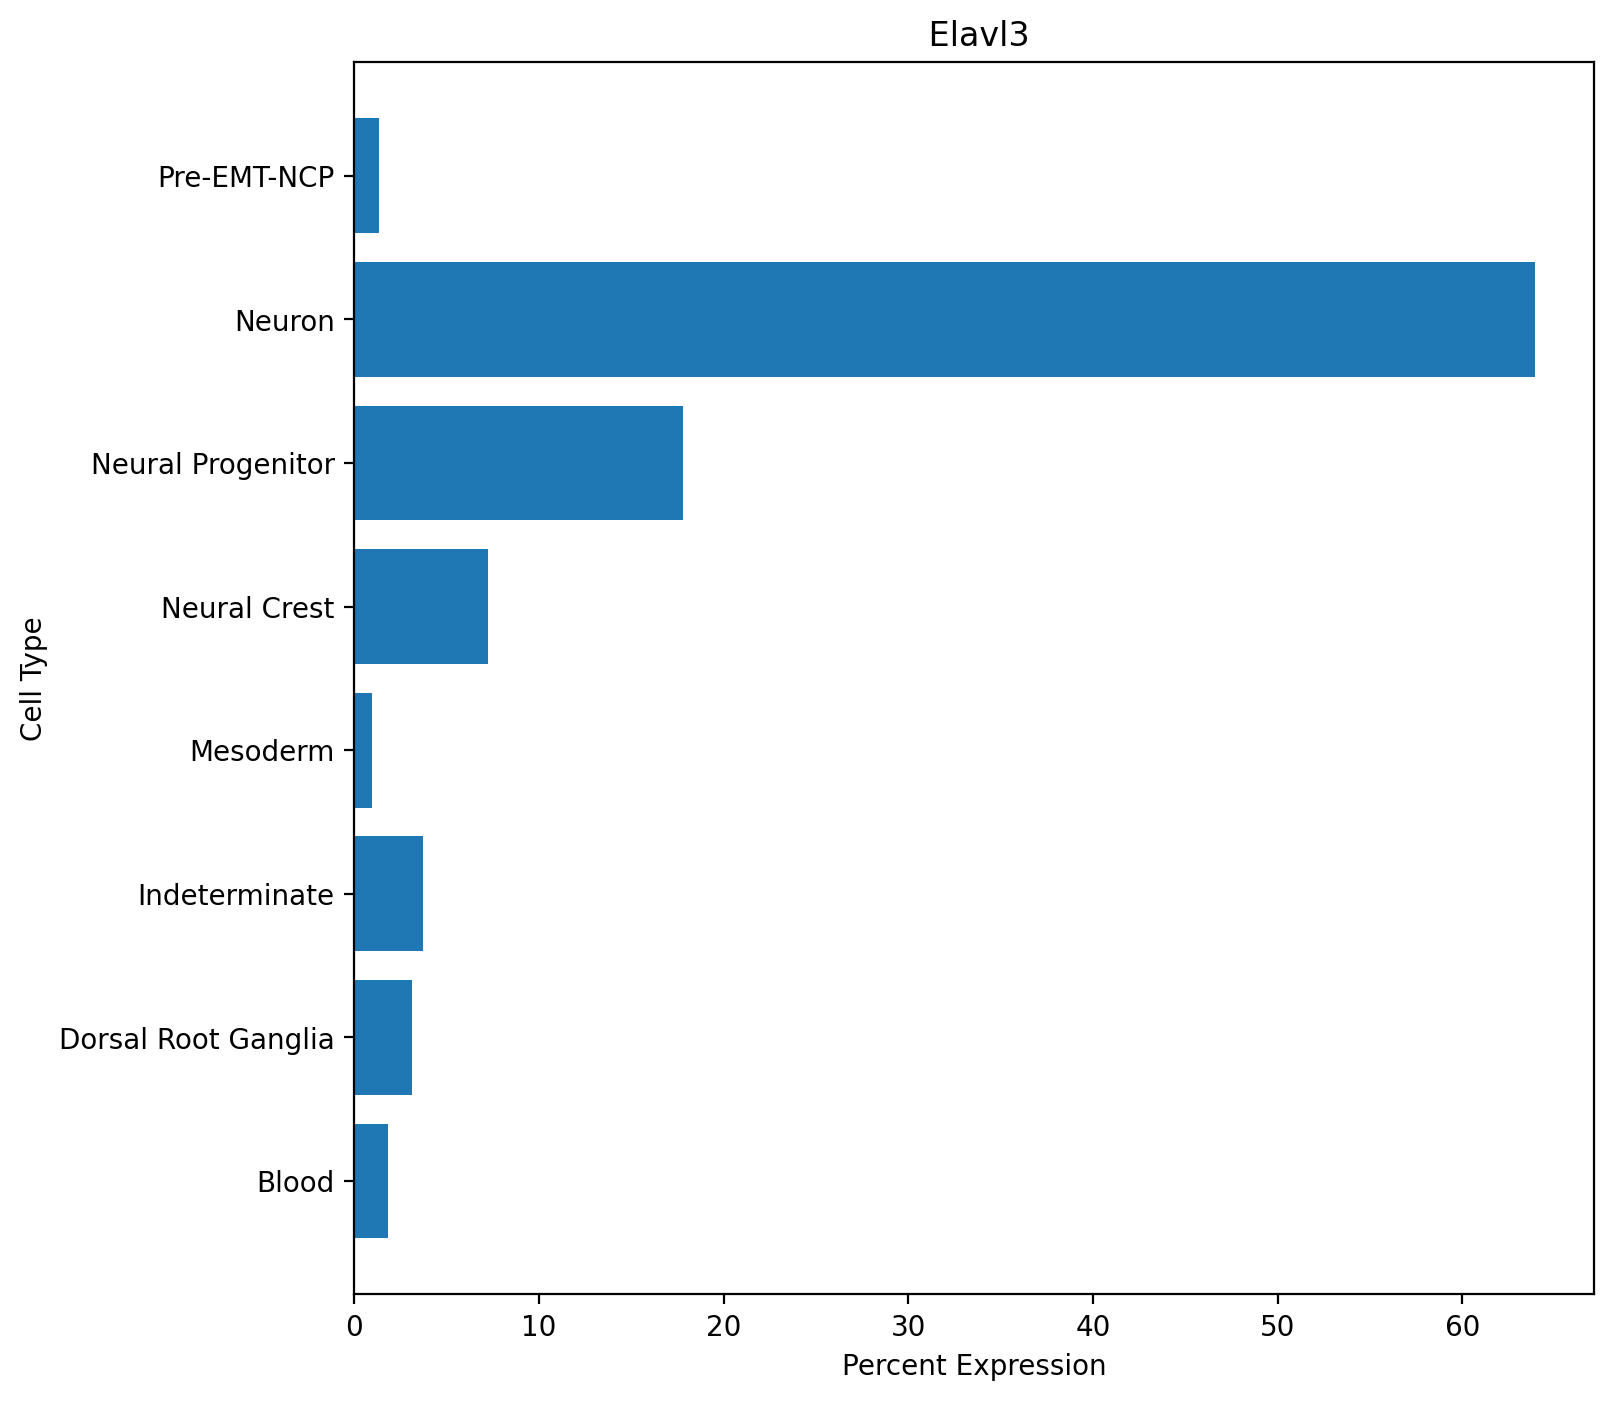

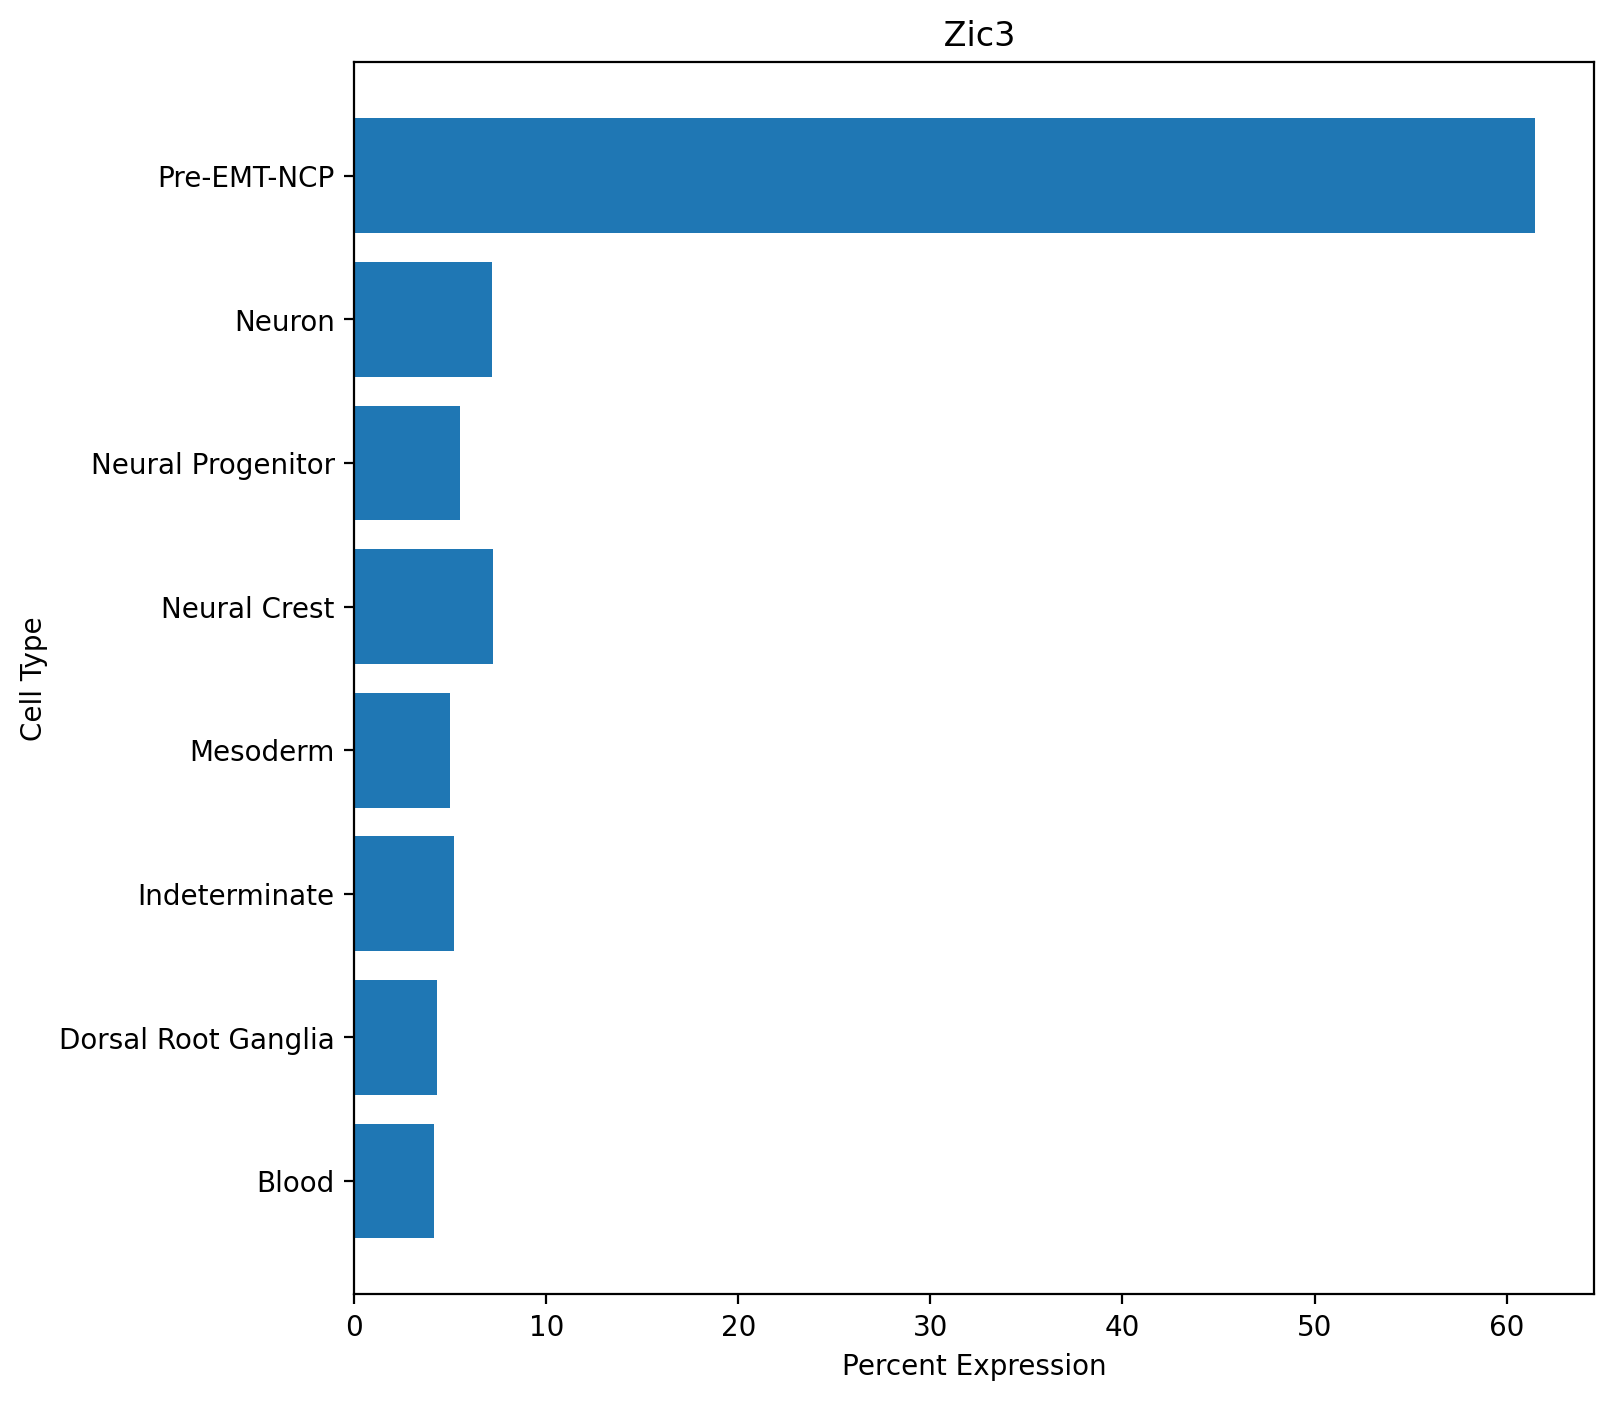

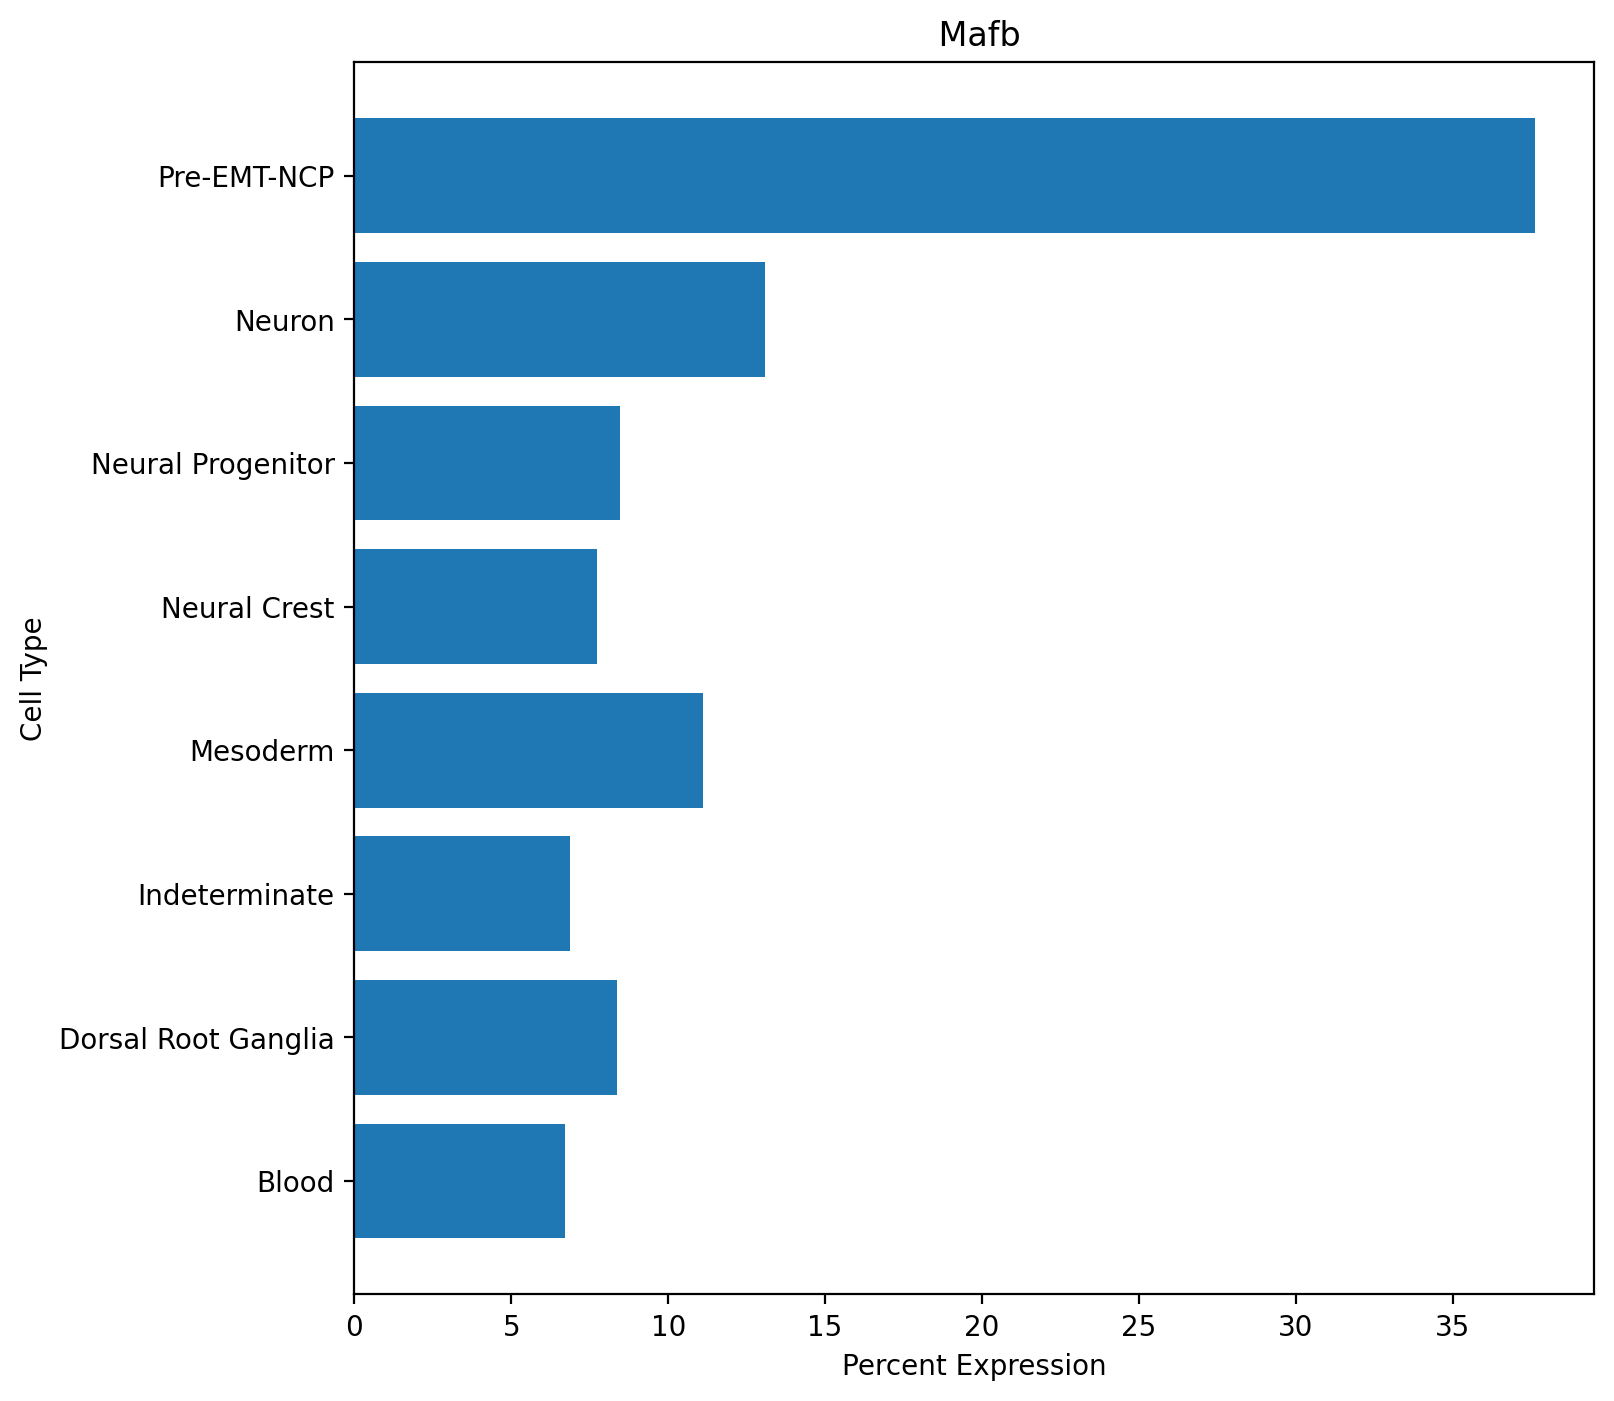

In [14]:
# percent expression per marker gene
#with PdfPages('Marker_percent_expression.pdf') as pdf:
plt.style.use('default')
for gene_column in percent_avg_exp_marker.columns[1:]:
    plt.figure(figsize=(8, 8))
    plt.barh(percent_avg_exp_marker['sctype_pred'], percent_avg_exp_marker[gene_column])
    plt.xlabel('Percent Expression')
    plt.ylabel('Cell Type')
    plt.title(f' {gene_column}')
        #pdf.savefig()
    plt.show()
    plt.close()

In [15]:
# final typing with gene expression
percent_markers_typing = pd.concat([percent_avg_exp_marker, marker_df], ignore_index=True)
percent_markers_typing

sctype_pred       Klf1     Hemgn       Car2      Sox17     Fermt3  \
0                Blood  85.430477  94.43421  87.016747  46.872664  70.849143   
1  Dorsal Root Ganglia   1.688205  0.513004   1.618142   5.760394    4.01626   
2        Indeterminate   2.855065  1.581815   2.344489   5.774557   3.744933   
3             Mesoderm   1.659024  0.435365   1.491387   5.252797   3.674005   
4         Neural Crest   1.910308  0.295795   1.149736   6.533619   4.324631   
5    Neural Progenitor   1.913226  0.487996   1.613159   6.510508   3.631825   
6               Neuron   2.676261   0.77124   1.445481   8.624255   3.790169   
7          Pre-EMT-NCP   1.867434  1.480574    3.32086  14.671206   5.969033   
8                  NaN      Blood     Blood      Blood      Blood      Blood   

        Tlx2       Krt8      Foxc1      Foxc2  ...       Vsx2      Sox14  \
0   1.226626    5.92796   8.302483   9.287615  ...   1.883905   3.787424   
1  64.060727  68.297592    2.97396   3.377694  ...   2.715242  14.179361   
2   3.121539   4.502557    8.05367   7.948465  ...   2.312175   3.199796   
3    3.26315   2.179177  50.030386  47.259221  ...   3.046827    2.99632   
4  13.128925   1.483871   8.681581   9.304261  ...   3.201303   2.913525   
5   4.363478   8.279952   3.680633    3.01808  ...   7.416304   6.098194   
6    6.44854   1.889479   2.984415   2.788149  ...  76.220707   63.94714   
7   4.387016   7.439411  15.292872  17.016515  ...   3.203536   2.878241   
8        DRG        DRG   Mesoderm   Mesoderm  ...     Neuron     Neuron   

        Vsx1    Onecut2    Pou2f2      Tubb3     Elavl3       Zic3       Mafb  \
0   3.355414   3.929283   3.47808   2.240464   1.850238   4.167413   6.724055   
1   2.954297   2.236719     2.797   3.488135   3.144898    4.29822   8.380639   
2   2.939459   4.675631   3.71767   3.282088   3.705078    5.16683   6.870221   
3   2.698269   2.441254  2.499142   1.334151   0.955001   4.974638  11.100774   
4   3.569959    2.73399  4.408585  11.480023   7.264812    7.22077   7.735413   
5   2.786143   7.109402  8.240401   9.334194  17.787413   5.498444   8.475022   
6  78.413108  73.407493   71.9189  67.137723  63.957566   7.180276  13.089072   
7   3.283352   3.466227  2.940222   1.703222   1.334994  61.493409  37.624804   
8     Neuron     Neuron    Neuron     Neuron     Neuron        NCP        NCP   

       gene  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
5       NaN  
6       NaN  
7       NaN  
8  celltype  

[9 rows x 68 columns]

# DNM candidate analysis Figures and Dataframes

In [16]:
# get DNM gene data and replace negative expression values to 0
DNM_cells = adata.to_df()
DNM_cells = DNM_cells.filter(MM_DNM_gene_list, axis=1)
convert = DNM_cells.columns[1:]
DNM_cells[convert] = DNM_cells[convert].astype(float)

DNM_cells = DNM_cells.applymap(positive)
DNM_cells.index = DNM_cells.index.astype(int)
DNM_cells = pd.merge(M085_clusters, DNM_cells, left_index=True, right_index=True)
DNM_cells = DNM_cells.drop(['clusters','sctype_pred_score', 'sc_type'], axis = 1)
DNM_cells = DNM_cells.set_index('sctype_pred')
DNM_cells = DNM_cells.reset_index()
convert = DNM_cells.columns[1:]
DNM_cells[convert] = DNM_cells[convert].astype(float)
DNM_clusters = DNM_cells.groupby('sctype_pred').mean()
percent_avg_exp_DNM = (DNM_clusters.div(DNM_clusters.sum(axis=0), axis=1) * 100)
percent_avg_exp_DNM = percent_avg_exp_DNM.reset_index()
#percent_avg_exp_DNM.to_csv('DNM_percent_avg.tsv',sep='\t',index=False)

percent_avg_exp_DNM

sctype_pred       Add2      Atg10      Bicra     Celsr1    Chordc1  \
0                Blood  40.180263  12.008340  10.332310   6.493483   8.237434   
1  Dorsal Root Ganglia   2.413290   9.732275   9.800242  15.763690  15.225585   
2        Indeterminate   4.568789  22.088098  15.013059  12.608992  12.645735   
3             Mesoderm   2.445272   9.211373  11.833452   4.842894  13.623870   
4         Neural Crest   5.169284  11.396359  13.859034   6.912746  13.370583   
5    Neural Progenitor   7.797700   9.885026  14.115324  34.419892   9.480557   
6               Neuron  34.247096  11.263325  12.848986   8.050787  10.673403   
7          Pre-EMT-NCP   3.178306  14.415203  12.197593  10.907515  16.742833   

       Cnpy1       Ehd4        Evl     Fam83g  ...     Slain2     Smurf2  \
0   7.801731  28.029948   6.857074  10.422137  ...  15.576960  10.096715   
1  10.270629   9.808070  15.993213  26.347910  ...  12.925519  13.958762   
2  35.236731  12.274696  12.699294  10.019164  ...  14.255273  13.753956   
3   6.539594  10.321281  11.918446   9.665092  ...  12.187326  12.174026   
4   5.784231   6.977551  15.916325  10.538580  ...  11.097222  15.498822   
5  11.717694   7.053474   9.839774  14.070223  ...   9.604590   9.659045   
6  17.008712   4.484056  13.556465   8.552584  ...  10.152820  10.055177   
7   5.640678  21.050924  13.219408  10.384311  ...  14.200290  14.803497   

        Spen        Spx      Stab1      Tcf12      Unc80      Whamm  \
0  22.794819  11.993781   8.869188   8.188223  18.368526  27.895985   
1   7.828127   9.957943   2.057873  12.532072  10.533415   6.998970   
2  11.410218  16.571319   2.116958  15.549378  19.752033  20.206706   
3   8.949079  14.296794   2.243857  12.651902   8.712808   6.462890   
4  13.537502  11.380416   1.486965  13.288531  12.060133  11.120234   
5  14.817327  10.265947   1.697977  12.396660   9.828693   9.060930   
6  10.370142  11.586050   1.840930  12.050688  13.721857   8.257538   
7  10.292787  13.947749  79.686253  13.342545   7.022534   9.996747   

       Xirp2     Zswim6  
0   3.583696   9.646611  
1   7.884691   7.802563  
2  42.636468  10.233184  
3   5.694495  10.502352  
4  13.349438  12.285834  
5   7.211396  13.753928  
6  12.640501  21.666004  
7   6.999314  14.109523  

[8 rows x 37 columns]

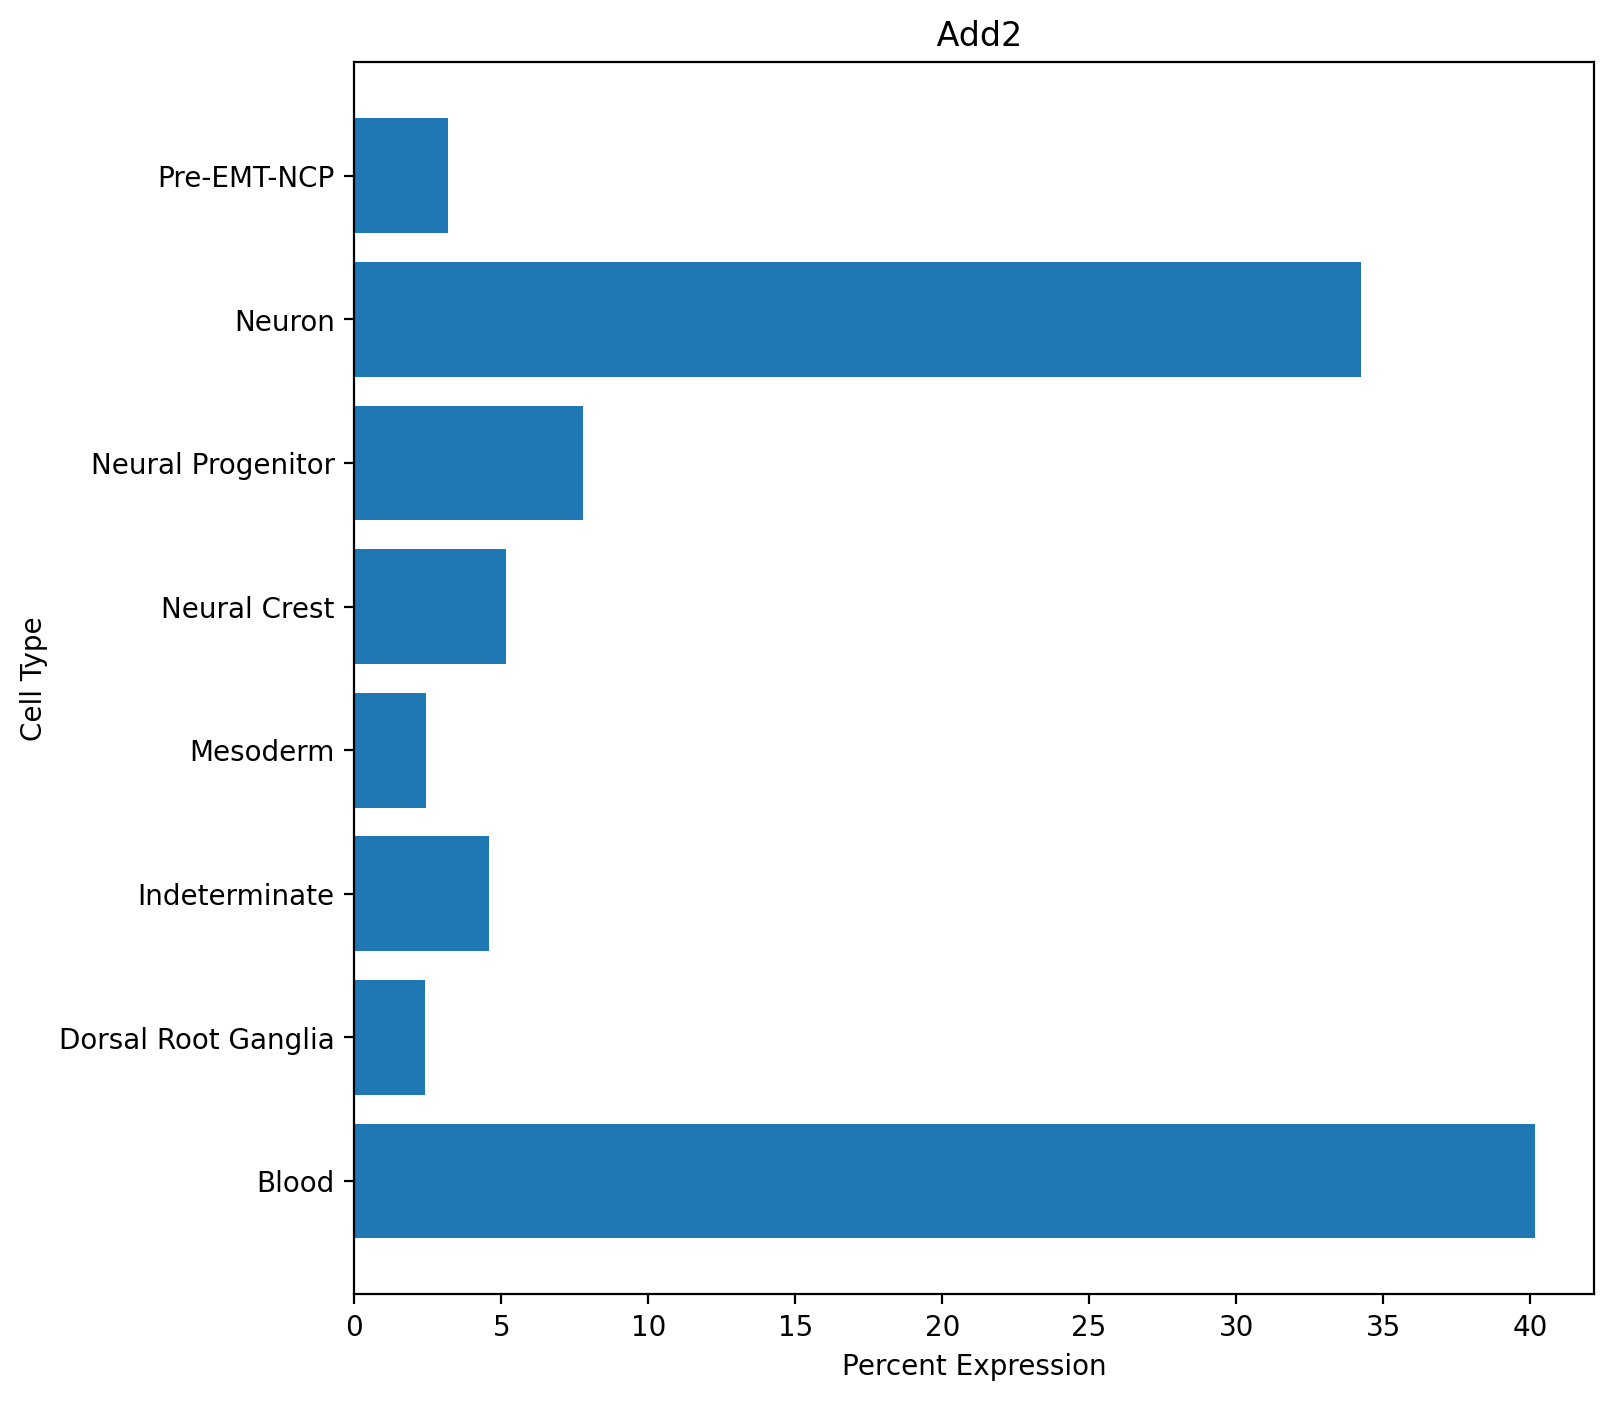

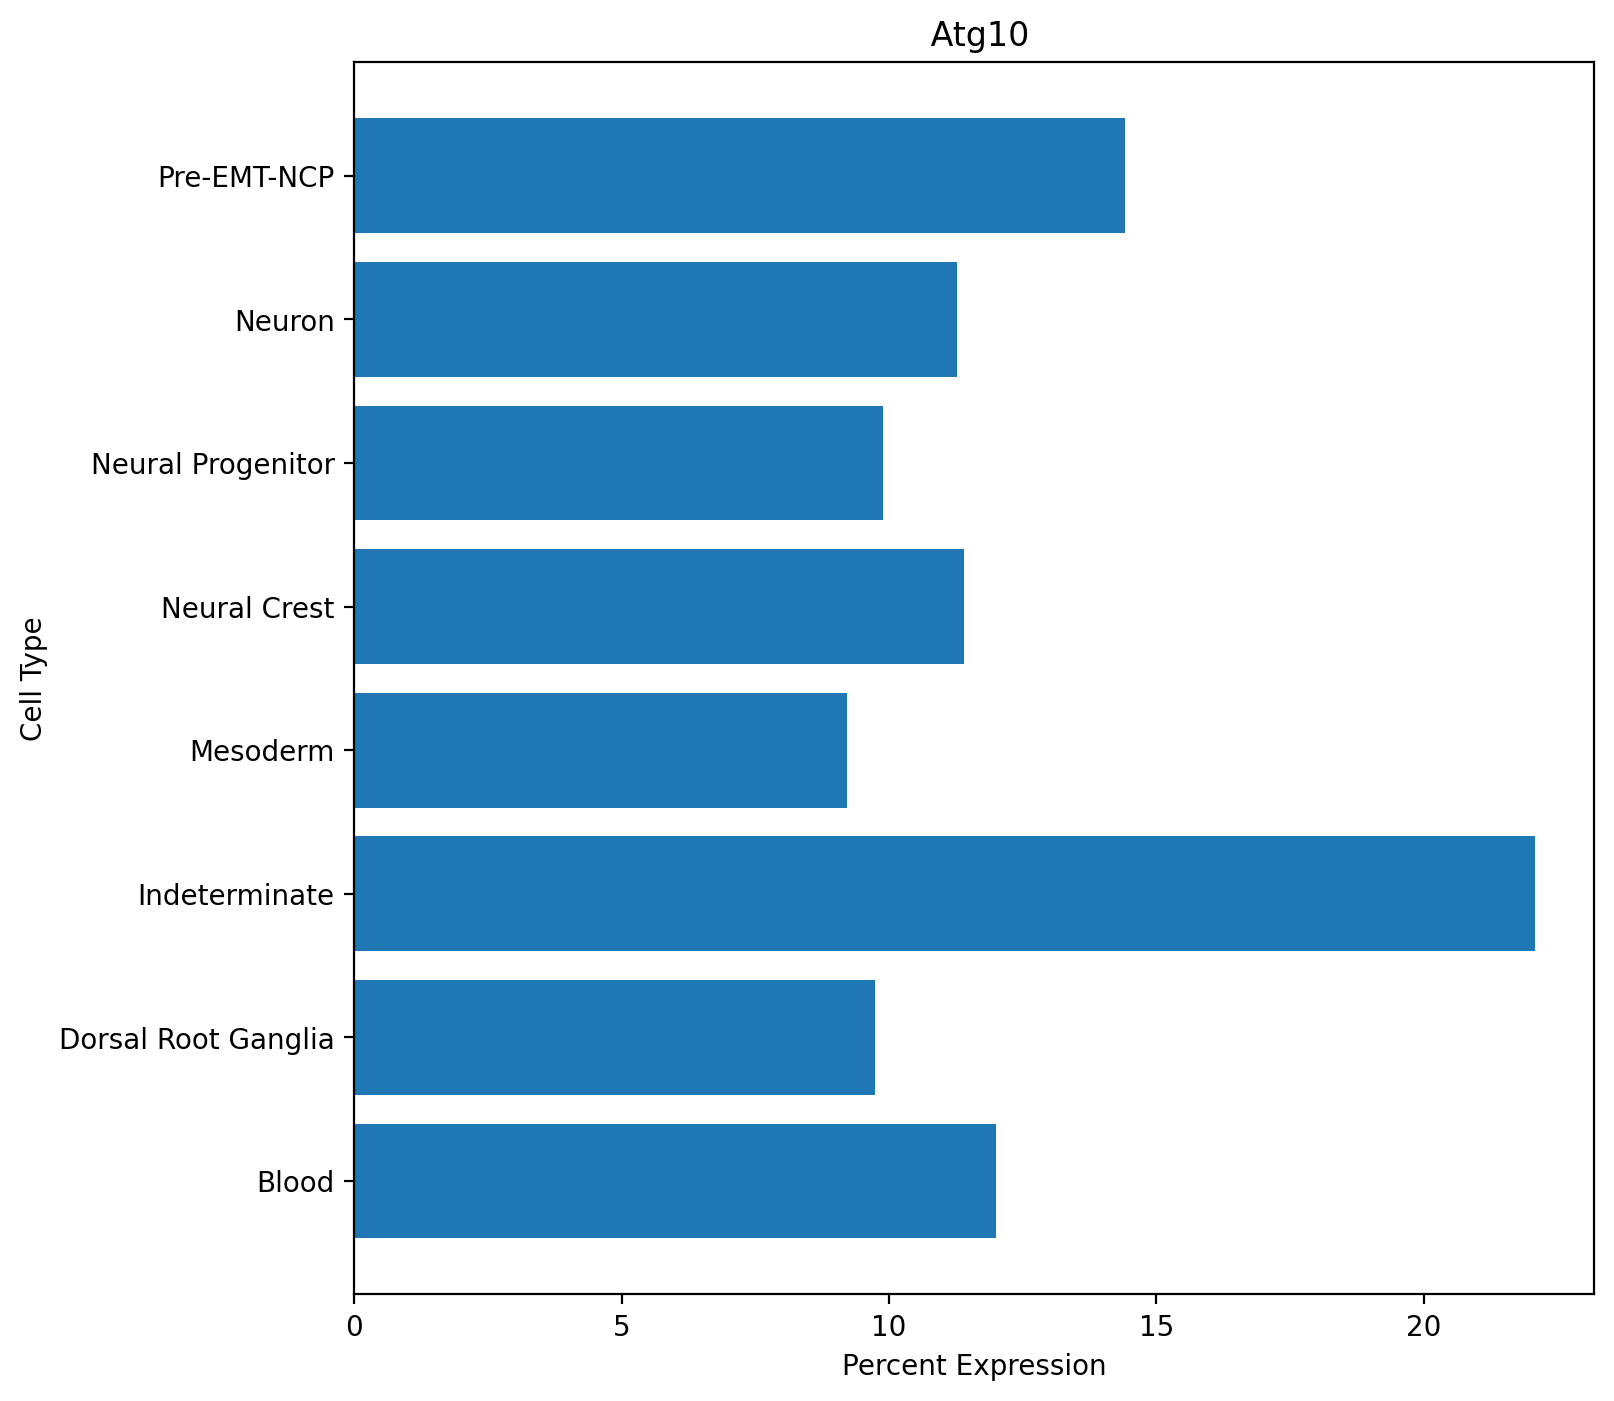

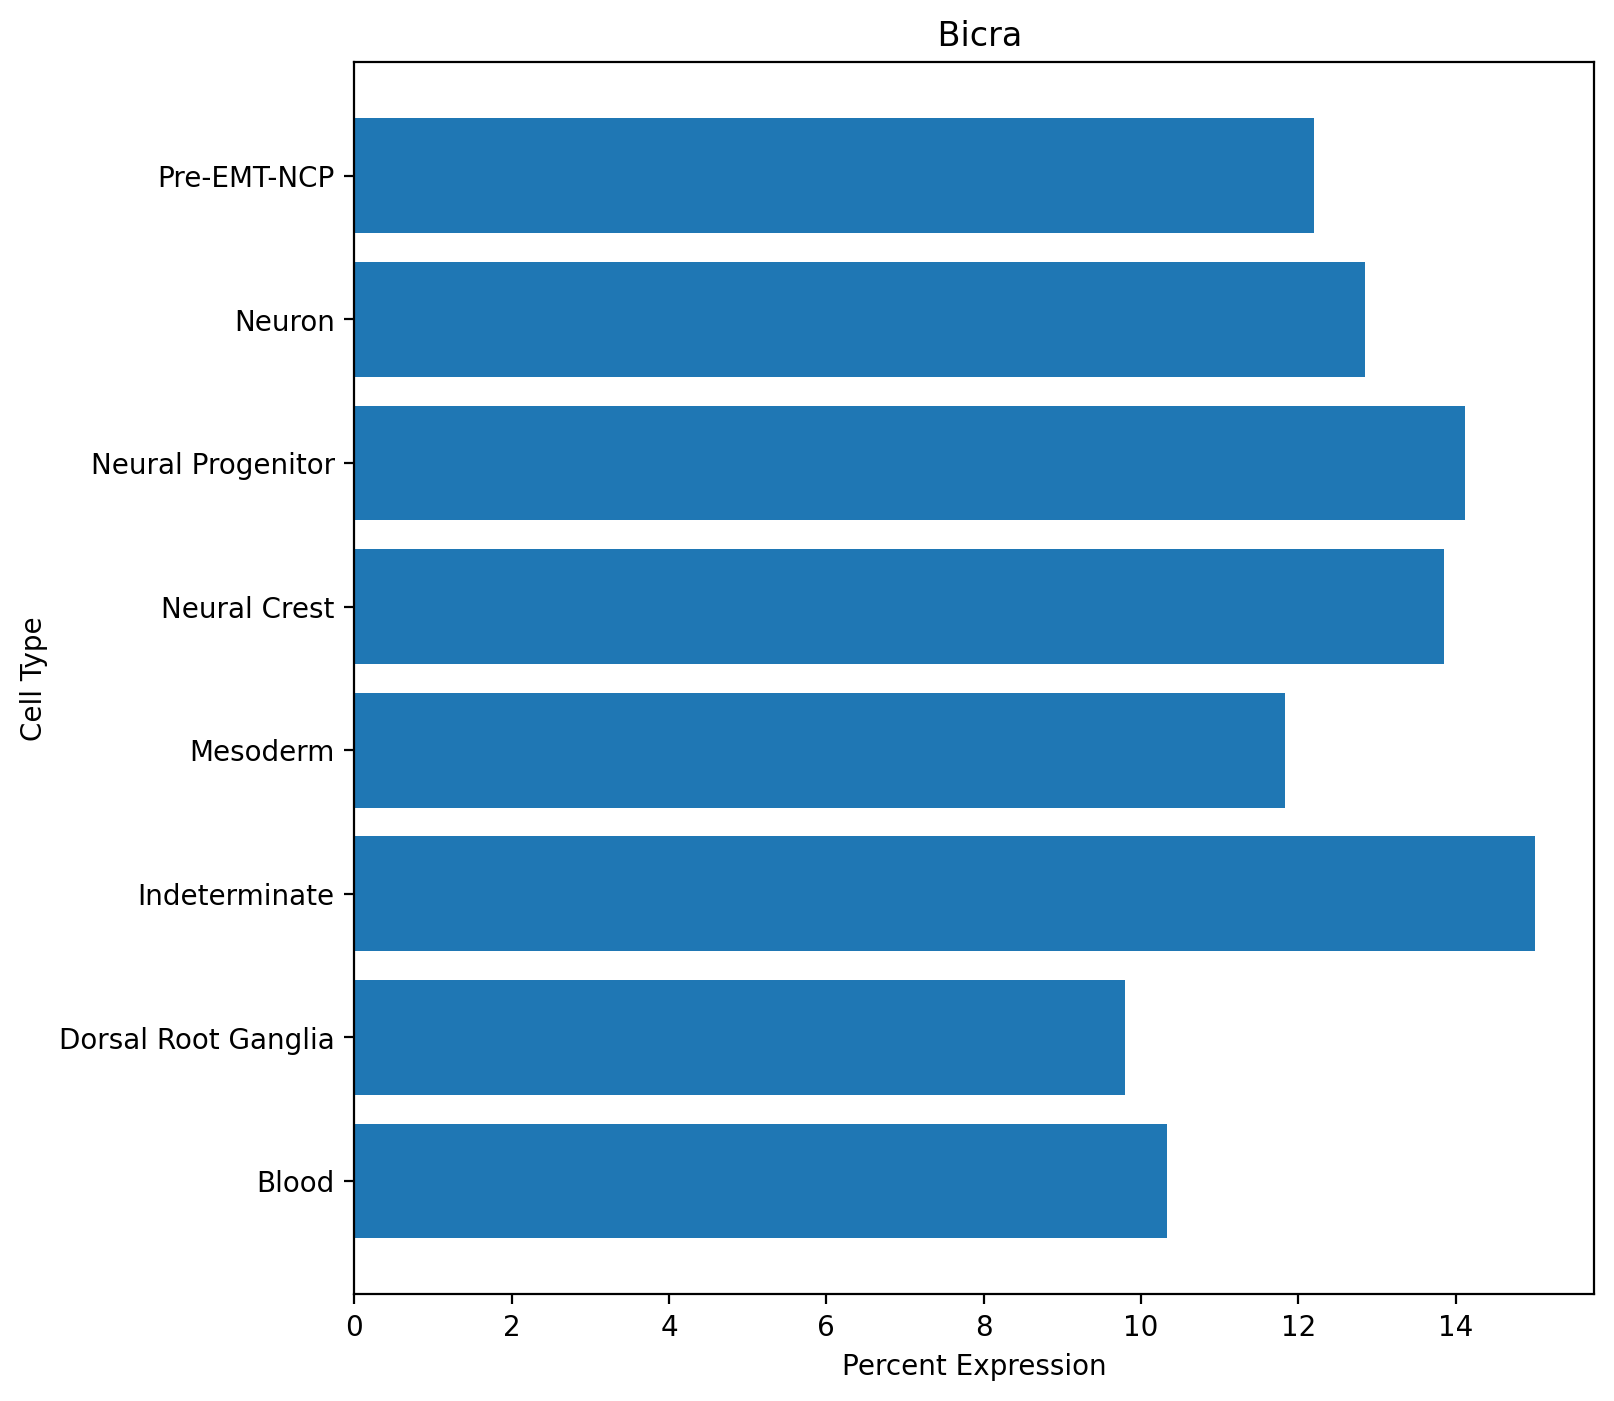

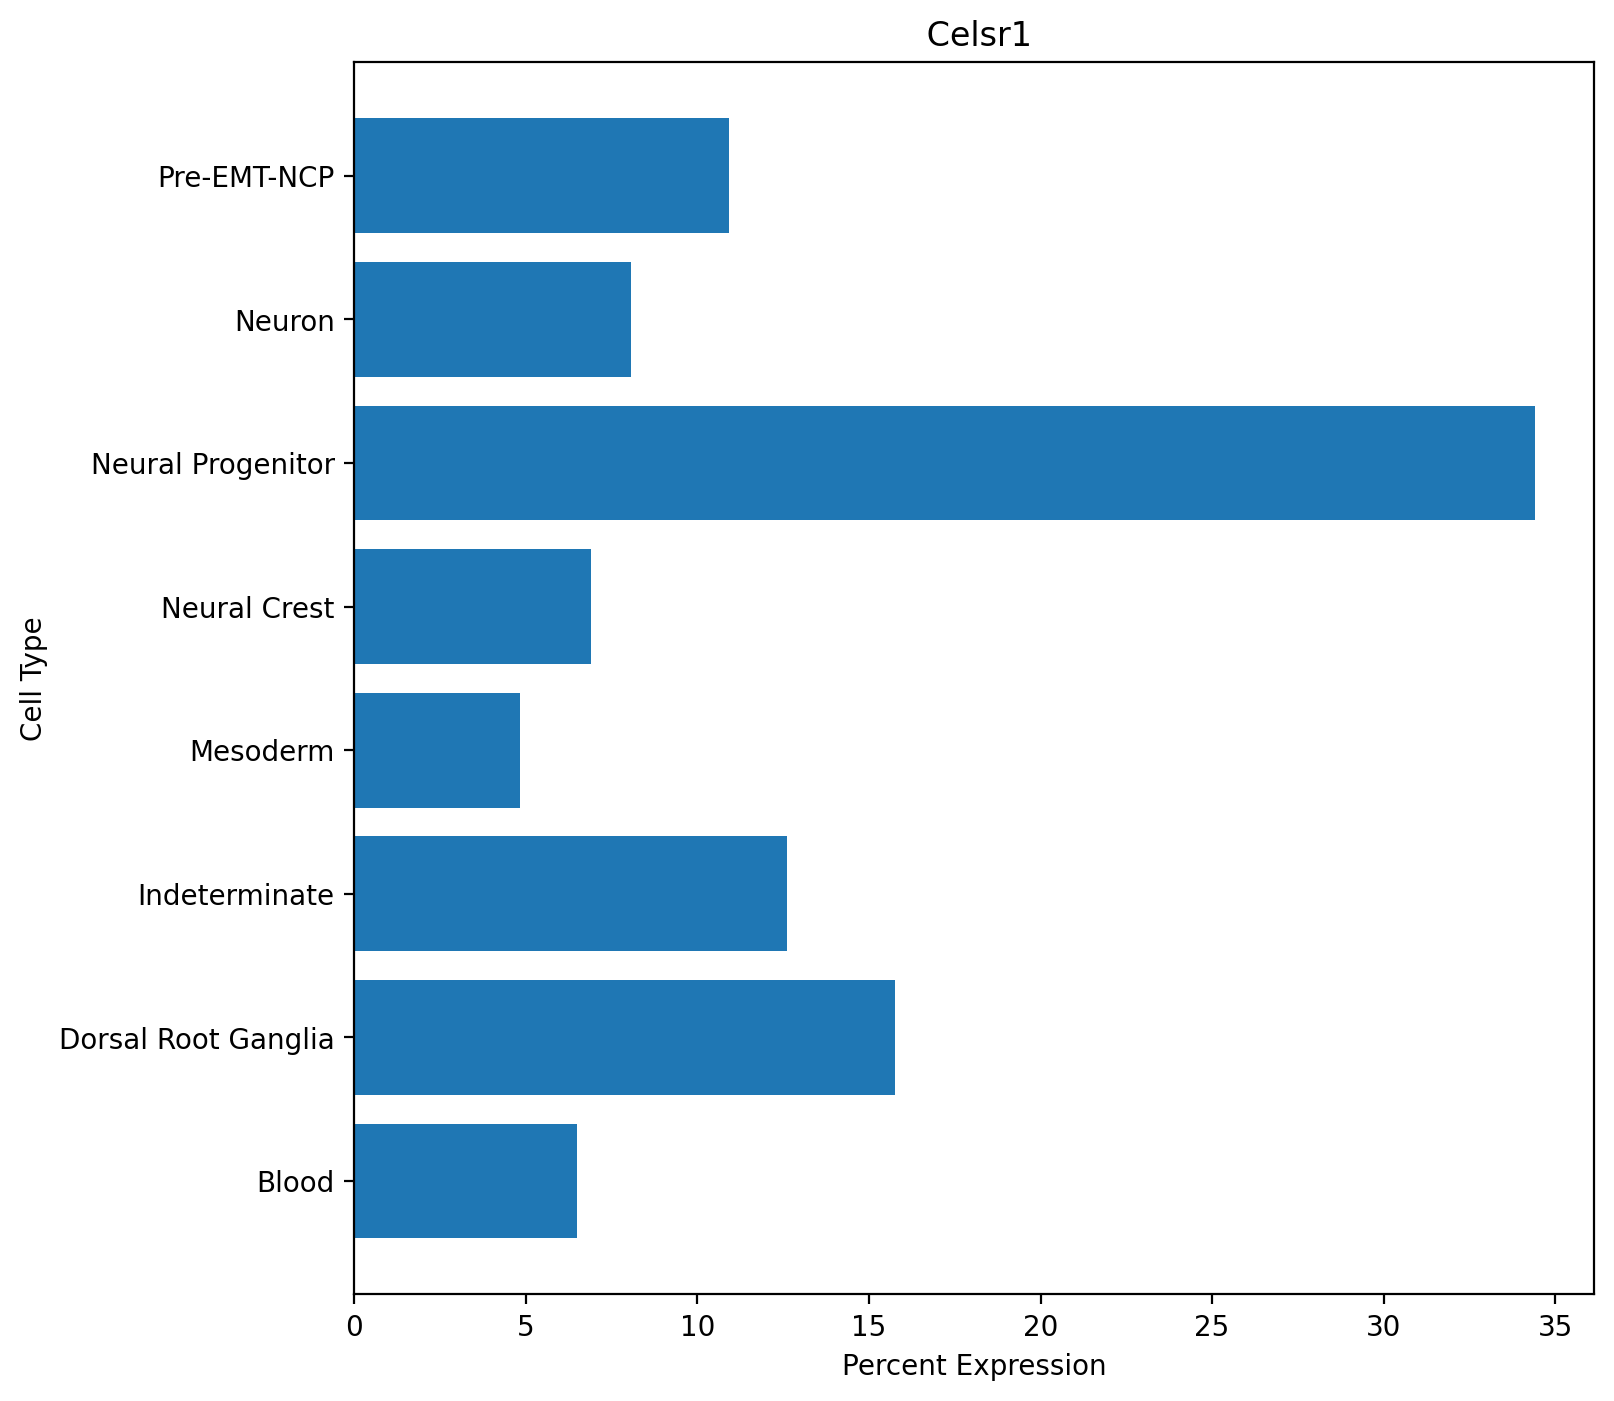

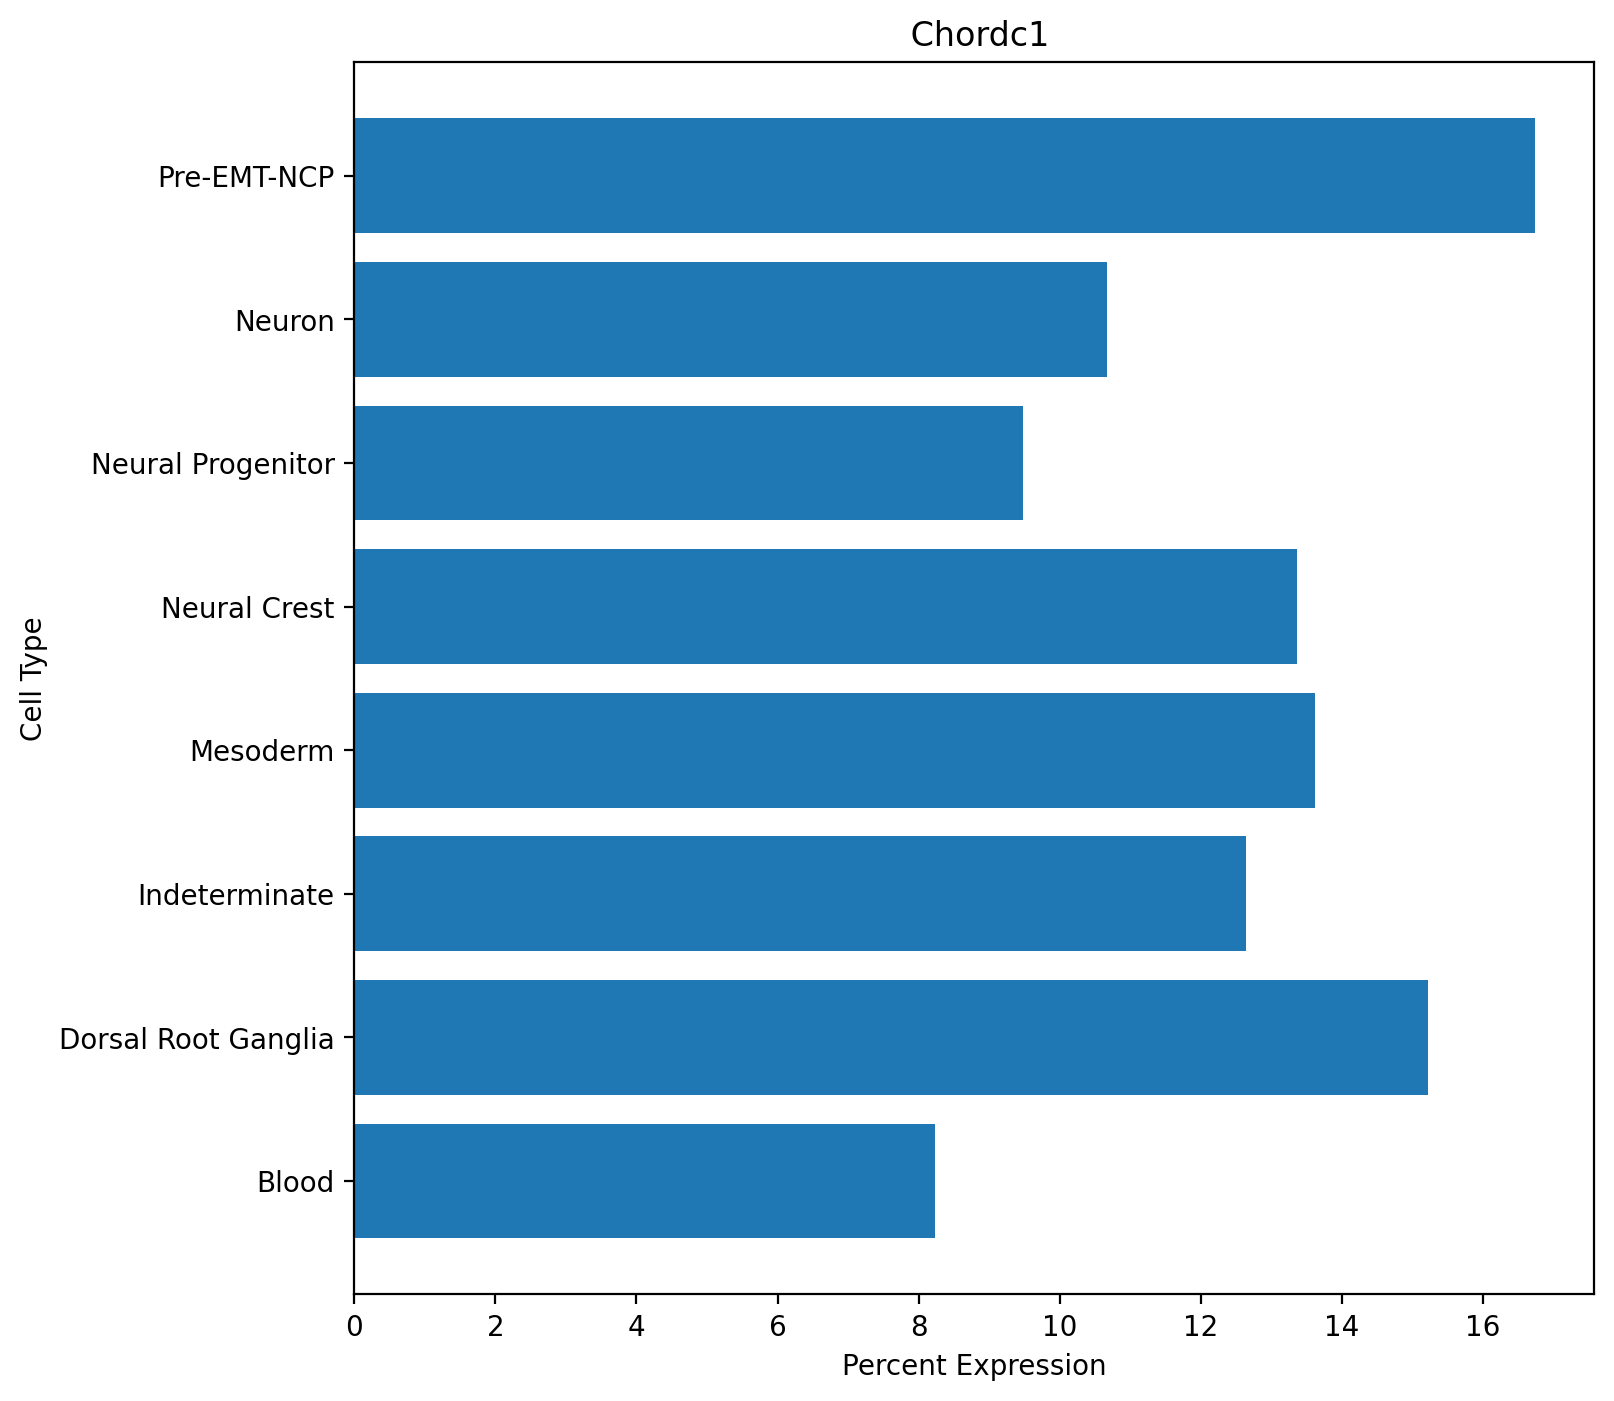

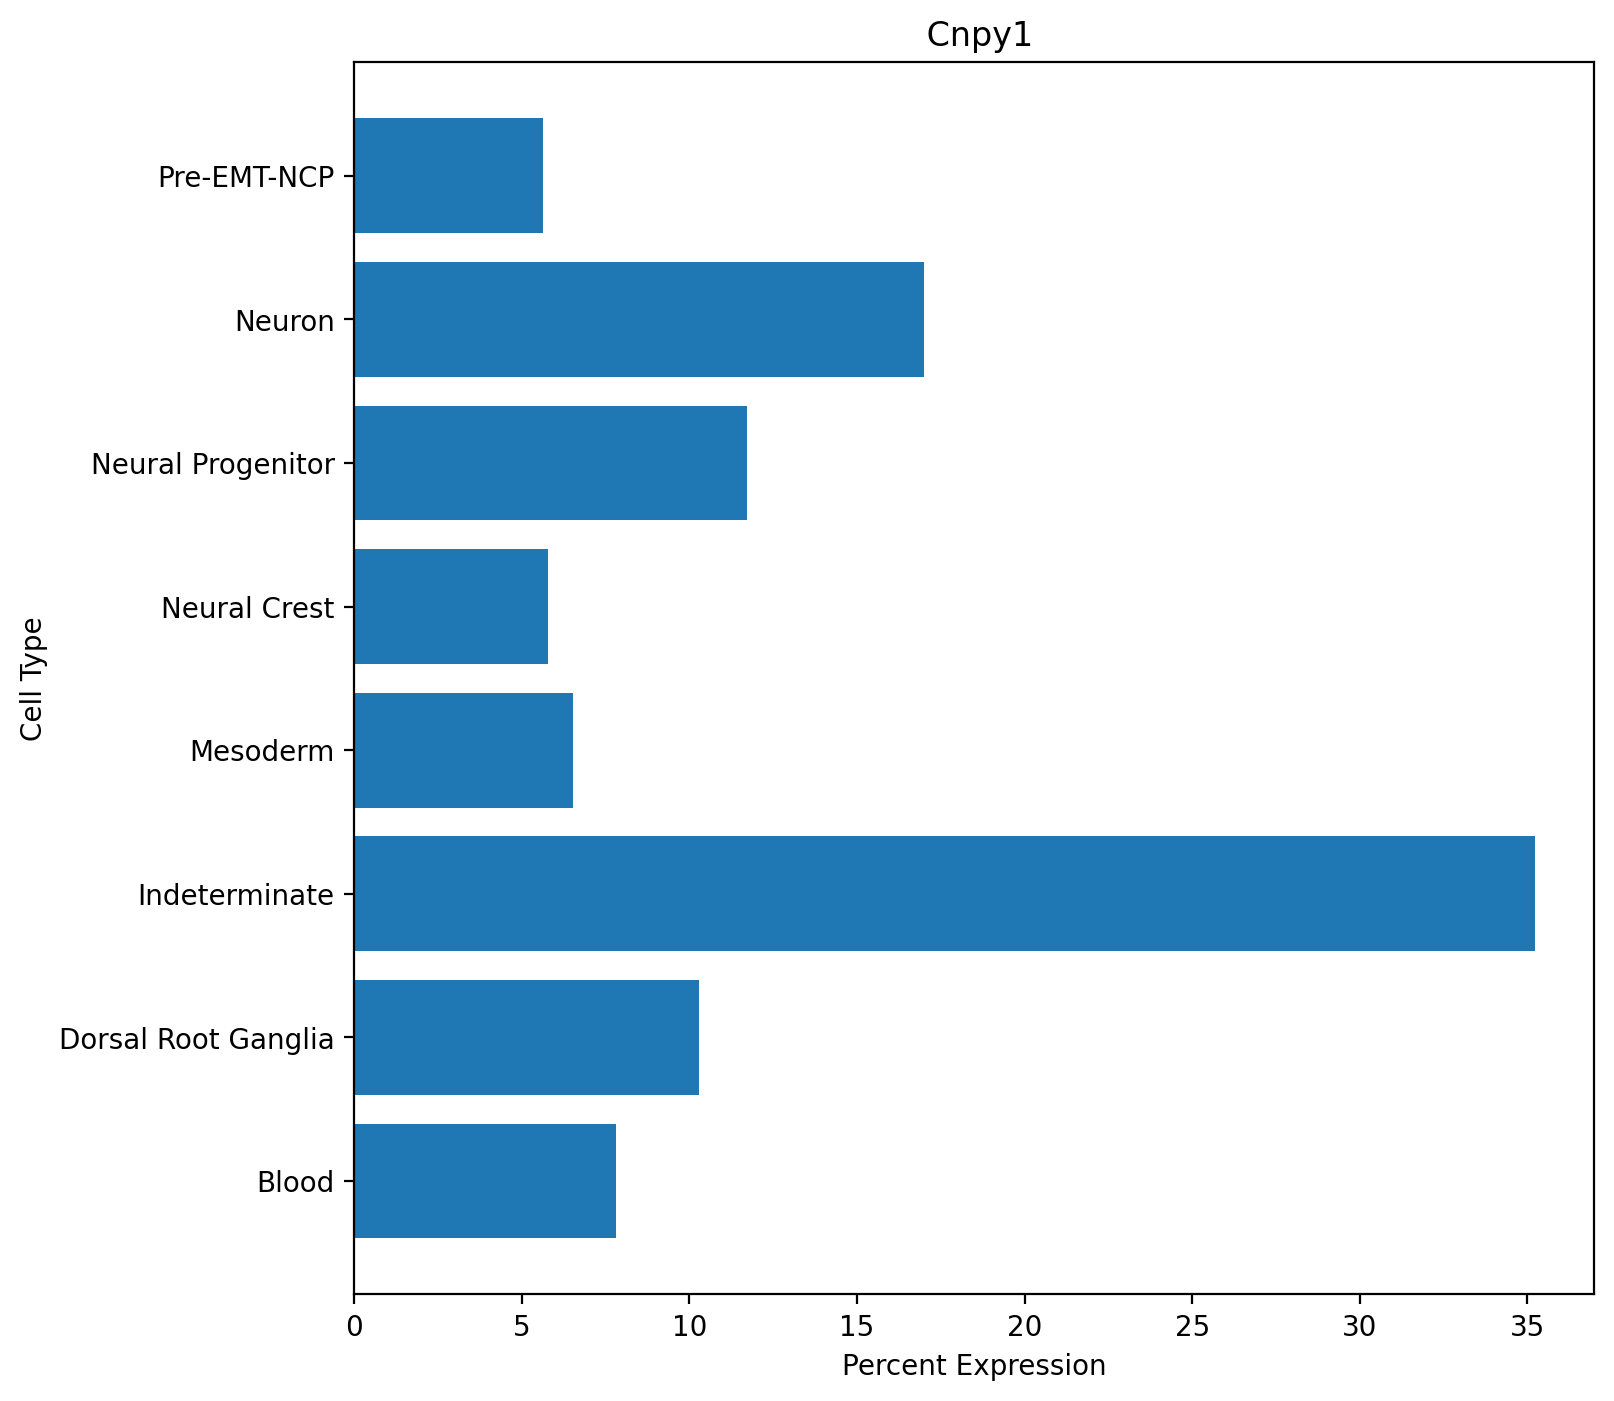

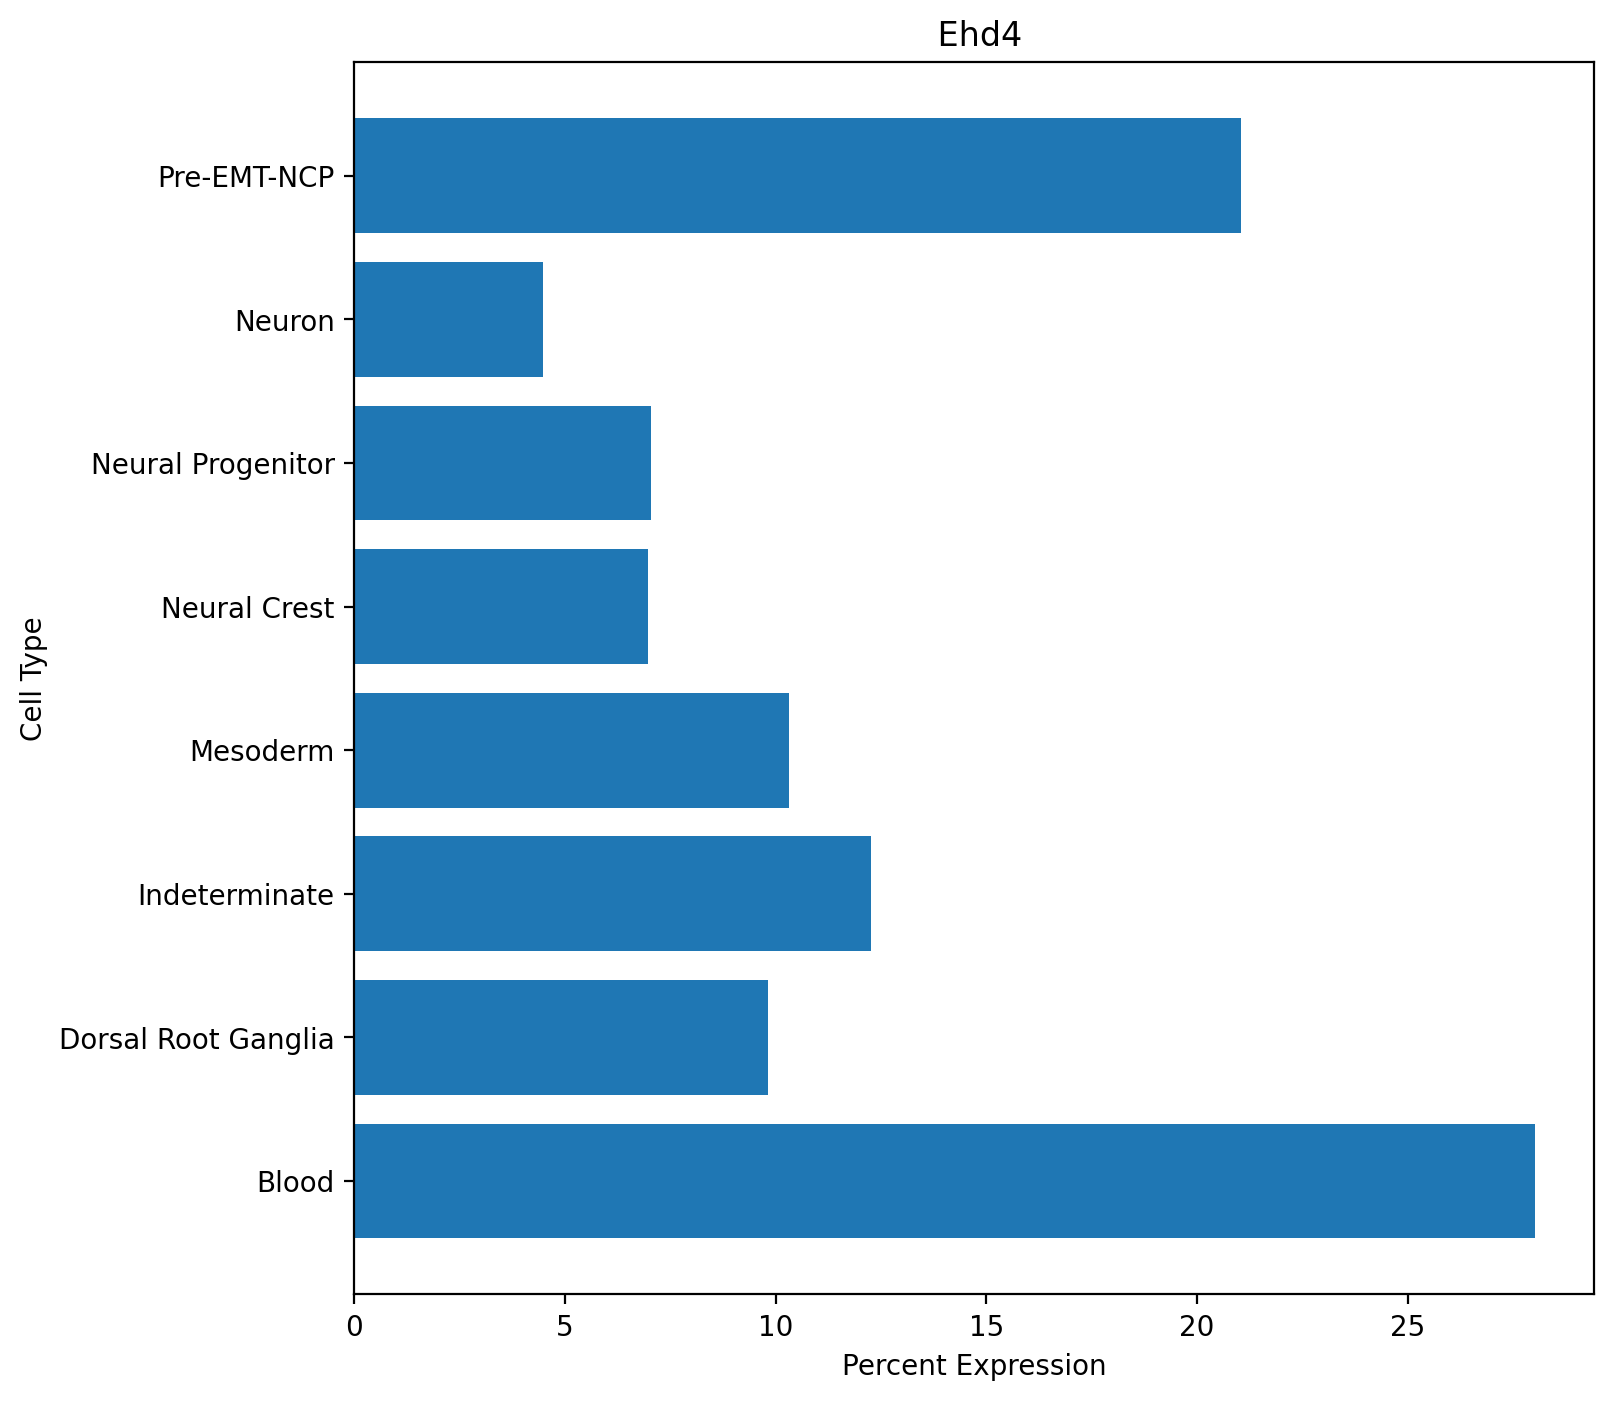

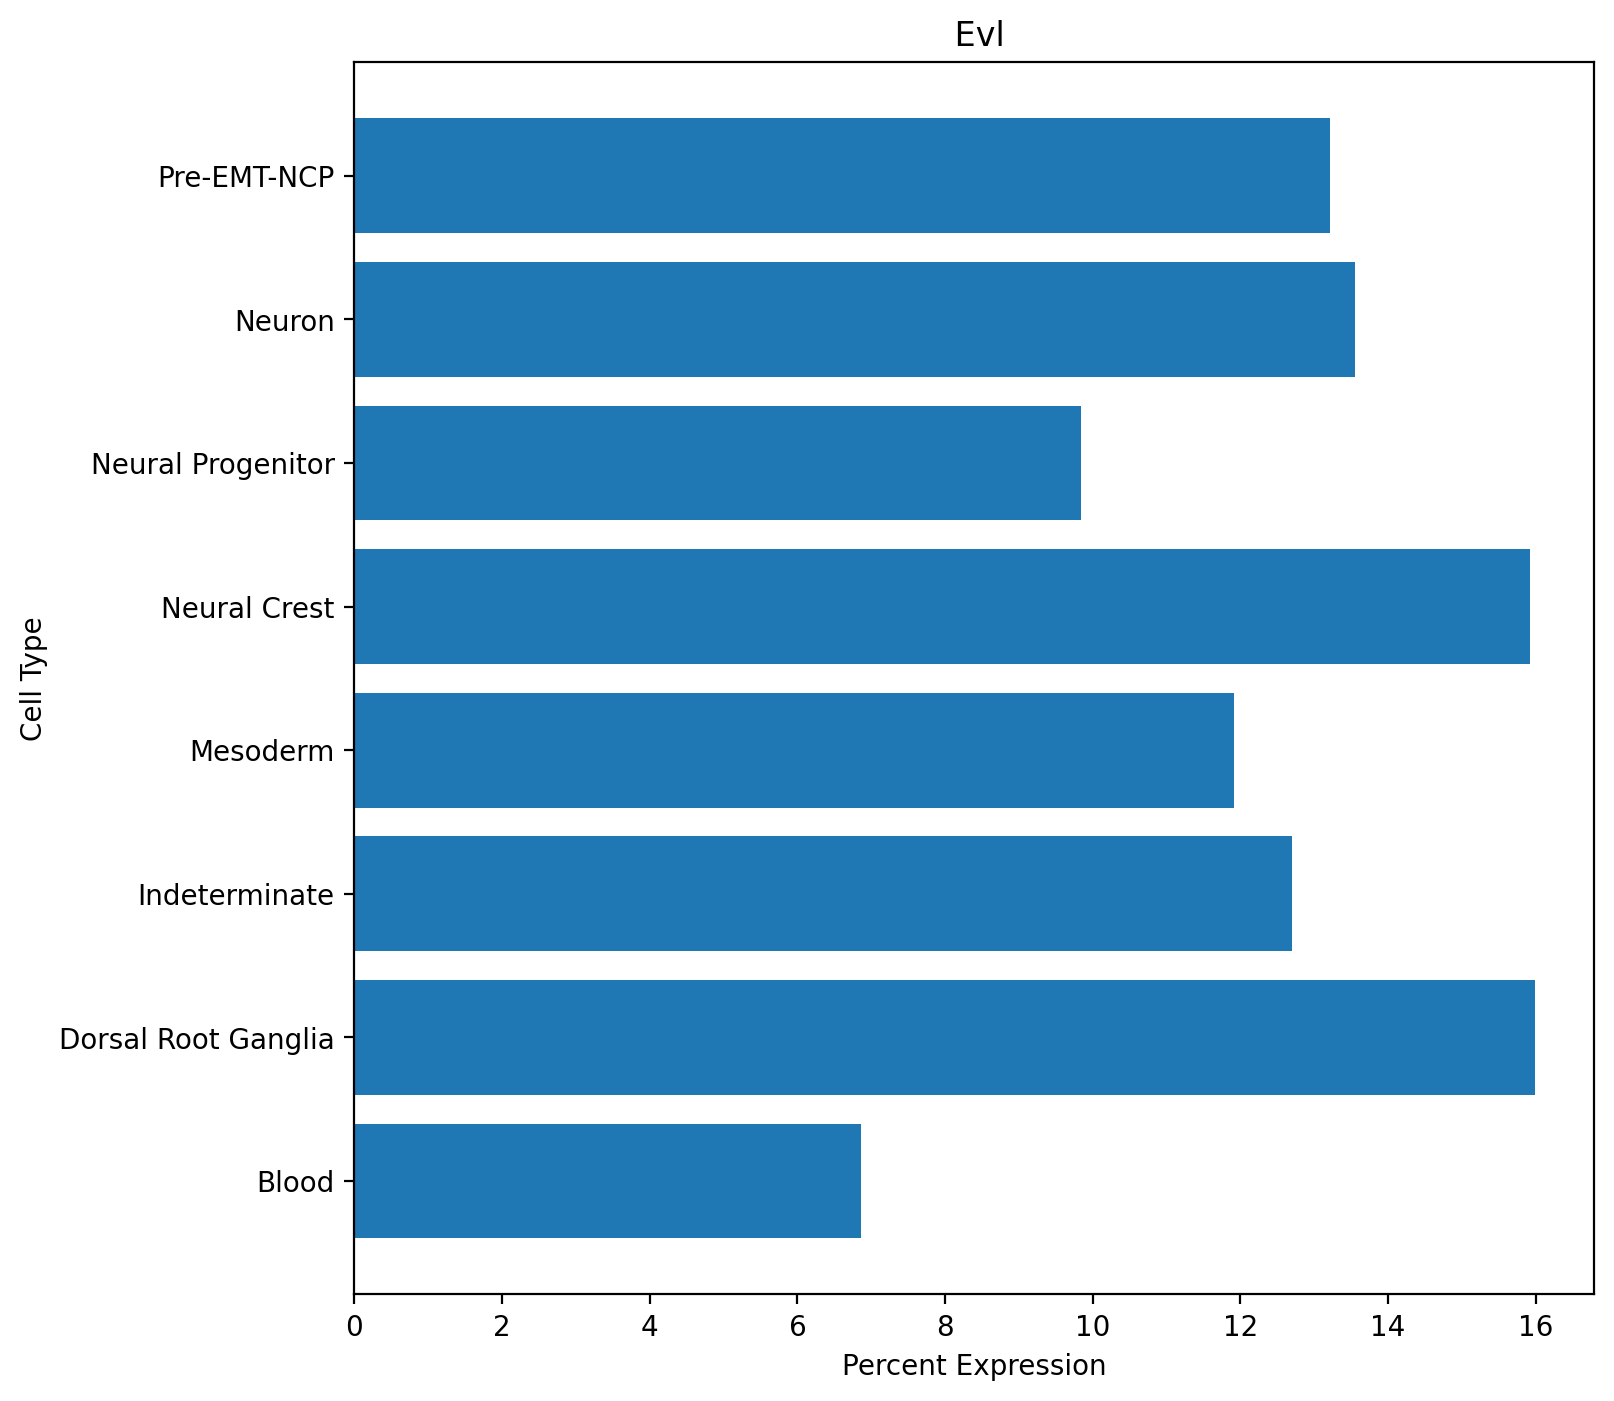

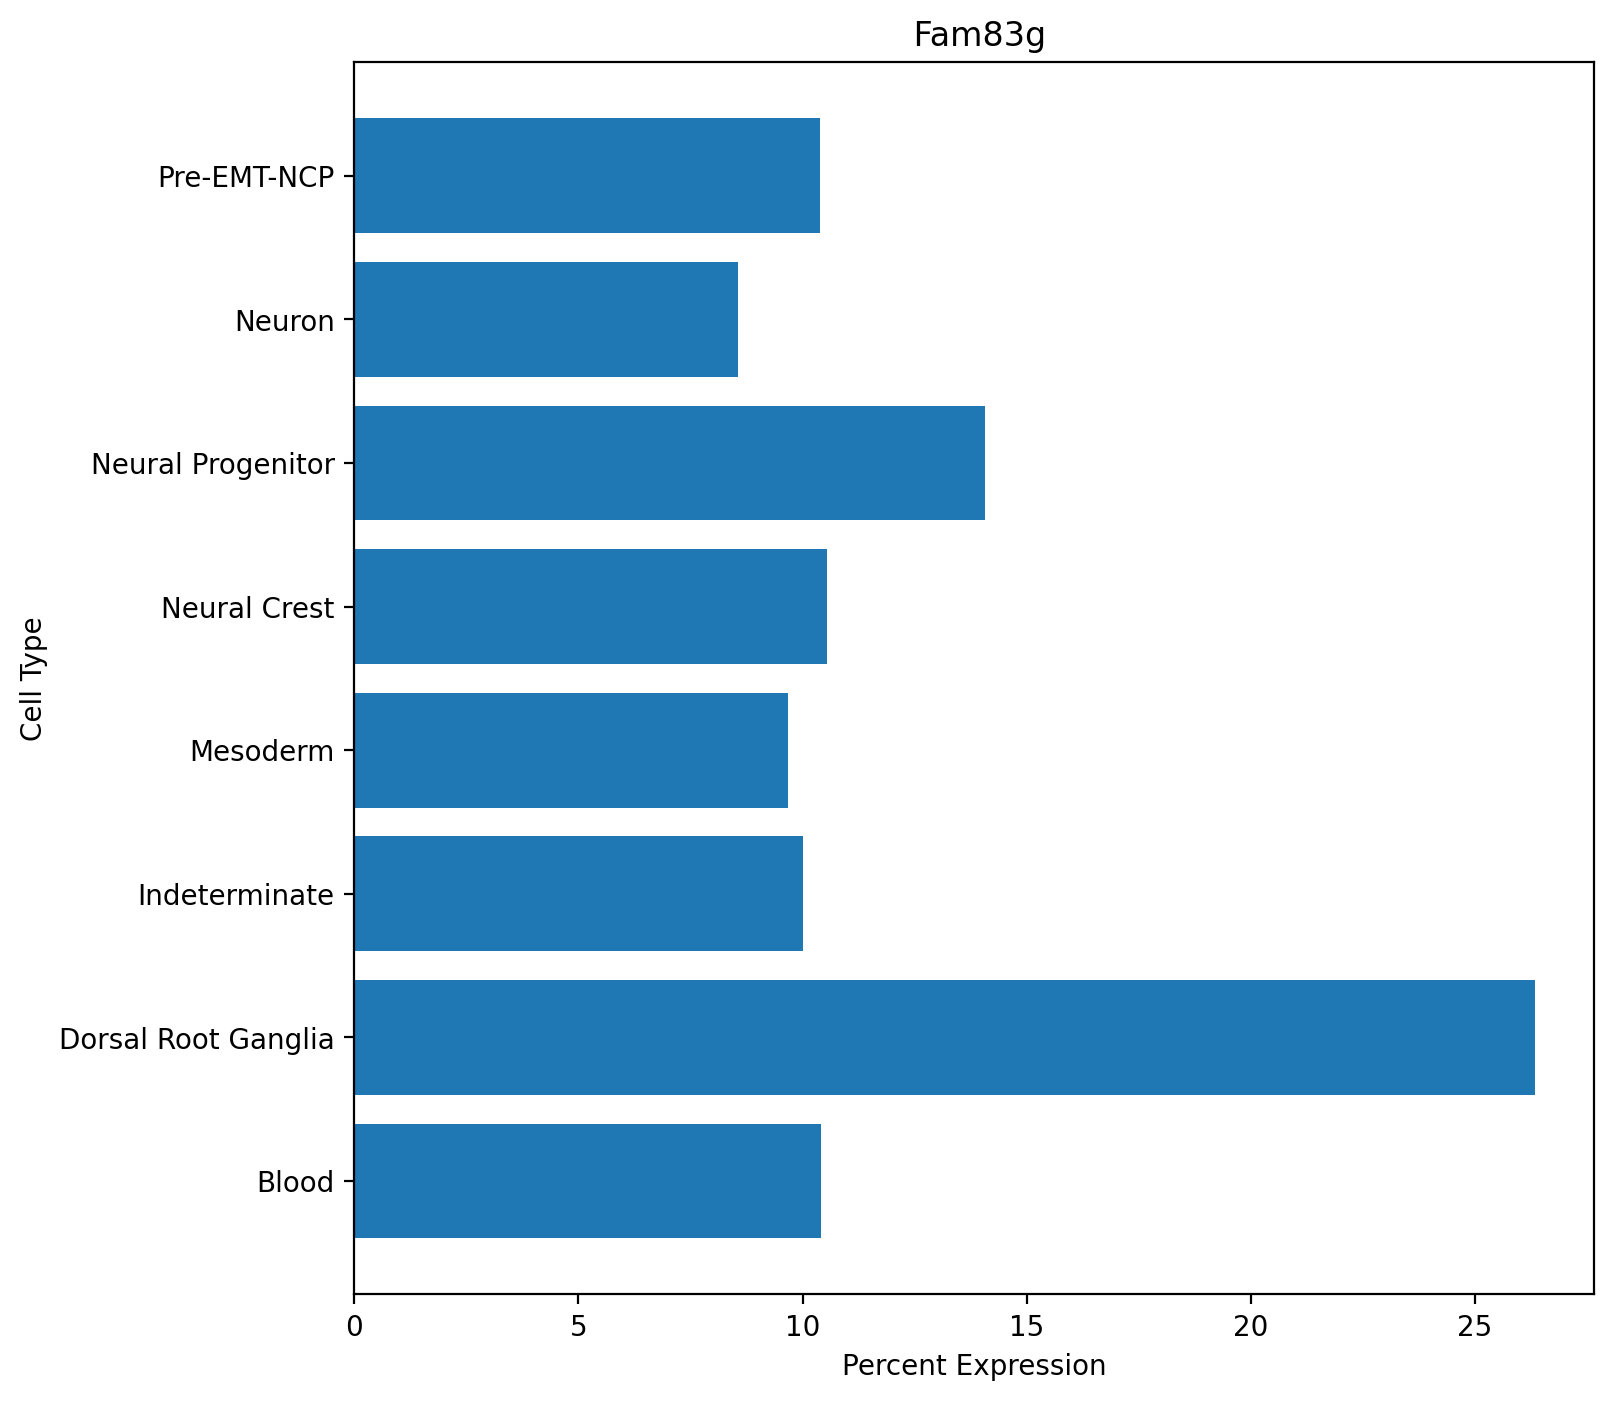

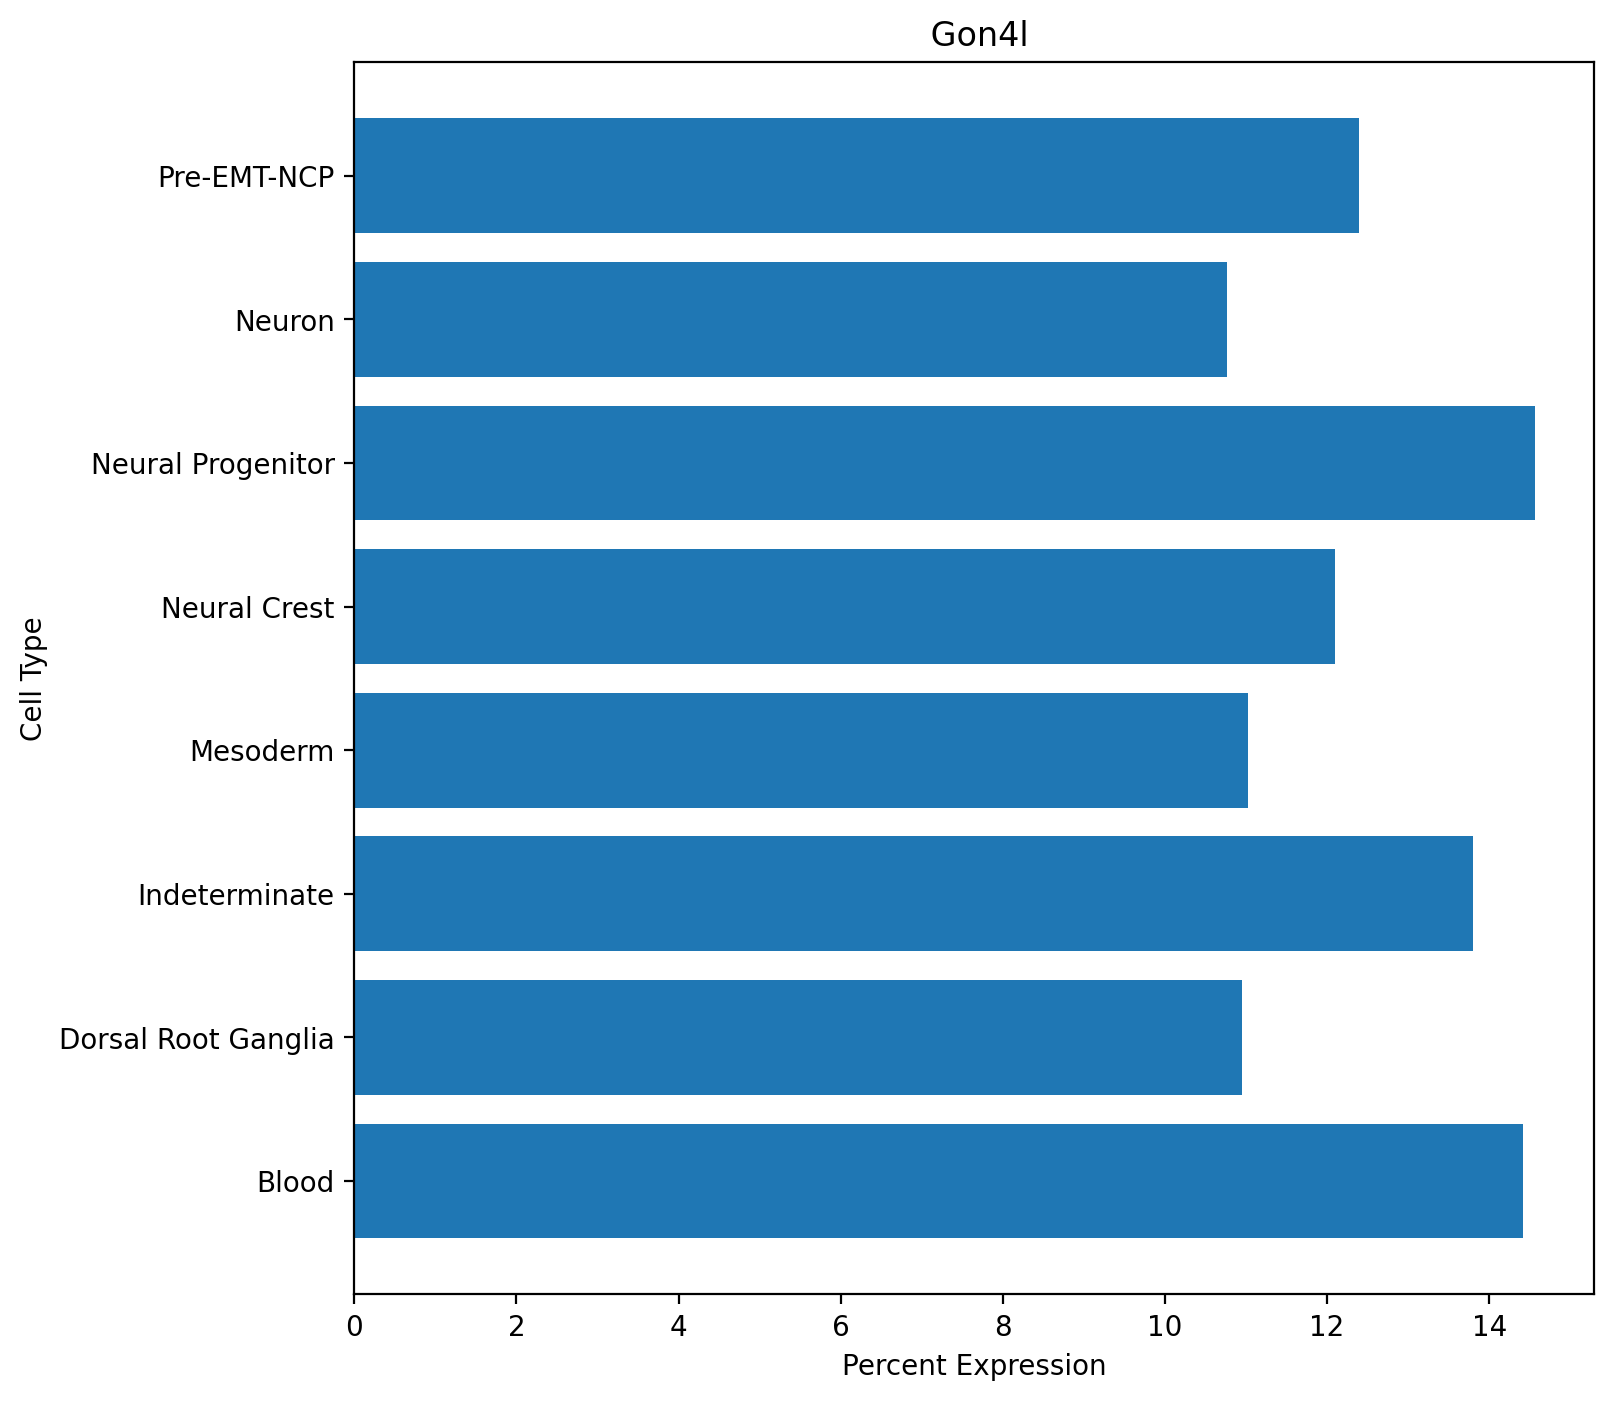

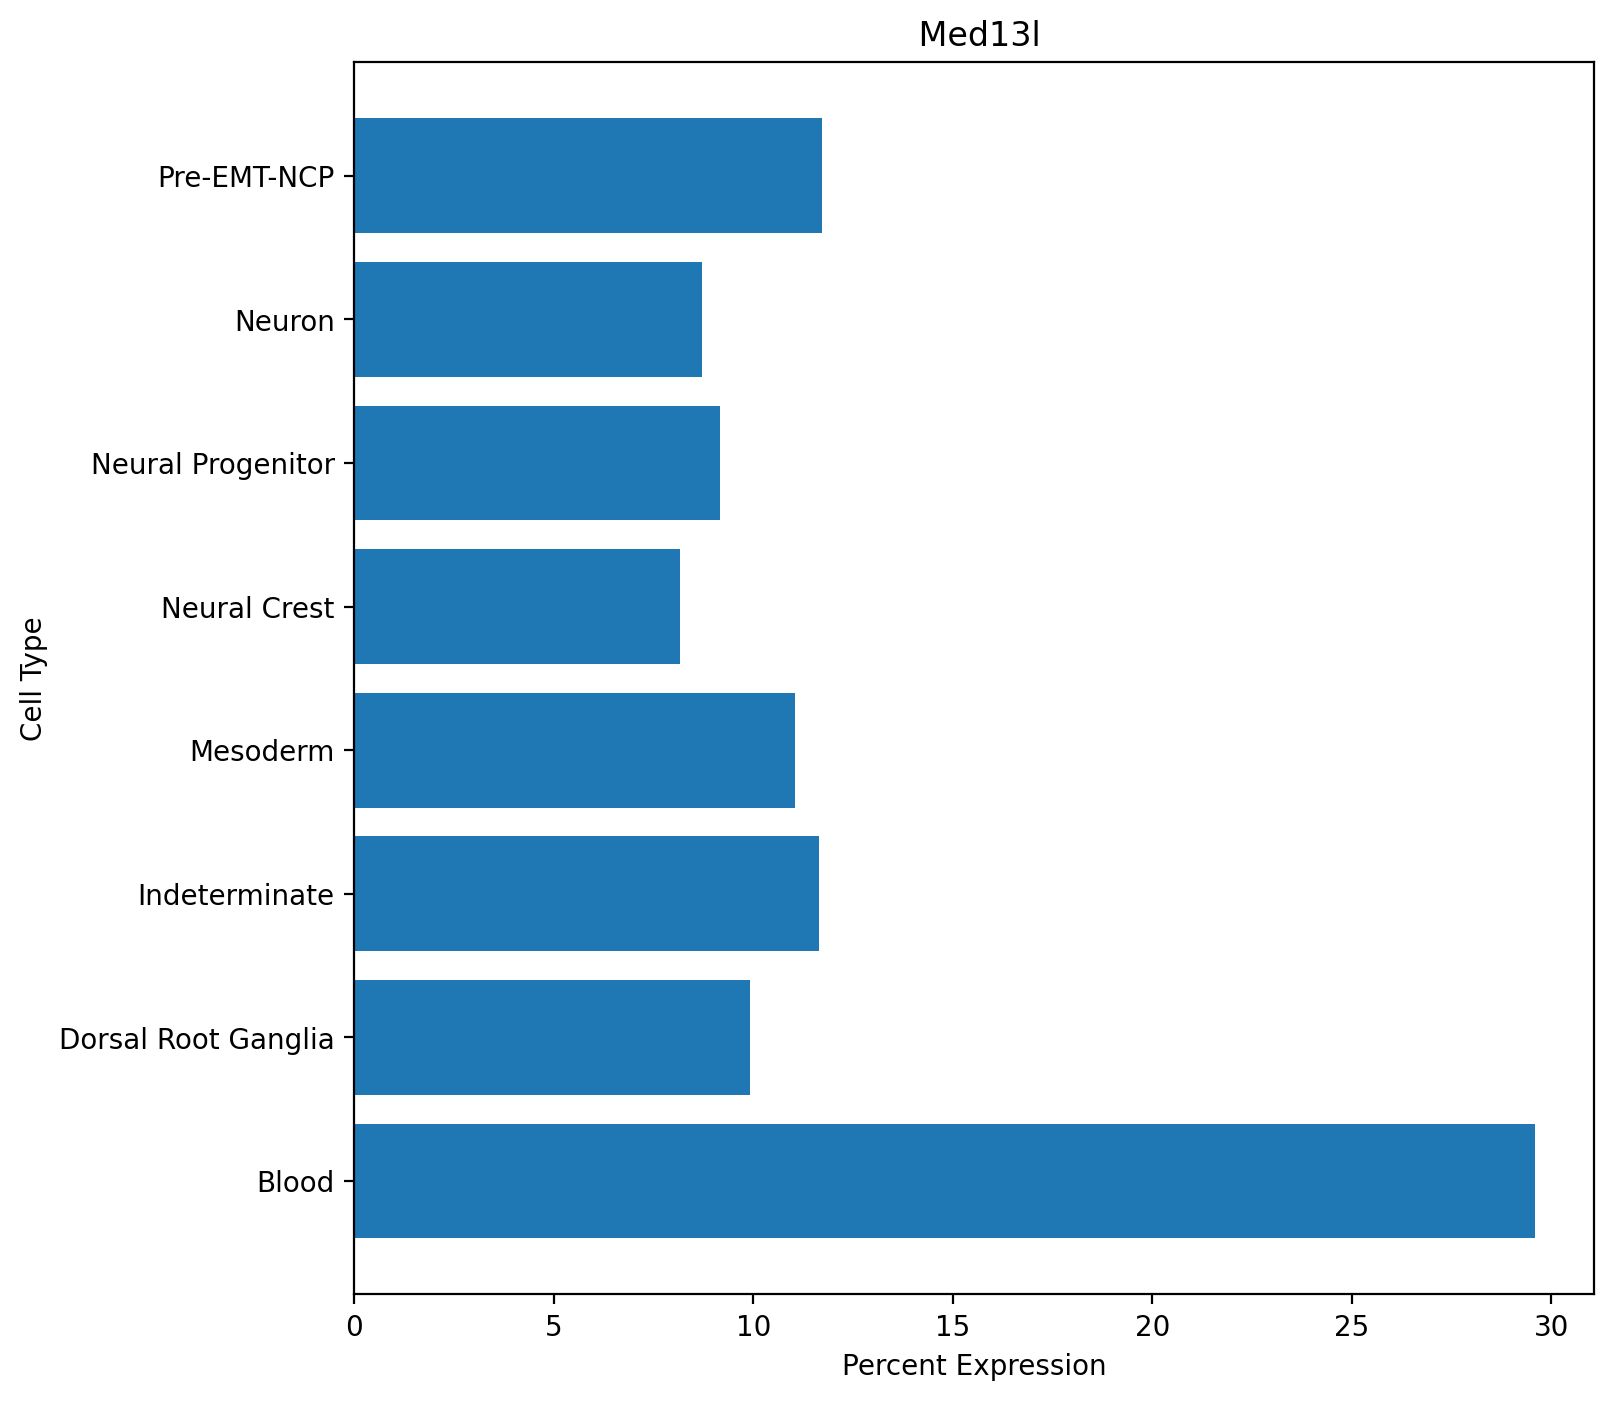

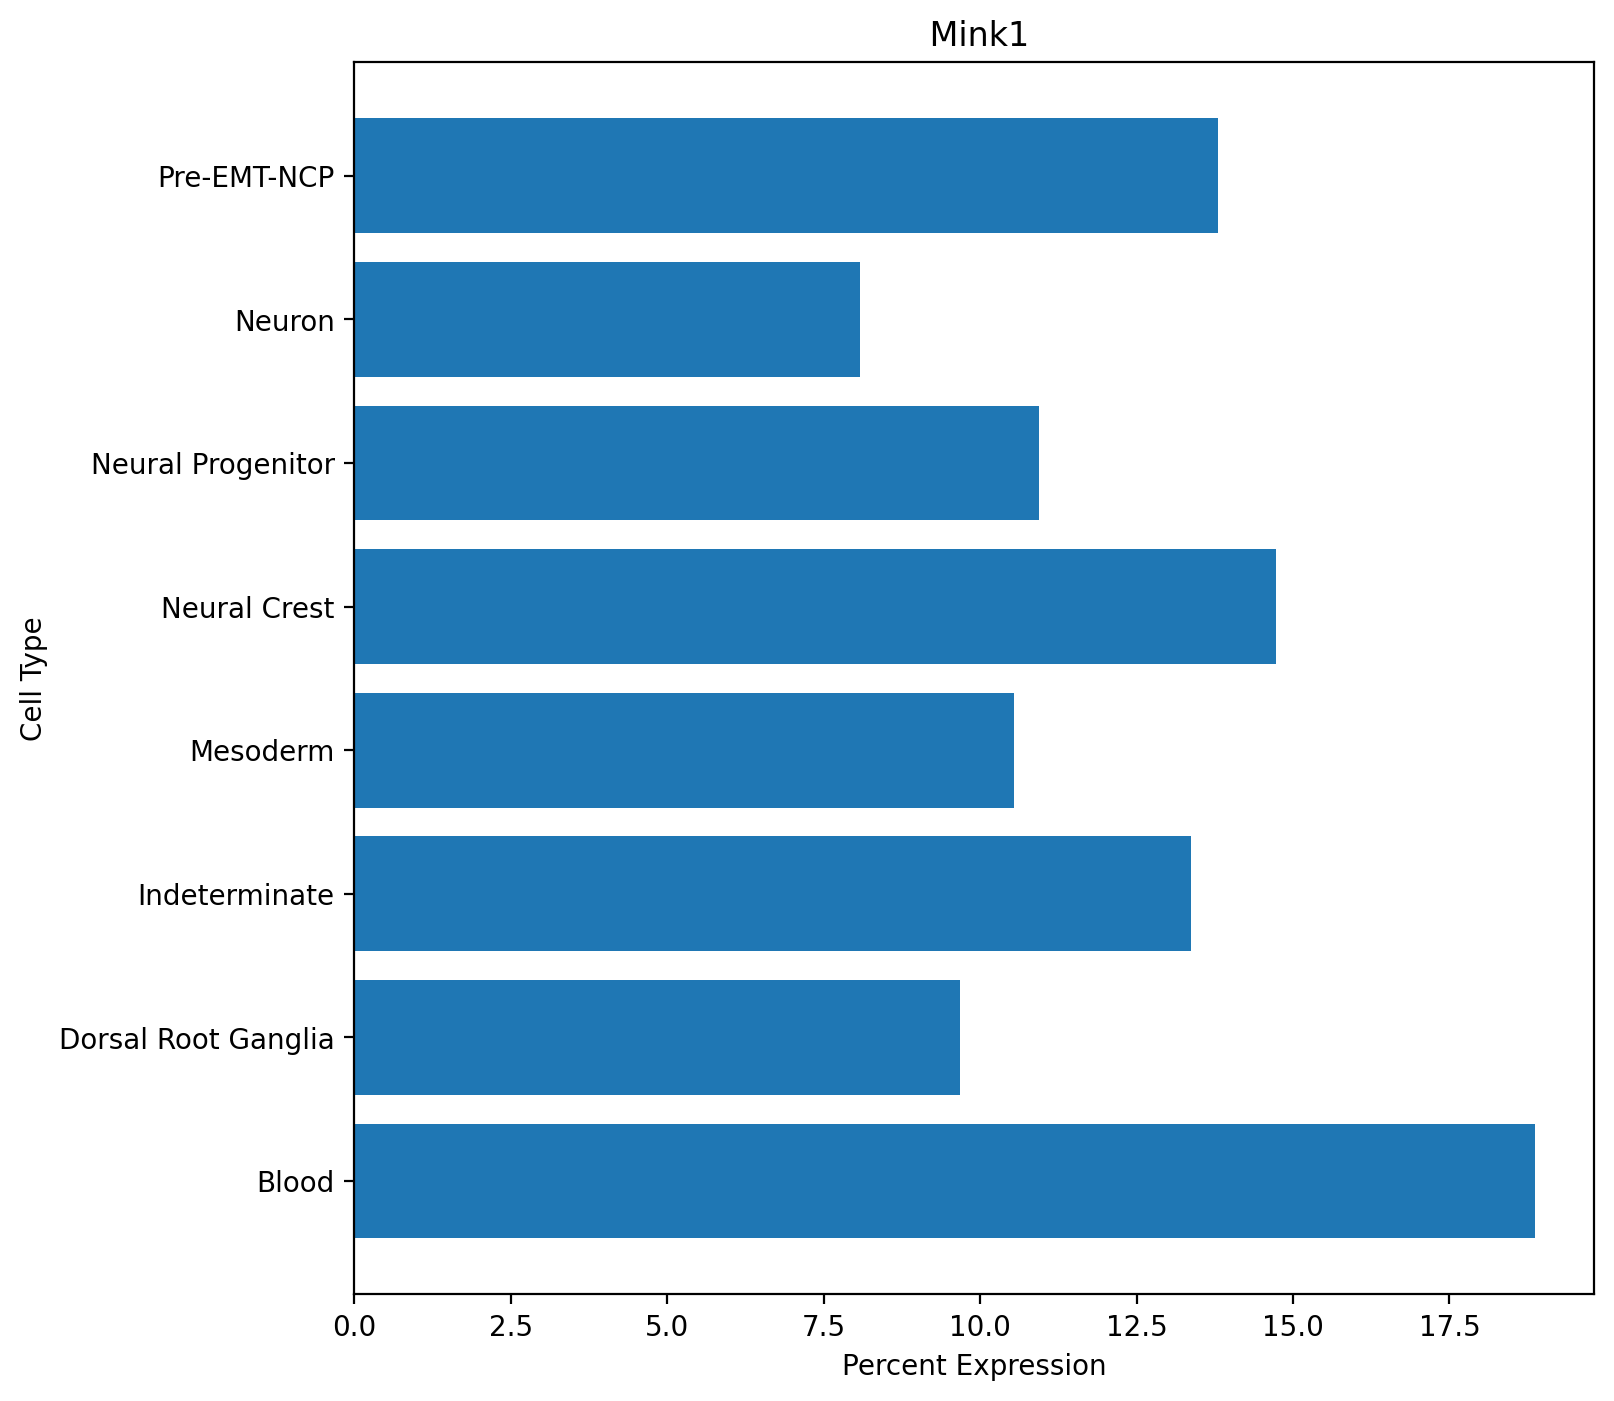

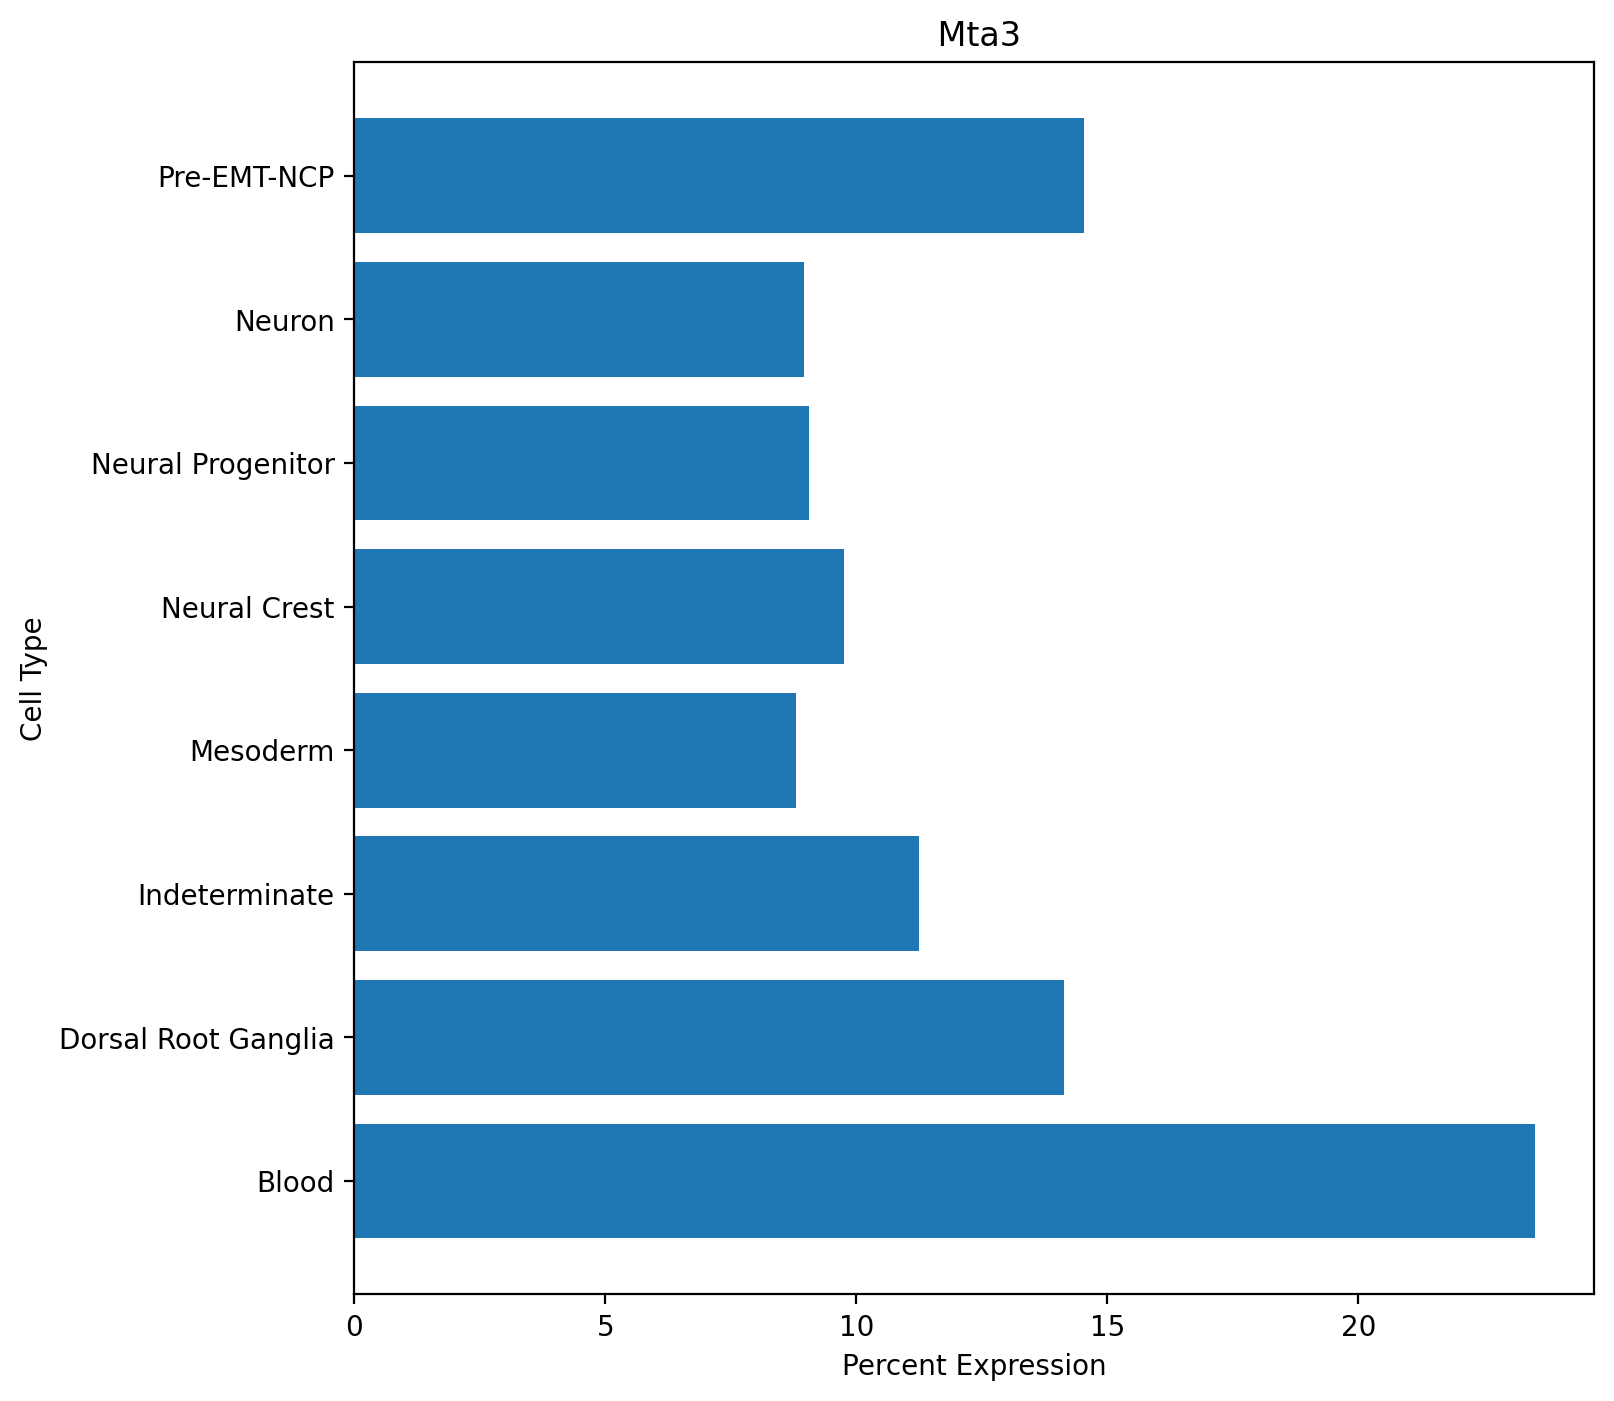

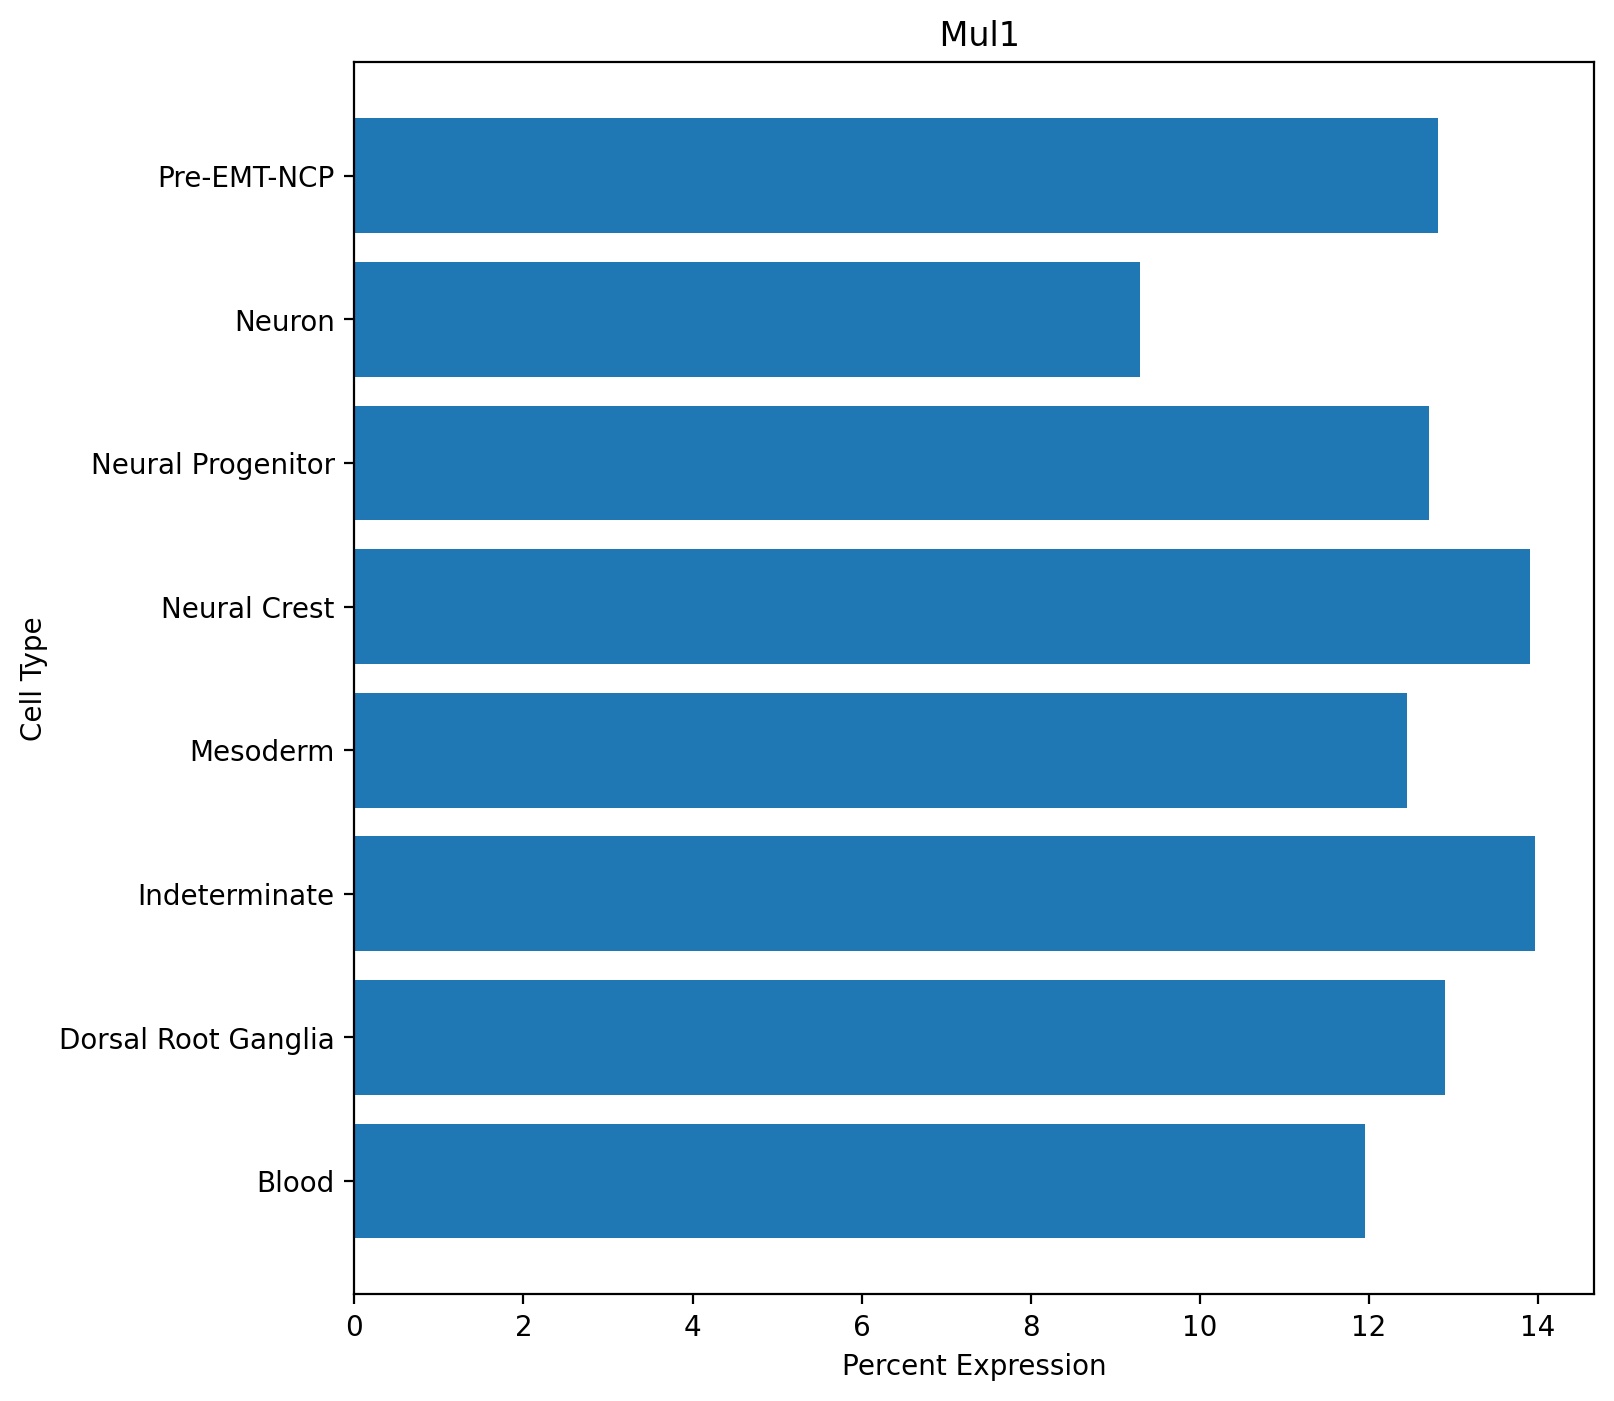

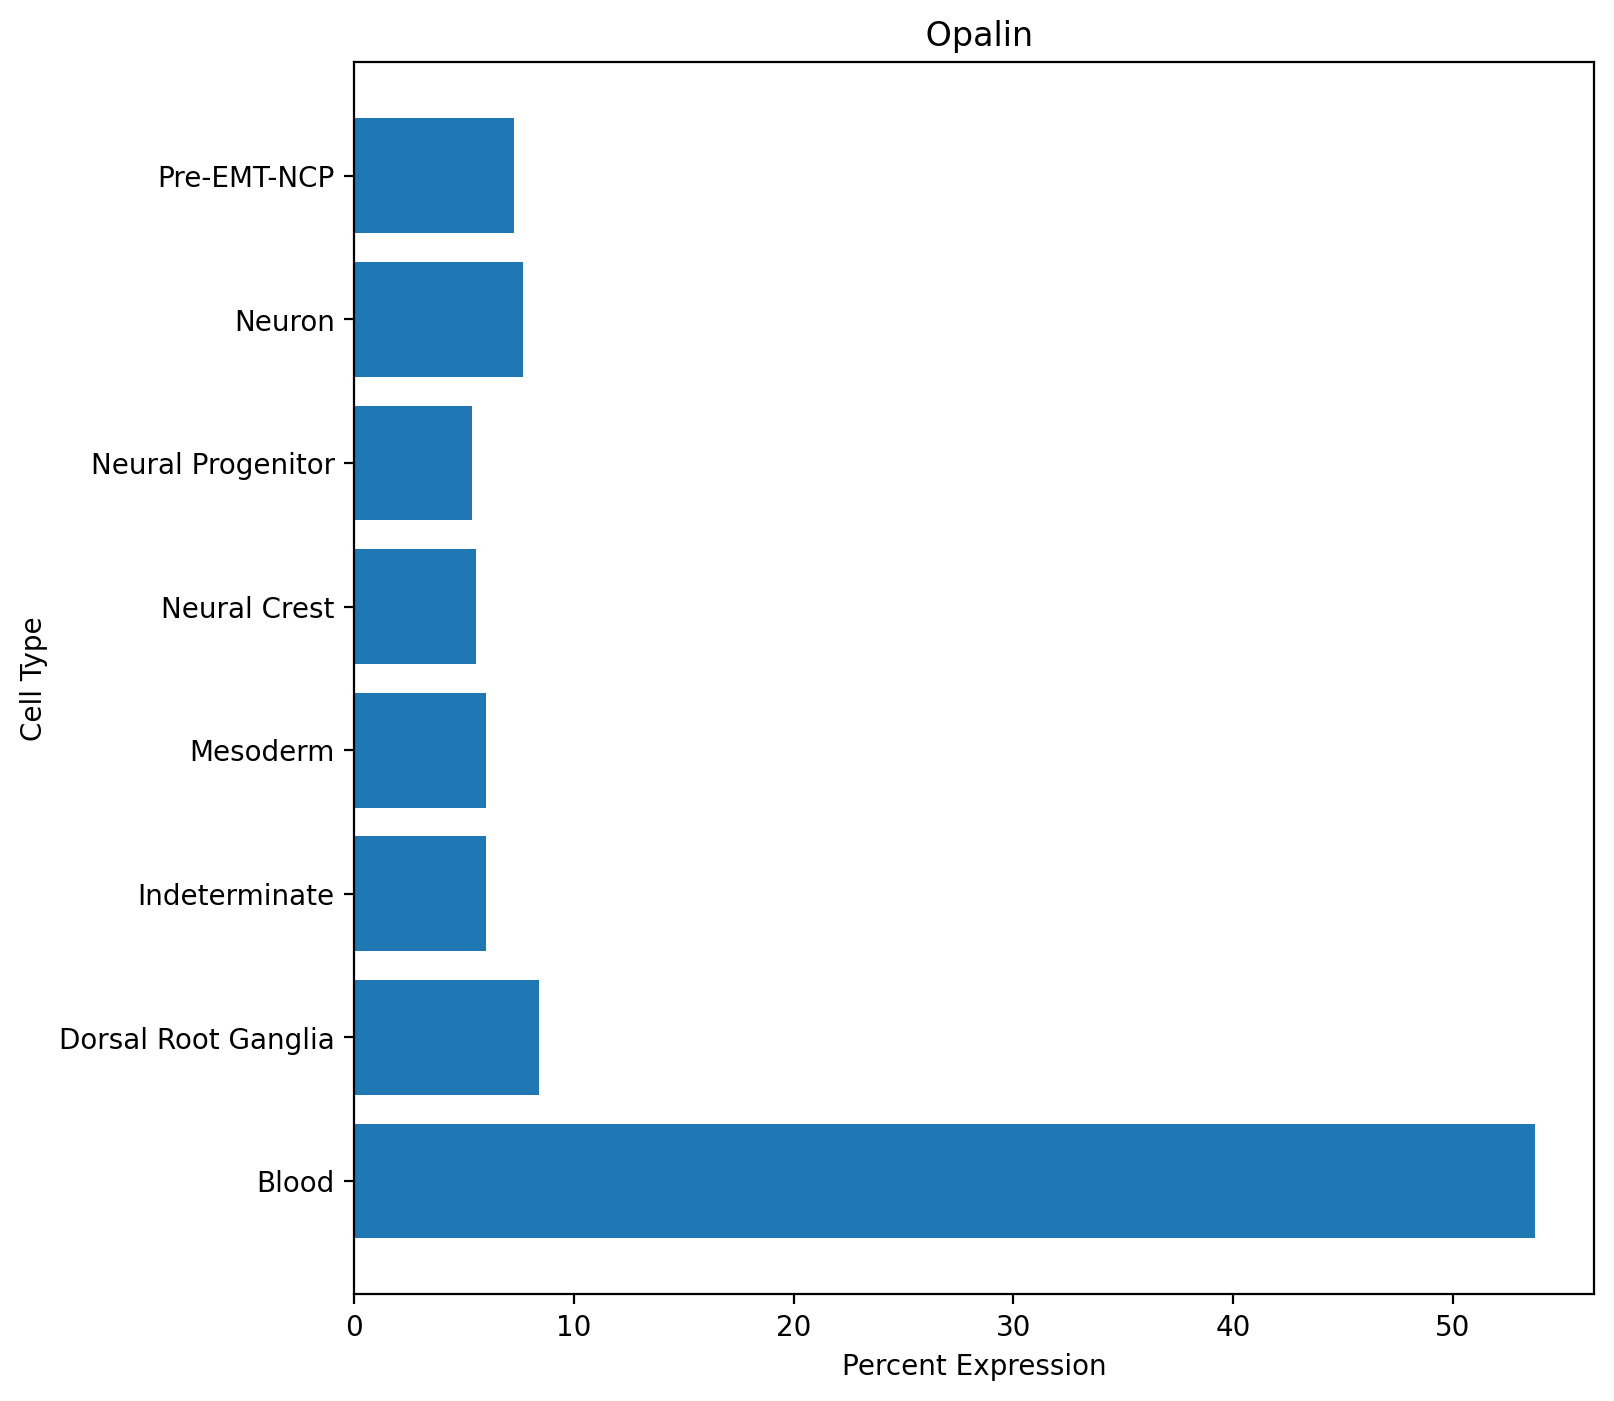

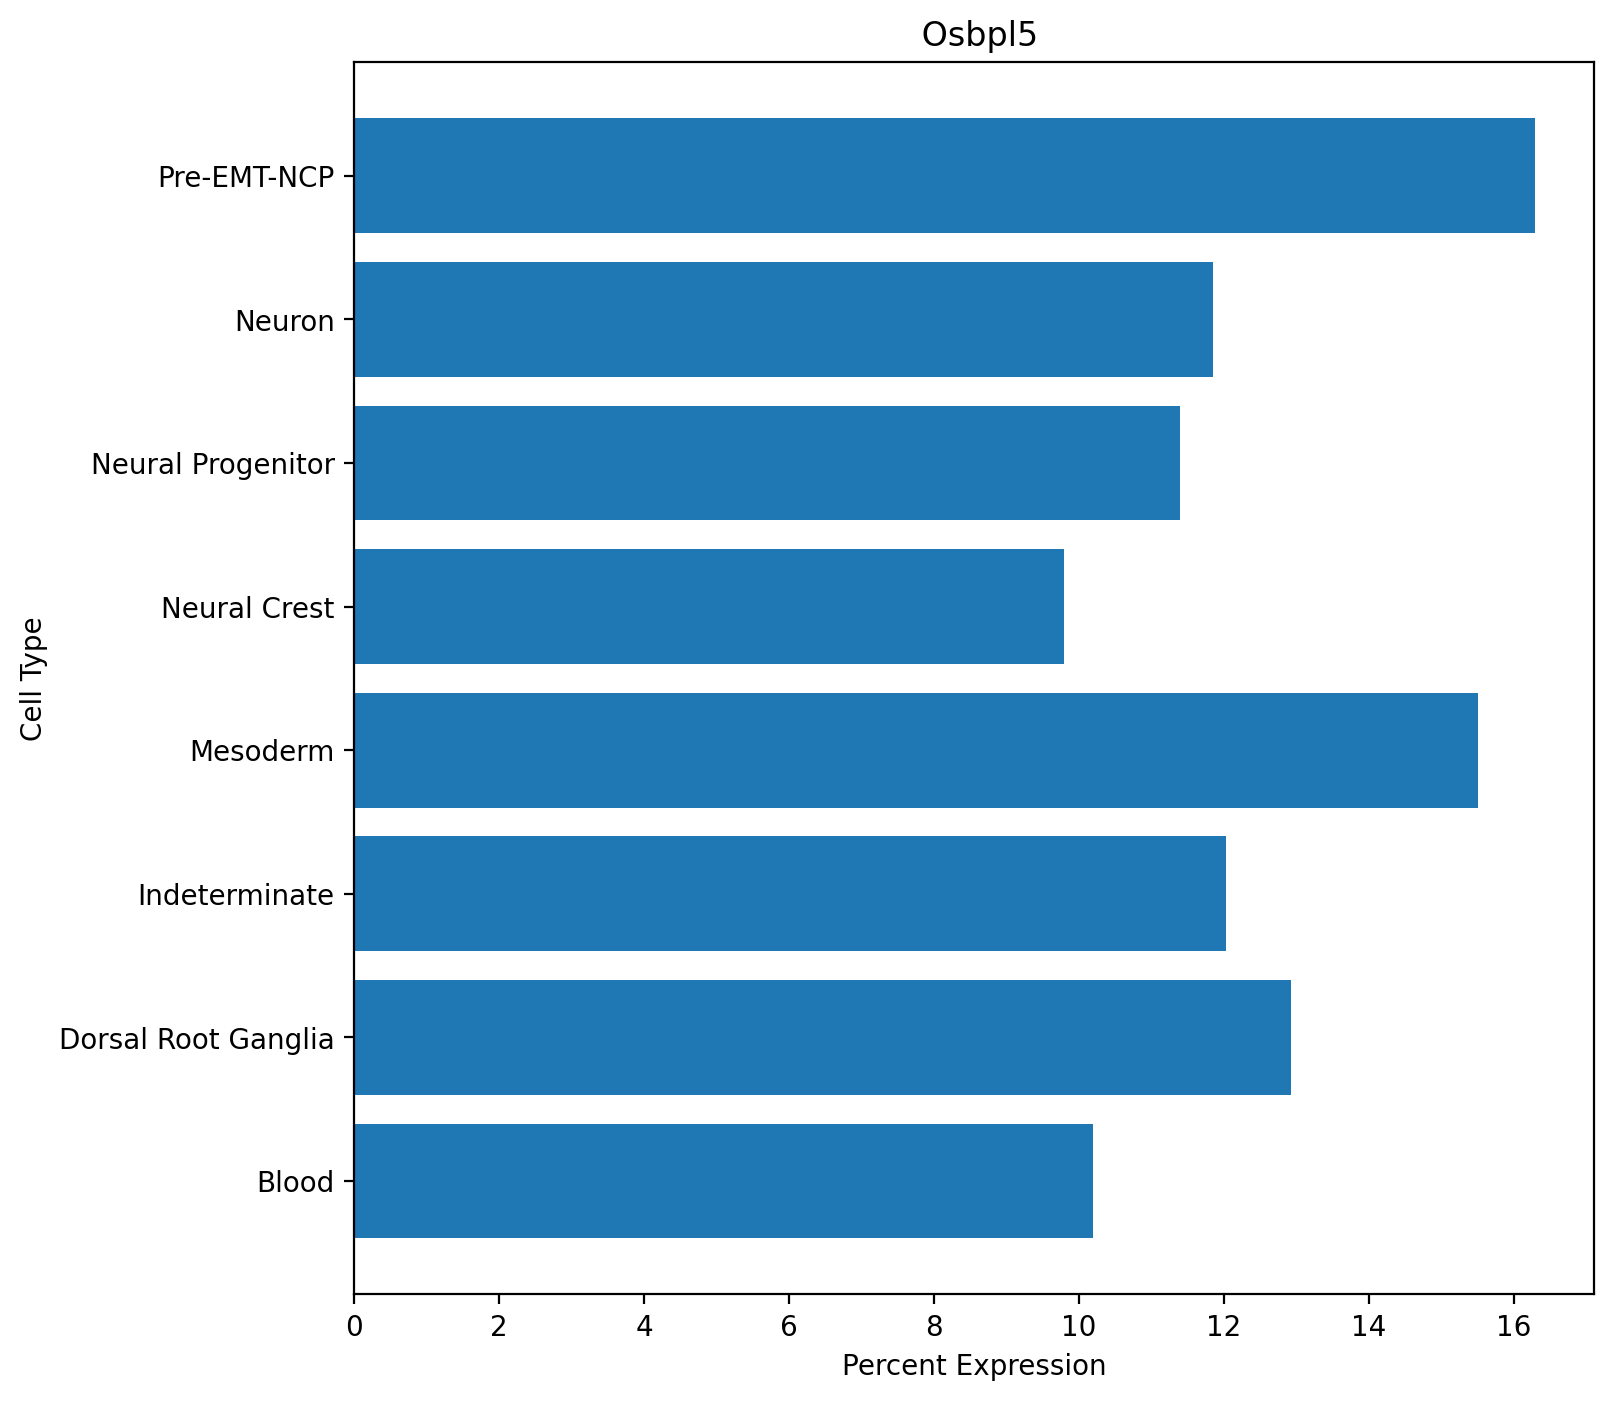

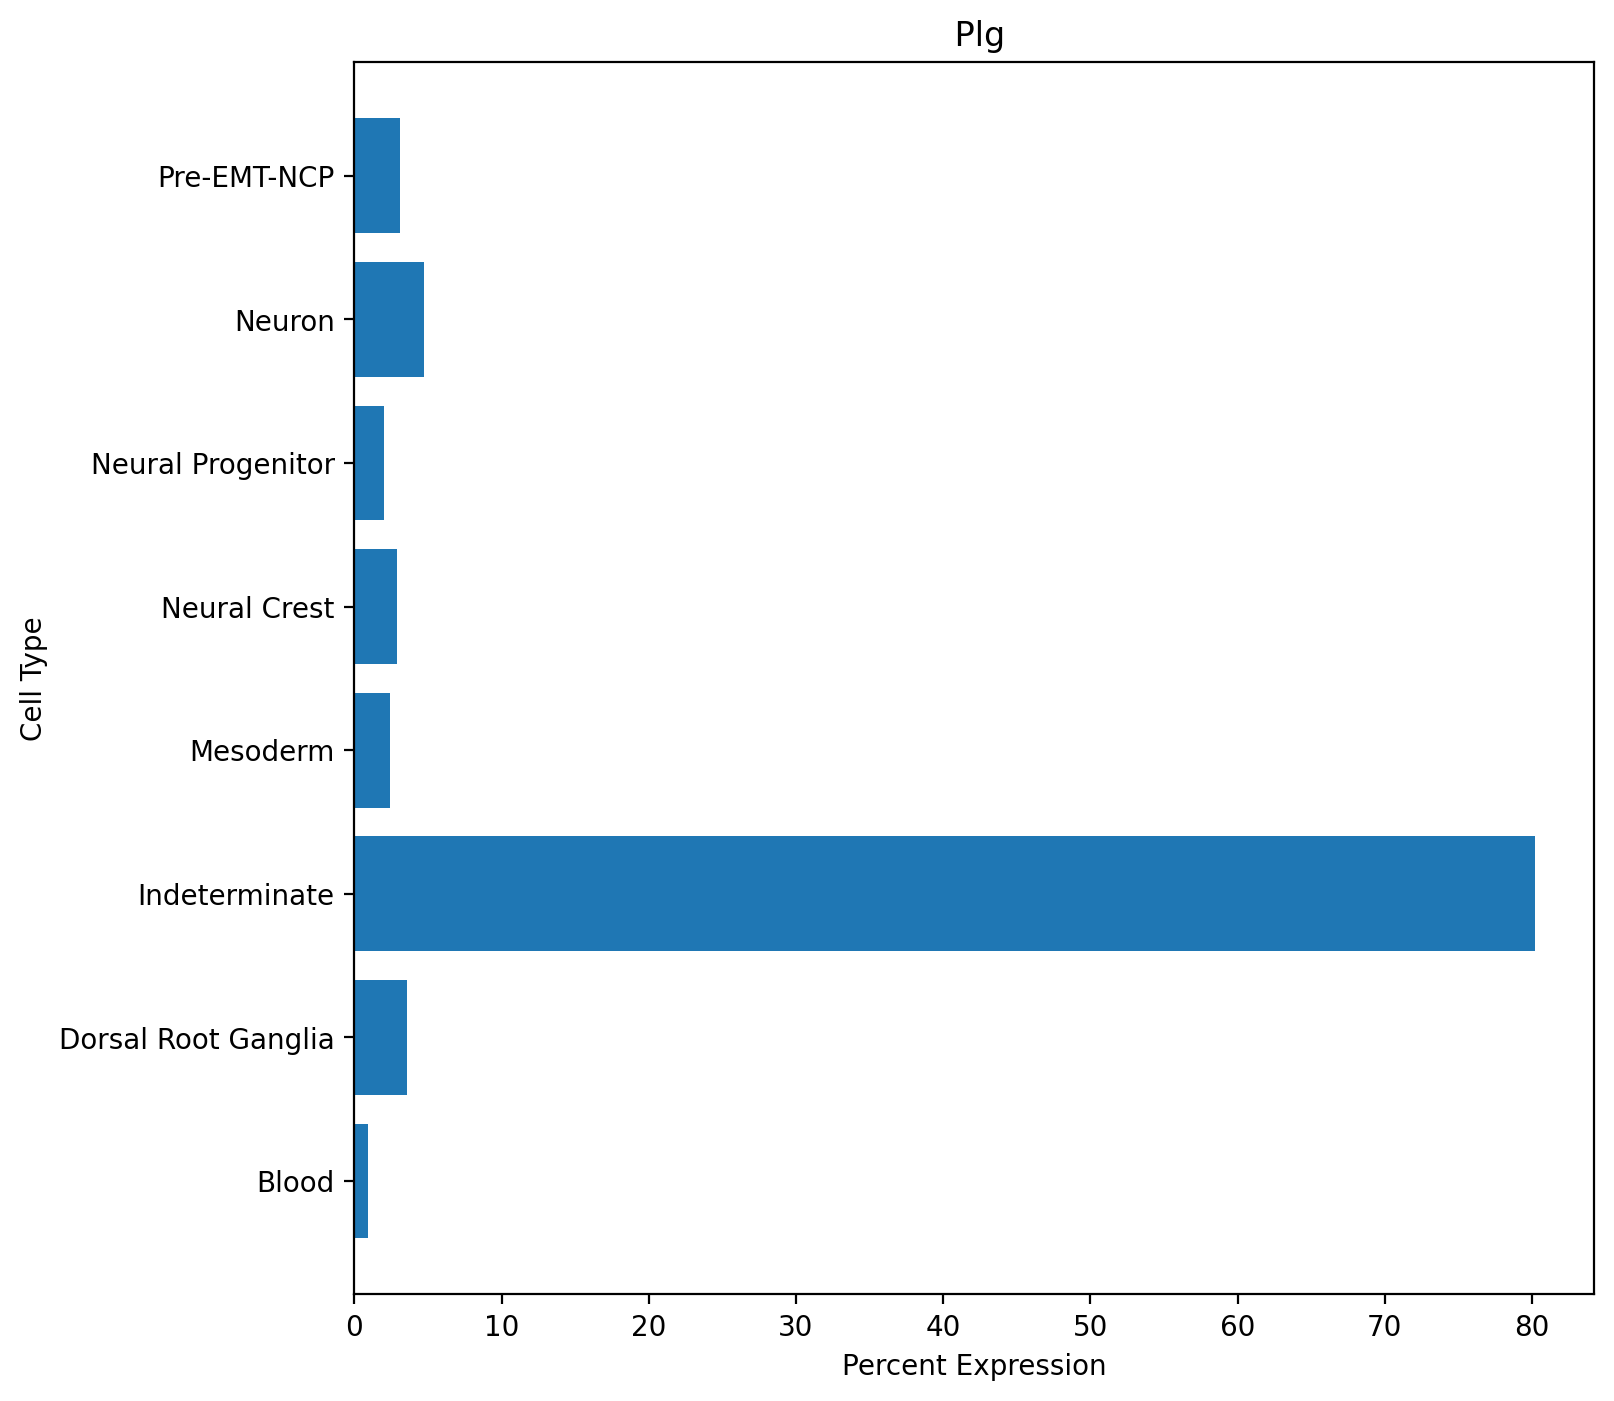

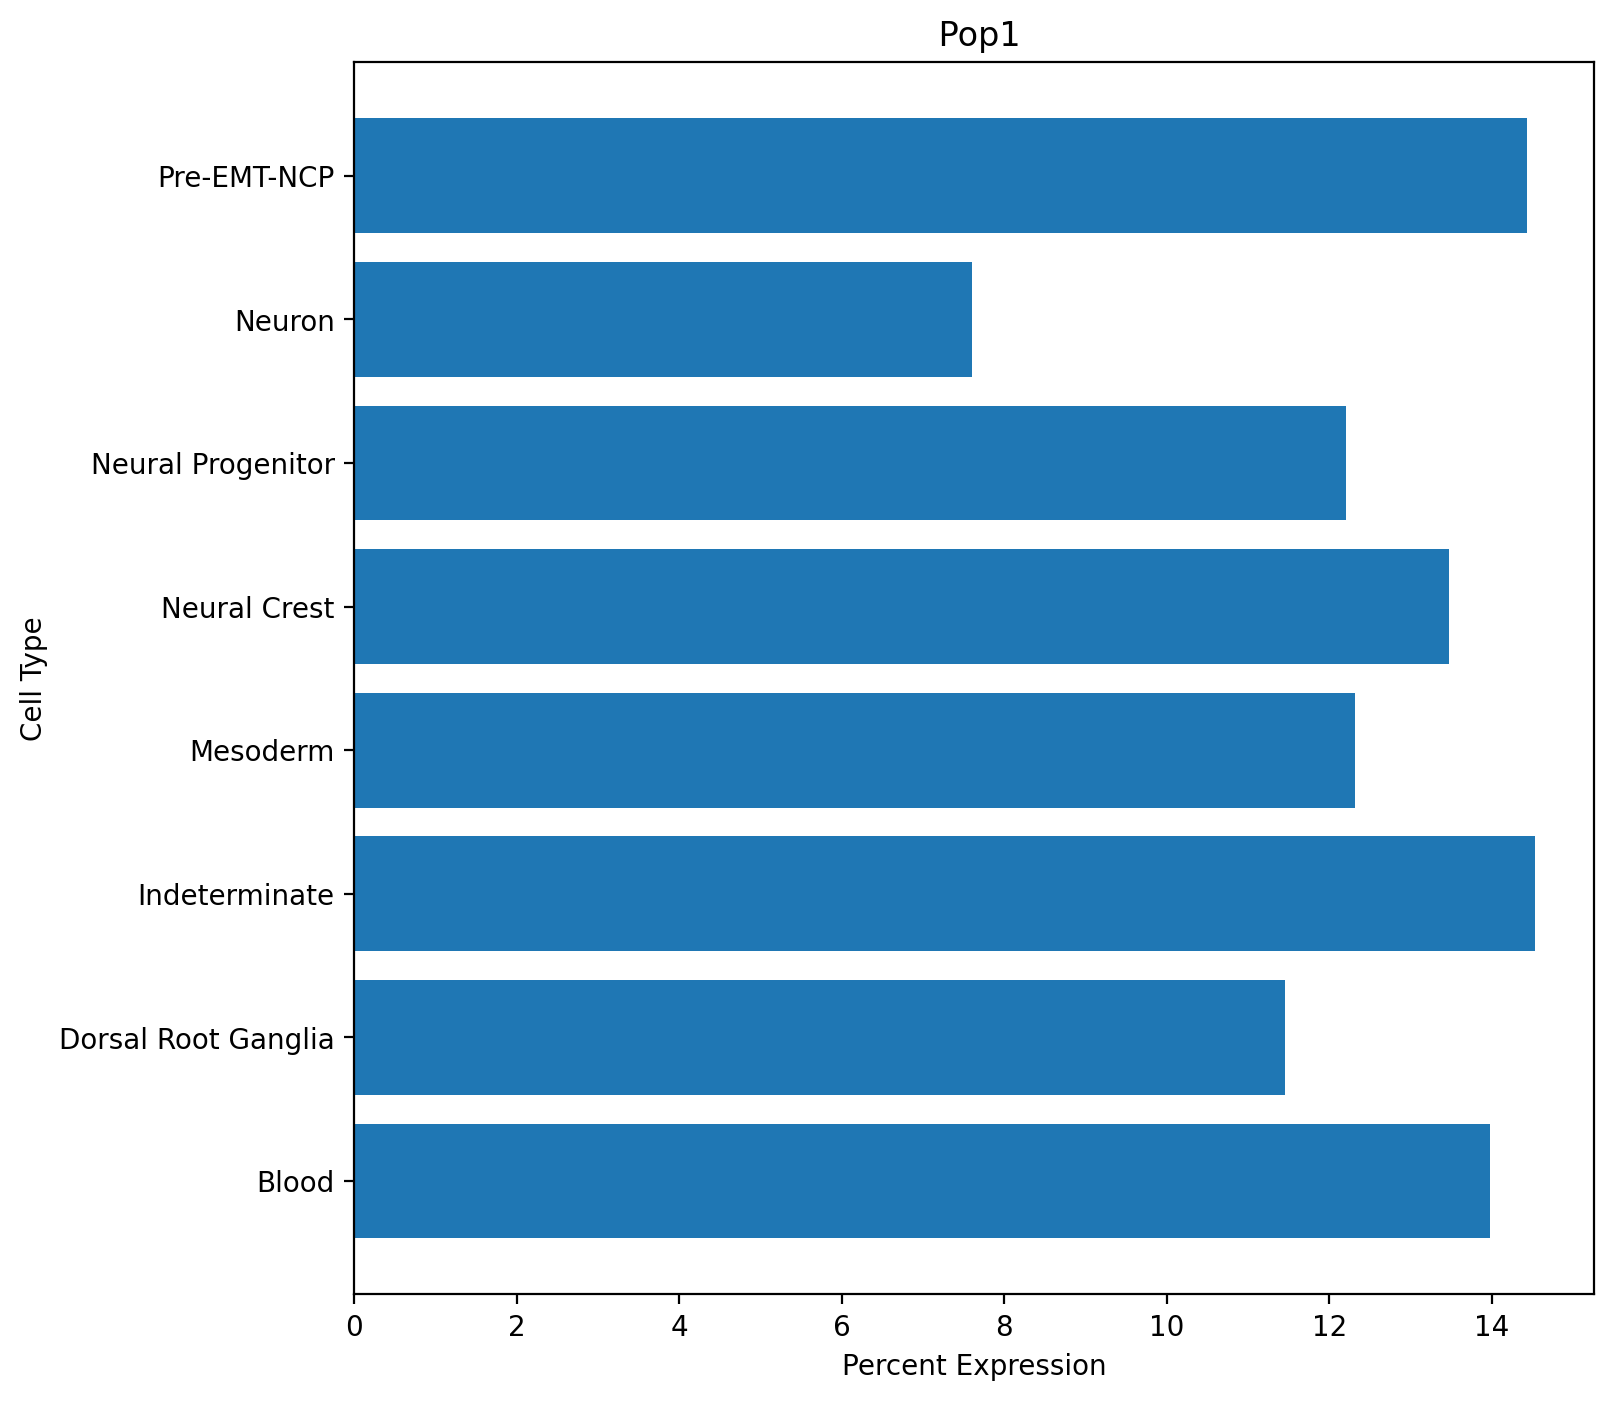

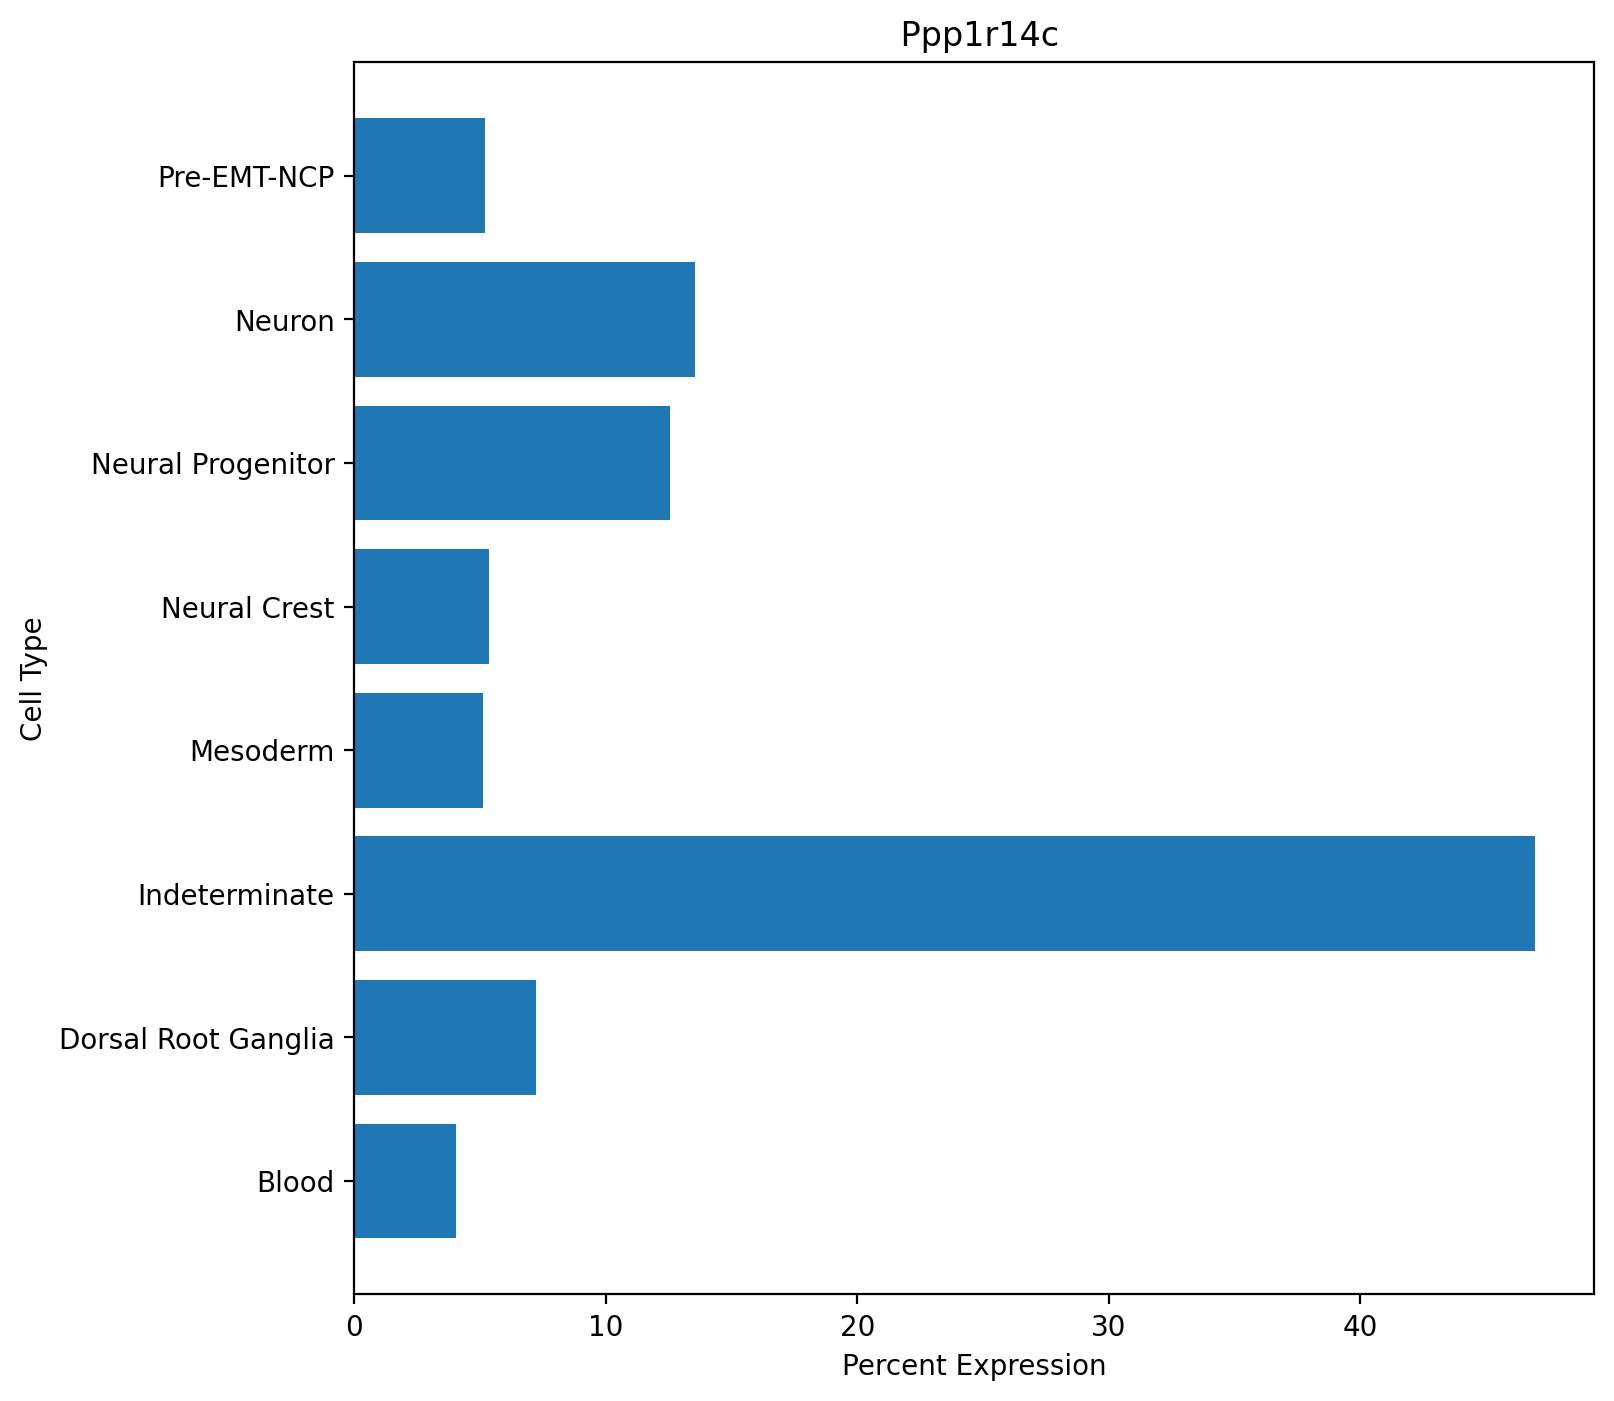

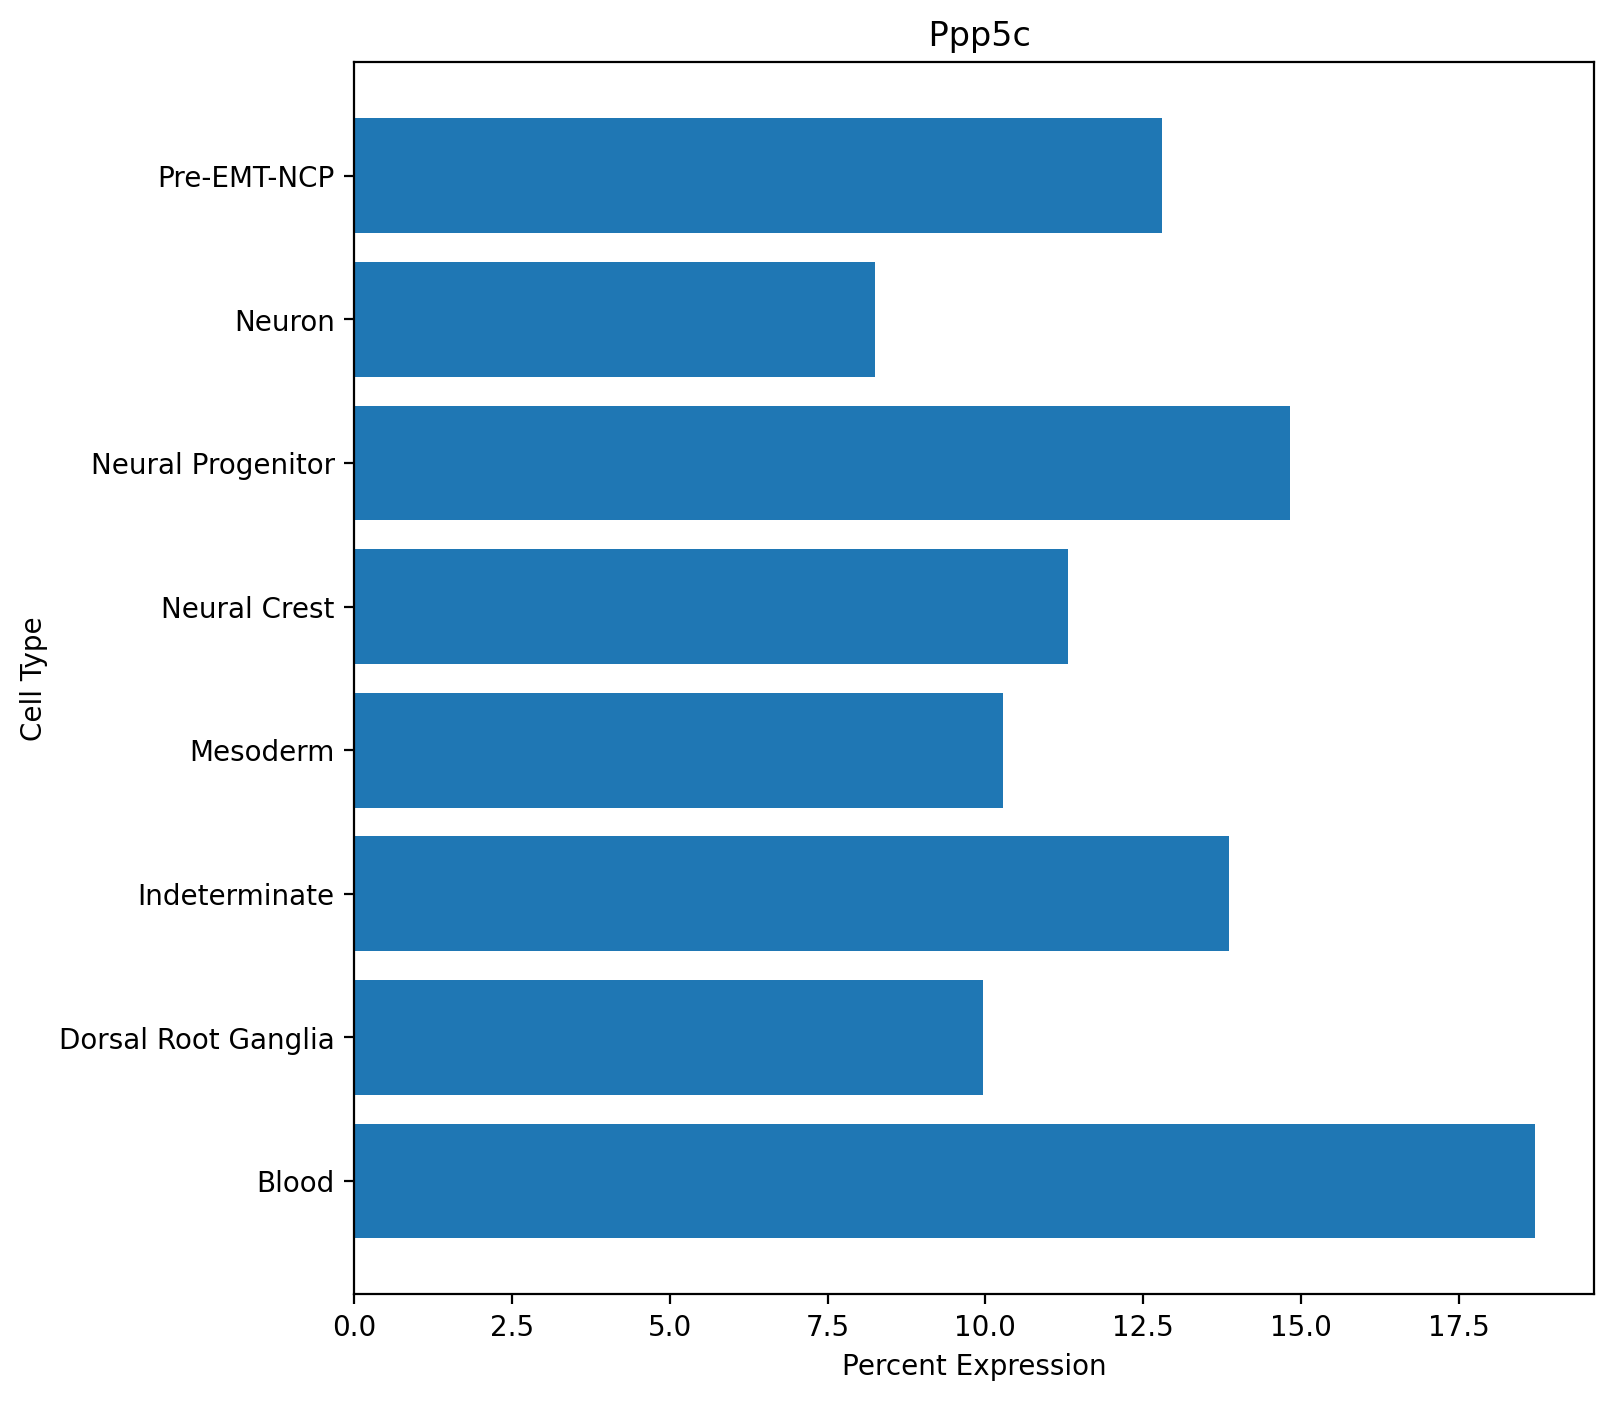

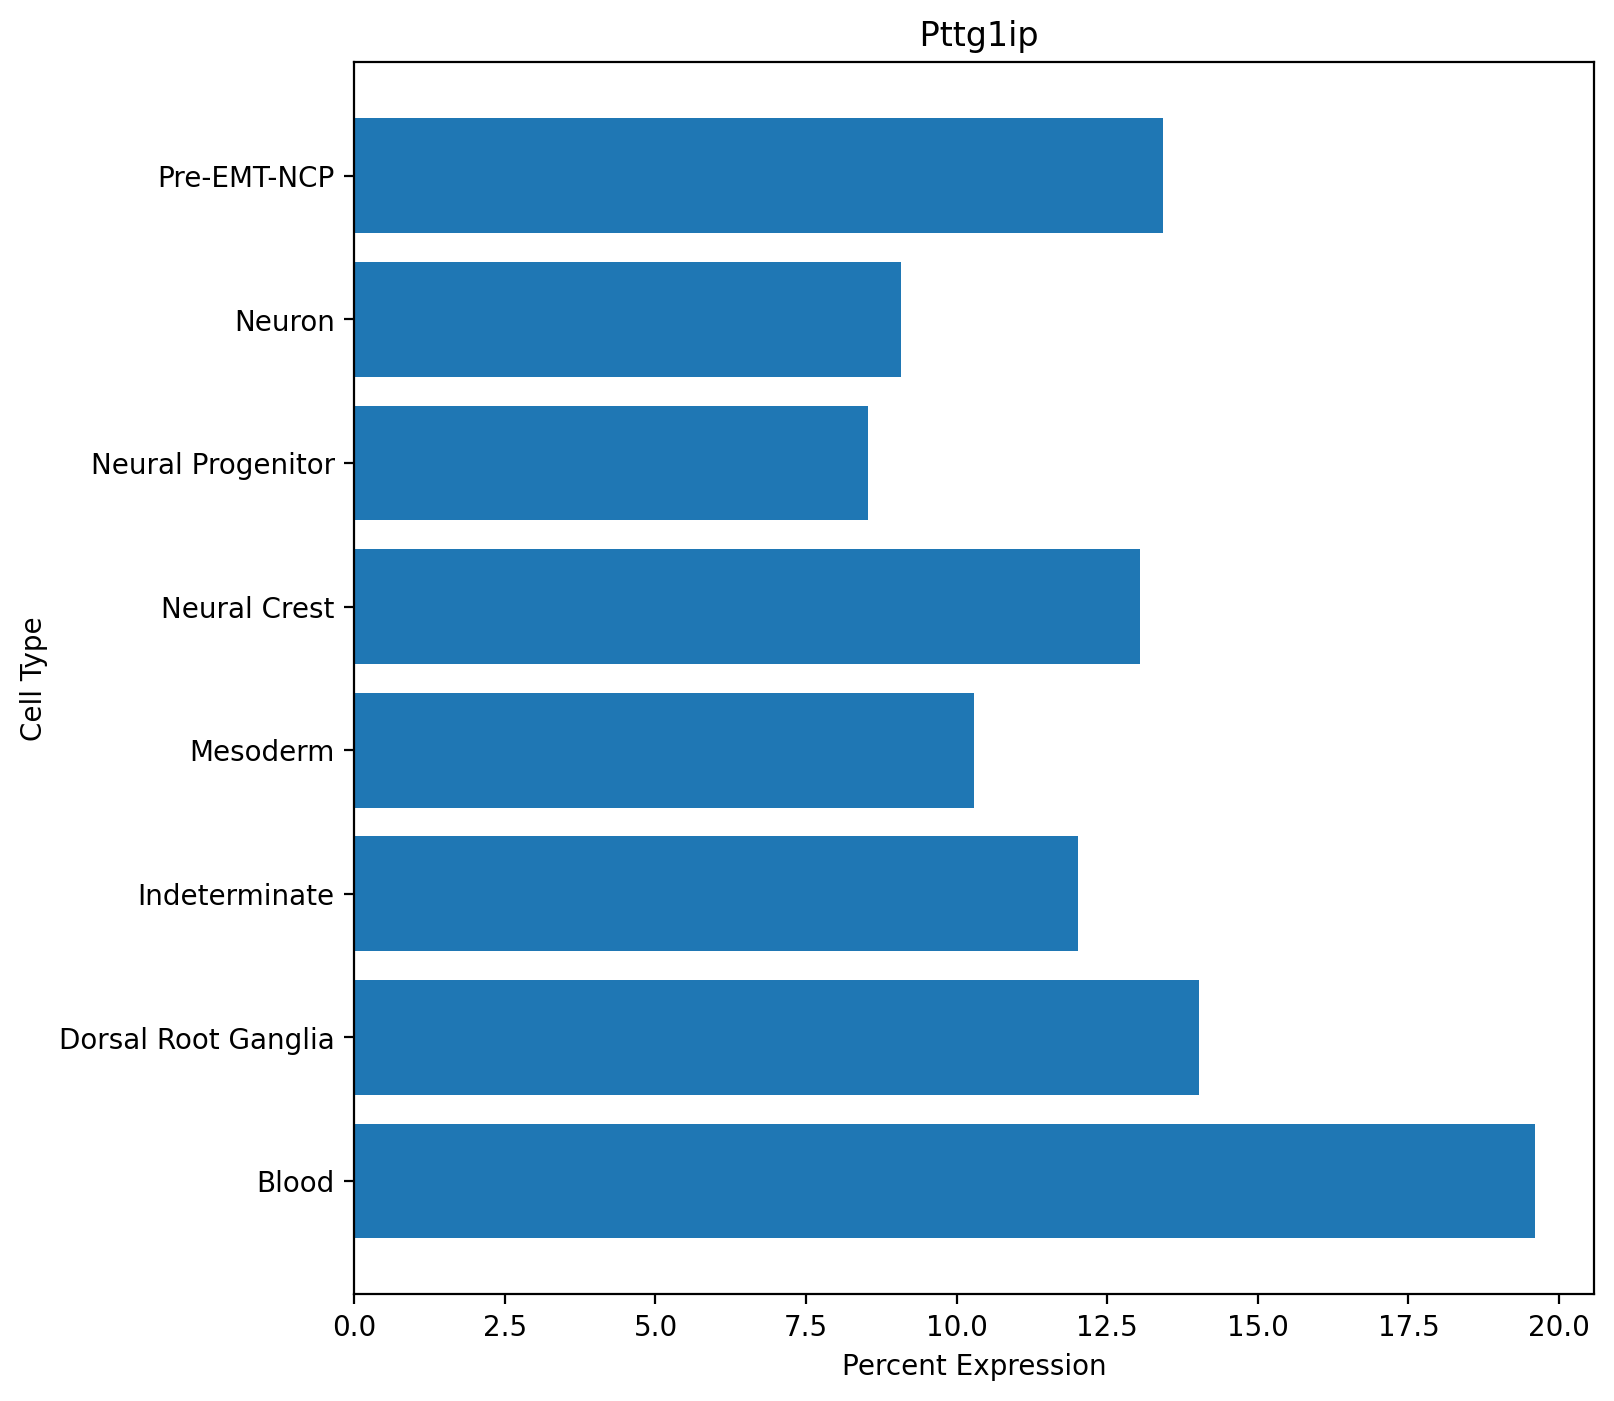

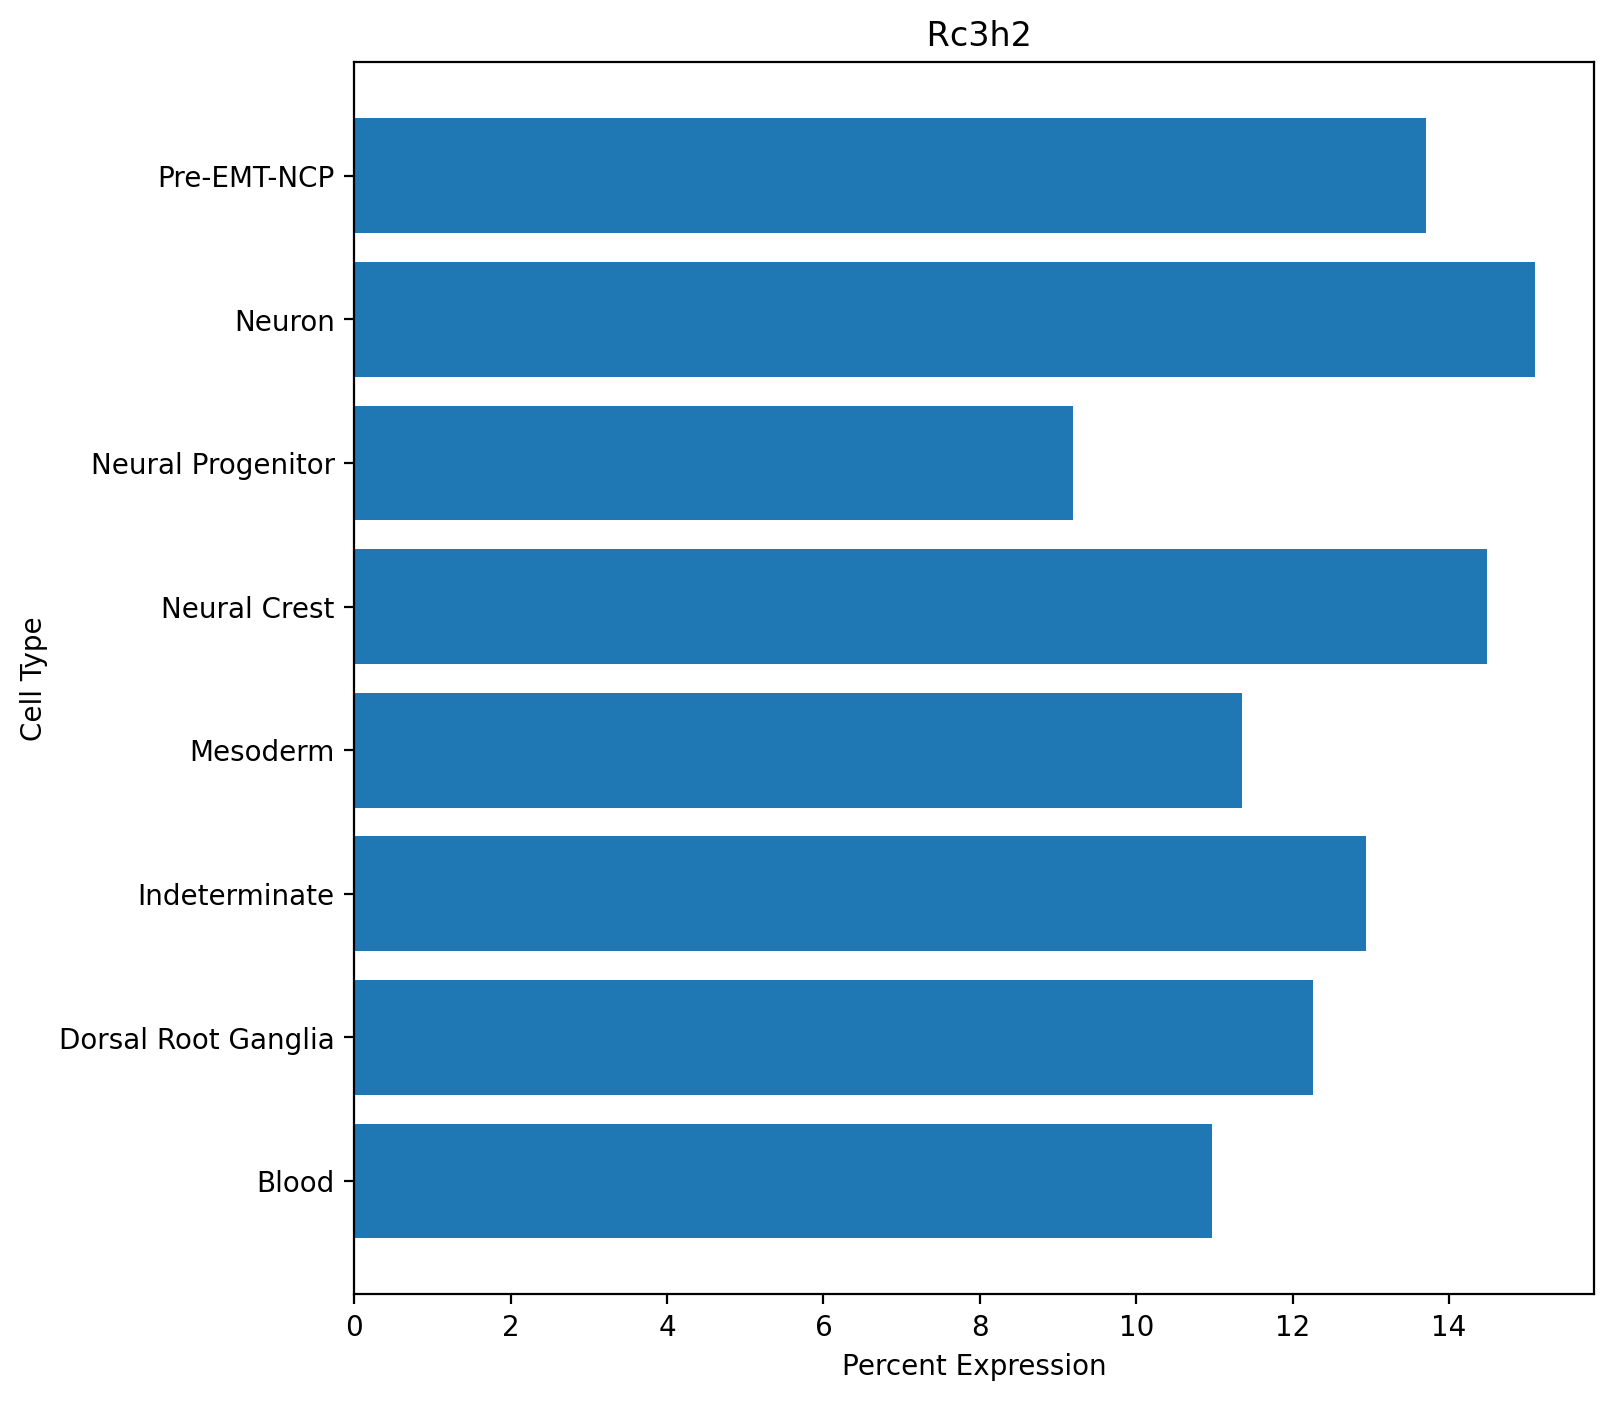

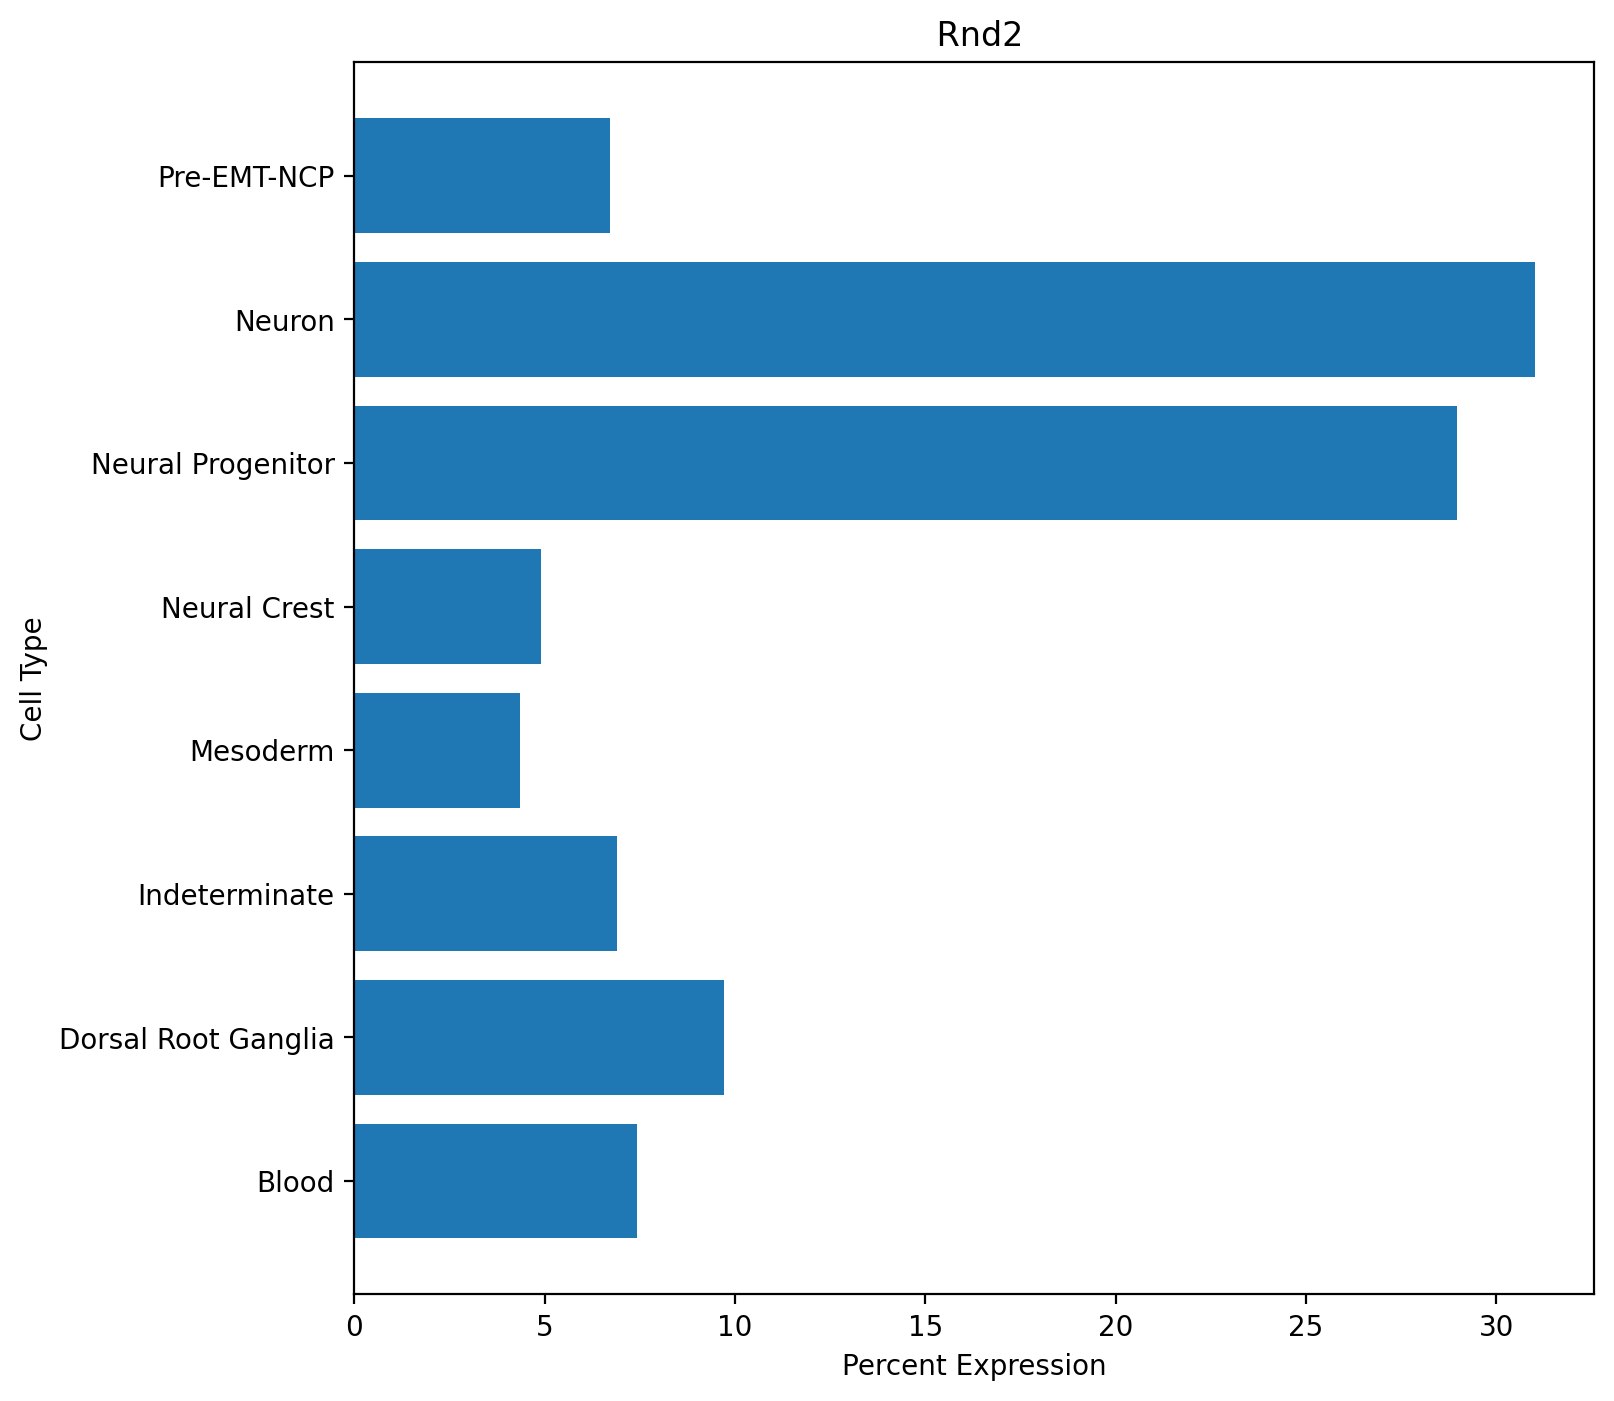

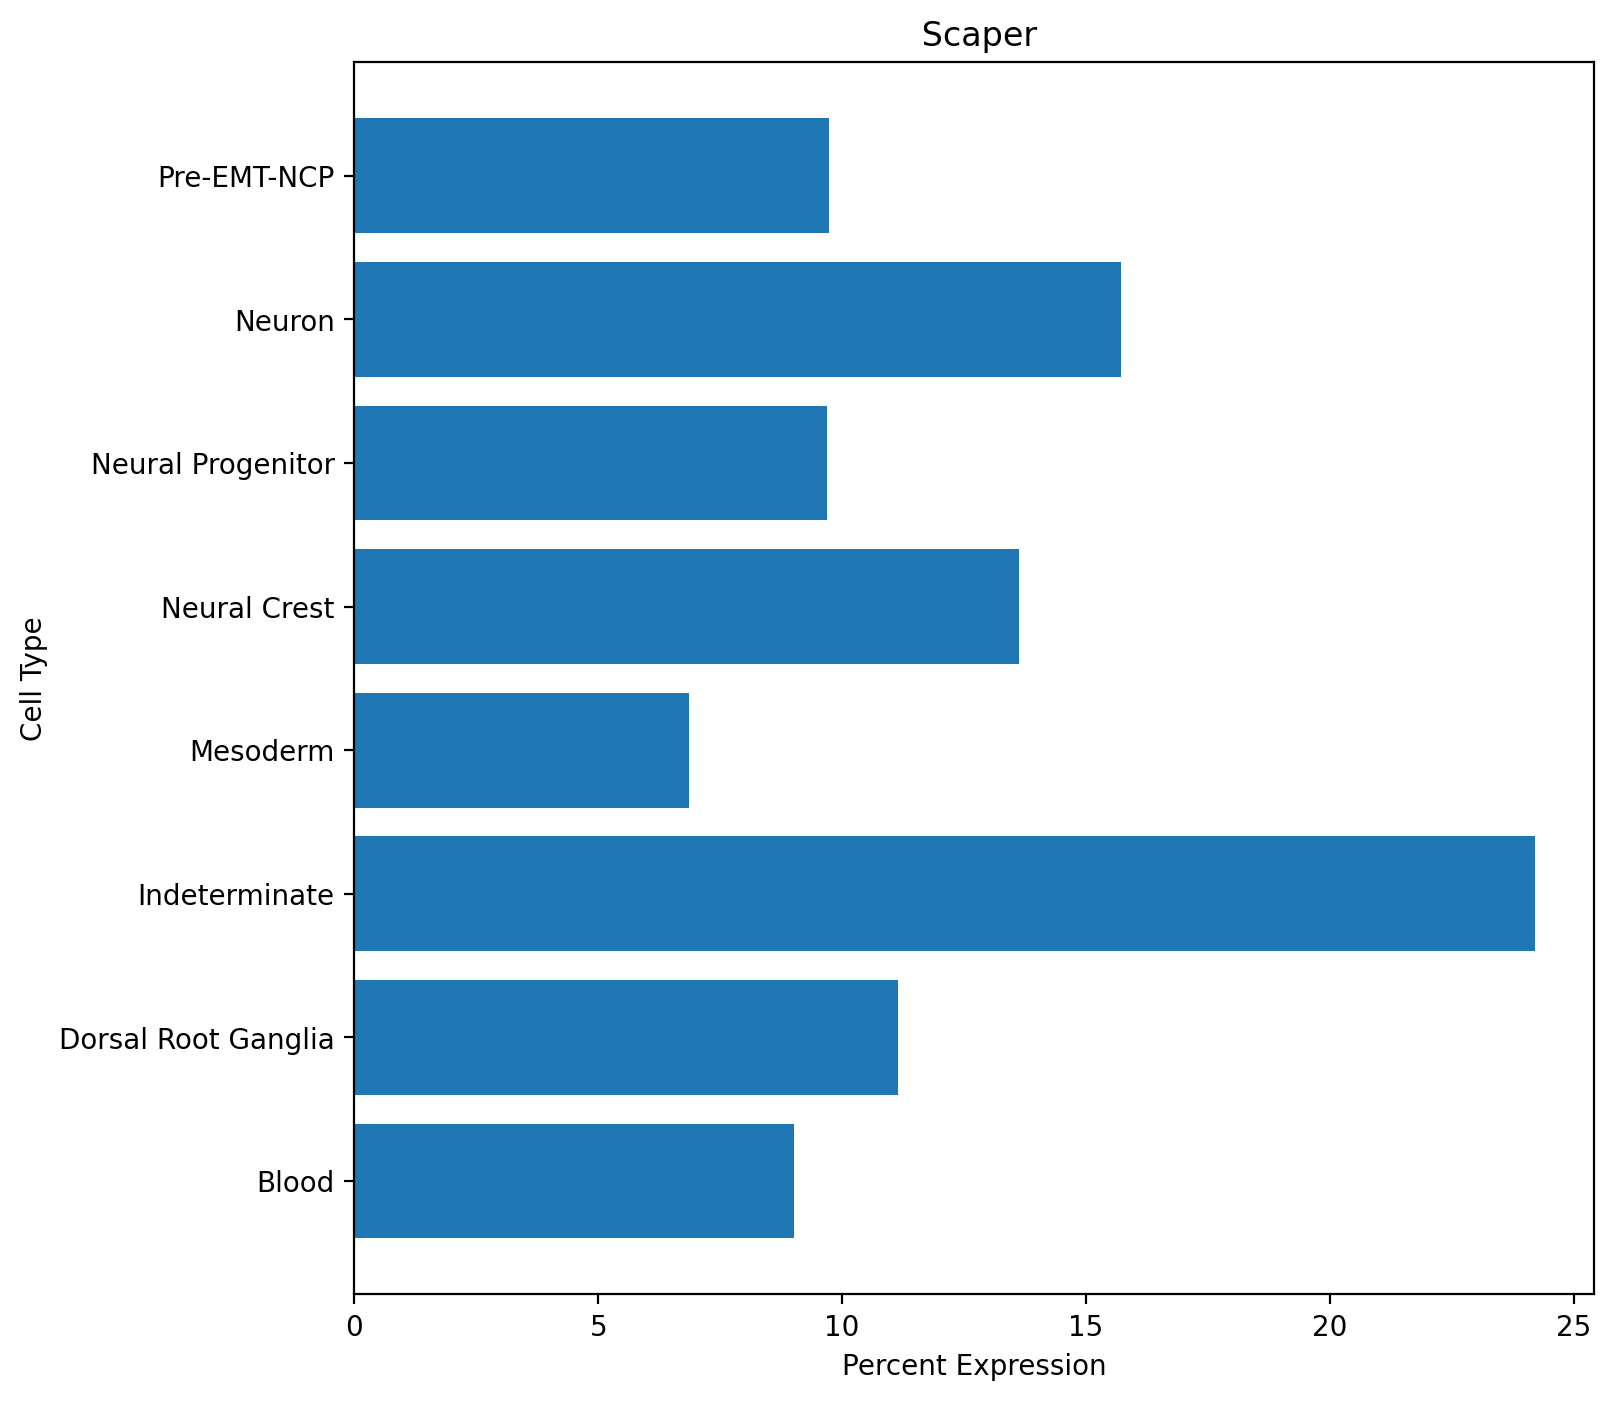

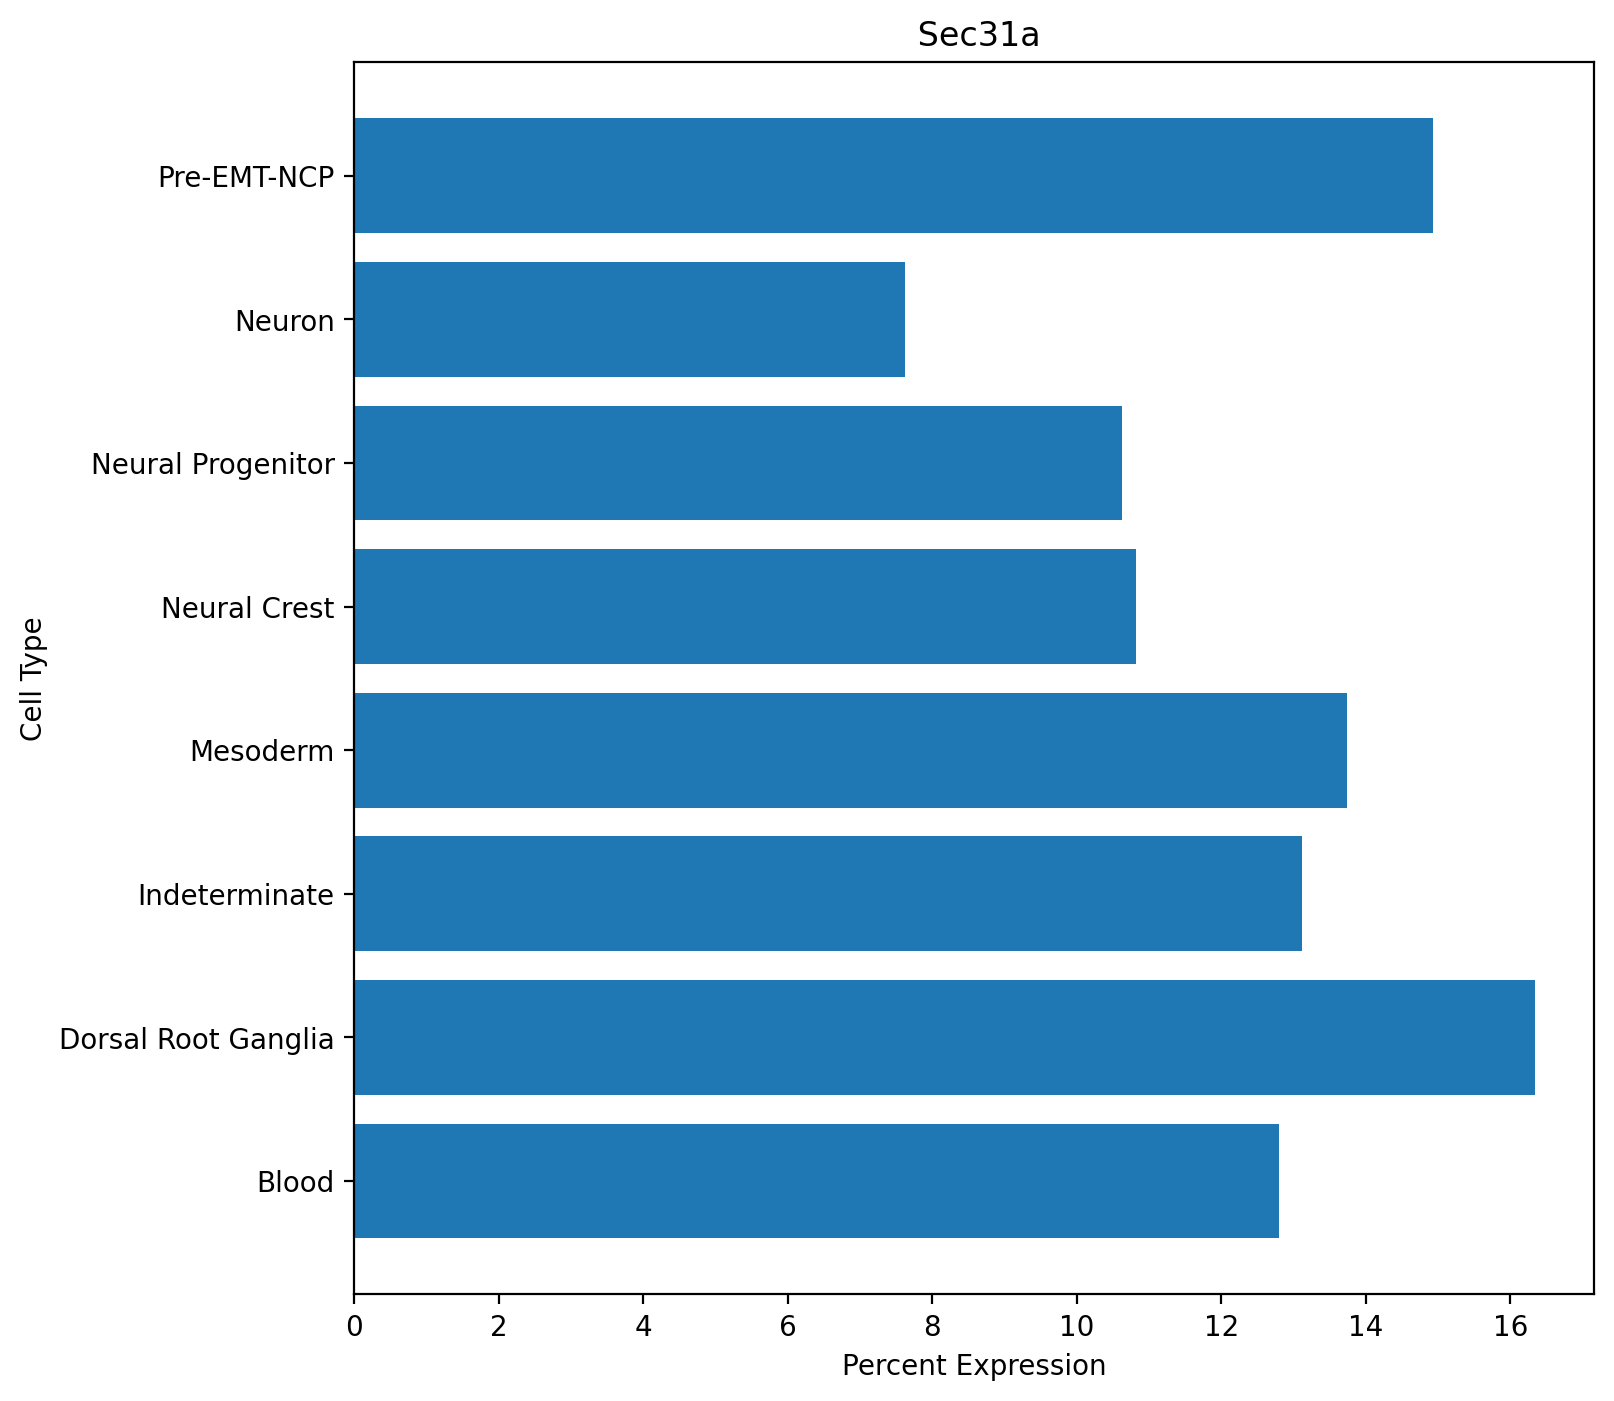

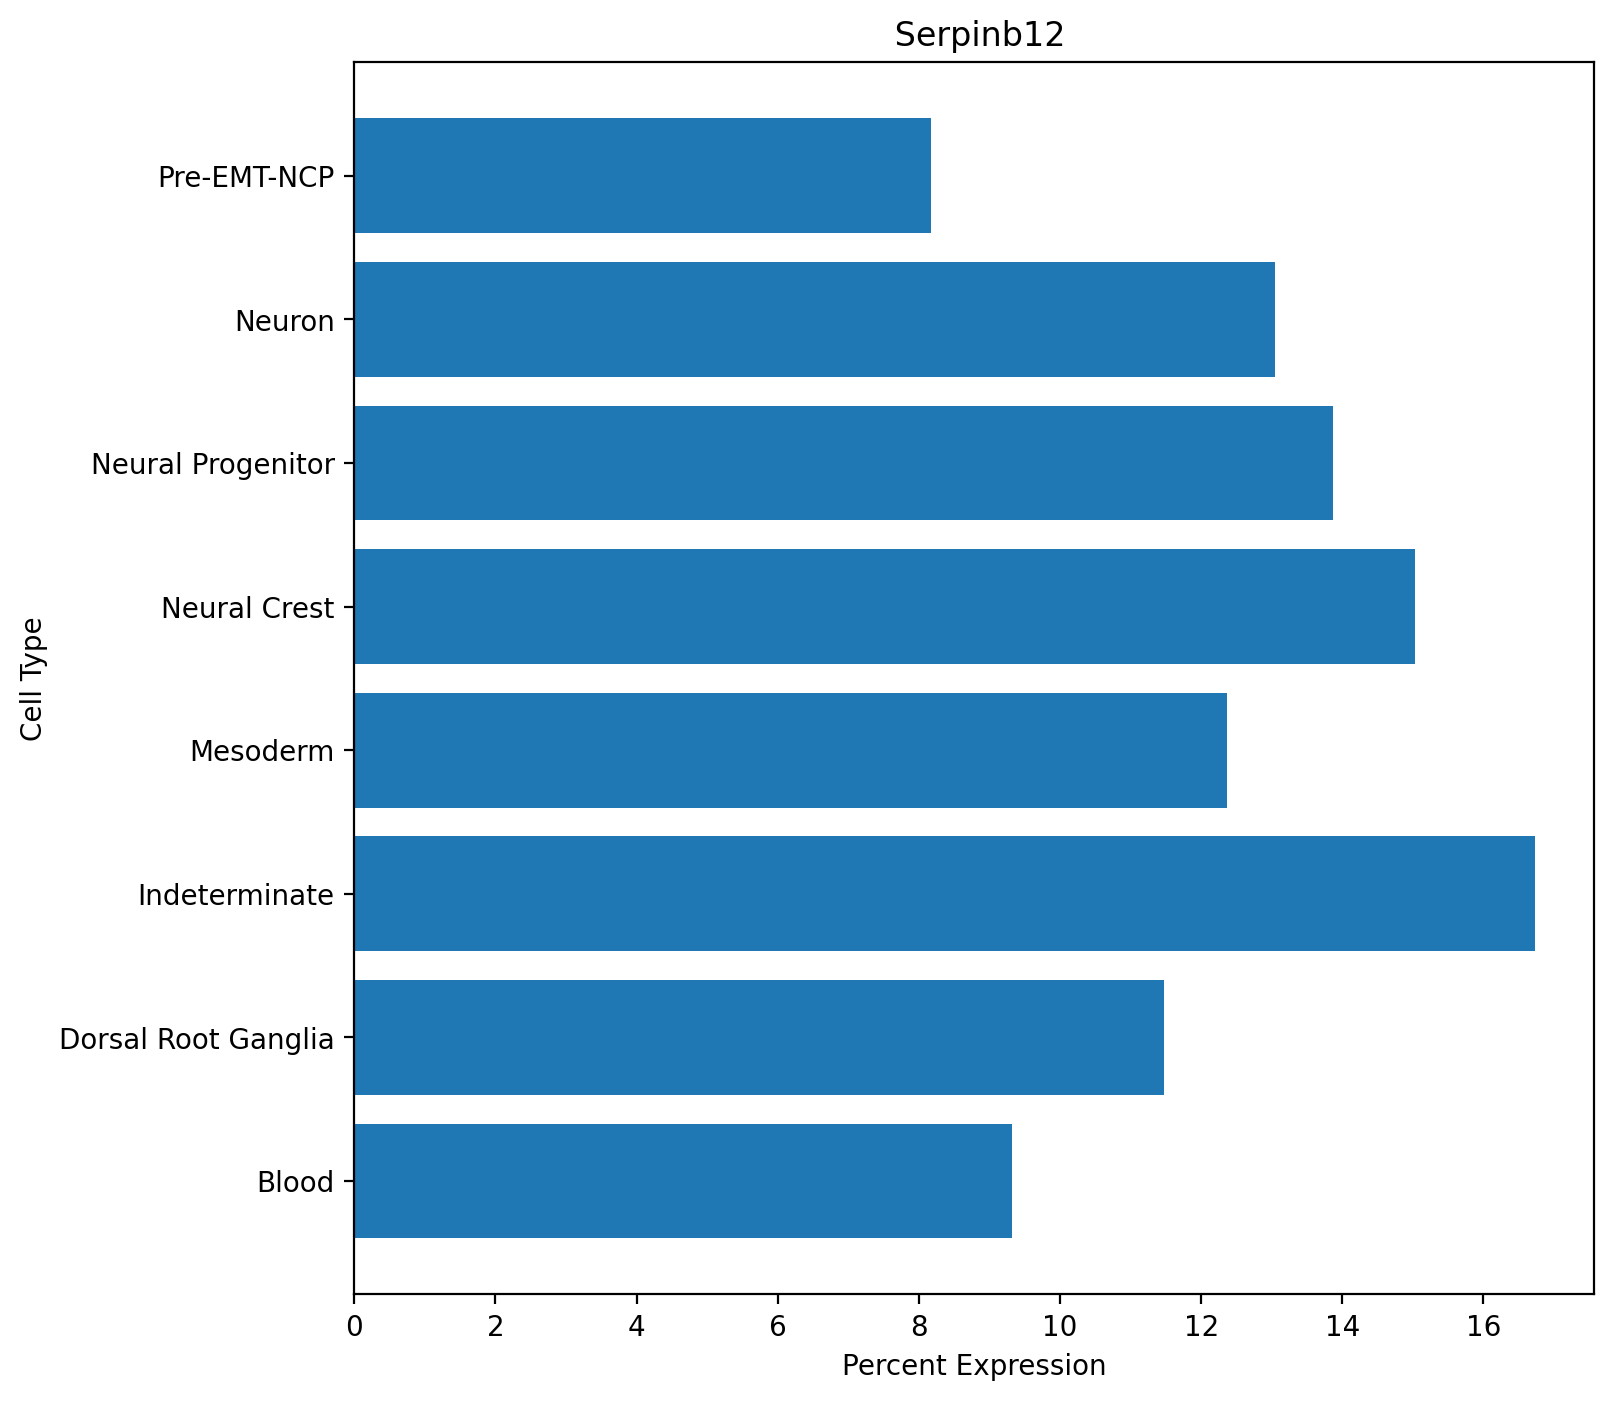

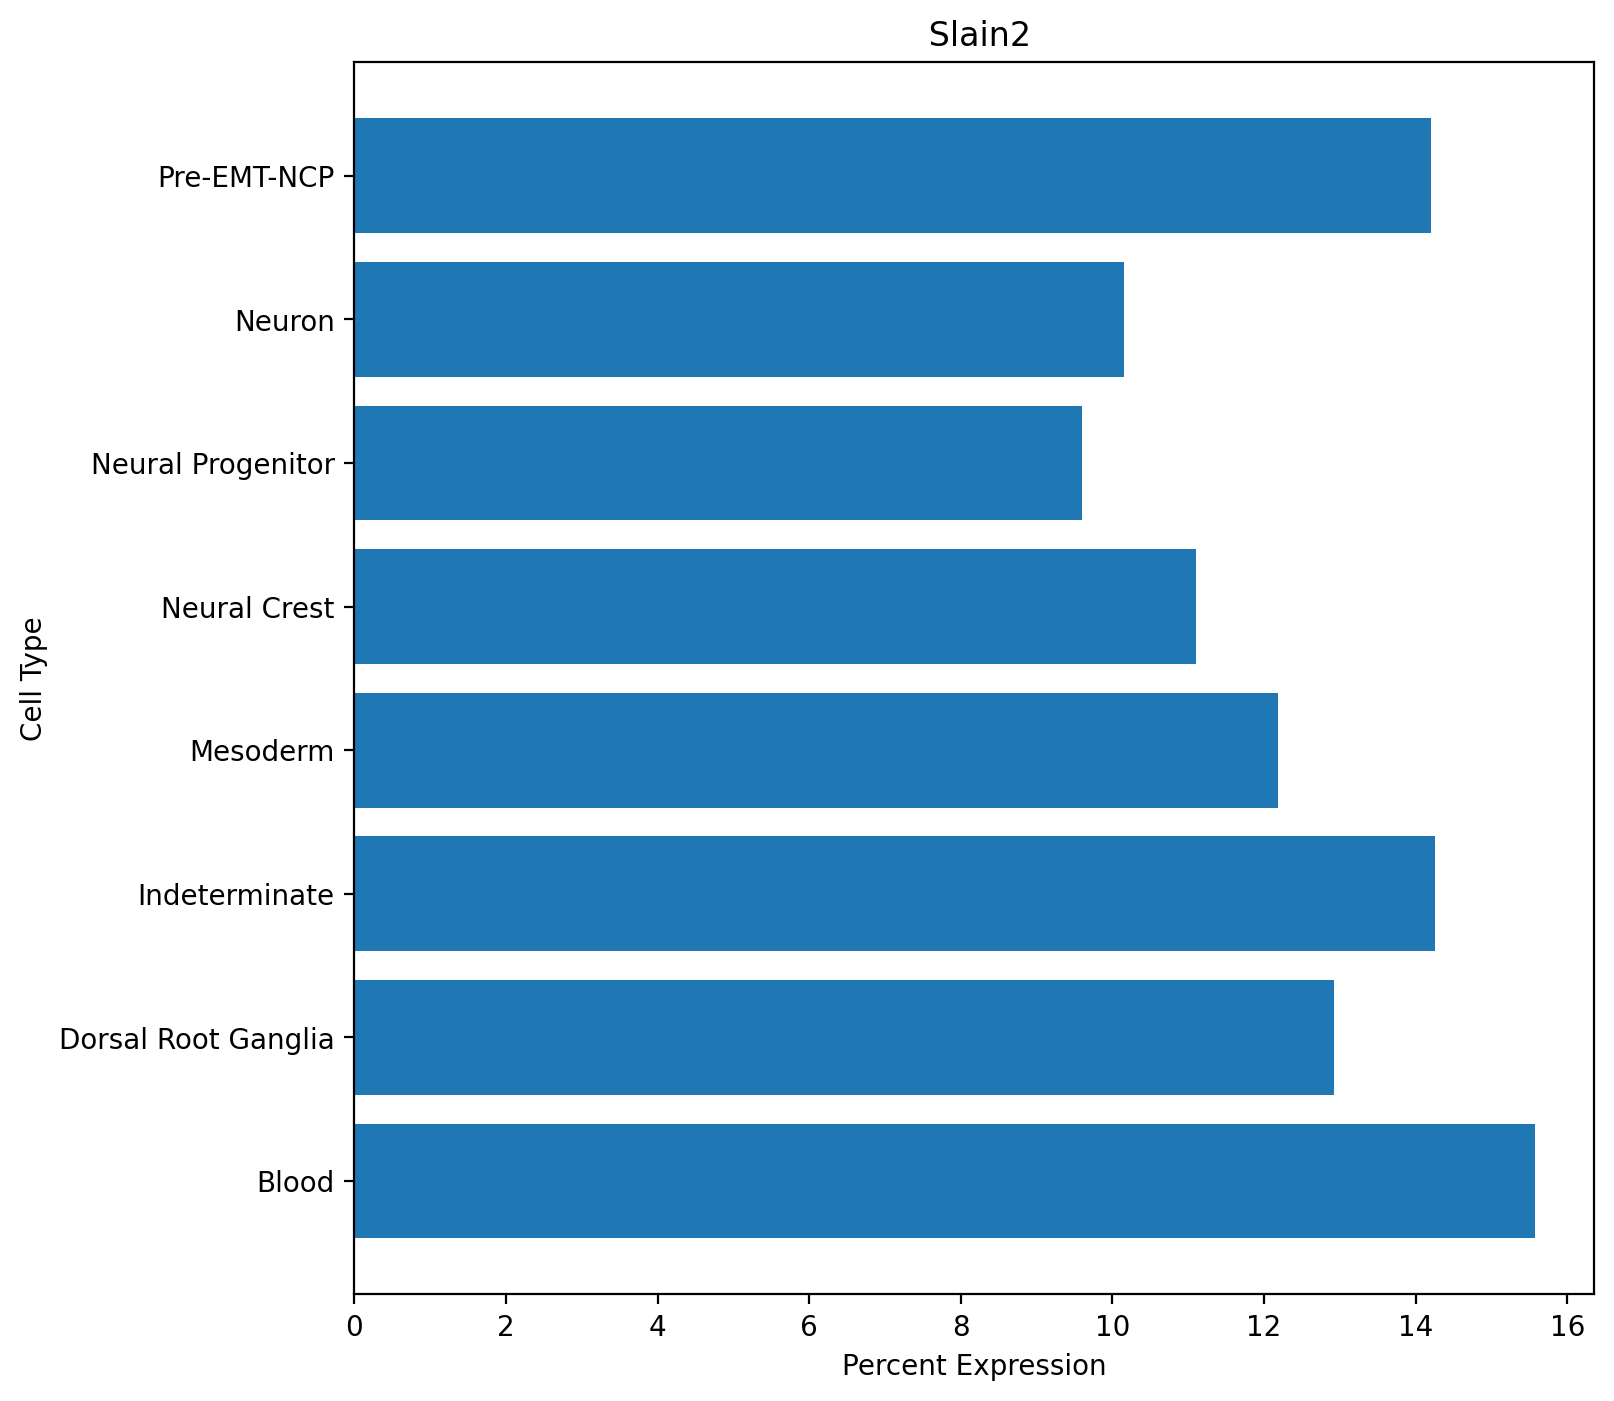

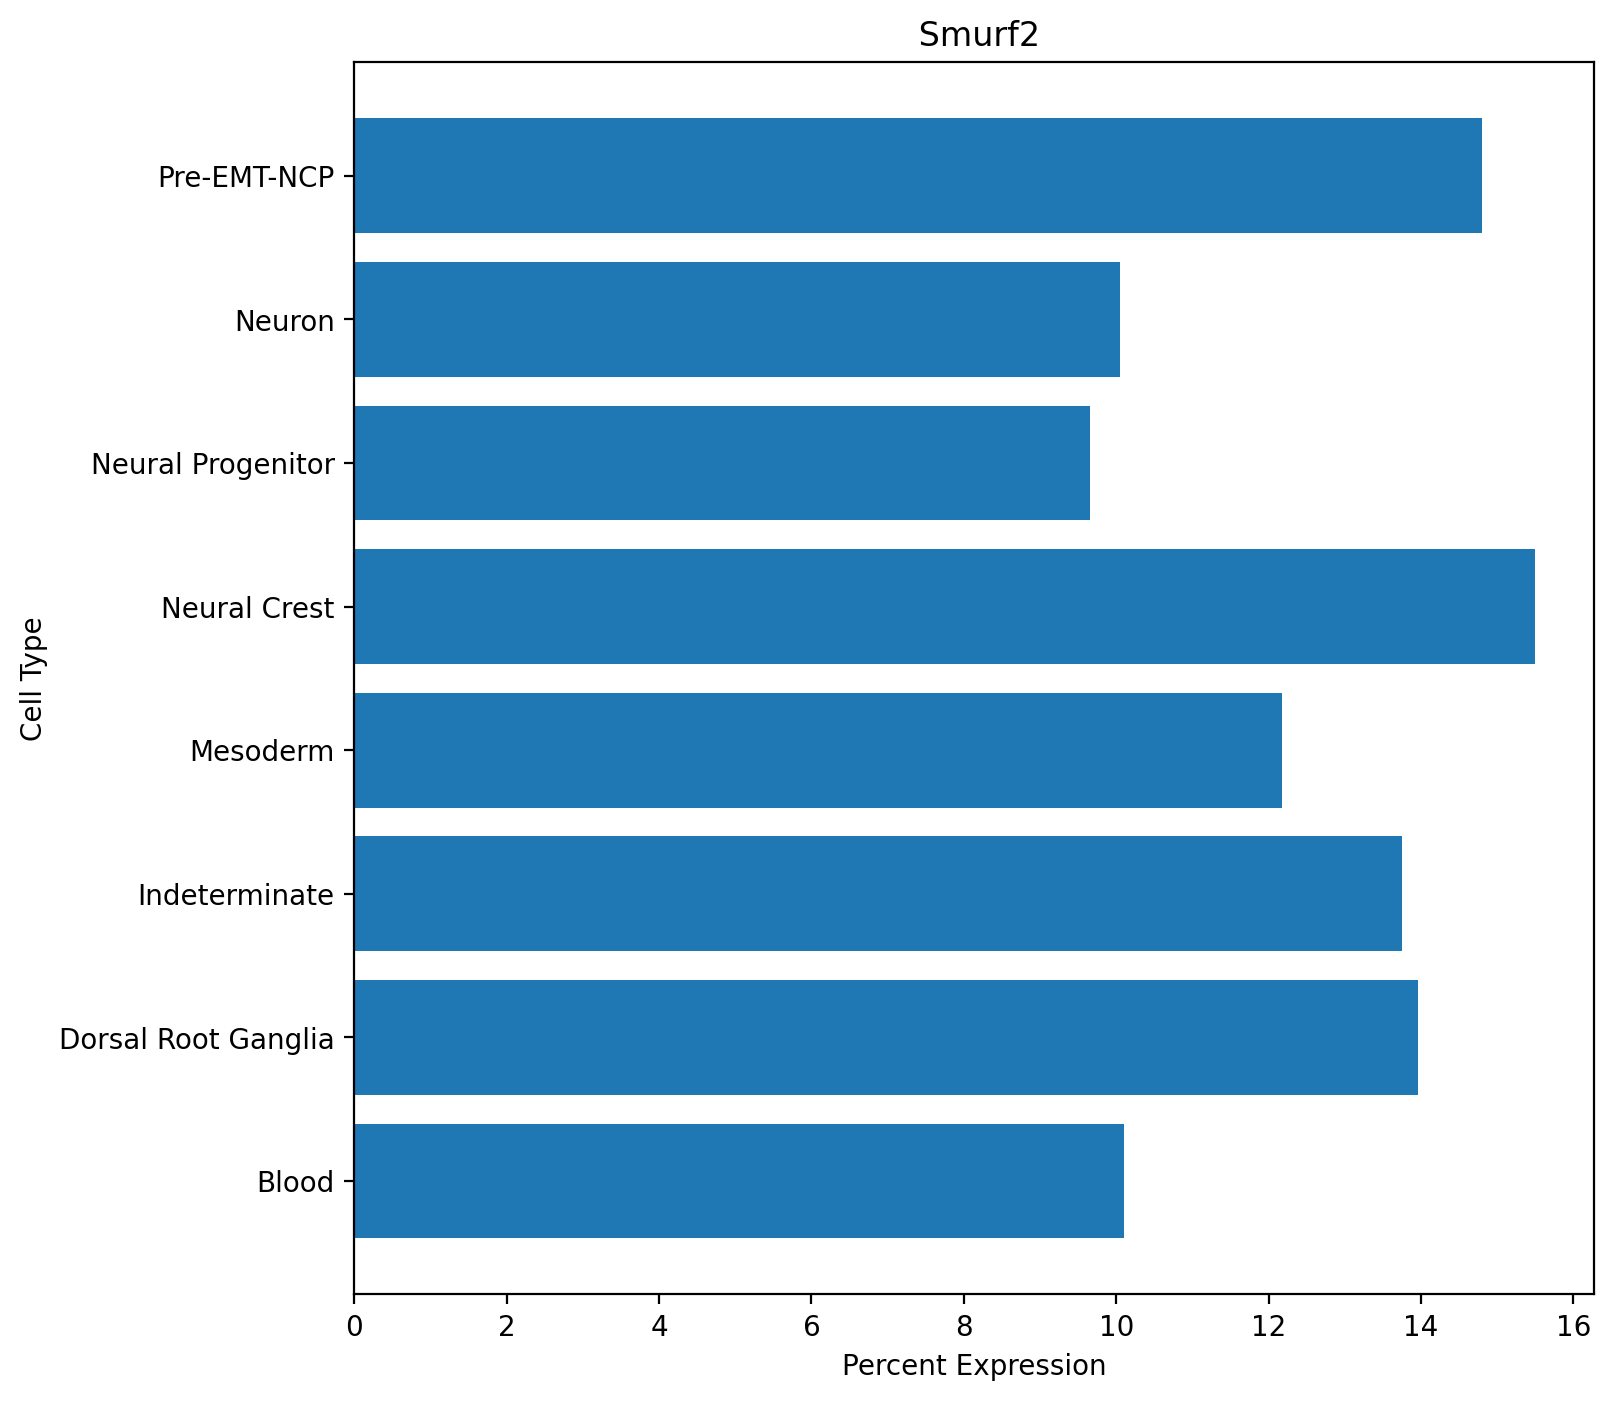

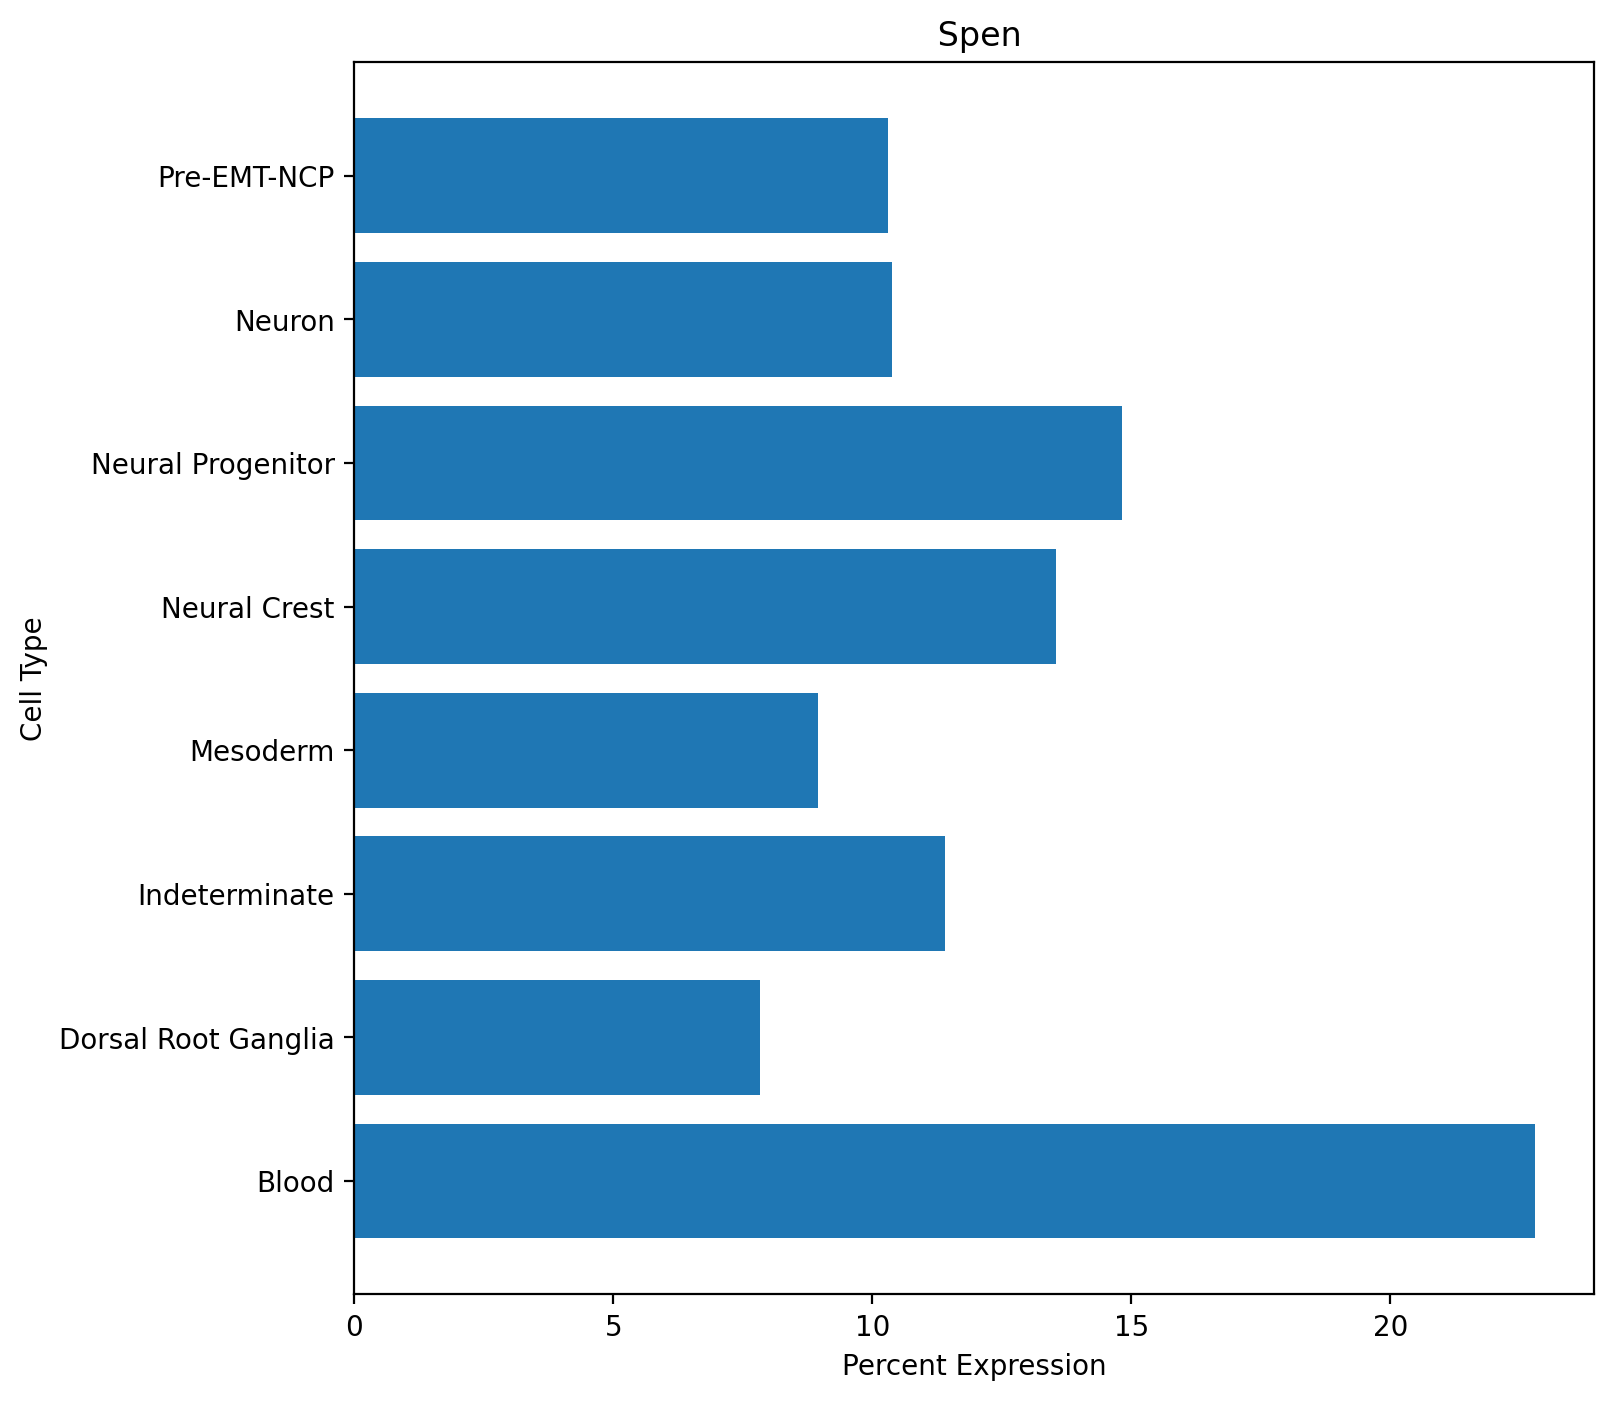

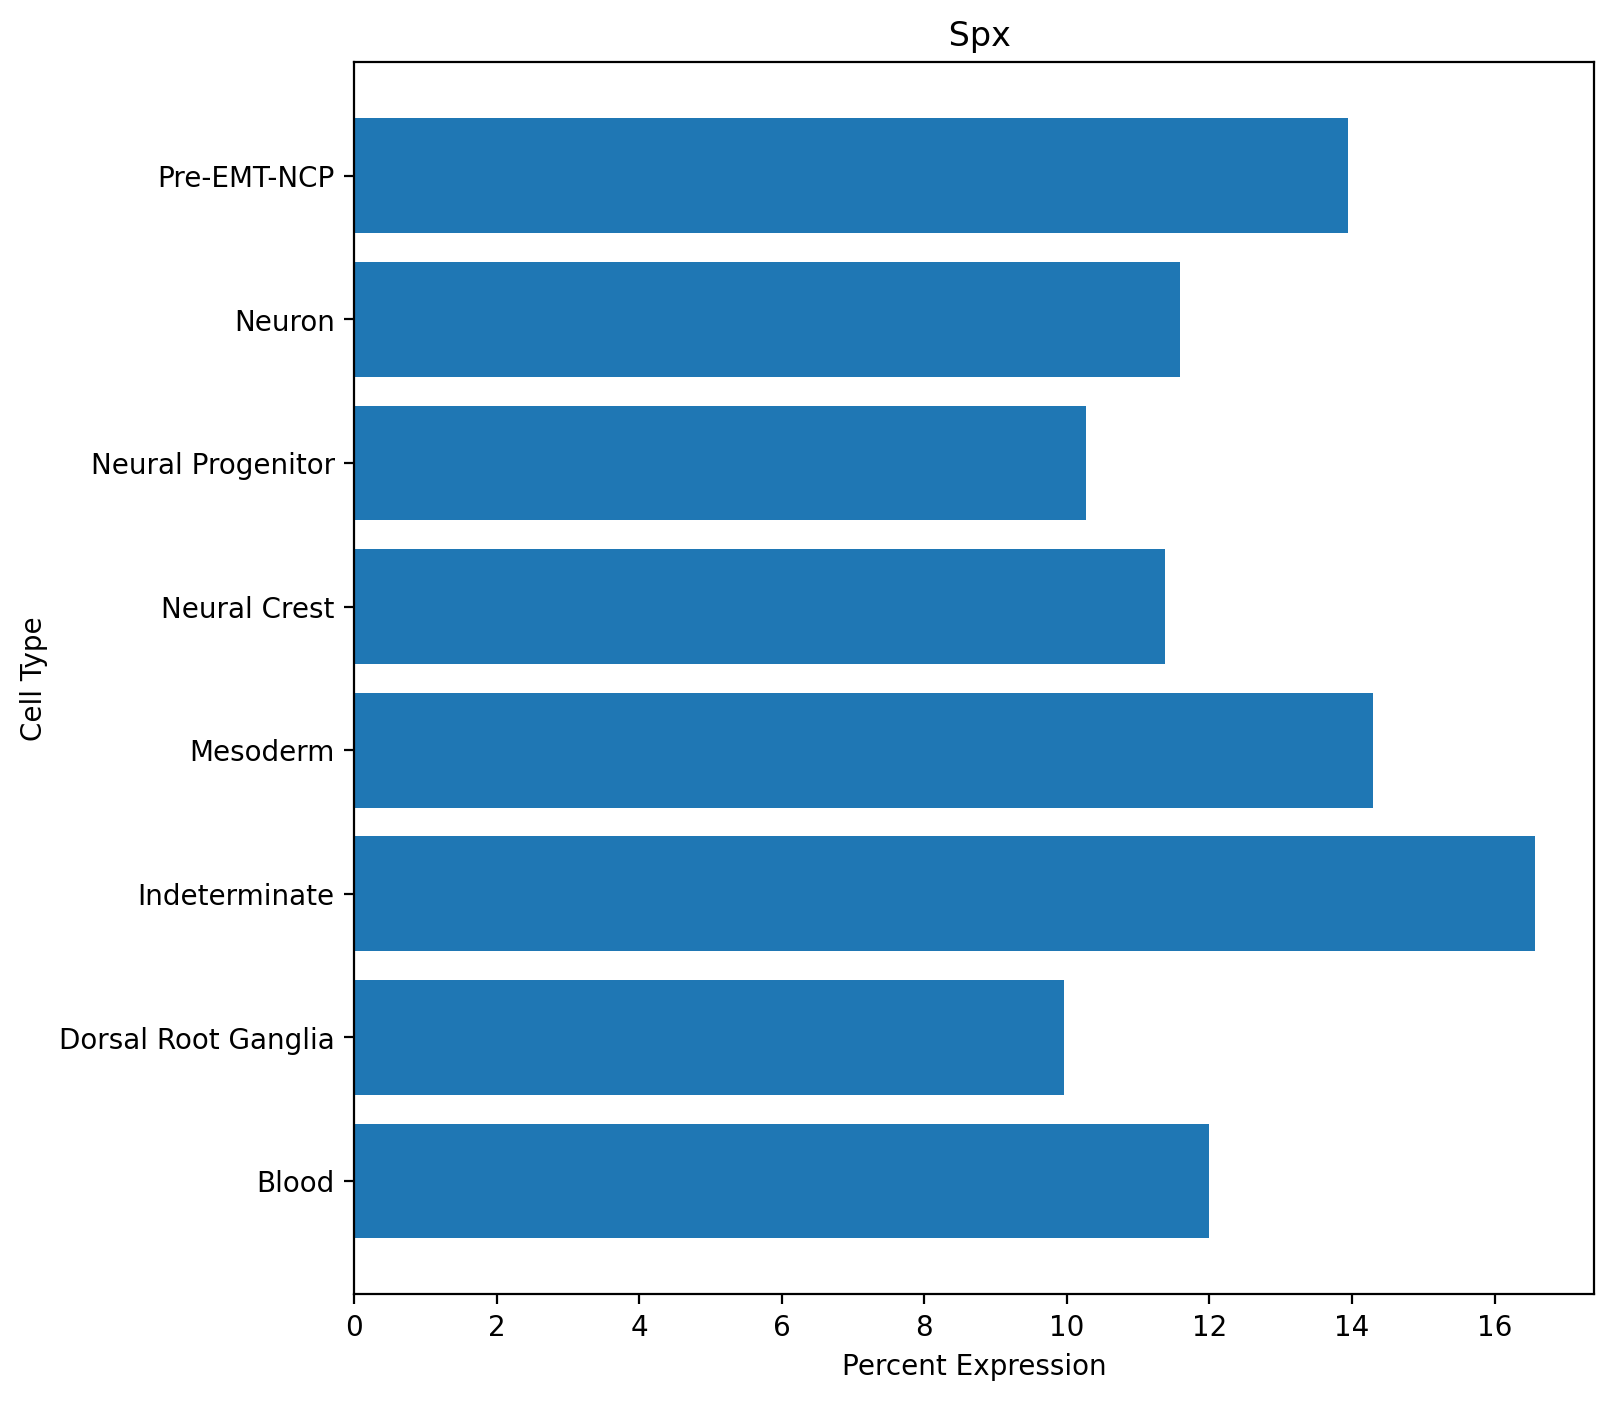

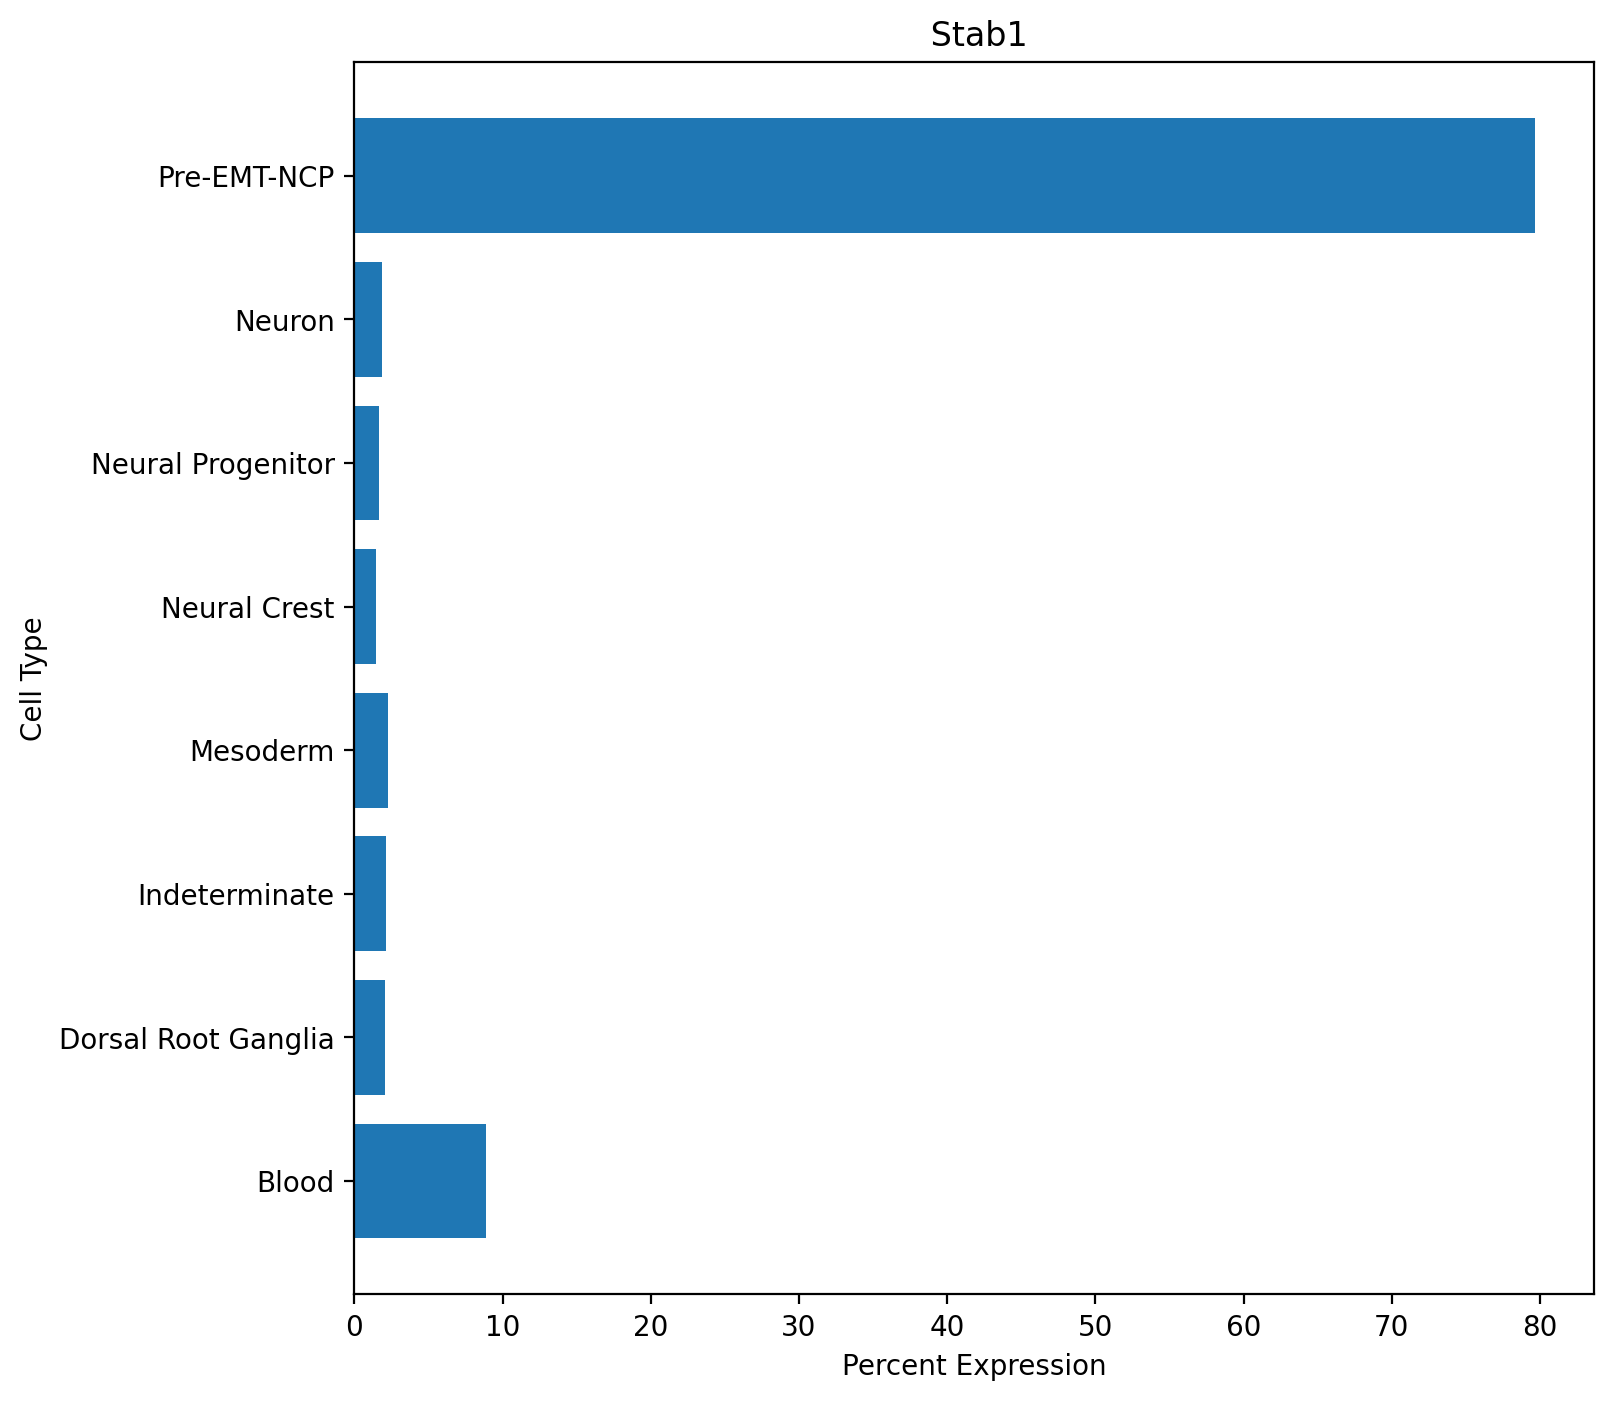

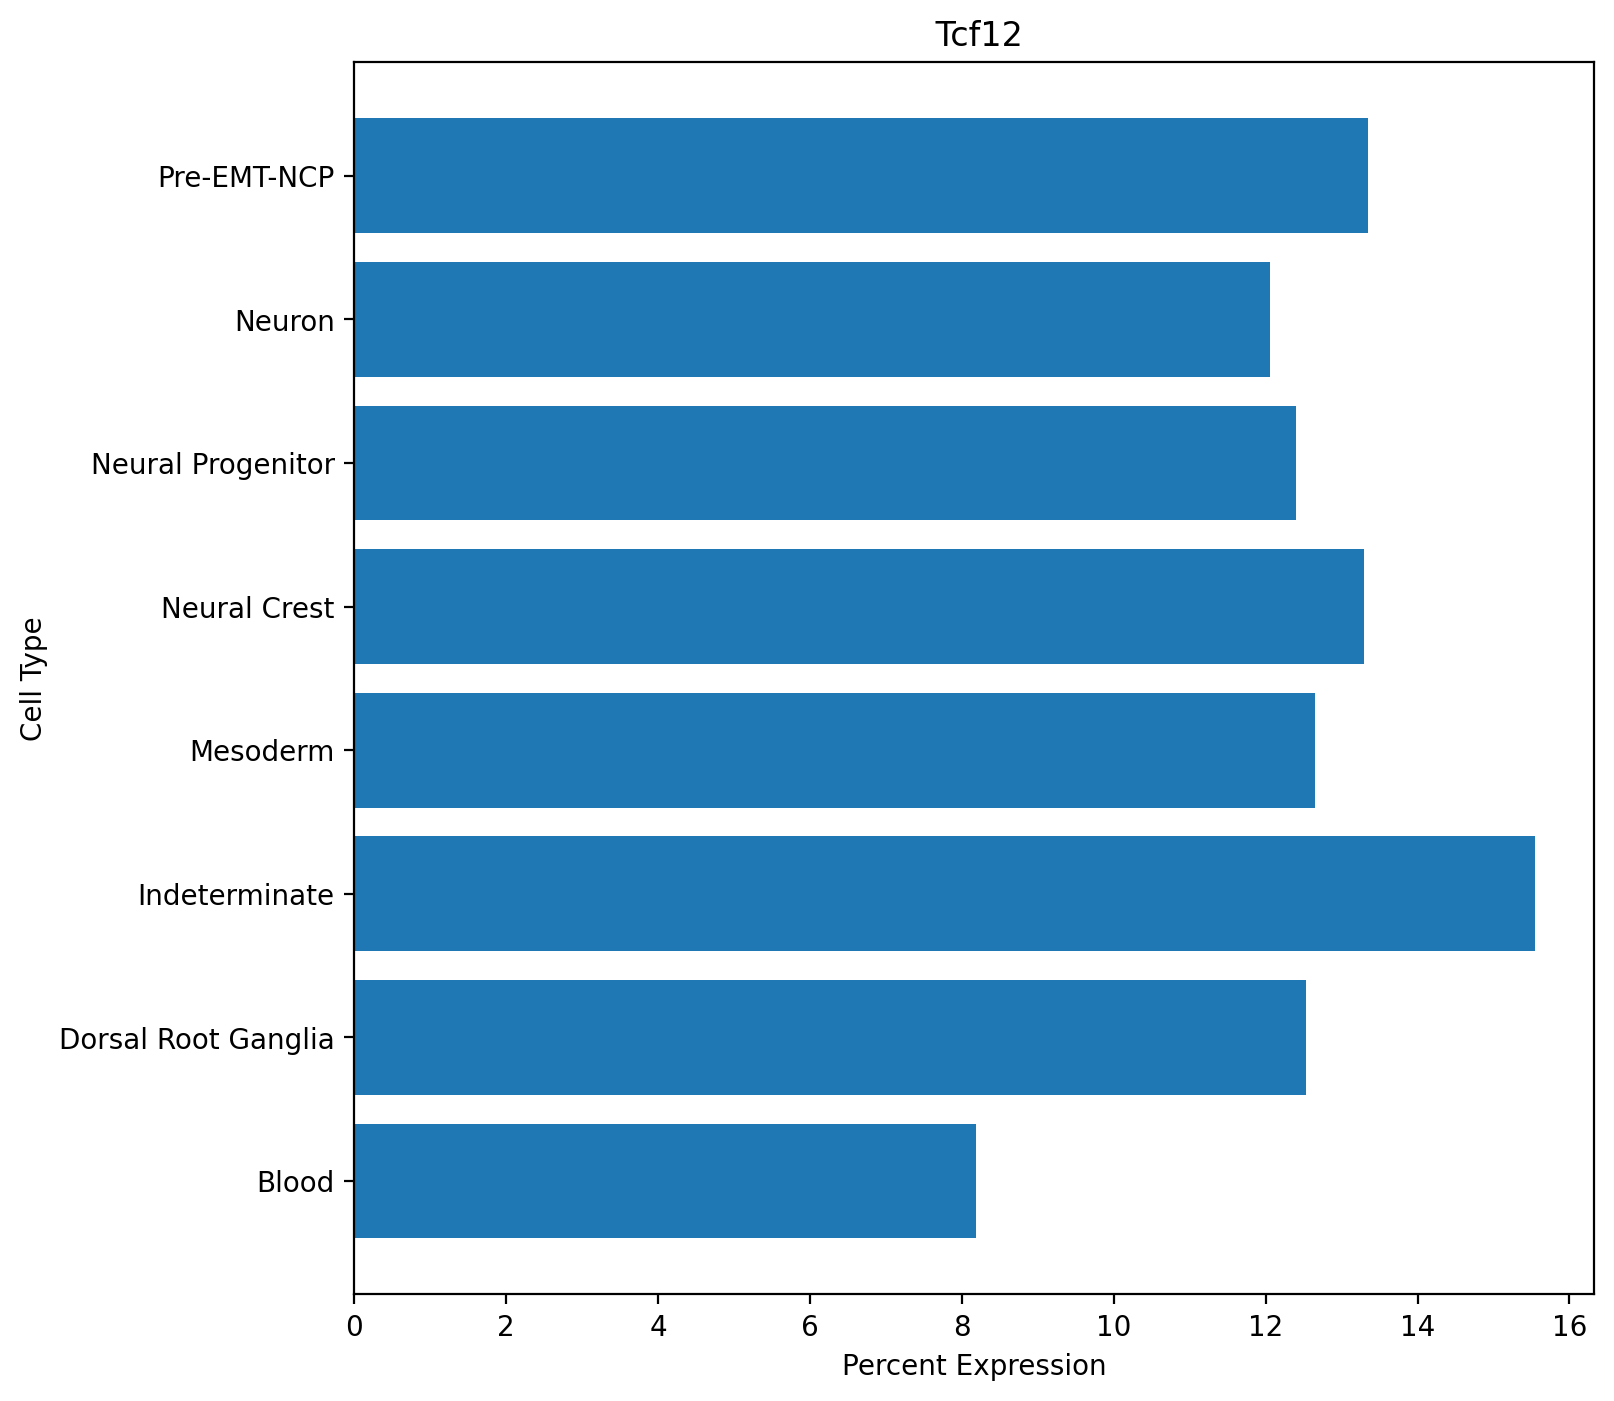

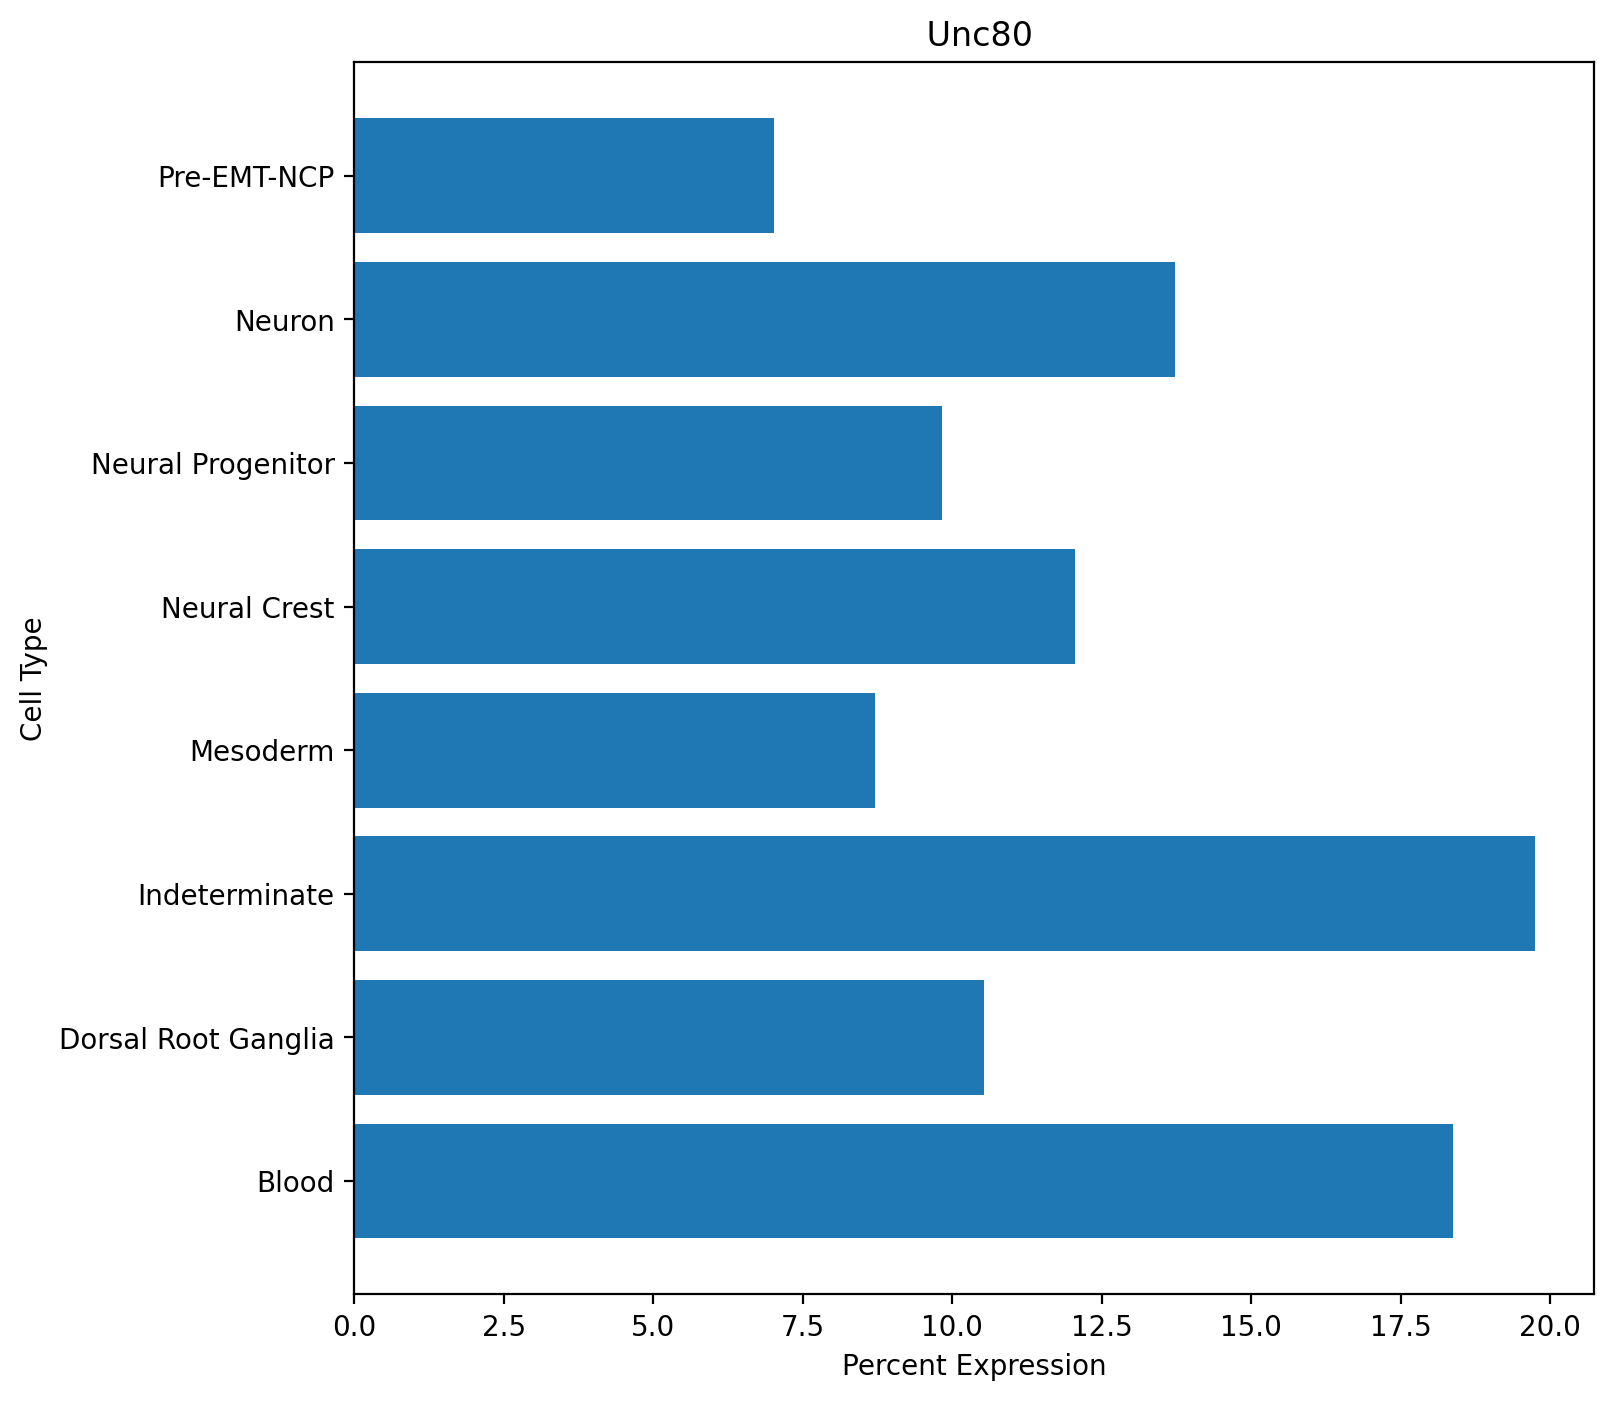

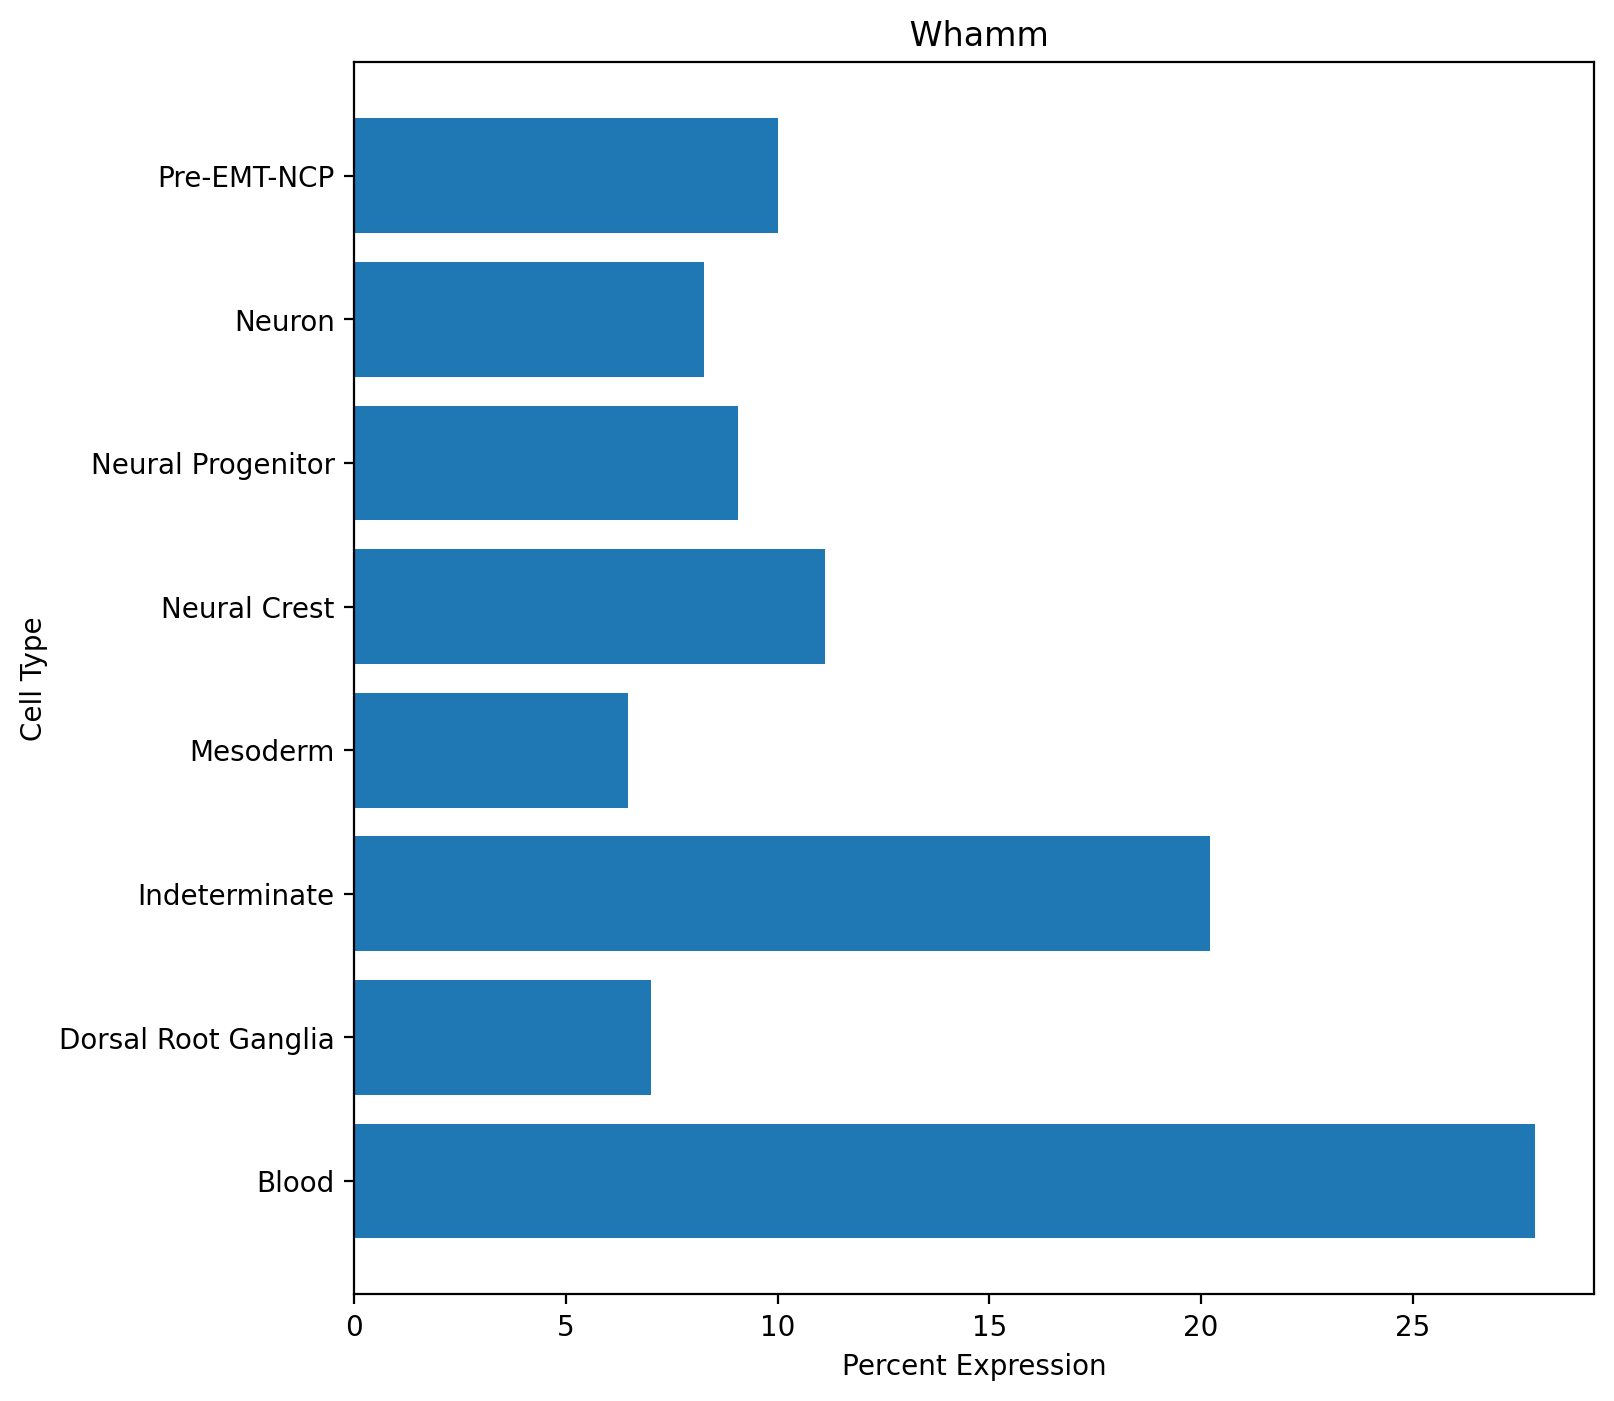

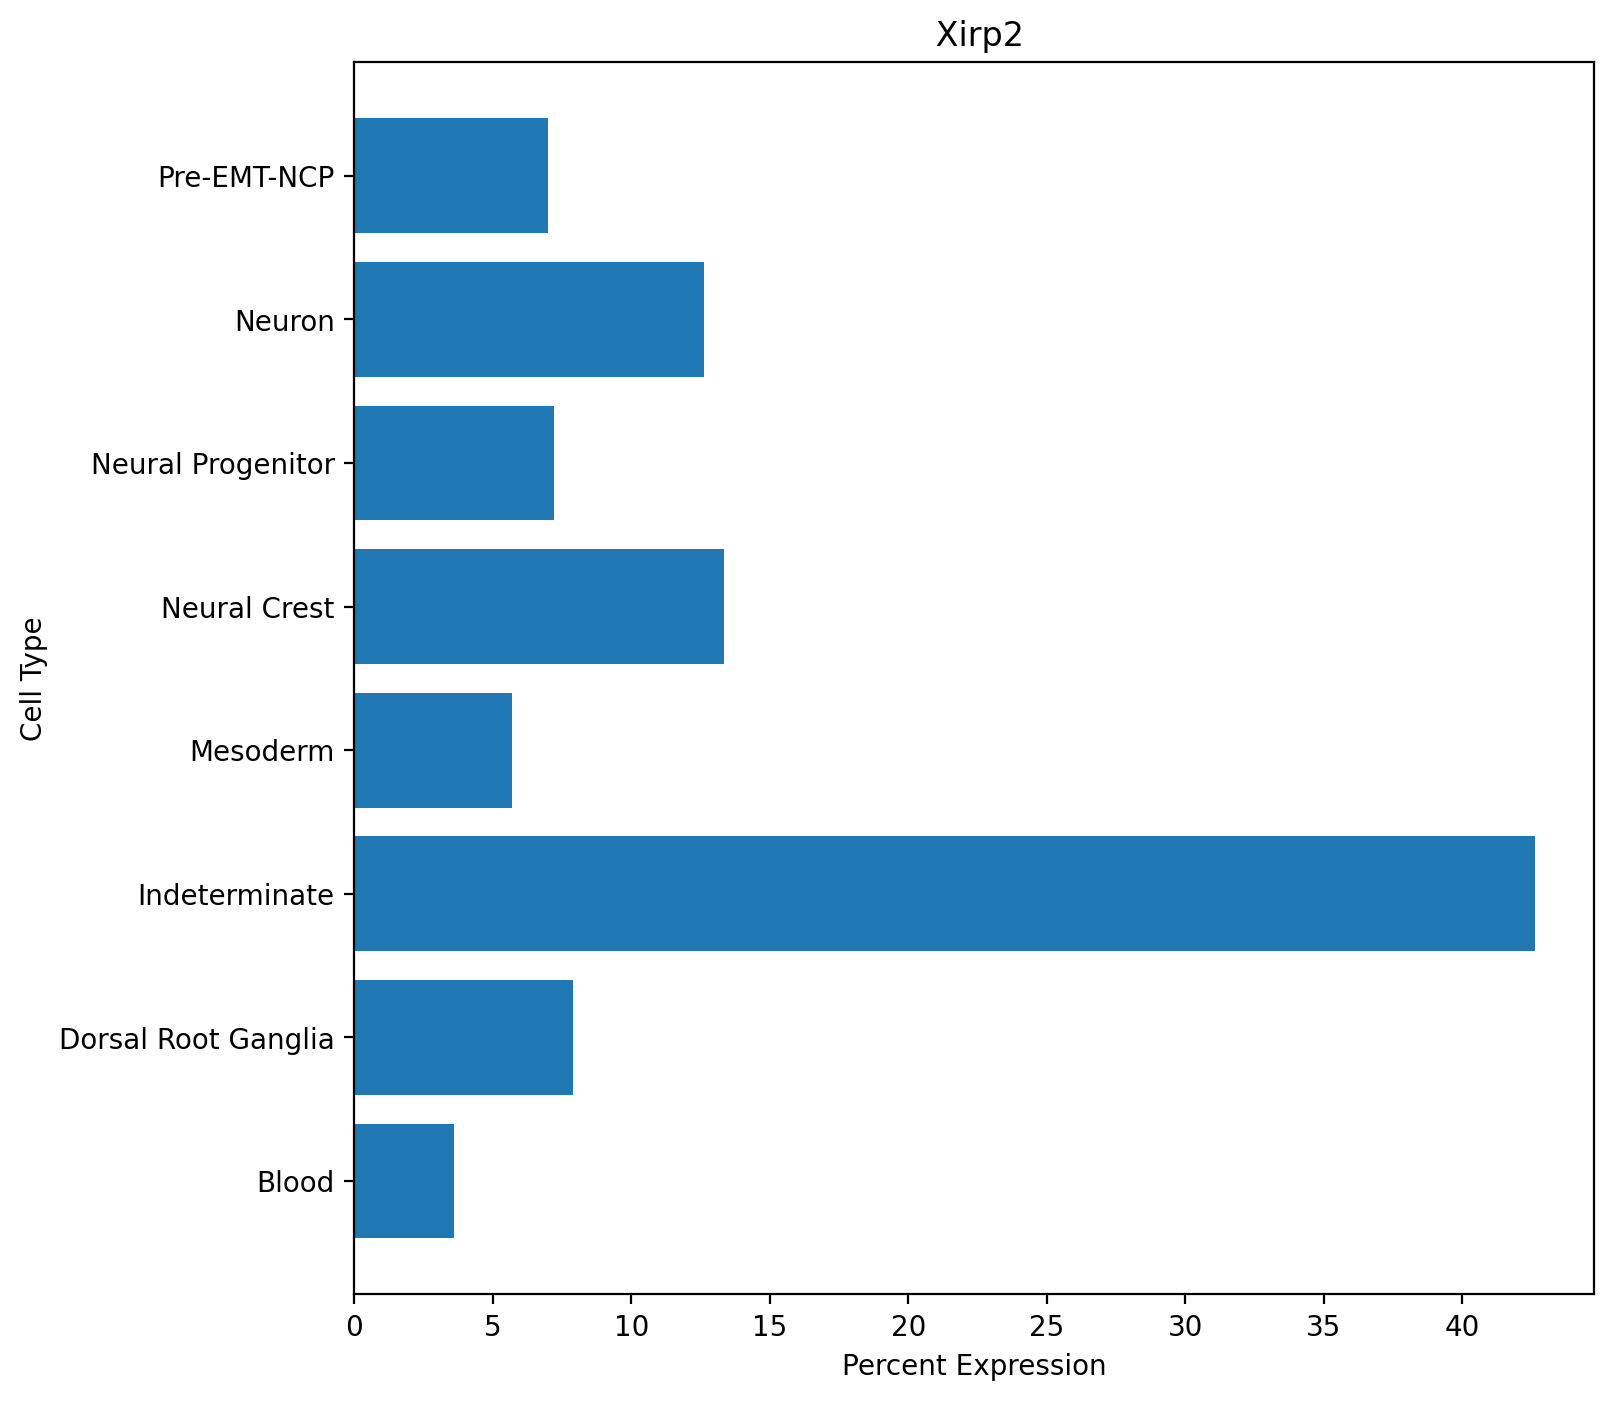

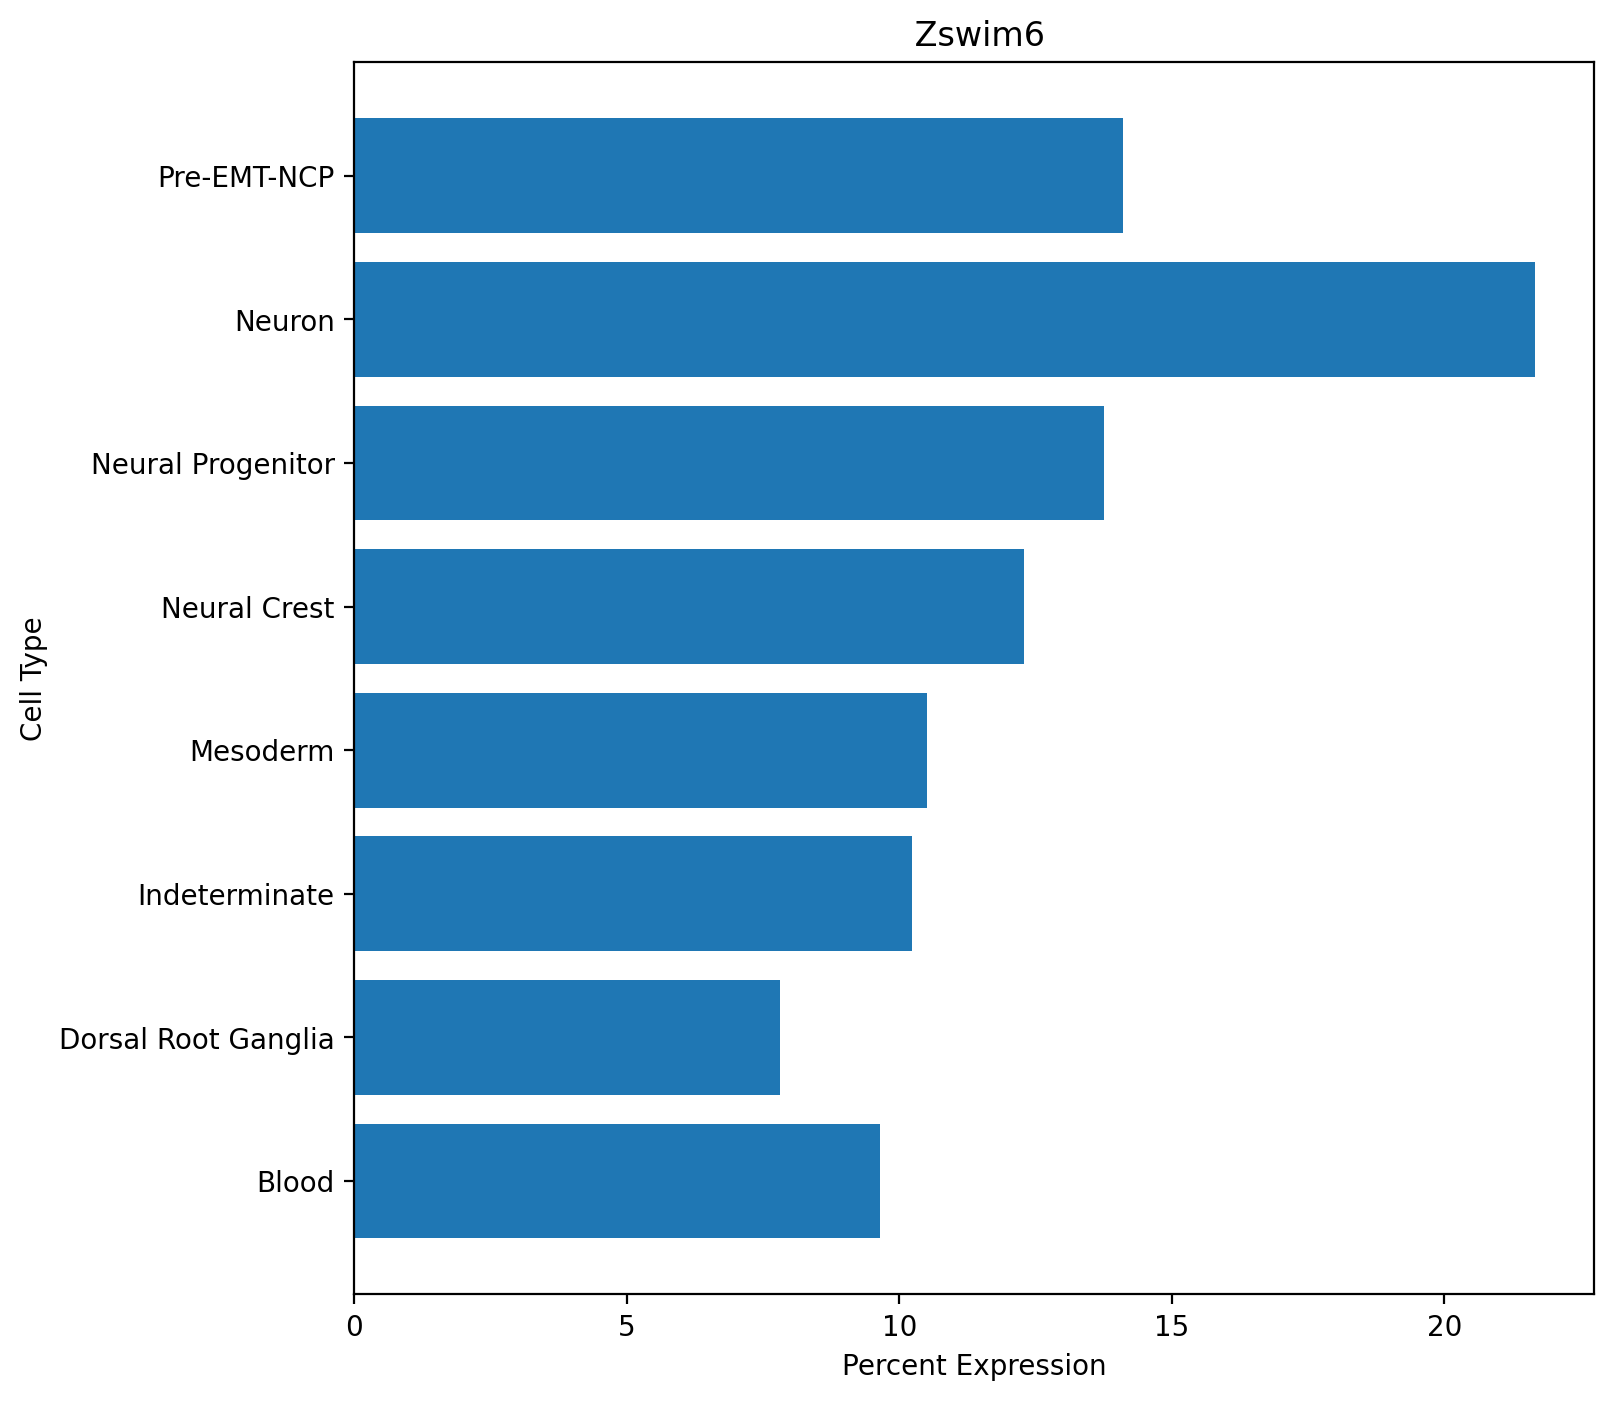

In [17]:
# percent expression per DNM gene
#with PdfPages('DNM_percent_expression.pdf') as pdf:
for gene_column in percent_avg_exp_DNM.columns[1:]:
    plt.figure(figsize=(8, 8))
    plt.barh(percent_avg_exp_DNM['sctype_pred'], percent_avg_exp_DNM[gene_column])
    plt.xlabel('Percent Expression')
    plt.ylabel('Cell Type')
    plt.title(f' {gene_column}')
        #pdf.savefig()
    plt.show()
    plt.close()
